<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 4 Lesson 3*

# Generative Adversarial Networks (GANs)


*PS: The person below does not exist*


<img src="https://thispersondoesnotexist.com/image" width=500>

# Lecture

Learning Objectives:
1. What is a GAN?
    - Describe the mechanisms of a Generator & Discriminator
    - Describe the Adverserial process
2. How does a GAN achieve good results?
    - Talk about relationship with Game Theory 
    - Illustrate NASH equilibrium

## GAN Overview
<img  src="GAN Overview.jpeg" width=800>

<br></br>
<br></br>
<br></br>

## GAN Framework
<img  src="GAN Framework.jpeg" width=800>

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
np.random.seed(10)
random_dim = 100
 
# def load_minst_data():
#     # load the data - we'll use Fashion MNIST, for a change of pace
#     (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#     # normalize our inputs to be in the range[-1, 1] 
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
#     # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
#     # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
#     return (x_train, y_train, x_test, y_test)

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=2352,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(2352, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan



In [0]:
 def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                           figsize=(15, 15)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 3)
 
    plt.figure(figsize=figsize)
    for i in range(10):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
        # plt.title(f'epoch: {epoch}')
    plt.tight_layout()
    if epoch == 25000:
       plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
W0822 19:43:38.229331 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:43:38.244557 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:43:38.257870 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:43:38.270607 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:43:38.284593 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:43:38.298188 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------
--------------- Epoch 25 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------
--------------- Epoch 27 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------
--------------- Epoch 29 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------
--------------- Epoch 31 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------
--------------- Epoch 33 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------
--------------- Epoch 35 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------
--------------- Epoch 37 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------
--------------- Epoch 39 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------
--------------- Epoch 41 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------
--------------- Epoch 43 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------
--------------- Epoch 45 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------
--------------- Epoch 47 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------
--------------- Epoch 49 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------
--------------- Epoch 51 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------
--------------- Epoch 53 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------
--------------- Epoch 55 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------
--------------- Epoch 57 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------
--------------- Epoch 59 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------
--------------- Epoch 61 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------
--------------- Epoch 63 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------
--------------- Epoch 65 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------
--------------- Epoch 67 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------
--------------- Epoch 69 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------
--------------- Epoch 71 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------
--------------- Epoch 73 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]

--------------- Epoch 74 ---------------
--------------- Epoch 75 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------
--------------- Epoch 77 ---------------
--------------- Epoch 78 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]


--------------- Epoch 79 ---------------
--------------- Epoch 80 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 81 ---------------
--------------- Epoch 82 ---------------
--------------- Epoch 83 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------
--------------- Epoch 85 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------
--------------- Epoch 87 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------
--------------- Epoch 89 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------
--------------- Epoch 91 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------
--------------- Epoch 93 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------
--------------- Epoch 95 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------
--------------- Epoch 97 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------
--------------- Epoch 99 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------
--------------- Epoch 101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------
--------------- Epoch 103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------
--------------- Epoch 105 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 106 ---------------
--------------- Epoch 107 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]


--------------- Epoch 108 ---------------
--------------- Epoch 109 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 110 ---------------
--------------- Epoch 111 ---------------
--------------- Epoch 112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------
--------------- Epoch 114 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.20it/s]

--------------- Epoch 115 ---------------
--------------- Epoch 116 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 117 ---------------
--------------- Epoch 118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 119 ---------------
--------------- Epoch 120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 121 ---------------
--------------- Epoch 122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------
--------------- Epoch 124 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.95it/s]


--------------- Epoch 125 ---------------
--------------- Epoch 126 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 127 ---------------
--------------- Epoch 128 ---------------
--------------- Epoch 129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 130 ---------------
--------------- Epoch 131 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]

--------------- Epoch 132 ---------------
--------------- Epoch 133 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 134 ---------------
--------------- Epoch 135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 136 ---------------
--------------- Epoch 137 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.20it/s]


--------------- Epoch 138 ---------------
--------------- Epoch 139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 140 ---------------
--------------- Epoch 141 ---------------
--------------- Epoch 142 ---------------
--------------- Epoch 143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 144 ---------------
--------------- Epoch 145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 146 ---------------
--------------- Epoch 147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 148 ---------------
--------------- Epoch 149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 150 ---------------
--------------- Epoch 151 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]

--------------- Epoch 152 ---------------
--------------- Epoch 153 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.64it/s]


--------------- Epoch 154 ---------------
--------------- Epoch 155 ---------------
--------------- Epoch 156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 157 ---------------
--------------- Epoch 158 ---------------
--------------- Epoch 159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 160 ---------------
--------------- Epoch 161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 162 ---------------
--------------- Epoch 163 ---------------
--------------- Epoch 164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 165 ---------------
--------------- Epoch 166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 167 ---------------
--------------- Epoch 168 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]

--------------- Epoch 169 ---------------
--------------- Epoch 170 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.54it/s]

--------------- Epoch 171 ---------------
--------------- Epoch 172 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 173 ---------------
--------------- Epoch 174 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.50it/s]


--------------- Epoch 175 ---------------
--------------- Epoch 176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 177 ---------------
--------------- Epoch 178 ---------------
--------------- Epoch 179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 180 ---------------
--------------- Epoch 181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 182 ---------------
--------------- Epoch 183 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]


--------------- Epoch 184 ---------------
--------------- Epoch 185 ---------------
--------------- Epoch 186

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 187 ---------------
--------------- Epoch 188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 189 ---------------
--------------- Epoch 190 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]

--------------- Epoch 191 ---------------
--------------- Epoch 192 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 193 ---------------
--------------- Epoch 194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 195 ---------------
--------------- Epoch 196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 197 ---------------
--------------- Epoch 198 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]

--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.74it/s]

--------------- Epoch 201 ---------------
--------------- Epoch 202 ---------------
--------------- Epoch 203 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.14it/s]


--------------- Epoch 204 ---------------
--------------- Epoch 205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 206 ---------------
--------------- Epoch 207 ---------------
--------------- Epoch 208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 209 ---------------
--------------- Epoch 210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 211 ---------------
--------------- Epoch 212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 213 ---------------
--------------- Epoch 214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 215 ---------------
--------------- Epoch 216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 217 ---------------
--------------- Epoch 218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 219 ---------------
--------------- Epoch 220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 221 ---------------
--------------- Epoch 222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 223 ---------------
--------------- Epoch 224 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.64it/s]

--------------- Epoch 225 ---------------
--------------- Epoch 226 ---------------



100%|██████████| 3/3 [00:00<00:00, 32.17it/s]

--------------- Epoch 227 ---------------
--------------- Epoch 228 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.80it/s]


--------------- Epoch 229 ---------------
--------------- Epoch 230 ---------------
--------------- Epoch 231 ---------------
--------------- Epoch 232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 233 ---------------
--------------- Epoch 234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 235 ---------------
--------------- Epoch 236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 237 ---------------
--------------- Epoch 238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 239 ---------------
--------------- Epoch 240 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


--------------- Epoch 241 ---------------
--------------- Epoch 242 ---------------
--------------- Epoch 243 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.94it/s]


--------------- Epoch 244 ---------------
--------------- Epoch 245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 246 ---------------
--------------- Epoch 247 ---------------
--------------- Epoch 248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 249 ---------------
--------------- Epoch 250 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.75it/s]

--------------- Epoch 251 ---------------
--------------- Epoch 252 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 253 ---------------
--------------- Epoch 254 ---------------
--------------- Epoch 255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 256 ---------------
--------------- Epoch 257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 258 ---------------
--------------- Epoch 259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 260 ---------------
--------------- Epoch 261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 262 ---------------
--------------- Epoch 263 ---------------
--------------- Epoch 264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 265 ---------------
--------------- Epoch 266 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 267 ---------------
--------------- Epoch 268 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


--------------- Epoch 269 ---------------
--------------- Epoch 270 ---------------
--------------- Epoch 271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 272 ---------------
--------------- Epoch 273 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.95it/s]

--------------- Epoch 274 ---------------
--------------- Epoch 275 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 276 ---------------
--------------- Epoch 277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 278 ---------------
--------------- Epoch 279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 280 ---------------
--------------- Epoch 281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 282 ---------------
--------------- Epoch 283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 284 ---------------
--------------- Epoch 285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 286 ---------------
--------------- Epoch 287 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]

--------------- Epoch 288 ---------------
--------------- Epoch 289 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 290 ---------------
--------------- Epoch 291 ---------------
--------------- Epoch 292 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 293 ---------------
--------------- Epoch 294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 295 ---------------
--------------- Epoch 296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 297 ---------------
--------------- Epoch 298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 299 ---------------
--------------- Epoch 300 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.83it/s]


--------------- Epoch 301 ---------------
--------------- Epoch 302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 303 ---------------
--------------- Epoch 304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 305 ---------------
--------------- Epoch 306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 307 ---------------
--------------- Epoch 308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 309 ---------------
--------------- Epoch 310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 311 ---------------
--------------- Epoch 312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 313 ---------------
--------------- Epoch 314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 315 ---------------
--------------- Epoch 316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 317 ---------------
--------------- Epoch 318 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]


--------------- Epoch 319 ---------------
--------------- Epoch 320 ---------------
--------------- Epoch 321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 322 ---------------
--------------- Epoch 323 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 324 ---------------
--------------- Epoch 325 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.06it/s]

--------------- Epoch 326 ---------------
--------------- Epoch 327 ---------------
--------------- Epoch 328 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 329 ---------------
--------------- Epoch 330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 331 ---------------
--------------- Epoch 332 ---------------
--------------- Epoch 333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 334 ---------------
--------------- Epoch 335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 336 ---------------
--------------- Epoch 337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 338 ---------------
--------------- Epoch 339 ---------------
--------------- Epoch 340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 341 ---------------
--------------- Epoch 342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 343 ---------------
--------------- Epoch 344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 345 ---------------
--------------- Epoch 346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 347 ---------------
--------------- Epoch 348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 349 ---------------
--------------- Epoch 350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 351 ---------------
--------------- Epoch 352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 353 ---------------
--------------- Epoch 354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 355 ---------------
--------------- Epoch 356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 357 ---------------
--------------- Epoch 358 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.88it/s]


--------------- Epoch 359 ---------------
--------------- Epoch 360 ---------------
--------------- Epoch 361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 362 ---------------
--------------- Epoch 363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 364 ---------------
--------------- Epoch 365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 366 ---------------
--------------- Epoch 367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 368 ---------------
--------------- Epoch 369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 370 ---------------
--------------- Epoch 371 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.18it/s]

--------------- Epoch 372 ---------------
--------------- Epoch 373 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 374 ---------------
--------------- Epoch 375 ---------------
--------------- Epoch 376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 377 ---------------
--------------- Epoch 378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 379 ---------------
--------------- Epoch 380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 381 ---------------
--------------- Epoch 382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 383 ---------------
--------------- Epoch 384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 385 ---------------
--------------- Epoch 386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 387 ---------------
--------------- Epoch 388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 389 ---------------
--------------- Epoch 390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 391 ---------------
--------------- Epoch 392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 393 ---------------
--------------- Epoch 394 ---------------
--------------- Epoch 395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 396 ---------------
--------------- Epoch 397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 398 ---------------
--------------- Epoch 399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 400 ---------------
--------------- Epoch 401 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 402 ---------------
--------------- Epoch 403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 404 ---------------
--------------- Epoch 405 ---------------
--------------- Epoch 406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 407 ---------------
--------------- Epoch 408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 409 ---------------
--------------- Epoch 410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 411 ---------------
--------------- Epoch 412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 413 ---------------
--------------- Epoch 414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 415 ---------------
--------------- Epoch 416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 417 ---------------
--------------- Epoch 418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 419 ---------------
--------------- Epoch 420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 421 ---------------
--------------- Epoch 422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 423 ---------------
--------------- Epoch 424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 425 ---------------
--------------- Epoch 426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 427 ---------------
--------------- Epoch 428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 429 ---------------
--------------- Epoch 430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 431 ---------------
--------------- Epoch 432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 433 ---------------
--------------- Epoch 434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 435 ---------------
--------------- Epoch 436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 437 ---------------
--------------- Epoch 438 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]

--------------- Epoch 439 ---------------
--------------- Epoch 440 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 441 ---------------
--------------- Epoch 442 ---------------
--------------- Epoch 443 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.61it/s]


--------------- Epoch 444 ---------------
--------------- Epoch 445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 446 ---------------
--------------- Epoch 447 ---------------
--------------- Epoch 448 ---------------
--------------- Epoch 449 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]


--------------- Epoch 450 ---------------
--------------- Epoch 451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 452 ---------------
--------------- Epoch 453 ---------------
--------------- Epoch 454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 455 ---------------
--------------- Epoch 456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 457 ---------------
--------------- Epoch 458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 459 ---------------
--------------- Epoch 460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 461 ---------------
--------------- Epoch 462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 463 ---------------
--------------- Epoch 464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 465 ---------------
--------------- Epoch 466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 467 ---------------
--------------- Epoch 468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 469 ---------------
--------------- Epoch 470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 471 ---------------
--------------- Epoch 472 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.87it/s]


--------------- Epoch 473 ---------------
--------------- Epoch 474 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]


--------------- Epoch 475 ---------------
--------------- Epoch 476 ---------------
--------------- Epoch 477 ---------------
--------------- 

100%|██████████| 3/3 [00:00<00:00, 31.54it/s]


Epoch 478 ---------------
--------------- Epoch 479 ---------------
--------------- Epoch 480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 481 ---------------
--------------- Epoch 482 ---------------
--------------- Epoch 483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 484 ---------------
--------------- Epoch 485 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


--------------- Epoch 486 ---------------
--------------- Epoch 487 ---------------
--------------- Epoch 488

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 489 ---------------
--------------- Epoch 490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 491 ---------------
--------------- Epoch 492 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]

--------------- Epoch 493 ---------------
--------------- Epoch 494 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 495 ---------------
--------------- Epoch 496 ---------------
--------------- Epoch 497 ---------------
--------------- Epoch 498

100%|██████████| 3/3 [00:00<00:00, 30.64it/s]


 ---------------
--------------- Epoch 499 ---------------
--------------- Epoch 500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 501 ---------------
--------------- Epoch 502 ---------------
--------------- Epoch 503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 504 ---------------
--------------- Epoch 505 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]


--------------- Epoch 506 ---------------
--------------- Epoch 507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 508 ---------------
--------------- Epoch 509 ---------------
--------------- Epoch 510 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.68it/s]

--------------- Epoch 511 ---------------
--------------- Epoch 512 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 513 ---------------
--------------- Epoch 514 ---------------
--------------- Epoch 515 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.75it/s]


--------------- Epoch 516 ---------------
--------------- Epoch 517 ---------------
--------------- Epoch 518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 519 ---------------
--------------- Epoch 520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 521 ---------------
--------------- Epoch 522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 523 ---------------
--------------- Epoch 524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 525 ---------------
--------------- Epoch 526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 527 ---------------
--------------- Epoch 528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 529 ---------------
--------------- Epoch 530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 531 ---------------
--------------- Epoch 532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 533 ---------------
--------------- Epoch 534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 535 ---------------
--------------- Epoch 536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 537 ---------------
--------------- Epoch 538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 539 ---------------
--------------- Epoch 540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 541 ---------------
--------------- Epoch 542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 543 ---------------
--------------- Epoch 544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 545 ---------------
--------------- Epoch 546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 547 ---------------
--------------- Epoch 548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 549 ---------------
--------------- Epoch 550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 551 ---------------
--------------- Epoch 552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 553 ---------------
--------------- Epoch 554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 555 ---------------
--------------- Epoch 556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 557 ---------------
--------------- Epoch 558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 559 ---------------
--------------- Epoch 560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 561 ---------------
--------------- Epoch 562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 563 ---------------
--------------- Epoch 564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 565 ---------------
--------------- Epoch 566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 567 ---------------
--------------- Epoch 568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 569 ---------------
--------------- Epoch 570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 571 ---------------
--------------- Epoch 572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 573 ---------------
--------------- Epoch 574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 575 ---------------
--------------- Epoch 576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 577 ---------------
--------------- Epoch 578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 579 ---------------
--------------- Epoch 580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 581 ---------------
--------------- Epoch 582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 583 ---------------
--------------- Epoch 584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 585 ---------------
--------------- Epoch 586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 587 ---------------
--------------- Epoch 588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 589 ---------------
--------------- Epoch 590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 591 ---------------
--------------- Epoch 592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 593 ---------------
--------------- Epoch 594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 595 ---------------
--------------- Epoch 596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 597 ---------------
--------------- Epoch 598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 599 ---------------
--------------- Epoch 600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 601 ---------------
--------------- Epoch 602 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]

--------------- Epoch 603 ---------------
--------------- Epoch 604 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 605 ---------------
--------------- Epoch 606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 607 ---------------
--------------- Epoch 608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 609 ---------------
--------------- Epoch 610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 611 ---------------
--------------- Epoch 612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 613 ---------------
--------------- Epoch 614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 615 ---------------
--------------- Epoch 616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 617 ---------------
--------------- Epoch 618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 619 ---------------
--------------- Epoch 620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 621 ---------------
--------------- Epoch 622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 623 ---------------
--------------- Epoch 624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 625 ---------------
--------------- Epoch 626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 627 ---------------
--------------- Epoch 628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 629 ---------------
--------------- Epoch 630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 631 ---------------
--------------- Epoch 632 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]


--------------- Epoch 633 ---------------
--------------- Epoch 634 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 635 ---------------
--------------- Epoch 636 ---------------
--------------- Epoch 637 ---------------
--------------- Epoch 638

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 639 ---------------
--------------- Epoch 640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 641 ---------------
--------------- Epoch 642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 643 ---------------
--------------- Epoch 644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 645 ---------------
--------------- Epoch 646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 647 ---------------
--------------- Epoch 648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 649 ---------------
--------------- Epoch 650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 651 ---------------
--------------- Epoch 652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 653 ---------------
--------------- Epoch 654 ---------------
--------------- Epoch 655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 656 ---------------
--------------- Epoch 657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 658 ---------------
--------------- Epoch 659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 660 ---------------
--------------- Epoch 661 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]

--------------- Epoch 662 ---------------
--------------- Epoch 663 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 664 ---------------
--------------- Epoch 665 ---------------
--------------- Epoch 666 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.77it/s]

--------------- Epoch 667 ---------------
--------------- Epoch 668 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 669 ---------------
--------------- Epoch 670 ---------------
--------------- Epoch 671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 672 ---------------
--------------- Epoch 673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 674 ---------------
--------------- Epoch 675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 676 ---------------
--------------- Epoch 677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 678 ---------------
--------------- Epoch 679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 680 ---------------
--------------- Epoch 681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 682 ---------------
--------------- Epoch 683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 684 ---------------
--------------- Epoch 685 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.57it/s]

--------------- Epoch 686 ---------------
--------------- Epoch 687 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 688 ---------------
--------------- Epoch 689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 690 ---------------
--------------- Epoch 691 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


--------------- Epoch 692 ---------------
--------------- Epoch 693 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 30.00it/s]

 Epoch 694 ---------------
--------------- Epoch 695 ---------------
--------------- Epoch 696 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 697 ---------------
--------------- Epoch 698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 699 ---------------
--------------- Epoch 700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 701 ---------------
--------------- Epoch 702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 703 ---------------
--------------- Epoch 704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 705 ---------------
--------------- Epoch 706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 707 ---------------
--------------- Epoch 708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 709 ---------------
--------------- Epoch 710 ---------------
--------------- Epoch 711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 712 ---------------
--------------- Epoch 713 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.67it/s]


--------------- Epoch 714 ---------------
--------------- Epoch 715 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 716 ---------------
--------------- Epoch 717 ---------------
--------------- Epoch 718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 719 ---------------
--------------- Epoch 720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 721 ---------------
--------------- Epoch 722 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]


--------------- Epoch 723 ---------------
--------------- Epoch 724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 725 ---------------
--------------- Epoch 726 ---------------
--------------- Epoch 727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 728 ---------------
--------------- Epoch 729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 730 ---------------
--------------- Epoch 731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 732 ---------------
--------------- Epoch 733 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.70it/s]


--------------- Epoch 734 ---------------
--------------- Epoch 735 ---------------
--------------- Epoch 736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 737 ---------------
--------------- Epoch 738 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]

--------------- Epoch 739 ---------------
--------------- Epoch 740 ---------------
--------------- Epoch 741


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]

 ---------------
--------------- Epoch 742 ---------------
--------------- Epoch 743 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 744 ---------------
--------------- Epoch 745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 746 ---------------
--------------- Epoch 747 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]


--------------- Epoch 748 ---------------
--------------- Epoch 749 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 750 ---------------
--------------- Epoch 751 ---------------
--------------- Epoch 752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 753 ---------------
--------------- Epoch 754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 755 ---------------
--------------- Epoch 756 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.13it/s]

--------------- Epoch 757 ---------------
--------------- Epoch 758 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 759 ---------------
--------------- Epoch 760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 761 ---------------
--------------- Epoch 762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 763 ---------------
--------------- Epoch 764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 765 ---------------
--------------- Epoch 766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 767 ---------------
--------------- Epoch 768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 769 ---------------
--------------- Epoch 770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 771 ---------------
--------------- Epoch 772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 773 ---------------
--------------- Epoch 774 ---------------
--------------- Epoch 775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 776 ---------------
--------------- Epoch 777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 778 ---------------
--------------- Epoch 779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 780 ---------------
--------------- Epoch 781 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.50it/s]


--------------- Epoch 782 ---------------
--------------- Epoch 783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 784 ---------------
--------------- Epoch 785 ---------------
--------------- Epoch 786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 787 ---------------
--------------- Epoch 788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 789 ---------------
--------------- Epoch 790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 791 ---------------
--------------- Epoch 792 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]

--------------- Epoch 793 ---------------
--------------- Epoch 794 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 795 ---------------
--------------- Epoch 796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 797 ---------------
--------------- Epoch 798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 799 ---------------
--------------- Epoch 800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 801 ---------------
--------------- Epoch 802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 803 ---------------
--------------- Epoch 804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 805 ---------------
--------------- Epoch 806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 807 ---------------
--------------- Epoch 808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 809 ---------------
--------------- Epoch 810 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.67it/s]


--------------- Epoch 811 ---------------
--------------- Epoch 812 ---------------
--------------- Epoch 813 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 815 ---------------
--------------- Epoch 816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 817 ---------------
--------------- Epoch 818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 819 ---------------
--------------- Epoch 820 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]

--------------- Epoch 821 ---------------
--------------- Epoch 822 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 823 ---------------
--------------- Epoch 824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 825 ---------------
--------------- Epoch 826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 827 ---------------
--------------- Epoch 828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 829 ---------------
--------------- Epoch 830 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.90it/s]

--------------- Epoch 831 ---------------
--------------- Epoch 832 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.31it/s]


--------------- Epoch 833 ---------------
--------------- Epoch 834 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.86it/s]

--------------- Epoch 835 ---------------
--------------- Epoch 836 ---------------
--------------- Epoch 837 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 838 ---------------
--------------- Epoch 839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 840 ---------------
--------------- Epoch 841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 842 ---------------
--------------- Epoch 843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 844 ---------------
--------------- Epoch 845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 846 ---------------
--------------- Epoch 847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 848 ---------------
--------------- Epoch 849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 850 ---------------
--------------- Epoch 851 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


--------------- Epoch 852 ---------------
--------------- Epoch 853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 854 ---------------
--------------- Epoch 855 ---------------
--------------- Epoch 856 ---------------
--------------- Epoch 857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 858 ---------------
--------------- Epoch 859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 860 ---------------
--------------- Epoch 861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 862 ---------------
--------------- Epoch 863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 864 ---------------
--------------- Epoch 865 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.15it/s]


--------------- Epoch 866 ---------------
--------------- Epoch 867 ---------------
--------------- Epoch 868 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 870 ---------------
--------------- Epoch 871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 872 ---------------
--------------- Epoch 873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 874 ---------------
--------------- Epoch 875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 876 ---------------
--------------- Epoch 877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 878 ---------------
--------------- Epoch 879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 880 ---------------
--------------- Epoch 881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 882 ---------------
--------------- Epoch 883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 884 ---------------
--------------- Epoch 885 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.47it/s]


--------------- Epoch 886 ---------------
--------------- Epoch 887 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 888 ---------------
--------------- Epoch 889 ---------------
--------------- Epoch 890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 891 ---------------
--------------- Epoch 892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 893 ---------------
--------------- Epoch 894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 895 ---------------
--------------- Epoch 896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 897 ---------------
--------------- Epoch 898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 899 ---------------
--------------- Epoch 900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 901 ---------------
--------------- Epoch 902 ---------------
--------------- Epoch 903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 904 ---------------
--------------- Epoch 905 ---------------
--------------- Epoch 906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 907 ---------------
--------------- Epoch 908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 909 ---------------
--------------- Epoch 910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 911 ---------------
--------------- Epoch 912 ---------------
--------------- Epoch 913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 914 ---------------
--------------- Epoch 915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 916 ---------------
--------------- Epoch 917 ---------------
--------------- Epoch 918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 919 ---------------
--------------- Epoch 920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 921 ---------------
--------------- Epoch 922 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.20it/s]

--------------- Epoch 923 ---------------
--------------- Epoch 924 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.57it/s]


--------------- Epoch 925 ---------------
--------------- Epoch 926 ---------------
--------------- Epoch 927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 928 ---------------
--------------- Epoch 929 ---------------
--------------- Epoch 930 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.63it/s]


--------------- Epoch 931 ---------------
--------------- Epoch 932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 933 ---------------
--------------- Epoch 934 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.89it/s]

--------------- Epoch 935 ---------------
--------------- Epoch 936 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 937 ---------------
--------------- Epoch 938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 939 ---------------
--------------- Epoch 940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 941 ---------------
--------------- Epoch 942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 943 ---------------
--------------- Epoch 944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 945 ---------------
--------------- Epoch 946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 947 ---------------
--------------- Epoch 948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 949 ---------------
--------------- Epoch 950 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.82it/s]


--------------- Epoch 951 ---------------
--------------- Epoch 952 ---------------
--------------- Epoch 953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 954 ---------------
--------------- Epoch 955 ---------------
--------------- Epoch 956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 957 ---------------
--------------- Epoch 958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 959 ---------------
--------------- Epoch 960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 961 ---------------
--------------- Epoch 962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 963 ---------------
--------------- Epoch 964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 965 ---------------
--------------- Epoch 966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 967 ---------------
--------------- Epoch 968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 969 ---------------
--------------- Epoch 970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 971 ---------------
--------------- Epoch 972 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]


--------------- Epoch 973 ---------------
--------------- Epoch 974 ---------------
--------------- Epoch 975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 976 ---------------
--------------- Epoch 977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 978 ---------------
--------------- Epoch 979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 980 ---------------
--------------- Epoch 981 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 982 ---------------
--------------- Epoch 983 ---------------
--------------- Epoch 984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 985 ---------------
--------------- Epoch 986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 987 ---------------
--------------- Epoch 988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 989 ---------------
--------------- Epoch 990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 991 ---------------
--------------- Epoch 992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 993 ---------------
--------------- Epoch 994 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.04it/s]


--------------- Epoch 995 ---------------
--------------- Epoch 996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 997 ---------------
--------------- Epoch 998 ---------------
--------------- Epoch 999 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]
W0822 19:45:22.409404 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.422860 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.436897 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.449750 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.462405 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.476417 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 1000 ---------------


W0822 19:45:22.505340 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.517660 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:45:22.531365 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1001 ---------------
--------------- Epoch 1002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1003 ---------------
--------------- Epoch 1004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1005 ---------------
--------------- Epoch 1006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1007 ---------------
--------------- Epoch 1008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1009 ---------------
--------------- Epoch 1010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1011 ---------------
--------------- Epoch 1012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1013 ---------------
--------------- Epoch 1014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1015 ---------------
--------------- Epoch 1016 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 1017 ---------------
--------------- Epoch 1018 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1019 ---------------
--------------- Epoch 1020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1021 ---------------
--------------- Epoch 1022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1023 ---------------
--------------- Epoch 1024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1025 ---------------
--------------- Epoch 1026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1027 ---------------
--------------- Epoch 1028 ---------------
--------------- Epoch 1029 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 1030 ---------------
--------------- Epoch 1031 ---------------
--------------- Epoch 1032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1033 ---------------
--------------- Epoch 1034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1035 ---------------
--------------- Epoch 1036 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.53it/s]

--------------- Epoch 1037 ---------------
--------------- Epoch 1038 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1039 ---------------
--------------- Epoch 1040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1041 ---------------
--------------- Epoch 1042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1043 ---------------
--------------- Epoch 1044 ---------------
--------------- Epoch 1045 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1046 ---------------
--------------- Epoch 1047 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.11it/s]


--------------- Epoch 1048 ---------------
--------------- Epoch 1049 ---------------
--------------- Epoch 1050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1051 ---------------
--------------- Epoch 1052 ---------------
--------------- Epoch 1053 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1054 ---------------
--------------- Epoch 1055 ---------------
--------------- Epoch 1056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1057 ---------------
--------------- Epoch 1058 ---------------
--------------- Epoch 1059 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.32it/s]


--------------- Epoch 1060 ---------------
--------------- Epoch 1061 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.83it/s]

--------------- Epoch 1062 ---------------
--------------- Epoch 1063 ---------------
--------------- Epoch 1064 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1065 ---------------
--------------- Epoch 1066 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]


--------------- Epoch 1067 ---------------
--------------- Epoch 1068 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.42it/s]


--------------- Epoch 1069 ---------------
--------------- Epoch 1070 ---------------
--------------- Epoch 1071 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.67it/s]


 Epoch 1072 ---------------
--------------- Epoch 1073 ---------------
--------------- Epoch 1074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1075 ---------------
--------------- Epoch 1076 ---------------
--------------- Epoch 1077 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]


--------------- Epoch 1078 ---------------
--------------- Epoch 1079 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1080 ---------------
--------------- Epoch 1081 ---------------
--------------- Epoch 1082 ---------------
--------------- Epoch 1083 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.66it/s]

--------------- Epoch 1084 ---------------
--------------- Epoch 1085 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1086 ---------------
--------------- Epoch 1087 ---------------
--------------- Epoch 1088 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.46it/s]


--------------- Epoch 1089 ---------------
--------------- Epoch 1090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1091 ---------------
--------------- Epoch 1092 ---------------
--------------- Epoch 1093 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


--------------- Epoch 1094 ---------------
--------------- Epoch 1095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1096 ---------------
--------------- Epoch 1097 ---------------
--------------- Epoch 1098 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]


--------------- Epoch 1099 ---------------
--------------- Epoch 1100 ---------------
--------------- Epoch 1101 ---------------

100%|██████████| 3/3 [00:00<00:00, 30.69it/s]



--------------- Epoch 1102 ---------------
--------------- Epoch 1103 ---------------
--------------- Epoch 1104 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 1105 ---------------
--------------- Epoch 1106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1107 ---------------
--------------- Epoch 1108 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.45it/s]


--------------- Epoch 1109 ---------------
--------------- Epoch 1110 ---------------
--------------- Epoch 1111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1112 ---------------
--------------- Epoch 1113 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1114 ---------------
--------------- Epoch 1115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1116 ---------------
--------------- Epoch 1117 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1118 ---------------
--------------- Epoch 1119 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 1120 ---------------
--------------- Epoch 1121 ---------------
--------------- Epoch 1122 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 1123 ---------------
--------------- Epoch 1124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1125 ---------------
--------------- Epoch 1126 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 1127 ---------------
--------------- Epoch 1128 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1129 ---------------
--------------- Epoch 1130 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.82it/s]

--------------- Epoch 1131 ---------------
--------------- Epoch 1132 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1133 ---------------
--------------- Epoch 1134 ---------------
--------------- Epoch 1135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1136 ---------------
--------------- Epoch 1137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1138 ---------------
--------------- Epoch 1139 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]


--------------- Epoch 1140 ---------------
--------------- Epoch 1141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1142 ---------------
--------------- Epoch 1143 ---------------
--------------- Epoch 1144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1145 ---------------
--------------- Epoch 1146 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.06it/s]


--------------- Epoch 1147 ---------------
--------------- Epoch 1148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1149 ---------------
--------------- Epoch 1150 ---------------
--------------- Epoch 1151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1152 ---------------
--------------- Epoch 1153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1154 ---------------
--------------- Epoch 1155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1156 ---------------
--------------- Epoch 1157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1158 ---------------
--------------- Epoch 1159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1160 ---------------
--------------- Epoch 1161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1162 ---------------
--------------- Epoch 1163 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]


--------------- Epoch 1164 ---------------
--------------- Epoch 1165 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]


--------------- Epoch 1166 ---------------
--------------- Epoch 1167 ---------------
--------------- Epoch 1168 ---------------
--------------- Epoch 1169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1170 ---------------
--------------- Epoch 1171 ---------------
--------------- Epoch 1172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1173 ---------------
--------------- Epoch 1174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1175 ---------------
--------------- Epoch 1176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1177 ---------------
--------------- Epoch 1178 ---------------
--------------- Epoch 1179 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.53it/s]


--------------- Epoch 1180 ---------------
--------------- Epoch 1181 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1182 ---------------
--------------- Epoch 1183 ---------------
--------------- Epoch 1184 ---------------
--------------- Epoch 1185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1186 ---------------
--------------- Epoch 1187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1188 ---------------
--------------- Epoch 1189 ---------------
--------------- Epoch 1190 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]

--------------- Epoch 1191 ---------------
--------------- Epoch 1192 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.68it/s]


--------------- Epoch 1193 ---------------
--------------- Epoch 1194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1195 ---------------
--------------- Epoch 1196 ---------------
--------------- Epoch 1197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1198 ---------------
--------------- Epoch 1199 ---------------
--------------- Epoch 1200 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]


--------------- Epoch 1201 ---------------
--------------- Epoch 1202 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.91it/s]


--------------- Epoch 1203 ---------------
--------------- Epoch 1204 ---------------
--------------- Epoch 1205 ---------------
--------------- Epoch 1206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1207 ---------------
--------------- Epoch 1208 ---------------
--------------- Epoch 1209 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.31it/s]

--------------- Epoch 1210 ---------------
--------------- Epoch 1211 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 1212 ---------------
--------------- Epoch 1213 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]


--------------- Epoch 1214 ---------------
--------------- Epoch 1215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1216 ---------------
--------------- Epoch 1217 ---------------
--------------- Epoch 1218 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]


--------------- Epoch 1219 ---------------
--------------- Epoch 1220 ---------------
--------------- Epoch 1221 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]


--------------- Epoch 1222 ---------------
--------------- Epoch 1223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1224 ---------------
--------------- Epoch 1225 ---------------
--------------- Epoch 1226 ---------------
--------------- Epoch 1227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1228 ---------------
--------------- Epoch 1229 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]

--------------- Epoch 1230 ---------------
--------------- Epoch 1231 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1232 ---------------
--------------- Epoch 1233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1234 ---------------
--------------- Epoch 1235 ---------------
--------------- Epoch 1236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1237 ---------------
--------------- Epoch 1238 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.42it/s]

--------------- Epoch 1239 ---------------
--------------- Epoch 1240 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 1241 ---------------
--------------- Epoch 1242 ---------------
--------------- Epoch 1243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1244 ---------------
--------------- Epoch 1245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1246 ---------------
--------------- Epoch 1247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1248 ---------------
--------------- Epoch 1249 ---------------
--------------- Epoch 1250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1251 ---------------
--------------- Epoch 1252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1253 ---------------
--------------- Epoch 1254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1255 ---------------
--------------- Epoch 1256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1257 ---------------
--------------- Epoch 1258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1259 ---------------
--------------- Epoch 1260 ---------------
--------------- Epoch 1261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1262 ---------------
--------------- Epoch 1263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1264 ---------------
--------------- Epoch 1265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1266 ---------------
--------------- Epoch 1267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1268 ---------------
--------------- Epoch 1269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1270 ---------------
--------------- Epoch 1271 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.97it/s]


--------------- Epoch 1272 ---------------
--------------- Epoch 1273 ---------------
--------------- Epoch 1274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1275 ---------------
--------------- Epoch 1276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1277 ---------------
--------------- Epoch 1278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1279 ---------------
--------------- Epoch 1280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1281 ---------------
--------------- Epoch 1282 ---------------
--------------- Epoch 1283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1284 ---------------
--------------- Epoch 1285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1286 ---------------
--------------- Epoch 1287 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.71it/s]


--------------- Epoch 1288 ---------------
--------------- Epoch 1289 ---------------
--------------- Epoch 1290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1291 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.04it/s]


--------------- Epoch 1292 ---------------
--------------- Epoch 1293 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1294 ---------------
--------------- Epoch 1295 ---------------
--------------- Epoch 1296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1297 ---------------
--------------- Epoch 1298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1299 ---------------
--------------- Epoch 1300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1301 ---------------
--------------- Epoch 1302 ---------------
--------------- Epoch 1303 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.15it/s]


--------------- Epoch 1304 ---------------
--------------- Epoch 1305 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


 Epoch 1306 ---------------
--------------- Epoch 1307 ---------------
--------------- Epoch 1308 ---------------
--------------- Epoch 1309 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]

--------------- Epoch 1310 ---------------
--------------- Epoch 1311 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1312 ---------------
--------------- Epoch 1313 ---------------
--------------- Epoch 1314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1315 ---------------
--------------- Epoch 1316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1317 ---------------
--------------- Epoch 1318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1319 ---------------
--------------- Epoch 1320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1321 ---------------
--------------- Epoch 1322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1323 ---------------
--------------- Epoch 1324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1325 ---------------
--------------- Epoch 1326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1327 ---------------
--------------- Epoch 1328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1329 ---------------
--------------- Epoch 1330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1331 ---------------
--------------- Epoch 1332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1333 ---------------
--------------- Epoch 1334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1335 ---------------
--------------- Epoch 1336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1337 ---------------
--------------- Epoch 1338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1339 ---------------
--------------- Epoch 1340 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.52it/s]


--------------- Epoch 1341 ---------------
--------------- Epoch 1342 ---------------
--------------- Epoch 1343 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 1344 ---------------
--------------- Epoch 1345 ---------------
--------------- Epoch 1346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1347 ---------------
--------------- Epoch 1348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1349 ---------------
--------------- Epoch 1350 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]


--------------- Epoch 1351 ---------------
--------------- Epoch 1352 ---------------
--------------- Epoch 1353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1354 ---------------
--------------- Epoch 1355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1356 ---------------
--------------- Epoch 1357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1358 ---------------
--------------- Epoch 1359 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.20it/s]


--------------- Epoch 1360 ---------------
--------------- Epoch 1361 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1362 ---------------
--------------- Epoch 1363 ---------------
--------------- Epoch 1364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1365 ---------------
--------------- Epoch 1366 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.26it/s]


--------------- Epoch 1367 ---------------
--------------- Epoch 1368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1369 ---------------
--------------- Epoch 1370 ---------------
--------------- Epoch 1371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1372 ---------------
--------------- Epoch 1373 ---------------
--------------- Epoch 1374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1375 ---------------
--------------- Epoch 1376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1377 ---------------
--------------- Epoch 1378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1379 ---------------
--------------- Epoch 1380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1381 ---------------
--------------- Epoch 1382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1383 ---------------
--------------- Epoch 1384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1385 ---------------
--------------- Epoch 1386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1387 ---------------
--------------- Epoch 1388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1389 ---------------
--------------- Epoch 1390 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]


--------------- Epoch 1391 ---------------
--------------- Epoch 1392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1393 ---------------
--------------- Epoch 1394 ---------------
--------------- Epoch 1395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1396 ---------------
--------------- Epoch 1397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1398 ---------------
--------------- Epoch 1399 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


--------------- Epoch 1400 ---------------
--------------- Epoch 1401 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]

--------------- Epoch 1402 ---------------
--------------- Epoch 1403 ---------------
--------------- Epoch 1404 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1405 ---------------
--------------- Epoch 1406 ---------------
--------------- Epoch 1407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1408 ---------------
--------------- Epoch 1409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1410 ---------------
--------------- Epoch 1411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1412 ---------------
--------------- Epoch 1413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1414 ---------------
--------------- Epoch 1415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1416 ---------------
--------------- Epoch 1417 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.93it/s]

--------------- Epoch 1418 ---------------
--------------- Epoch 1419 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1420 ---------------
--------------- Epoch 1421 ---------------
--------------- Epoch 1422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1423 ---------------
--------------- Epoch 1424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1425 ---------------
--------------- Epoch 1426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1427 ---------------
--------------- Epoch 1428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1429 ---------------
--------------- Epoch 1430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1431 ---------------
--------------- Epoch 1432 ---------------
--------------- Epoch 1433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1434 ---------------
--------------- Epoch 1435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1436 ---------------
--------------- Epoch 1437 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.32it/s]


--------------- Epoch 1438 ---------------
--------------- Epoch 1439 ---------------
--------------- Epoch 1440

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 1441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1442 ---------------
--------------- Epoch 1443 ---------------
--------------- Epoch 1444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1445 ---------------
--------------- Epoch 1446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1447 ---------------
--------------- Epoch 1448 ---------------
--------------- Epoch 1449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1450 ---------------
--------------- Epoch 1451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1452 ---------------
--------------- Epoch 1453 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.99it/s]


--------------- Epoch 1454 ---------------
--------------- Epoch 1455 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


 Epoch 1456 ---------------
--------------- Epoch 1457 ---------------
--------------- Epoch 1458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1459 ---------------
--------------- Epoch 1460 ---------------
--------------- Epoch 1461 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]

--------------- Epoch 1462 ---------------
--------------- Epoch 1463 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1464 ---------------
--------------- Epoch 1465 ---------------
--------------- Epoch 1466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1467 ---------------
--------------- Epoch 1468 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.41it/s]

--------------- Epoch 1469 ---------------
--------------- Epoch 1470 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1471 ---------------
--------------- Epoch 1472 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.92it/s]


--------------- Epoch 1473 ---------------
--------------- Epoch 1474 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1475 ---------------
--------------- Epoch 1476 ---------------
--------------- Epoch 1477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1478 ---------------
--------------- Epoch 1479 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 1480 ---------------
--------------- Epoch 1481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1482 ---------------
--------------- Epoch 1483 ---------------
--------------- Epoch 1484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1485 ---------------
--------------- Epoch 1486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1487 ---------------
--------------- Epoch 1488 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.36it/s]


--------------- Epoch 1489 ---------------
--------------- Epoch 1490 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.99it/s]


--------------- Epoch 1491 ---------------
--------------- Epoch 1492 ---------------
--------------- Epoch 1493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1494 ---------------
--------------- Epoch 1495 ---------------
--------------- Epoch 1496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1497 ---------------
--------------- Epoch 1498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1499 ---------------
--------------- Epoch 1500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1501 ---------------
--------------- Epoch 1502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1503 ---------------
--------------- Epoch 1504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1505 ---------------
--------------- Epoch 1506 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.95it/s]


--------------- Epoch 1507 ---------------
--------------- Epoch 1508 ---------------
--------------- Epoch 1509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1510 ---------------
--------------- Epoch 1511 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.88it/s]


--------------- Epoch 1512 ---------------
--------------- Epoch 1513 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1514 ---------------
--------------- Epoch 1515 ---------------
--------------- Epoch 1516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1517 ---------------
--------------- Epoch 1518 ---------------
--------------- Epoch 1519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1520 ---------------
--------------- Epoch 1521 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 1522 ---------------
--------------- Epoch 1523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1524 ---------------
--------------- Epoch 1525 ---------------
--------------- Epoch 1526 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.93it/s]


--------------- Epoch 1527 ---------------
--------------- Epoch 1528 ---------------
--------------- Epoch 1529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1530 ---------------
--------------- Epoch 1531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1532 ---------------
--------------- Epoch 1533 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.59it/s]

--------------- Epoch 1534 ---------------
--------------- Epoch 1535 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1536 ---------------
--------------- Epoch 1537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1538 ---------------
--------------- Epoch 1539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1540 ---------------
--------------- Epoch 1541 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]

--------------- Epoch 1542 ---------------
--------------- Epoch 1543 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1544 ---------------
--------------- Epoch 1545 ---------------
--------------- Epoch 1546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1547 ---------------
--------------- Epoch 1548 ---------------
--------------- Epoch 1549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1550 ---------------
--------------- Epoch 1551 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]


--------------- Epoch 1552 ---------------
--------------- Epoch 1553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1554 ---------------
--------------- Epoch 1555 ---------------
--------------- Epoch 1556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1557 ---------------
--------------- Epoch 1558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1559 ---------------
--------------- Epoch 1560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1561 ---------------
--------------- Epoch 1562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1563 ---------------
--------------- Epoch 1564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1565 ---------------
--------------- Epoch 1566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1567 ---------------
--------------- Epoch 1568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1569 ---------------
--------------- Epoch 1570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1571 ---------------
--------------- Epoch 1572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1573 ---------------
--------------- Epoch 1574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1575 ---------------
--------------- Epoch 1576 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]

--------------- Epoch 1577 ---------------
--------------- Epoch 1578 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1579 ---------------
--------------- Epoch 1580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1581 ---------------
--------------- Epoch 1582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1583 ---------------
--------------- Epoch 1584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1585 ---------------
--------------- Epoch 1586 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.23it/s]


--------------- Epoch 1587 ---------------
--------------- Epoch 1588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1589 ---------------
--------------- Epoch 1590 ---------------
--------------- Epoch 1591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1592 ---------------
--------------- Epoch 1593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1594 ---------------
--------------- Epoch 1595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1596 ---------------
--------------- Epoch 1597 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 1598 ---------------
--------------- Epoch 1599 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1600 ---------------
--------------- Epoch 1601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1602 ---------------
--------------- Epoch 1603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1604 ---------------
--------------- Epoch 1605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1606 ---------------
--------------- Epoch 1607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1608 ---------------
--------------- Epoch 1609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1610 ---------------
--------------- Epoch 1611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1612 ---------------
--------------- Epoch 1613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1614 ---------------
--------------- Epoch 1615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1616 ---------------
--------------- Epoch 1617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1618 ---------------
--------------- Epoch 1619 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.66it/s]


--------------- Epoch 1620 ---------------
--------------- Epoch 1621 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 1622 ---------------
--------------- Epoch 1623 ---------------
--------------- Epoch 1624 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1625 ---------------
--------------- Epoch 1626 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]


--------------- Epoch 1627 ---------------
--------------- Epoch 1628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1629 ---------------
--------------- Epoch 1630 ---------------
--------------- Epoch 1631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1632 ---------------
--------------- Epoch 1633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1634 ---------------
--------------- Epoch 1635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1636 ---------------
--------------- Epoch 1637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1638 ---------------
--------------- Epoch 1639 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1640 ---------------
--------------- Epoch 1641 ---------------
--------------- Epoch 1642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1643 ---------------
--------------- Epoch 1644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1645 ---------------
--------------- Epoch 1646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1647 ---------------
--------------- Epoch 1648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1649 ---------------
--------------- Epoch 1650 ---------------
--------------- Epoch 1651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1652 ---------------
--------------- Epoch 1653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1654 ---------------
--------------- Epoch 1655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1656 ---------------
--------------- Epoch 1657 ---------------
--------------- Epoch 1658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1659 ---------------
--------------- Epoch 1660 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.78it/s]

--------------- Epoch 1661 ---------------
--------------- Epoch 1662 ---------------
--------------- Epoch 1663 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1664 ---------------
--------------- Epoch 1665 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 1666 ---------------
--------------- Epoch 1667 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1668 ---------------
--------------- Epoch 1669 ---------------
--------------- Epoch 1670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1671 ---------------
--------------- Epoch 1672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1673 ---------------
--------------- Epoch 1674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1675 ---------------
--------------- Epoch 1676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1677 ---------------
--------------- Epoch 1678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1679 ---------------
--------------- Epoch 1680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1681 ---------------
--------------- Epoch 1682 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 1683 ---------------
--------------- Epoch 1684 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1685 ---------------
--------------- Epoch 1686 ---------------
--------------- Epoch 1687 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.84it/s]


--------------- Epoch 1688 ---------------
--------------- Epoch 1689 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1690 ---------------
--------------- Epoch 1691 ---------------
--------------- Epoch 1692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1693 ---------------
--------------- Epoch 1694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1695 ---------------
--------------- Epoch 1696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1697 ---------------
--------------- Epoch 1698 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.24it/s]


--------------- Epoch 1699 ---------------
--------------- Epoch 1700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1701 ---------------
--------------- Epoch 1702 ---------------
--------------- Epoch 1703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1704 ---------------
--------------- Epoch 1705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1706 ---------------
--------------- Epoch 1707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1708 ---------------
--------------- Epoch 1709 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]


--------------- Epoch 1710 ---------------
--------------- Epoch 1711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1712 ---------------
--------------- Epoch 1713 ---------------
--------------- Epoch 1714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1715 ---------------
--------------- Epoch 1716 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.41it/s]


--------------- Epoch 1717 ---------------
--------------- Epoch 1718 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]


--------------- Epoch 1719 ---------------
--------------- Epoch 1720 ---------------
--------------- Epoch 1721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1722 ---------------
--------------- Epoch 1723 ---------------
--------------- Epoch 1724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1725 ---------------
--------------- Epoch 1726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1727 ---------------
--------------- Epoch 1728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1729 ---------------
--------------- Epoch 1730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1731 ---------------
--------------- Epoch 1732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1733 ---------------
--------------- Epoch 1734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1735 ---------------
--------------- Epoch 1736 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.68it/s]


--------------- Epoch 1737 ---------------
--------------- Epoch 1738 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1739 ---------------
--------------- Epoch 1740 ---------------
--------------- Epoch 1741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1742 ---------------
--------------- Epoch 1743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1744 ---------------
--------------- Epoch 1745 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


--------------- Epoch 1746 ---------------
--------------- Epoch 1747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1748 ---------------
--------------- Epoch 1749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1750 ---------------
--------------- Epoch 1751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1752 ---------------
--------------- Epoch 1753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1754 ---------------
--------------- Epoch 1755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1756 ---------------
--------------- Epoch 1757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1758 ---------------
--------------- Epoch 1759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1760 ---------------
--------------- Epoch 1761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1762 ---------------
--------------- Epoch 1763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1764 ---------------
--------------- Epoch 1765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1766 ---------------
--------------- Epoch 1767 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.46it/s]


--------------- Epoch 1768 ---------------
--------------- Epoch 1769 ---------------
--------------- Epoch 1770 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.11it/s]


--------------- Epoch 1771 ---------------
--------------- Epoch 1772 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1773 ---------------
--------------- Epoch 1774 ---------------
--------------- Epoch 1775 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]

--------------- Epoch 1776 ---------------
--------------- Epoch 1777 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.34it/s]


--------------- Epoch 1778 ---------------
--------------- Epoch 1779 ---------------
--------------- Epoch 1780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1781 ---------------
--------------- Epoch 1782 ---------------
--------------- Epoch 1783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1784 ---------------
--------------- Epoch 1785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1786 ---------------
--------------- Epoch 1787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1788 ---------------
--------------- Epoch 1789 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.94it/s]


--------------- Epoch 1790 ---------------
--------------- Epoch 1791 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1792 ---------------
--------------- Epoch 1793 ---------------
--------------- Epoch 1794 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]


--------------- Epoch 1795 ---------------
--------------- Epoch 1796 ---------------
--------------- Epoch 1797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1798 ---------------
--------------- Epoch 1799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1800 ---------------
--------------- Epoch 1801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1802 ---------------
--------------- Epoch 1803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1804 ---------------
--------------- Epoch 1805 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 1806 ---------------
--------------- Epoch 1807 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 1808 ---------------
--------------- Epoch 1809 ---------------
--------------- Epoch 1810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1811 ---------------
--------------- Epoch 1812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1813 ---------------
--------------- Epoch 1814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1815 ---------------
--------------- Epoch 1816 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]

--------------- Epoch 1817 ---------------
--------------- Epoch 1818 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1819 ---------------
--------------- Epoch 1820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1821 ---------------
--------------- Epoch 1822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1823 ---------------
--------------- Epoch 1824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1825 ---------------
--------------- Epoch 1826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1827 ---------------
--------------- Epoch 1828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1829 ---------------
--------------- Epoch 1830 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.61it/s]

--------------- Epoch 1831 ---------------
--------------- Epoch 1832 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1833 ---------------
--------------- Epoch 1834 ---------------
--------------- Epoch 1835 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]

--------------- Epoch 1836 ---------------
--------------- Epoch 1837 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1838 ---------------
--------------- Epoch 1839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1840 ---------------
--------------- Epoch 1841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1842 ---------------
--------------- Epoch 1843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1844 ---------------
--------------- Epoch 1845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1846 ---------------
--------------- Epoch 1847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1848 ---------------
--------------- Epoch 1849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1850 ---------------
--------------- Epoch 1851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1852 ---------------
--------------- Epoch 1853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1854 ---------------
--------------- Epoch 1855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1856 ---------------
--------------- Epoch 1857 ---------------
--------------- Epoch 1858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1859 ---------------
--------------- Epoch 1860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1861 ---------------
--------------- Epoch 1862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1863 ---------------
--------------- Epoch 1864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1865 ---------------
--------------- Epoch 1866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1867 ---------------
--------------- Epoch 1868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1869 ---------------
--------------- Epoch 1870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1871 ---------------
--------------- Epoch 1872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1873 ---------------
--------------- Epoch 1874 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.91it/s]


--------------- Epoch 1875 ---------------
--------------- Epoch 1876 ---------------
--------------- Epoch 1877

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 1878 ---------------
--------------- Epoch 1879 ---------------
--------------- Epoch 1880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1881 ---------------
--------------- Epoch 1882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1883 ---------------
--------------- Epoch 1884 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.48it/s]


--------------- Epoch 1885 ---------------
--------------- Epoch 1886 ---------------
--------------- Epoch 1887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1888 ---------------
--------------- Epoch 1889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1890 ---------------
--------------- Epoch 1891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1892 ---------------
--------------- Epoch 1893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1894 ---------------
--------------- Epoch 1895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1896 ---------------
--------------- Epoch 1897 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]


--------------- Epoch 1898 ---------------
--------------- Epoch 1899 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]

--------------- Epoch 1900 ---------------
--------------- Epoch 1901 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1902 ---------------
--------------- Epoch 1903 ---------------
--------------- Epoch 1904 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 1905 ---------------
--------------- Epoch 1906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1907 ---------------
--------------- Epoch 1908 ---------------
--------------- Epoch 1909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1910 ---------------
--------------- Epoch 1911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1912 ---------------
--------------- Epoch 1913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1914 ---------------
--------------- Epoch 1915 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]

--------------- Epoch 1916 ---------------
--------------- Epoch 1917 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1918 ---------------
--------------- Epoch 1919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1920 ---------------
--------------- Epoch 1921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1922 ---------------
--------------- Epoch 1923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1924 ---------------
--------------- Epoch 1925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1926 ---------------
--------------- Epoch 1927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1928 ---------------
--------------- Epoch 1929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1930 ---------------
--------------- Epoch 1931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1932 ---------------
--------------- Epoch 1933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1934 ---------------
--------------- Epoch 1935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1936 ---------------
--------------- Epoch 1937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1938 ---------------
--------------- Epoch 1939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1940 ---------------
--------------- Epoch 1941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1942 ---------------
--------------- Epoch 1943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1944 ---------------
--------------- Epoch 1945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1946 ---------------
--------------- Epoch 1947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1948 ---------------
--------------- Epoch 1949 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 1950 ---------------
--------------- Epoch 1951 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1952 ---------------
--------------- Epoch 1953 ---------------
--------------- Epoch 1954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1955 ---------------
--------------- Epoch 1956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1957 ---------------
--------------- Epoch 1958 ---------------
--------------- Epoch 1959 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.77it/s]


--------------- Epoch 1960 ---------------
--------------- Epoch 1961 ---------------
--------------- Epoch 1962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1963 ---------------
--------------- Epoch 1964 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.88it/s]

--------------- Epoch 1965 ---------------
--------------- Epoch 1966 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1967 ---------------
--------------- Epoch 1968 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.50it/s]

--------------- Epoch 1969 ---------------
--------------- Epoch 1970 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1971 ---------------
--------------- Epoch 1972 ---------------
--------------- Epoch 1973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1974 ---------------
--------------- Epoch 1975 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]

--------------- Epoch 1976 ---------------
--------------- Epoch 1977 ---------------
--------------- Epoch 1978 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.91it/s]


--------------- Epoch 1979 ---------------
--------------- Epoch 1980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1981 ---------------
--------------- Epoch 1982 ---------------
--------------- Epoch 1983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1984 ---------------
--------------- Epoch 1985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1986 ---------------
--------------- Epoch 1987 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


--------------- Epoch 1988 ---------------
--------------- Epoch 1989 ---------------
--------------- Epoch 1990

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 1991 ---------------
--------------- Epoch 1992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1993 ---------------
--------------- Epoch 1994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1995 ---------------
--------------- Epoch 1996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 1997 ---------------
--------------- Epoch 1998 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 1999 ---------------
--------------- Epoch 2000 ---------------


W0822 19:47:05.769038 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.783597 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.795258 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.807354 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.819075 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.830625 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:47:05.844121 139910

--------------- Epoch 2001 ---------------
--------------- Epoch 2002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2003 ---------------
--------------- Epoch 2004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2005 ---------------
--------------- Epoch 2006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2007 ---------------
--------------- Epoch 2008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2009 ---------------
--------------- Epoch 2010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2011 ---------------
--------------- Epoch 2012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2013 ---------------
--------------- Epoch 2014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2015 ---------------
--------------- Epoch 2016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2017 ---------------
--------------- Epoch 2018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2019 ---------------
--------------- Epoch 2020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2021 ---------------
--------------- Epoch 2022 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.20it/s]


--------------- Epoch 2023 ---------------
--------------- Epoch 2024 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 2025 ---------------
--------------- Epoch 2026 ---------------
--------------- Epoch 2027 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2028 ---------------
--------------- Epoch 2029 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2030 ---------------
--------------- Epoch 2031 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2032 ---------------
--------------- Epoch 2033 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2034 ---------------
--------------- Epoch 2035 ---------------
--------------- Epoch 2036 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 2037 ---------------
--------------- Epoch 2038 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2039 ---------------
--------------- Epoch 2040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2041 ---------------
--------------- Epoch 2042 ---------------
--------------- Epoch 2043 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2044 ---------------
--------------- Epoch 2045 ---------------
--------------- Epoch 2046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2047 ---------------
--------------- Epoch 2048 ---------------
--------------- Epoch 2049 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2050 ---------------
--------------- Epoch 2051 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2052 ---------------
--------------- Epoch 2053 ---------------
--------------- Epoch 2054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2055 ---------------
--------------- Epoch 2056 ---------------
--------------- Epoch 2057 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


--------------- Epoch 2058 ---------------
--------------- Epoch 2059 ---------------
--------------- Epoch 2060

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 2061 ---------------
--------------- Epoch 2062 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]


--------------- Epoch 2063 ---------------
--------------- Epoch 2064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2065 ---------------
--------------- Epoch 2066 ---------------
--------------- Epoch 2067 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2068 ---------------
--------------- Epoch 2069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2070 ---------------
--------------- Epoch 2071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2072 ---------------
--------------- Epoch 2073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2074 ---------------
--------------- Epoch 2075 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.61it/s]

--------------- Epoch 2076 ---------------
--------------- Epoch 2077 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2078 ---------------
--------------- Epoch 2079 ---------------
--------------- Epoch 2080 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.86it/s]


--------------- Epoch 2081 ---------------
--------------- Epoch 2082 ---------------
--------------- Epoch 2083 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 2084 ---------------
--------------- Epoch 2085 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2086 ---------------
--------------- Epoch 2087 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2088 ---------------
--------------- Epoch 2089 ---------------
--------------- Epoch 2090 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.63it/s]


--------------- Epoch 2091 ---------------
--------------- Epoch 2092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2093 ---------------
--------------- Epoch 2094 ---------------
--------------- Epoch 2095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2096 ---------------
--------------- Epoch 2097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2098 ---------------
--------------- Epoch 2099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2100 ---------------
--------------- Epoch 2101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2102 ---------------
--------------- Epoch 2103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2104 ---------------
--------------- Epoch 2105 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]


--------------- Epoch 2106 ---------------
--------------- Epoch 2107 ---------------
--------------- Epoch 2108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2109 ---------------
--------------- Epoch 2110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2111 ---------------
--------------- Epoch 2112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2113 ---------------
--------------- Epoch 2114 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]


--------------- Epoch 2115 ---------------
--------------- Epoch 2116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2117 ---------------
--------------- Epoch 2118 ---------------
--------------- Epoch 2119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2120 ---------------
--------------- Epoch 2121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2122 ---------------
--------------- Epoch 2123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2124 ---------------
--------------- Epoch 2125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2126 ---------------
--------------- Epoch 2127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2128 ---------------
--------------- Epoch 2129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2130 ---------------
--------------- Epoch 2131 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 2132 ---------------
--------------- Epoch 2133 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 2134 ---------------
--------------- Epoch 2135 ---------------
--------------- Epoch 2136 ---------------
--------------- Epoch 2137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2138 ---------------
--------------- Epoch 2139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2140 ---------------
--------------- Epoch 2141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2142 ---------------
--------------- Epoch 2143 ---------------
--------------- Epoch 2144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2145 ---------------
--------------- Epoch 2146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2147 ---------------
--------------- Epoch 2148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2149 ---------------
--------------- Epoch 2150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2151 ---------------
--------------- Epoch 2152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2153 ---------------
--------------- Epoch 2154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2155 ---------------
--------------- Epoch 2156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2157 ---------------
--------------- Epoch 2158 ---------------
--------------- Epoch 2159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2160 ---------------
--------------- Epoch 2161 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]


--------------- Epoch 2162 ---------------
--------------- Epoch 2163 ---------------
--------------- Epoch 2164 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 2165 ---------------
--------------- Epoch 2166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2167 ---------------
--------------- Epoch 2168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2169 ---------------
--------------- Epoch 2170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2171 ---------------
--------------- Epoch 2172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2173 ---------------
--------------- Epoch 2174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2175 ---------------
--------------- Epoch 2176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2177 ---------------
--------------- Epoch 2178 ---------------
--------------- Epoch 2179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2180 ---------------
--------------- Epoch 2181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2182 ---------------
--------------- Epoch 2183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2184 ---------------
--------------- Epoch 2185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2186 ---------------
--------------- Epoch 2187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2188 ---------------
--------------- Epoch 2189 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


--------------- Epoch 2190 ---------------
--------------- Epoch 2191 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]

--------------- Epoch 2192 ---------------
--------------- Epoch 2193 ---------------
--------------- Epoch 2194 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2195 ---------------
--------------- Epoch 2196 ---------------
--------------- Epoch 2197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2198 ---------------
--------------- Epoch 2199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2200 ---------------
--------------- Epoch 2201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2202 ---------------
--------------- Epoch 2203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2204 ---------------
--------------- Epoch 2205 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]


--------------- Epoch 2206 ---------------
--------------- Epoch 2207 ---------------
--------------- Epoch 2208

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 2209 ---------------
--------------- Epoch 2210 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 2211 ---------------
--------------- Epoch 2212 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.26it/s]


--------------- Epoch 2213 ---------------
--------------- Epoch 2214 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 2215 ---------------
--------------- Epoch 2216 ---------------
--------------- Epoch 2217 ---------------
--------------- Epoch 2218 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 2219 ---------------
--------------- Epoch 2220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2221 ---------------
--------------- Epoch 2222 ---------------
--------------- Epoch 2223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2224 ---------------
--------------- Epoch 2225 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]


--------------- Epoch 2226 ---------------
--------------- Epoch 2227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2228 ---------------
--------------- Epoch 2229 ---------------
--------------- Epoch 2230 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]

--------------- Epoch 2231 ---------------
--------------- Epoch 2232 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2233 ---------------
--------------- Epoch 2234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2235 ---------------
--------------- Epoch 2236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2237 ---------------
--------------- Epoch 2238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2239 ---------------
--------------- Epoch 2240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2241 ---------------
--------------- Epoch 2242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2243 ---------------
--------------- Epoch 2244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2245 ---------------
--------------- Epoch 2246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2247 ---------------
--------------- Epoch 2248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2249 ---------------
--------------- Epoch 2250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2251 ---------------
--------------- Epoch 2252 ---------------
--------------- Epoch 2253 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.50it/s]

--------------- Epoch 2254 ---------------
--------------- Epoch 2255 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 2256 ---------------
--------------- Epoch 2257 ---------------
--------------- Epoch 2258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2259 ---------------
--------------- Epoch 2260 ---------------
--------------- Epoch 2261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2262 ---------------
--------------- Epoch 2263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2264 ---------------
--------------- Epoch 2265 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.77it/s]


--------------- Epoch 2266 ---------------
--------------- Epoch 2267 ---------------
--------------- Epoch 2268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2269 ---------------
--------------- Epoch 2270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2271 ---------------
--------------- Epoch 2272 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]

--------------- Epoch 2273 ---------------
--------------- Epoch 2274 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2275 ---------------
--------------- Epoch 2276 ---------------
--------------- Epoch 2277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2278 ---------------
--------------- Epoch 2279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2280 ---------------
--------------- Epoch 2281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2282 ---------------
--------------- Epoch 2283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2284 ---------------
--------------- Epoch 2285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2286 ---------------
--------------- Epoch 2287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2288 ---------------
--------------- Epoch 2289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2290 ---------------
--------------- Epoch 2291 ---------------
--------------- Epoch 2292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2293 ---------------
--------------- Epoch 2294 ---------------
--------------- Epoch 2295 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.00it/s]


--------------- Epoch 2296 ---------------
--------------- Epoch 2297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2298 ---------------
--------------- Epoch 2299 ---------------
--------------- Epoch 2300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2301 ---------------
--------------- Epoch 2302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2303 ---------------
--------------- Epoch 2304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2305 ---------------
--------------- Epoch 2306 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.55it/s]


--------------- Epoch 2307 ---------------
--------------- Epoch 2308 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


--------------- Epoch 2309 ---------------
--------------- Epoch 2310 ---------------
--------------- Epoch 2311 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]

--------------- Epoch 2312 ---------------
--------------- Epoch 2313 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2314 ---------------
--------------- Epoch 2315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2316 ---------------
--------------- Epoch 2317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2318 ---------------
--------------- Epoch 2319 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.58it/s]


--------------- Epoch 2320 ---------------
--------------- Epoch 2321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2322 ---------------
--------------- Epoch 2323 ---------------
--------------- Epoch 2324 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.80it/s]


--------------- Epoch 2325 ---------------
--------------- Epoch 2326 ---------------
--------------- Epoch 2327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2328 ---------------
--------------- Epoch 2329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2330 ---------------
--------------- Epoch 2331 ---------------
--------------- Epoch 2332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2333 ---------------
--------------- Epoch 2334 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.13it/s]


--------------- Epoch 2335 ---------------
--------------- Epoch 2336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2337 ---------------
--------------- Epoch 2338 ---------------
--------------- Epoch 2339 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]


--------------- Epoch 2340 ---------------
--------------- Epoch 2341 ---------------
--------------- Epoch 2342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2343 ---------------
--------------- Epoch 2344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2345 ---------------
--------------- Epoch 2346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2347 ---------------
--------------- Epoch 2348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2349 ---------------
--------------- Epoch 2350 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


--------------- Epoch 2351 ---------------
--------------- Epoch 2352 ---------------
--------------- Epoch 2353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2354 ---------------
--------------- Epoch 2355 ---------------
--------------- Epoch 2356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2357 ---------------
--------------- Epoch 2358 ---------------
--------------- Epoch 2359 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]

--------------- Epoch 2360 ---------------
--------------- Epoch 2361 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.49it/s]

--------------- Epoch 2362 ---------------
--------------- Epoch 2363 ---------------
--------------- Epoch 2364 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2365 ---------------
--------------- Epoch 2366 ---------------
--------------- Epoch 2367 ---------------
--------------- Epoch 2368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2369 ---------------
--------------- Epoch 2370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2371 ---------------
--------------- Epoch 2372 ---------------
--------------- Epoch 2373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2374 ---------------
--------------- Epoch 2375 ---------------
--------------- Epoch 2376 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.24it/s]


--------------- Epoch 2377 ---------------
--------------- Epoch 2378 ---------------
--------------- Epoch 2379

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 2380 ---------------
--------------- Epoch 2381 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.30it/s]


--------------- Epoch 2382 ---------------
--------------- Epoch 2383 ---------------
--------------- Epoch 2384 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.41it/s]


--------------- Epoch 2385 ---------------
--------------- Epoch 2386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2387 ---------------
--------------- Epoch 2388 ---------------
--------------- Epoch 2389 ---------------
--------------- Epoch 2390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2391 ---------------
--------------- Epoch 2392 ---------------
--------------- Epoch 2393 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.55it/s]


--------------- Epoch 2394 ---------------
--------------- Epoch 2395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2396 ---------------
--------------- Epoch 2397 ---------------
--------------- Epoch 2398 ---------------
--------------- Epoch 2399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2400 ---------------
--------------- Epoch 2401 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.44it/s]


--------------- Epoch 2402 ---------------
--------------- Epoch 2403 ---------------
--------------- Epoch 2404 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.99it/s]


--------------- Epoch 2405 ---------------
--------------- Epoch 2406 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.59it/s]


 Epoch 2407 ---------------
--------------- Epoch 2408 ---------------
--------------- Epoch 2409 ---------------
--------------- Epoch 2410 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.74it/s]


--------------- Epoch 2411 ---------------
--------------- Epoch 2412 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 2413 ---------------
--------------- Epoch 2414 ---------------
--------------- Epoch 2415 ---------------
--------------- Epoch 2416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2417 ---------------
--------------- Epoch 2418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2419 ---------------
--------------- Epoch 2420 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.02it/s]


--------------- Epoch 2421 ---------------
--------------- Epoch 2422 ---------------
--------------- Epoch 2423 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


--------------- Epoch 2424 ---------------
--------------- Epoch 2425 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2426 ---------------
--------------- Epoch 2427 ---------------
--------------- Epoch 2428 ---------------
--------------- Epoch 2429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2430 ---------------
--------------- Epoch 2431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2432 ---------------
--------------- Epoch 2433 ---------------
--------------- Epoch 2434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2435 ---------------
--------------- Epoch 2436 ---------------
--------------- Epoch 2437 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.29it/s]


--------------- Epoch 2438 ---------------
--------------- Epoch 2439 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.64it/s]

--------------- Epoch 2440 ---------------
--------------- Epoch 2441 ---------------
--------------- Epoch 2442 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2443 ---------------
--------------- Epoch 2444 ---------------
--------------- Epoch 2445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2446 ---------------
--------------- Epoch 2447 ---------------
--------------- Epoch 2448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2449 ---------------
--------------- Epoch 2450 ---------------
--------------- Epoch 2451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2452 ---------------
--------------- Epoch 2453 ---------------
--------------- Epoch 2454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2455 ---------------
--------------- Epoch 2456 ---------------
--------------- Epoch 2457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2458 ---------------
--------------- Epoch 2459 ---------------
--------------- Epoch 2460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2461 ---------------
--------------- Epoch 2462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2463 ---------------
--------------- Epoch 2464 ---------------
--------------- Epoch 2465 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.60it/s]


--------------- Epoch 2466 ---------------
--------------- Epoch 2467 ---------------
--------------- Epoch 2468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2469 ---------------
--------------- Epoch 2470 ---------------
--------------- Epoch 2471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2472 ---------------
--------------- Epoch 2473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2474 ---------------
--------------- Epoch 2475 ---------------
--------------- Epoch 2476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2477 ---------------
--------------- Epoch 2478 ---------------
--------------- Epoch 2479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2480 ---------------
--------------- Epoch 2481 ---------------
--------------- Epoch 2482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2483 ---------------
--------------- Epoch 2484 ---------------
--------------- Epoch 2485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2486 ---------------
--------------- Epoch 2487 ---------------
--------------- Epoch 2488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2489 ---------------
--------------- Epoch 2490 ---------------
--------------- Epoch 2491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2492 ---------------
--------------- Epoch 2493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2494 ---------------
--------------- Epoch 2495 ---------------
--------------- Epoch 2496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2497 ---------------
--------------- Epoch 2498 ---------------
--------------- Epoch 2499 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.47it/s]


--------------- Epoch 2500 ---------------
--------------- Epoch 2501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2502 ---------------
--------------- Epoch 2503 ---------------
--------------- Epoch 2504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2505 ---------------
--------------- Epoch 2506 ---------------
--------------- Epoch 2507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2508 ---------------
--------------- Epoch 2509 ---------------
--------------- Epoch 2510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2511 ---------------
--------------- Epoch 2512 ---------------
--------------- Epoch 2513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2514 ---------------
--------------- Epoch 2515 ---------------
--------------- Epoch 2516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2517 ---------------
--------------- Epoch 2518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2519 ---------------
--------------- Epoch 2520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2521 ---------------
--------------- Epoch 2522 ---------------
--------------- Epoch 2523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2524 ---------------
--------------- Epoch 2525 ---------------
--------------- Epoch 2526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2527 ---------------
--------------- Epoch 2528 ---------------
--------------- Epoch 2529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2530 ---------------
--------------- Epoch 2531 ---------------
--------------- Epoch 2532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2533 ---------------
--------------- Epoch 2534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2535 ---------------
--------------- Epoch 2536 ---------------
--------------- Epoch 2537 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.68it/s]


--------------- Epoch 2538 ---------------
--------------- Epoch 2539 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 2540 ---------------
--------------- Epoch 2541 ---------------
--------------- Epoch 2542 ---------------
--------------- Epoch 2543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2544 ---------------
--------------- Epoch 2545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2546 ---------------
--------------- Epoch 2547 ---------------
--------------- Epoch 2548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2549 ---------------
--------------- Epoch 2550 ---------------
--------------- Epoch 2551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2552 ---------------
--------------- Epoch 2553 ---------------
--------------- Epoch 2554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2555 ---------------
--------------- Epoch 2556 ---------------
--------------- Epoch 2557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2558 ---------------
--------------- Epoch 2559 ---------------
--------------- Epoch 2560 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.28it/s]


--------------- Epoch 2561 ---------------
--------------- Epoch 2562 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.81it/s]

--------------- Epoch 2563 ---------------
--------------- Epoch 2564 ---------------
--------------- Epoch 2565 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2566 ---------------
--------------- Epoch 2567 ---------------
--------------- Epoch 2568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2569 ---------------
--------------- Epoch 2570 ---------------
--------------- Epoch 2571 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.86it/s]


--------------- Epoch 2572 ---------------
--------------- Epoch 2573 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.35it/s]

--------------- Epoch 2574 ---------------
--------------- Epoch 2575 ---------------
--------------- Epoch 2576 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2577 ---------------
--------------- Epoch 2578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2579 ---------------
--------------- Epoch 2580 ---------------
--------------- Epoch 2581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2582 ---------------
--------------- Epoch 2583 ---------------
--------------- Epoch 2584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2585 ---------------
--------------- Epoch 2586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2587 ---------------
--------------- Epoch 2588 ---------------
--------------- Epoch 2589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2590 ---------------
--------------- Epoch 2591 ---------------
--------------- Epoch 2592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2593 ---------------
--------------- Epoch 2594 ---------------
--------------- Epoch 2595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2596 ---------------
--------------- Epoch 2597 ---------------
--------------- Epoch 2598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2599 ---------------
--------------- Epoch 2600 ---------------
--------------- Epoch 2601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2602 ---------------
--------------- Epoch 2603 ---------------
--------------- Epoch 2604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2605 ---------------
--------------- Epoch 2606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2607 ---------------
--------------- Epoch 2608 ---------------
--------------- Epoch 2609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2610 ---------------
--------------- Epoch 2611 ---------------
--------------- Epoch 2612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2613 ---------------
--------------- Epoch 2614 ---------------
--------------- Epoch 2615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2616 ---------------
--------------- Epoch 2617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2618 ---------------
--------------- Epoch 2619 ---------------
--------------- Epoch 2620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2621 ---------------
--------------- Epoch 2622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2623 ---------------
--------------- Epoch 2624 ---------------
--------------- Epoch 2625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2626 ---------------
--------------- Epoch 2627 ---------------
--------------- Epoch 2628 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.60it/s]


--------------- Epoch 2629 ---------------
--------------- Epoch 2630 ---------------
--------------- Epoch 2631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2632 ---------------
--------------- Epoch 2633 ---------------
--------------- Epoch 2634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2635 ---------------
--------------- Epoch 2636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2637 ---------------
--------------- Epoch 2638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2639 ---------------
--------------- Epoch 2640 ---------------
--------------- Epoch 2641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2642 ---------------
--------------- Epoch 2643 ---------------
--------------- Epoch 2644 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.05it/s]

--------------- Epoch 2645 ---------------
--------------- Epoch 2646 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2647 ---------------
--------------- Epoch 2648 ---------------
--------------- Epoch 2649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2650 ---------------
--------------- Epoch 2651 ---------------
--------------- Epoch 2652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2653 ---------------
--------------- Epoch 2654 ---------------
--------------- Epoch 2655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2656 ---------------
--------------- Epoch 2657 ---------------
--------------- Epoch 2658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2659 ---------------
--------------- Epoch 2660 ---------------
--------------- Epoch 2661 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.52it/s]


--------------- Epoch 2662 ---------------
--------------- Epoch 2663 ---------------
--------------- Epoch 2664 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.23it/s]


--------------- Epoch 2665 ---------------
--------------- Epoch 2666 ---------------
--------------- Epoch 2667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2668 ---------------
--------------- Epoch 2669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2670 ---------------
--------------- Epoch 2671 ---------------
--------------- Epoch 2672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2673 ---------------
--------------- Epoch 2674 ---------------
--------------- Epoch 2675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2676 ---------------
--------------- Epoch 2677 ---------------
--------------- Epoch 2678 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.50it/s]


--------------- Epoch 2679 ---------------
--------------- Epoch 2680 ---------------
--------------- Epoch 2681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2682 ---------------
--------------- Epoch 2683 ---------------
--------------- Epoch 2684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2685 ---------------
--------------- Epoch 2686 ---------------
--------------- Epoch 2687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2688 ---------------
--------------- Epoch 2689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2690 ---------------
--------------- Epoch 2691 ---------------
--------------- Epoch 2692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2693 ---------------
--------------- Epoch 2694 ---------------
--------------- Epoch 2695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2696 ---------------
--------------- Epoch 2697 ---------------
--------------- Epoch 2698 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.18it/s]

--------------- Epoch 2699 ---------------
--------------- Epoch 2700 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2701 ---------------
--------------- Epoch 2702 ---------------
--------------- Epoch 2703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2704 ---------------
--------------- Epoch 2705 ---------------
--------------- Epoch 2706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2707 ---------------
--------------- Epoch 2708 ---------------
--------------- Epoch 2709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2710 ---------------
--------------- Epoch 2711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2712 ---------------
--------------- Epoch 2713 ---------------
--------------- Epoch 2714 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.09it/s]


--------------- Epoch 2715 ---------------
--------------- Epoch 2716 ---------------
--------------- Epoch 2717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2718 ---------------
--------------- Epoch 2719 ---------------
--------------- Epoch 2720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2721 ---------------
--------------- Epoch 2722 ---------------
--------------- Epoch 2723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2724 ---------------
--------------- Epoch 2725 ---------------
--------------- Epoch 2726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2727 ---------------
--------------- Epoch 2728 ---------------
--------------- Epoch 2729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2730 ---------------
--------------- Epoch 2731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2732 ---------------
--------------- Epoch 2733 ---------------
--------------- Epoch 2734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2735 ---------------
--------------- Epoch 2736 ---------------
--------------- Epoch 2737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2738 ---------------
--------------- Epoch 2739 ---------------
--------------- Epoch 2740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2741 ---------------
--------------- Epoch 2742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2743 ---------------
--------------- Epoch 2744 ---------------
--------------- Epoch 2745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2746 ---------------
--------------- Epoch 2747 ---------------
--------------- Epoch 2748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2749 ---------------
--------------- Epoch 2750 ---------------
--------------- Epoch 2751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2752 ---------------
--------------- Epoch 2753 ---------------
--------------- Epoch 2754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2755 ---------------
--------------- Epoch 2756 ---------------
--------------- Epoch 2757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2758 ---------------
--------------- Epoch 2759 ---------------
--------------- Epoch 2760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2761 ---------------
--------------- Epoch 2762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2763 ---------------
--------------- Epoch 2764 ---------------
--------------- Epoch 2765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2766 ---------------
--------------- Epoch 2767 ---------------
--------------- Epoch 2768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2769 ---------------
--------------- Epoch 2770 ---------------
--------------- Epoch 2771 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.46it/s]

--------------- Epoch 2772 ---------------
--------------- Epoch 2773 ---------------
--------------- Epoch 2774 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2775 ---------------
--------------- Epoch 2776 ---------------
--------------- Epoch 2777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2778 ---------------
--------------- Epoch 2779 ---------------
--------------- Epoch 2780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2781 ---------------
--------------- Epoch 2782 ---------------
--------------- Epoch 2783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2784 ---------------
--------------- Epoch 2785 ---------------
--------------- Epoch 2786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2787 ---------------
--------------- Epoch 2788 ---------------
--------------- Epoch 2789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2790 ---------------
--------------- Epoch 2791 ---------------
--------------- Epoch 2792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2793 ---------------
--------------- Epoch 2794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2795 ---------------
--------------- Epoch 2796 ---------------
--------------- Epoch 2797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2798 ---------------
--------------- Epoch 2799 ---------------
--------------- Epoch 2800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2801 ---------------
--------------- Epoch 2802 ---------------
--------------- Epoch 2803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2804 ---------------
--------------- Epoch 2805 ---------------
--------------- Epoch 2806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2807 ---------------
--------------- Epoch 2808 ---------------
--------------- Epoch 2809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2810 ---------------
--------------- Epoch 2811 ---------------
--------------- Epoch 2812 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.20it/s]


--------------- Epoch 2813 ---------------
--------------- Epoch 2814 ---------------
--------------- Epoch 2815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2816 ---------------
--------------- Epoch 2817 ---------------
--------------- Epoch 2818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2819 ---------------
--------------- Epoch 2820 ---------------
--------------- Epoch 2821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2822 ---------------
--------------- Epoch 2823 ---------------
--------------- Epoch 2824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2825 ---------------
--------------- Epoch 2826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2827 ---------------
--------------- Epoch 2828 ---------------
--------------- Epoch 2829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2830 ---------------
--------------- Epoch 2831 ---------------
--------------- Epoch 2832 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 2833 ---------------
--------------- Epoch 2834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2835 ---------------
--------------- Epoch 2836 ---------------
--------------- Epoch 2837 ---------------
--------------- Epoch 2838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2839 ---------------
--------------- Epoch 2840 ---------------
--------------- Epoch 2841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2842 ---------------
--------------- Epoch 2843 ---------------
--------------- Epoch 2844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2845 ---------------
--------------- Epoch 2846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2847 ---------------
--------------- Epoch 2848 ---------------
--------------- Epoch 2849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2850 ---------------
--------------- Epoch 2851 ---------------
--------------- Epoch 2852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2853 ---------------
--------------- Epoch 2854 ---------------
--------------- Epoch 2855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2856 ---------------
--------------- Epoch 2857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2858 ---------------
--------------- Epoch 2859 ---------------
--------------- Epoch 2860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2861 ---------------
--------------- Epoch 2862 ---------------
--------------- Epoch 2863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2864 ---------------
--------------- Epoch 2865 ---------------
--------------- Epoch 2866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2867 ---------------
--------------- Epoch 2868 ---------------
--------------- Epoch 2869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2870 ---------------
--------------- Epoch 2871 ---------------
--------------- Epoch 2872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2873 ---------------
--------------- Epoch 2874 ---------------
--------------- Epoch 2875 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.51it/s]

--------------- Epoch 2876 ---------------
--------------- Epoch 2877 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2878 ---------------
--------------- Epoch 2879 ---------------
--------------- Epoch 2880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2881 ---------------
--------------- Epoch 2882 ---------------
--------------- Epoch 2883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2884 ---------------
--------------- Epoch 2885 ---------------
--------------- Epoch 2886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2887 ---------------
--------------- Epoch 2888 ---------------
--------------- Epoch 2889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2890 ---------------
--------------- Epoch 2891 ---------------
--------------- Epoch 2892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2893 ---------------
--------------- Epoch 2894 ---------------
--------------- Epoch 2895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2896 ---------------
--------------- Epoch 2897 ---------------
--------------- Epoch 2898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2899 ---------------
--------------- Epoch 2900 ---------------
--------------- Epoch 2901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2902 ---------------
--------------- Epoch 2903 ---------------
--------------- Epoch 2904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2905 ---------------
--------------- Epoch 2906 ---------------
--------------- Epoch 2907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2908 ---------------
--------------- Epoch 2909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2910 ---------------
--------------- Epoch 2911 ---------------
--------------- Epoch 2912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2913 ---------------
--------------- Epoch 2914 ---------------
--------------- Epoch 2915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2916 ---------------
--------------- Epoch 2917 ---------------
--------------- Epoch 2918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2919 ---------------
--------------- Epoch 2920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2921 ---------------
--------------- Epoch 2922 ---------------
--------------- Epoch 2923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2924 ---------------
--------------- Epoch 2925 ---------------
--------------- Epoch 2926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2927 ---------------
--------------- Epoch 2928 ---------------
--------------- Epoch 2929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2930 ---------------
--------------- Epoch 2931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2932 ---------------
--------------- Epoch 2933 ---------------
--------------- Epoch 2934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2935 ---------------
--------------- Epoch 2936 ---------------
--------------- Epoch 2937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2938 ---------------
--------------- Epoch 2939 ---------------
--------------- Epoch 2940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2941 ---------------
--------------- Epoch 2942 ---------------
--------------- Epoch 2943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2944 ---------------
--------------- Epoch 2945 ---------------
--------------- Epoch 2946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2947 ---------------
--------------- Epoch 2948 ---------------
--------------- Epoch 2949 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.37it/s]


--------------- Epoch 2950 ---------------
--------------- Epoch 2951 ---------------
--------------- Epoch 2952 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 2953 ---------------
--------------- Epoch 2954 ---------------
--------------- Epoch 2955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2956 ---------------
--------------- Epoch 2957 ---------------
--------------- Epoch 2958 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 2959 ---------------
--------------- Epoch 2960 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 2961 ---------------
--------------- Epoch 2962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2963 ---------------
--------------- Epoch 2964 ---------------
--------------- Epoch 2965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2966 ---------------
--------------- Epoch 2967 ---------------
--------------- Epoch 2968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2969 ---------------
--------------- Epoch 2970 ---------------
--------------- Epoch 2971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2972 ---------------
--------------- Epoch 2973 ---------------
--------------- Epoch 2974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2975 ---------------
--------------- Epoch 2976 ---------------
--------------- Epoch 2977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2978 ---------------
--------------- Epoch 2979 ---------------
--------------- Epoch 2980 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.60it/s]


--------------- Epoch 2981 ---------------
--------------- Epoch 2982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2983 ---------------
--------------- Epoch 2984 ---------------
--------------- Epoch 2985 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.41it/s]


--------------- Epoch 2986 ---------------
--------------- Epoch 2987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2988 ---------------
--------------- Epoch 2989 ---------------
--------------- Epoch 2990 ---------------
--------------- Epoch 2991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2992 ---------------
--------------- Epoch 2993 ---------------


 67%|██████▋   | 2/3 [00:00<00:00, 12.79it/s]

--------------- Epoch 2994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2995 ---------------
--------------- Epoch 2996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2997 ---------------
--------------- Epoch 2998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 2999 ---------------
--------------- Epoch 3000 ---------------


100%|██████████| 3/3 [00:00<00:00, 15.66it/s]
W0822 19:48:47.453980 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:48:47.483052 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:48:47.507377 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:48:47.526384 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:48:47.542857 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:48:47.555593 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 3001 ---------------
--------------- Epoch 3002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3003 ---------------
--------------- Epoch 3004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3005 ---------------
--------------- Epoch 3006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3007 ---------------
--------------- Epoch 3008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3009 ---------------
--------------- Epoch 3010 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 3011 ---------------
--------------- Epoch 3012 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3013 ---------------
--------------- Epoch 3014 ---------------
--------------- Epoch 3015 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3016 ---------------
--------------- Epoch 3017 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3018 ---------------
--------------- Epoch 3019 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3020 ---------------
--------------- Epoch 3021 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3022 ---------------
--------------- Epoch 3023 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3024 ---------------
--------------- Epoch 3025 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3026 ---------------
--------------- Epoch 3027 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]

--------------- Epoch 3028 ---------------
--------------- Epoch 3029 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3030 ---------------
--------------- Epoch 3031 ---------------
--------------- Epoch 3032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3033 ---------------
--------------- Epoch 3034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3035 ---------------
--------------- Epoch 3036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3037 ---------------
--------------- Epoch 3038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3039 ---------------
--------------- Epoch 3040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3041 ---------------
--------------- Epoch 3042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3043 ---------------
--------------- Epoch 3044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3045 ---------------
--------------- Epoch 3046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3047 ---------------
--------------- Epoch 3048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3049 ---------------
--------------- Epoch 3050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3051 ---------------
--------------- Epoch 3052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3053 ---------------
--------------- Epoch 3054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3055 ---------------
--------------- Epoch 3056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3057 ---------------
--------------- Epoch 3058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3059 ---------------
--------------- Epoch 3060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3061 ---------------
--------------- Epoch 3062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3063 ---------------
--------------- Epoch 3064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3065 ---------------
--------------- Epoch 3066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3067 ---------------
--------------- Epoch 3068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3069 ---------------
--------------- Epoch 3070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3071 ---------------
--------------- Epoch 3072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3073 ---------------
--------------- Epoch 3074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3075 ---------------
--------------- Epoch 3076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3077 ---------------
--------------- Epoch 3078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3079 ---------------
--------------- Epoch 3080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3081 ---------------
--------------- Epoch 3082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3083 ---------------
--------------- Epoch 3084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3085 ---------------
--------------- Epoch 3086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3087 ---------------
--------------- Epoch 3088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3089 ---------------
--------------- Epoch 3090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3091 ---------------
--------------- Epoch 3092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3093 ---------------
--------------- Epoch 3094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3095 ---------------
--------------- Epoch 3096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3097 ---------------
--------------- Epoch 3098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3099 ---------------
--------------- Epoch 3100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3101 ---------------
--------------- Epoch 3102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3103 ---------------
--------------- Epoch 3104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3105 ---------------
--------------- Epoch 3106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3107 ---------------
--------------- Epoch 3108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3109 ---------------
--------------- Epoch 3110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3111 ---------------
--------------- Epoch 3112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3113 ---------------
--------------- Epoch 3114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3115 ---------------
--------------- Epoch 3116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3117 ---------------
--------------- Epoch 3118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3119 ---------------
--------------- Epoch 3120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3121 ---------------
--------------- Epoch 3122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3123 ---------------
--------------- Epoch 3124 ---------------
--------------- Epoch 3125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3126 ---------------
--------------- Epoch 3127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3128 ---------------
--------------- Epoch 3129 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]

--------------- Epoch 3130 ---------------
--------------- Epoch 3131 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.20it/s]


--------------- Epoch 3132 ---------------
--------------- Epoch 3133 ---------------
--------------- Epoch 3134 ---------------
--------------- Epoch 3135 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 3136 ---------------
--------------- Epoch 3137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3138 ---------------
--------------- Epoch 3139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3140 ---------------
--------------- Epoch 3141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3142 ---------------
--------------- Epoch 3143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3144 ---------------
--------------- Epoch 3145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3146 ---------------
--------------- Epoch 3147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3148 ---------------
--------------- Epoch 3149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3150 ---------------
--------------- Epoch 3151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3152 ---------------
--------------- Epoch 3153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3154 ---------------
--------------- Epoch 3155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3156 ---------------
--------------- Epoch 3157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3158 ---------------
--------------- Epoch 3159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3160 ---------------
--------------- Epoch 3161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3162 ---------------
--------------- Epoch 3163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3164 ---------------
--------------- Epoch 3165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3166 ---------------
--------------- Epoch 3167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3168 ---------------
--------------- Epoch 3169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3170 ---------------
--------------- Epoch 3171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3172 ---------------
--------------- Epoch 3173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3174 ---------------
--------------- Epoch 3175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3176 ---------------
--------------- Epoch 3177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3178 ---------------
--------------- Epoch 3179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3180 ---------------
--------------- Epoch 3181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3182 ---------------
--------------- Epoch 3183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3184 ---------------
--------------- Epoch 3185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3186 ---------------
--------------- Epoch 3187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3188 ---------------
--------------- Epoch 3189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3190 ---------------
--------------- Epoch 3191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3192 ---------------
--------------- Epoch 3193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3194 ---------------
--------------- Epoch 3195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3196 ---------------
--------------- Epoch 3197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3198 ---------------
--------------- Epoch 3199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3200 ---------------
--------------- Epoch 3201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3202 ---------------
--------------- Epoch 3203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3204 ---------------
--------------- Epoch 3205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3206 ---------------
--------------- Epoch 3207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3208 ---------------
--------------- Epoch 3209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3210 ---------------
--------------- Epoch 3211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3212 ---------------
--------------- Epoch 3213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3214 ---------------
--------------- Epoch 3215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3216 ---------------
--------------- Epoch 3217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3218 ---------------
--------------- Epoch 3219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3220 ---------------
--------------- Epoch 3221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3222 ---------------
--------------- Epoch 3223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3224 ---------------
--------------- Epoch 3225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3226 ---------------
--------------- Epoch 3227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3228 ---------------
--------------- Epoch 3229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3230 ---------------
--------------- Epoch 3231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3232 ---------------
--------------- Epoch 3233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3234 ---------------
--------------- Epoch 3235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3236 ---------------
--------------- Epoch 3237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3238 ---------------
--------------- Epoch 3239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3240 ---------------
--------------- Epoch 3241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3242 ---------------
--------------- Epoch 3243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3244 ---------------
--------------- Epoch 3245 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]

--------------- Epoch 3246 ---------------
--------------- Epoch 3247 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3248 ---------------
--------------- Epoch 3249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3250 ---------------
--------------- Epoch 3251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3252 ---------------
--------------- Epoch 3253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3254 ---------------
--------------- Epoch 3255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3256 ---------------
--------------- Epoch 3257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3258 ---------------
--------------- Epoch 3259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3260 ---------------
--------------- Epoch 3261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3262 ---------------
--------------- Epoch 3263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3264 ---------------
--------------- Epoch 3265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3266 ---------------
--------------- Epoch 3267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3268 ---------------
--------------- Epoch 3269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3270 ---------------
--------------- Epoch 3271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3272 ---------------
--------------- Epoch 3273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3274 ---------------
--------------- Epoch 3275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3276 ---------------
--------------- Epoch 3277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3278 ---------------
--------------- Epoch 3279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3280 ---------------
--------------- Epoch 3281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3282 ---------------
--------------- Epoch 3283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3284 ---------------
--------------- Epoch 3285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3286 ---------------
--------------- Epoch 3287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3288 ---------------
--------------- Epoch 3289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3290 ---------------
--------------- Epoch 3291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3292 ---------------
--------------- Epoch 3293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3294 ---------------
--------------- Epoch 3295 ---------------
--------------- Epoch 3296 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]


--------------- Epoch 3297 ---------------
--------------- Epoch 3298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3299 ---------------
--------------- Epoch 3300 ---------------
--------------- Epoch 3301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3302 ---------------
--------------- Epoch 3303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3304 ---------------
--------------- Epoch 3305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3306 ---------------
--------------- Epoch 3307 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 3308 ---------------
--------------- Epoch 3309 ---------------
--------------- Epoch 3310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3311 ---------------
--------------- Epoch 3312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3313 ---------------
--------------- Epoch 3314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3315 ---------------
--------------- Epoch 3316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3317 ---------------
--------------- Epoch 3318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3319 ---------------
--------------- Epoch 3320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3321 ---------------
--------------- Epoch 3322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3323 ---------------
--------------- Epoch 3324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3325 ---------------
--------------- Epoch 3326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3327 ---------------
--------------- Epoch 3328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3329 ---------------
--------------- Epoch 3330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3331 ---------------
--------------- Epoch 3332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3333 ---------------
--------------- Epoch 3334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3335 ---------------
--------------- Epoch 3336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3337 ---------------
--------------- Epoch 3338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3339 ---------------
--------------- Epoch 3340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3341 ---------------
--------------- Epoch 3342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3343 ---------------
--------------- Epoch 3344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3345 ---------------
--------------- Epoch 3346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3347 ---------------
--------------- Epoch 3348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3349 ---------------
--------------- Epoch 3350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3351 ---------------
--------------- Epoch 3352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3353 ---------------
--------------- Epoch 3354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3355 ---------------
--------------- Epoch 3356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3357 ---------------
--------------- Epoch 3358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3359 ---------------
--------------- Epoch 3360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3361 ---------------
--------------- Epoch 3362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3363 ---------------
--------------- Epoch 3364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3365 ---------------
--------------- Epoch 3366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3367 ---------------
--------------- Epoch 3368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3369 ---------------
--------------- Epoch 3370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3371 ---------------
--------------- Epoch 3372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3373 ---------------
--------------- Epoch 3374 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]

--------------- Epoch 3375 ---------------
--------------- Epoch 3376 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3377 ---------------
--------------- Epoch 3378 ---------------
--------------- Epoch 3379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3380 ---------------
--------------- Epoch 3381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3382 ---------------
--------------- Epoch 3383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3384 ---------------
--------------- Epoch 3385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3386 ---------------
--------------- Epoch 3387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3388 ---------------
--------------- Epoch 3389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3390 ---------------
--------------- Epoch 3391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3392 ---------------
--------------- Epoch 3393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3394 ---------------
--------------- Epoch 3395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3396 ---------------
--------------- Epoch 3397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3398 ---------------
--------------- Epoch 3399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3400 ---------------
--------------- Epoch 3401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3402 ---------------
--------------- Epoch 3403 ---------------
--------------- Epoch 3404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3405 ---------------
--------------- Epoch 3406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3407 ---------------
--------------- Epoch 3408 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.56it/s]


--------------- Epoch 3409 ---------------
--------------- Epoch 3410 ---------------
--------------- Epoch 3411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3412 ---------------
--------------- Epoch 3413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3414 ---------------
--------------- Epoch 3415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3416 ---------------
--------------- Epoch 3417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3418 ---------------
--------------- Epoch 3419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3420 ---------------
--------------- Epoch 3421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3422 ---------------
--------------- Epoch 3423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3424 ---------------
--------------- Epoch 3425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3426 ---------------
--------------- Epoch 3427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3428 ---------------
--------------- Epoch 3429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3430 ---------------
--------------- Epoch 3431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3432 ---------------
--------------- Epoch 3433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3434 ---------------
--------------- Epoch 3435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3436 ---------------
--------------- Epoch 3437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3438 ---------------
--------------- Epoch 3439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3440 ---------------
--------------- Epoch 3441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3442 ---------------
--------------- Epoch 3443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3444 ---------------
--------------- Epoch 3445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3446 ---------------
--------------- Epoch 3447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3448 ---------------
--------------- Epoch 3449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3450 ---------------
--------------- Epoch 3451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3452 ---------------
--------------- Epoch 3453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3454 ---------------
--------------- Epoch 3455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3456 ---------------
--------------- Epoch 3457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3458 ---------------
--------------- Epoch 3459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3460 ---------------
--------------- Epoch 3461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3462 ---------------
--------------- Epoch 3463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3464 ---------------
--------------- Epoch 3465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3466 ---------------
--------------- Epoch 3467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3468 ---------------
--------------- Epoch 3469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3470 ---------------
--------------- Epoch 3471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3472 ---------------
--------------- Epoch 3473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3474 ---------------
--------------- Epoch 3475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3476 ---------------
--------------- Epoch 3477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3478 ---------------
--------------- Epoch 3479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3480 ---------------
--------------- Epoch 3481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3482 ---------------
--------------- Epoch 3483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3484 ---------------
--------------- Epoch 3485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3486 ---------------
--------------- Epoch 3487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3488 ---------------
--------------- Epoch 3489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3490 ---------------
--------------- Epoch 3491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3492 ---------------
--------------- Epoch 3493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3494 ---------------
--------------- Epoch 3495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3496 ---------------
--------------- Epoch 3497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3498 ---------------
--------------- Epoch 3499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3500 ---------------
--------------- Epoch 3501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3502 ---------------
--------------- Epoch 3503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3504 ---------------
--------------- Epoch 3505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3506 ---------------
--------------- Epoch 3507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3508 ---------------
--------------- Epoch 3509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3510 ---------------
--------------- Epoch 3511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3512 ---------------
--------------- Epoch 3513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3514 ---------------
--------------- Epoch 3515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3516 ---------------
--------------- Epoch 3517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3518 ---------------
--------------- Epoch 3519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3520 ---------------
--------------- Epoch 3521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3522 ---------------
--------------- Epoch 3523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3524 ---------------
--------------- Epoch 3525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3526 ---------------
--------------- Epoch 3527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3528 ---------------
--------------- Epoch 3529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3530 ---------------
--------------- Epoch 3531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3532 ---------------
--------------- Epoch 3533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3534 ---------------
--------------- Epoch 3535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3536 ---------------
--------------- Epoch 3537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3538 ---------------
--------------- Epoch 3539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3540 ---------------
--------------- Epoch 3541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3542 ---------------
--------------- Epoch 3543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3544 ---------------
--------------- Epoch 3545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3546 ---------------
--------------- Epoch 3547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3548 ---------------
--------------- Epoch 3549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3550 ---------------
--------------- Epoch 3551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3552 ---------------
--------------- Epoch 3553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3554 ---------------
--------------- Epoch 3555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3556 ---------------
--------------- Epoch 3557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3558 ---------------
--------------- Epoch 3559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3560 ---------------
--------------- Epoch 3561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3562 ---------------
--------------- Epoch 3563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3564 ---------------
--------------- Epoch 3565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3566 ---------------
--------------- Epoch 3567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3568 ---------------
--------------- Epoch 3569 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3570 ---------------
--------------- Epoch 3571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3572 ---------------
--------------- Epoch 3573 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3574 ---------------
--------------- Epoch 3575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3576 ---------------
--------------- Epoch 3577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3578 ---------------
--------------- Epoch 3579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3580 ---------------
--------------- Epoch 3581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3582 ---------------
--------------- Epoch 3583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3584 ---------------
--------------- Epoch 3585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3586 ---------------
--------------- Epoch 3587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3588 ---------------
--------------- Epoch 3589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3590 ---------------
--------------- Epoch 3591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3592 ---------------
--------------- Epoch 3593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3594 ---------------
--------------- Epoch 3595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3596 ---------------
--------------- Epoch 3597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3598 ---------------
--------------- Epoch 3599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3600 ---------------
--------------- Epoch 3601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3602 ---------------
--------------- Epoch 3603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3604 ---------------
--------------- Epoch 3605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3606 ---------------
--------------- Epoch 3607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3608 ---------------
--------------- Epoch 3609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3610 ---------------
--------------- Epoch 3611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3612 ---------------
--------------- Epoch 3613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3614 ---------------
--------------- Epoch 3615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3616 ---------------
--------------- Epoch 3617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3618 ---------------
--------------- Epoch 3619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3620 ---------------
--------------- Epoch 3621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3622 ---------------
--------------- Epoch 3623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3624 ---------------
--------------- Epoch 3625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3626 ---------------
--------------- Epoch 3627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3628 ---------------
--------------- Epoch 3629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3630 ---------------
--------------- Epoch 3631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3632 ---------------
--------------- Epoch 3633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3634 ---------------
--------------- Epoch 3635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3636 ---------------
--------------- Epoch 3637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3638 ---------------
--------------- Epoch 3639 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3640 ---------------
--------------- Epoch 3641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3642 ---------------
--------------- Epoch 3643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3644 ---------------
--------------- Epoch 3645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3646 ---------------
--------------- Epoch 3647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3648 ---------------
--------------- Epoch 3649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3650 ---------------
--------------- Epoch 3651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3652 ---------------
--------------- Epoch 3653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3654 ---------------
--------------- Epoch 3655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3656 ---------------
--------------- Epoch 3657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3658 ---------------
--------------- Epoch 3659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3660 ---------------
--------------- Epoch 3661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3662 ---------------
--------------- Epoch 3663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3664 ---------------
--------------- Epoch 3665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3666 ---------------
--------------- Epoch 3667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3668 ---------------
--------------- Epoch 3669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3670 ---------------
--------------- Epoch 3671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3672 ---------------
--------------- Epoch 3673 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


--------------- Epoch 3674 ---------------
--------------- Epoch 3675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3676 ---------------
--------------- Epoch 3677 ---------------
--------------- Epoch 3678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3679 ---------------
--------------- Epoch 3680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3681 ---------------
--------------- Epoch 3682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3683 ---------------
--------------- Epoch 3684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3685 ---------------
--------------- Epoch 3686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3687 ---------------
--------------- Epoch 3688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3689 ---------------
--------------- Epoch 3690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3691 ---------------
--------------- Epoch 3692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3693 ---------------
--------------- Epoch 3694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3695 ---------------
--------------- Epoch 3696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3697 ---------------
--------------- Epoch 3698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3699 ---------------
--------------- Epoch 3700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3701 ---------------
--------------- Epoch 3702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3703 ---------------
--------------- Epoch 3704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3705 ---------------
--------------- Epoch 3706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3707 ---------------
--------------- Epoch 3708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3709 ---------------
--------------- Epoch 3710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3711 ---------------
--------------- Epoch 3712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3713 ---------------
--------------- Epoch 3714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3715 ---------------
--------------- Epoch 3716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3717 ---------------
--------------- Epoch 3718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3719 ---------------
--------------- Epoch 3720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3721 ---------------
--------------- Epoch 3722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3723 ---------------
--------------- Epoch 3724 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]


--------------- Epoch 3725 ---------------
--------------- Epoch 3726 ---------------
--------------- Epoch 3727 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 3728 ---------------
--------------- Epoch 3729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3730 ---------------
--------------- Epoch 3731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3732 ---------------
--------------- Epoch 3733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3734 ---------------
--------------- Epoch 3735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3736 ---------------
--------------- Epoch 3737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3738 ---------------
--------------- Epoch 3739 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]

--------------- Epoch 3740 ---------------
--------------- Epoch 3741 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3742 ---------------
--------------- Epoch 3743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3744 ---------------
--------------- Epoch 3745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3746 ---------------
--------------- Epoch 3747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3748 ---------------
--------------- Epoch 3749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3750 ---------------
--------------- Epoch 3751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3752 ---------------
--------------- Epoch 3753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3754 ---------------
--------------- Epoch 3755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3756 ---------------
--------------- Epoch 3757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3758 ---------------
--------------- Epoch 3759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3760 ---------------
--------------- Epoch 3761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3762 ---------------
--------------- Epoch 3763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3764 ---------------
--------------- Epoch 3765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3766 ---------------
--------------- Epoch 3767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3768 ---------------
--------------- Epoch 3769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3770 ---------------
--------------- Epoch 3771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3772 ---------------
--------------- Epoch 3773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3774 ---------------
--------------- Epoch 3775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3776 ---------------
--------------- Epoch 3777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3778 ---------------
--------------- Epoch 3779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3780 ---------------
--------------- Epoch 3781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3782 ---------------
--------------- Epoch 3783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3784 ---------------
--------------- Epoch 3785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3786 ---------------
--------------- Epoch 3787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3788 ---------------
--------------- Epoch 3789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3790 ---------------
--------------- Epoch 3791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3792 ---------------
--------------- Epoch 3793 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]

--------------- Epoch 3794 ---------------
--------------- Epoch 3795 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3796 ---------------
--------------- Epoch 3797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3798 ---------------
--------------- Epoch 3799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3800 ---------------
--------------- Epoch 3801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3802 ---------------
--------------- Epoch 3803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3804 ---------------
--------------- Epoch 3805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3806 ---------------
--------------- Epoch 3807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3808 ---------------
--------------- Epoch 3809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3810 ---------------
--------------- Epoch 3811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3812 ---------------
--------------- Epoch 3813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3814 ---------------
--------------- Epoch 3815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3816 ---------------
--------------- Epoch 3817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3818 ---------------
--------------- Epoch 3819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3820 ---------------
--------------- Epoch 3821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3822 ---------------
--------------- Epoch 3823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3824 ---------------
--------------- Epoch 3825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3826 ---------------
--------------- Epoch 3827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3828 ---------------
--------------- Epoch 3829 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.15it/s]

--------------- Epoch 3830 ---------------
--------------- Epoch 3831 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3832 ---------------
--------------- Epoch 3833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3834 ---------------
--------------- Epoch 3835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3836 ---------------
--------------- Epoch 3837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3838 ---------------
--------------- Epoch 3839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3840 ---------------
--------------- Epoch 3841 ---------------
--------------- Epoch 3842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3843 ---------------
--------------- Epoch 3844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3845 ---------------
--------------- Epoch 3846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3847 ---------------
--------------- Epoch 3848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3849 ---------------
--------------- Epoch 3850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3851 ---------------
--------------- Epoch 3852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3853 ---------------
--------------- Epoch 3854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3855 ---------------
--------------- Epoch 3856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3857 ---------------
--------------- Epoch 3858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3859 ---------------
--------------- Epoch 3860 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.34it/s]

--------------- Epoch 3861 ---------------
--------------- Epoch 3862 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3863 ---------------
--------------- Epoch 3864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3865 ---------------
--------------- Epoch 3866 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.00it/s]


--------------- Epoch 3867 ---------------
--------------- Epoch 3868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3869 ---------------
--------------- Epoch 3870 ---------------
--------------- Epoch 3871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3872 ---------------
--------------- Epoch 3873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3874 ---------------
--------------- Epoch 3875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3876 ---------------
--------------- Epoch 3877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3878 ---------------
--------------- Epoch 3879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3880 ---------------
--------------- Epoch 3881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3882 ---------------
--------------- Epoch 3883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3884 ---------------
--------------- Epoch 3885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3886 ---------------
--------------- Epoch 3887 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.04it/s]

--------------- Epoch 3888 ---------------
--------------- Epoch 3889 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3890 ---------------
--------------- Epoch 3891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3892 ---------------
--------------- Epoch 3893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3894 ---------------
--------------- Epoch 3895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3896 ---------------
--------------- Epoch 3897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3898 ---------------
--------------- Epoch 3899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3900 ---------------
--------------- Epoch 3901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3902 ---------------
--------------- Epoch 3903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3904 ---------------
--------------- Epoch 3905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3906 ---------------
--------------- Epoch 3907 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.75it/s]

--------------- Epoch 3908 ---------------
--------------- Epoch 3909 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3910 ---------------
--------------- Epoch 3911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3912 ---------------
--------------- Epoch 3913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3914 ---------------
--------------- Epoch 3915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3916 ---------------
--------------- Epoch 3917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3918 ---------------
--------------- Epoch 3919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3920 ---------------
--------------- Epoch 3921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3922 ---------------
--------------- Epoch 3923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3924 ---------------
--------------- Epoch 3925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3926 ---------------
--------------- Epoch 3927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3928 ---------------
--------------- Epoch 3929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3930 ---------------
--------------- Epoch 3931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3932 ---------------
--------------- Epoch 3933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3934 ---------------
--------------- Epoch 3935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3936 ---------------
--------------- Epoch 3937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3938 ---------------
--------------- Epoch 3939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3940 ---------------
--------------- Epoch 3941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3942 ---------------
--------------- Epoch 3943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3944 ---------------
--------------- Epoch 3945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3946 ---------------
--------------- Epoch 3947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3948 ---------------
--------------- Epoch 3949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3950 ---------------
--------------- Epoch 3951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3952 ---------------
--------------- Epoch 3953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3954 ---------------
--------------- Epoch 3955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3956 ---------------
--------------- Epoch 3957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3958 ---------------
--------------- Epoch 3959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3960 ---------------
--------------- Epoch 3961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3962 ---------------
--------------- Epoch 3963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3964 ---------------
--------------- Epoch 3965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3966 ---------------
--------------- Epoch 3967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3968 ---------------
--------------- Epoch 3969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3970 ---------------
--------------- Epoch 3971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3972 ---------------
--------------- Epoch 3973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3974 ---------------
--------------- Epoch 3975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3976 ---------------
--------------- Epoch 3977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3978 ---------------
--------------- Epoch 3979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3980 ---------------
--------------- Epoch 3981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3982 ---------------
--------------- Epoch 3983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3984 ---------------
--------------- Epoch 3985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3986 ---------------
--------------- Epoch 3987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3988 ---------------
--------------- Epoch 3989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3990 ---------------
--------------- Epoch 3991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3992 ---------------
--------------- Epoch 3993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3994 ---------------
--------------- Epoch 3995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3996 ---------------
--------------- Epoch 3997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 3998 ---------------
--------------- Epoch 3999 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.20it/s]
W0822 19:50:33.686128 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.705945 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.723615 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.737654 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.748995 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------- Epoch 4000 ---------------


W0822 19:50:33.765786 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.783052 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.798361 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.812634 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:50:33.826811 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4001 ---------------
--------------- Epoch 4002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4003 ---------------
--------------- Epoch 4004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4005 ---------------
--------------- Epoch 4006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4007 ---------------
--------------- Epoch 4008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4009 ---------------
--------------- Epoch 4010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4011 ---------------
--------------- Epoch 4012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4013 ---------------
--------------- Epoch 4014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4015 ---------------
--------------- Epoch 4016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4017 ---------------
--------------- Epoch 4018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4019 ---------------
--------------- Epoch 4020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4021 ---------------
--------------- Epoch 4022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4023 ---------------
--------------- Epoch 4024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4025 ---------------
--------------- Epoch 4026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4027 ---------------
--------------- Epoch 4028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4029 ---------------
--------------- Epoch 4030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4031 ---------------
--------------- Epoch 4032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4033 ---------------
--------------- Epoch 4034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4035 ---------------
--------------- Epoch 4036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4037 ---------------
--------------- Epoch 4038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4039 ---------------
--------------- Epoch 4040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4041 ---------------
--------------- Epoch 4042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4043 ---------------
--------------- Epoch 4044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4045 ---------------
--------------- Epoch 4046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4047 ---------------
--------------- Epoch 4048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4049 ---------------
--------------- Epoch 4050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4051 ---------------
--------------- Epoch 4052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4053 ---------------
--------------- Epoch 4054 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]


--------------- Epoch 4055 ---------------
--------------- Epoch 4056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4057 ---------------
--------------- Epoch 4058 ---------------
--------------- Epoch 4059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4060 ---------------
--------------- Epoch 4061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4062 ---------------
--------------- Epoch 4063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4064 ---------------
--------------- Epoch 4065 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4066 ---------------
--------------- Epoch 4067 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4068 ---------------
--------------- Epoch 4069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4070 ---------------
--------------- Epoch 4071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4072 ---------------
--------------- Epoch 4073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4074 ---------------
--------------- Epoch 4075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4076 ---------------
--------------- Epoch 4077 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4078 ---------------
--------------- Epoch 4079 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4080 ---------------
--------------- Epoch 4081 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4082 ---------------
--------------- Epoch 4083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4084 ---------------
--------------- Epoch 4085 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4086 ---------------
--------------- Epoch 4087 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4088 ---------------
--------------- Epoch 4089 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.68it/s]

--------------- Epoch 4090 ---------------
--------------- Epoch 4091 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4092 ---------------
--------------- Epoch 4093 ---------------
--------------- Epoch 4094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4095 ---------------
--------------- Epoch 4096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4097 ---------------
--------------- Epoch 4098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4099 ---------------
--------------- Epoch 4100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4101 ---------------
--------------- Epoch 4102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4103 ---------------
--------------- Epoch 4104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4105 ---------------
--------------- Epoch 4106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4107 ---------------
--------------- Epoch 4108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4109 ---------------
--------------- Epoch 4110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4111 ---------------
--------------- Epoch 4112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4113 ---------------
--------------- Epoch 4114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4115 ---------------
--------------- Epoch 4116 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.61it/s]


--------------- Epoch 4117 ---------------
--------------- Epoch 4118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4119 ---------------
--------------- Epoch 4120 ---------------
--------------- Epoch 4121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4122 ---------------
--------------- Epoch 4123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4124 ---------------
--------------- Epoch 4125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4126 ---------------
--------------- Epoch 4127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4128 ---------------
--------------- Epoch 4129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4130 ---------------
--------------- Epoch 4131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4132 ---------------
--------------- Epoch 4133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4134 ---------------
--------------- Epoch 4135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4136 ---------------
--------------- Epoch 4137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4138 ---------------
--------------- Epoch 4139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4140 ---------------
--------------- Epoch 4141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4142 ---------------
--------------- Epoch 4143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4144 ---------------
--------------- Epoch 4145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4146 ---------------
--------------- Epoch 4147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4148 ---------------
--------------- Epoch 4149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4150 ---------------
--------------- Epoch 4151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4152 ---------------
--------------- Epoch 4153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4154 ---------------
--------------- Epoch 4155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4156 ---------------
--------------- Epoch 4157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4158 ---------------
--------------- Epoch 4159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4160 ---------------
--------------- Epoch 4161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4162 ---------------
--------------- Epoch 4163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4164 ---------------
--------------- Epoch 4165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4166 ---------------
--------------- Epoch 4167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4168 ---------------
--------------- Epoch 4169 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]

--------------- Epoch 4170 ---------------
--------------- Epoch 4171 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4172 ---------------
--------------- Epoch 4173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4174 ---------------
--------------- Epoch 4175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4176 ---------------
--------------- Epoch 4177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4178 ---------------
--------------- Epoch 4179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4180 ---------------
--------------- Epoch 4181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4182 ---------------
--------------- Epoch 4183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4184 ---------------
--------------- Epoch 4185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4186 ---------------
--------------- Epoch 4187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4188 ---------------
--------------- Epoch 4189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4190 ---------------
--------------- Epoch 4191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4192 ---------------
--------------- Epoch 4193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4194 ---------------
--------------- Epoch 4195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4196 ---------------
--------------- Epoch 4197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4198 ---------------
--------------- Epoch 4199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4200 ---------------
--------------- Epoch 4201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4202 ---------------
--------------- Epoch 4203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4204 ---------------
--------------- Epoch 4205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4206 ---------------
--------------- Epoch 4207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4208 ---------------
--------------- Epoch 4209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4210 ---------------
--------------- Epoch 4211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4212 ---------------
--------------- Epoch 4213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4214 ---------------
--------------- Epoch 4215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4216 ---------------
--------------- Epoch 4217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4218 ---------------
--------------- Epoch 4219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4220 ---------------
--------------- Epoch 4221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4222 ---------------
--------------- Epoch 4223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4224 ---------------
--------------- Epoch 4225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4226 ---------------
--------------- Epoch 4227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4228 ---------------
--------------- Epoch 4229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4230 ---------------
--------------- Epoch 4231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4232 ---------------
--------------- Epoch 4233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4234 ---------------
--------------- Epoch 4235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4236 ---------------
--------------- Epoch 4237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4238 ---------------
--------------- Epoch 4239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4240 ---------------
--------------- Epoch 4241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4242 ---------------
--------------- Epoch 4243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4244 ---------------
--------------- Epoch 4245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4246 ---------------
--------------- Epoch 4247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4248 ---------------
--------------- Epoch 4249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4250 ---------------
--------------- Epoch 4251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4252 ---------------
--------------- Epoch 4253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4254 ---------------
--------------- Epoch 4255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4256 ---------------
--------------- Epoch 4257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4258 ---------------
--------------- Epoch 4259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4260 ---------------
--------------- Epoch 4261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4262 ---------------
--------------- Epoch 4263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4264 ---------------
--------------- Epoch 4265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4266 ---------------
--------------- Epoch 4267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4268 ---------------
--------------- Epoch 4269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4270 ---------------
--------------- Epoch 4271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4272 ---------------
--------------- Epoch 4273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4274 ---------------
--------------- Epoch 4275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4276 ---------------
--------------- Epoch 4277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4278 ---------------
--------------- Epoch 4279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4280 ---------------
--------------- Epoch 4281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4282 ---------------
--------------- Epoch 4283 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 4284 ---------------
--------------- Epoch 4285 ---------------
--------------- Epoch 4286 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 4287 ---------------
--------------- Epoch 4288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4289 ---------------
--------------- Epoch 4290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4291 ---------------
--------------- Epoch 4292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4293 ---------------
--------------- Epoch 4294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4295 ---------------
--------------- Epoch 4296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4297 ---------------
--------------- Epoch 4298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4299 ---------------
--------------- Epoch 4300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4301 ---------------
--------------- Epoch 4302 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 4303 ---------------
--------------- Epoch 4304 ---------------
--------------- Epoch 4305 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 4306 ---------------
--------------- Epoch 4307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4308 ---------------
--------------- Epoch 4309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4310 ---------------
--------------- Epoch 4311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4312 ---------------
--------------- Epoch 4313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4314 ---------------
--------------- Epoch 4315 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]

--------------- Epoch 4316 ---------------
--------------- Epoch 4317 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4318 ---------------
--------------- Epoch 4319 ---------------
--------------- Epoch 4320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4321 ---------------
--------------- Epoch 4322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4323 ---------------
--------------- Epoch 4324 ---------------
--------------- Epoch 4325 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]

--------------- Epoch 4326 ---------------
--------------- Epoch 4327 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4328 ---------------
--------------- Epoch 4329 ---------------
--------------- Epoch 4330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4331 ---------------
--------------- Epoch 4332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4333 ---------------
--------------- Epoch 4334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4335 ---------------
--------------- Epoch 4336 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]

--------------- Epoch 4337 ---------------
--------------- Epoch 4338 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4339 ---------------
--------------- Epoch 4340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4341 ---------------
--------------- Epoch 4342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4343 ---------------
--------------- Epoch 4344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4345 ---------------
--------------- Epoch 4346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4347 ---------------
--------------- Epoch 4348 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.22it/s]

--------------- Epoch 4349 ---------------
--------------- Epoch 4350 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4351 ---------------
--------------- Epoch 4352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4353 ---------------
--------------- Epoch 4354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4355 ---------------
--------------- Epoch 4356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4357 ---------------
--------------- Epoch 4358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4359 ---------------
--------------- Epoch 4360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4361 ---------------
--------------- Epoch 4362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4363 ---------------
--------------- Epoch 4364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4365 ---------------
--------------- Epoch 4366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4367 ---------------
--------------- Epoch 4368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4369 ---------------
--------------- Epoch 4370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4371 ---------------
--------------- Epoch 4372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4373 ---------------
--------------- Epoch 4374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4375 ---------------
--------------- Epoch 4376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4377 ---------------
--------------- Epoch 4378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4379 ---------------
--------------- Epoch 4380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4381 ---------------
--------------- Epoch 4382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4383 ---------------
--------------- Epoch 4384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4385 ---------------
--------------- Epoch 4386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4387 ---------------
--------------- Epoch 4388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4389 ---------------
--------------- Epoch 4390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4391 ---------------
--------------- Epoch 4392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4393 ---------------
--------------- Epoch 4394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4395 ---------------
--------------- Epoch 4396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4397 ---------------
--------------- Epoch 4398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4399 ---------------
--------------- Epoch 4400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4401 ---------------
--------------- Epoch 4402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4403 ---------------
--------------- Epoch 4404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4405 ---------------
--------------- Epoch 4406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4407 ---------------
--------------- Epoch 4408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4409 ---------------
--------------- Epoch 4410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4411 ---------------
--------------- Epoch 4412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4413 ---------------
--------------- Epoch 4414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4415 ---------------
--------------- Epoch 4416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4417 ---------------
--------------- Epoch 4418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4419 ---------------
--------------- Epoch 4420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4421 ---------------
--------------- Epoch 4422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4423 ---------------
--------------- Epoch 4424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4425 ---------------
--------------- Epoch 4426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4427 ---------------
--------------- Epoch 4428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4429 ---------------
--------------- Epoch 4430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4431 ---------------
--------------- Epoch 4432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4433 ---------------
--------------- Epoch 4434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4435 ---------------
--------------- Epoch 4436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4437 ---------------
--------------- Epoch 4438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4439 ---------------
--------------- Epoch 4440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4441 ---------------
--------------- Epoch 4442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4443 ---------------
--------------- Epoch 4444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4445 ---------------
--------------- Epoch 4446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4447 ---------------
--------------- Epoch 4448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4449 ---------------
--------------- Epoch 4450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4451 ---------------
--------------- Epoch 4452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4453 ---------------
--------------- Epoch 4454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4455 ---------------
--------------- Epoch 4456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4457 ---------------
--------------- Epoch 4458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4459 ---------------
--------------- Epoch 4460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4461 ---------------
--------------- Epoch 4462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4463 ---------------
--------------- Epoch 4464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4465 ---------------
--------------- Epoch 4466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4467 ---------------
--------------- Epoch 4468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4469 ---------------
--------------- Epoch 4470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4471 ---------------
--------------- Epoch 4472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4473 ---------------
--------------- Epoch 4474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4475 ---------------
--------------- Epoch 4476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4477 ---------------
--------------- Epoch 4478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4479 ---------------
--------------- Epoch 4480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4481 ---------------
--------------- Epoch 4482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4483 ---------------
--------------- Epoch 4484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4485 ---------------
--------------- Epoch 4486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4487 ---------------
--------------- Epoch 4488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4489 ---------------
--------------- Epoch 4490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4491 ---------------
--------------- Epoch 4492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4493 ---------------
--------------- Epoch 4494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4495 ---------------
--------------- Epoch 4496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4497 ---------------
--------------- Epoch 4498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4499 ---------------
--------------- Epoch 4500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4501 ---------------
--------------- Epoch 4502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4503 ---------------
--------------- Epoch 4504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4505 ---------------
--------------- Epoch 4506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4507 ---------------
--------------- Epoch 4508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4509 ---------------
--------------- Epoch 4510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4511 ---------------
--------------- Epoch 4512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4513 ---------------
--------------- Epoch 4514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4515 ---------------
--------------- Epoch 4516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4517 ---------------
--------------- Epoch 4518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4519 ---------------
--------------- Epoch 4520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4521 ---------------
--------------- Epoch 4522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4523 ---------------
--------------- Epoch 4524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4525 ---------------
--------------- Epoch 4526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4527 ---------------
--------------- Epoch 4528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4529 ---------------
--------------- Epoch 4530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4531 ---------------
--------------- Epoch 4532 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.46it/s]

--------------- Epoch 4533 ---------------
--------------- Epoch 4534 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4535 ---------------
--------------- Epoch 4536 ---------------
--------------- Epoch 4537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4538 ---------------
--------------- Epoch 4539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4540 ---------------
--------------- Epoch 4541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4542 ---------------
--------------- Epoch 4543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4544 ---------------
--------------- Epoch 4545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4546 ---------------
--------------- Epoch 4547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4548 ---------------
--------------- Epoch 4549 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]


--------------- Epoch 4550 ---------------
--------------- Epoch 4551 ---------------
--------------- Epoch 4552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4553 ---------------
--------------- Epoch 4554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4555 ---------------
--------------- Epoch 4556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4557 ---------------
--------------- Epoch 4558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4559 ---------------
--------------- Epoch 4560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4561 ---------------
--------------- Epoch 4562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4563 ---------------
--------------- Epoch 4564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4565 ---------------
--------------- Epoch 4566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4567 ---------------
--------------- Epoch 4568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4569 ---------------
--------------- Epoch 4570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4571 ---------------
--------------- Epoch 4572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4573 ---------------
--------------- Epoch 4574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4575 ---------------
--------------- Epoch 4576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4577 ---------------
--------------- Epoch 4578 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.21it/s]

--------------- Epoch 4579 ---------------
--------------- Epoch 4580 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4581 ---------------
--------------- Epoch 4582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4583 ---------------
--------------- Epoch 4584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4585 ---------------
--------------- Epoch 4586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4587 ---------------
--------------- Epoch 4588 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]


--------------- Epoch 4589 ---------------
--------------- Epoch 4590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4591 ---------------
--------------- Epoch 4592 ---------------
--------------- Epoch 4593 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]


--------------- Epoch 4594 ---------------
--------------- Epoch 4595 ---------------
--------------- Epoch 4596 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.64it/s]


--------------- Epoch 4597 ---------------
--------------- Epoch 4598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4599 ---------------
--------------- Epoch 4600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4601 ---------------
--------------- Epoch 4602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4603 ---------------
--------------- Epoch 4604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4605 ---------------
--------------- Epoch 4606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4607 ---------------
--------------- Epoch 4608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4609 ---------------
--------------- Epoch 4610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4611 ---------------
--------------- Epoch 4612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4613 ---------------
--------------- Epoch 4614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4615 ---------------
--------------- Epoch 4616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4617 ---------------
--------------- Epoch 4618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4619 ---------------
--------------- Epoch 4620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4621 ---------------
--------------- Epoch 4622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4623 ---------------
--------------- Epoch 4624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4625 ---------------
--------------- Epoch 4626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4627 ---------------
--------------- Epoch 4628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4629 ---------------
--------------- Epoch 4630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4631 ---------------
--------------- Epoch 4632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4633 ---------------
--------------- Epoch 4634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4635 ---------------
--------------- Epoch 4636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4637 ---------------
--------------- Epoch 4638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4639 ---------------
--------------- Epoch 4640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4641 ---------------
--------------- Epoch 4642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4643 ---------------
--------------- Epoch 4644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4645 ---------------
--------------- Epoch 4646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4647 ---------------
--------------- Epoch 4648 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.60it/s]

--------------- Epoch 4649 ---------------
--------------- Epoch 4650 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4651 ---------------
--------------- Epoch 4652 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 4653 ---------------
--------------- Epoch 4654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4655 ---------------
--------------- Epoch 4656 ---------------
--------------- Epoch 4657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4658 ---------------
--------------- Epoch 4659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4660 ---------------
--------------- Epoch 4661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4662 ---------------
--------------- Epoch 4663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4664 ---------------
--------------- Epoch 4665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4666 ---------------
--------------- Epoch 4667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4668 ---------------
--------------- Epoch 4669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4670 ---------------
--------------- Epoch 4671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4672 ---------------
--------------- Epoch 4673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4674 ---------------
--------------- Epoch 4675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4676 ---------------
--------------- Epoch 4677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4678 ---------------
--------------- Epoch 4679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4680 ---------------
--------------- Epoch 4681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4682 ---------------
--------------- Epoch 4683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4684 ---------------
--------------- Epoch 4685 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]

--------------- Epoch 4686 ---------------
--------------- Epoch 4687 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4688 ---------------
--------------- Epoch 4689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4690 ---------------
--------------- Epoch 4691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4692 ---------------
--------------- Epoch 4693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4694 ---------------
--------------- Epoch 4695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4696 ---------------
--------------- Epoch 4697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4698 ---------------
--------------- Epoch 4699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4700 ---------------
--------------- Epoch 4701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4702 ---------------
--------------- Epoch 4703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4704 ---------------
--------------- Epoch 4705 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]

--------------- Epoch 4706 ---------------
--------------- Epoch 4707 ---------------
--------------- Epoch 4708 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4709 ---------------
--------------- Epoch 4710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4711 ---------------
--------------- Epoch 4712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4713 ---------------
--------------- Epoch 4714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4715 ---------------
--------------- Epoch 4716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4717 ---------------
--------------- Epoch 4718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4719 ---------------
--------------- Epoch 4720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4721 ---------------
--------------- Epoch 4722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4723 ---------------
--------------- Epoch 4724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4725 ---------------
--------------- Epoch 4726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4727 ---------------
--------------- Epoch 4728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4729 ---------------
--------------- Epoch 4730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4731 ---------------
--------------- Epoch 4732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4733 ---------------
--------------- Epoch 4734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4735 ---------------
--------------- Epoch 4736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4737 ---------------
--------------- Epoch 4738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4739 ---------------
--------------- Epoch 4740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4741 ---------------
--------------- Epoch 4742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4743 ---------------
--------------- Epoch 4744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4745 ---------------
--------------- Epoch 4746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4747 ---------------
--------------- Epoch 4748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4749 ---------------
--------------- Epoch 4750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4751 ---------------
--------------- Epoch 4752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4753 ---------------
--------------- Epoch 4754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4755 ---------------
--------------- Epoch 4756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4757 ---------------
--------------- Epoch 4758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4759 ---------------
--------------- Epoch 4760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4761 ---------------
--------------- Epoch 4762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4763 ---------------
--------------- Epoch 4764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4765 ---------------
--------------- Epoch 4766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4767 ---------------
--------------- Epoch 4768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4769 ---------------
--------------- Epoch 4770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4771 ---------------
--------------- Epoch 4772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4773 ---------------
--------------- Epoch 4774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4775 ---------------
--------------- Epoch 4776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4777 ---------------
--------------- Epoch 4778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4779 ---------------
--------------- Epoch 4780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4781 ---------------
--------------- Epoch 4782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4783 ---------------
--------------- Epoch 4784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4785 ---------------
--------------- Epoch 4786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4787 ---------------
--------------- Epoch 4788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4789 ---------------
--------------- Epoch 4790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4791 ---------------
--------------- Epoch 4792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4793 ---------------
--------------- Epoch 4794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4795 ---------------
--------------- Epoch 4796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4797 ---------------
--------------- Epoch 4798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4799 ---------------
--------------- Epoch 4800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4801 ---------------
--------------- Epoch 4802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4803 ---------------
--------------- Epoch 4804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4805 ---------------
--------------- Epoch 4806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4807 ---------------
--------------- Epoch 4808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4809 ---------------
--------------- Epoch 4810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4811 ---------------
--------------- Epoch 4812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4813 ---------------
--------------- Epoch 4814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4815 ---------------
--------------- Epoch 4816 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.11it/s]

--------------- Epoch 4817 ---------------
--------------- Epoch 4818 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4819 ---------------
--------------- Epoch 4820 ---------------
--------------- Epoch 4821 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]


--------------- Epoch 4822 ---------------
--------------- Epoch 4823 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 4824 ---------------
--------------- Epoch 4825 ---------------
--------------- Epoch 4826 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]

--------------- Epoch 4827 ---------------
--------------- Epoch 4828 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.18it/s]


--------------- Epoch 4829 ---------------
--------------- Epoch 4830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4831 ---------------
--------------- Epoch 4832 ---------------
--------------- Epoch 4833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4834 ---------------
--------------- Epoch 4835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4836 ---------------
--------------- Epoch 4837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4838 ---------------
--------------- Epoch 4839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4840 ---------------
--------------- Epoch 4841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4842 ---------------
--------------- Epoch 4843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4844 ---------------
--------------- Epoch 4845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4846 ---------------
--------------- Epoch 4847 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]


--------------- Epoch 4848 ---------------
--------------- Epoch 4849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4850 ---------------
--------------- Epoch 4851 ---------------
--------------- Epoch 4852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4853 ---------------
--------------- Epoch 4854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4855 ---------------
--------------- Epoch 4856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4857 ---------------
--------------- Epoch 4858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4859 ---------------
--------------- Epoch 4860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4861 ---------------
--------------- Epoch 4862 ---------------
--------------- Epoch 4863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4864 ---------------
--------------- Epoch 4865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4866 ---------------
--------------- Epoch 4867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4868 ---------------
--------------- Epoch 4869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4870 ---------------
--------------- Epoch 4871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4872 ---------------
--------------- Epoch 4873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4874 ---------------
--------------- Epoch 4875 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]

--------------- Epoch 4876 ---------------
--------------- Epoch 4877 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4878 ---------------
--------------- Epoch 4879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4880 ---------------
--------------- Epoch 4881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4882 ---------------
--------------- Epoch 4883 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


--------------- Epoch 4884 ---------------
--------------- Epoch 4885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4886 ---------------
--------------- Epoch 4887 ---------------
--------------- Epoch 4888 ---------------
--------------- Epoch 4889 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]

--------------- Epoch 4890 ---------------
--------------- Epoch 4891 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.69it/s]

--------------- Epoch 4892 ---------------
--------------- Epoch 4893 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4894 ---------------
--------------- Epoch 4895 ---------------
--------------- Epoch 4896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4897 ---------------
--------------- Epoch 4898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4899 ---------------
--------------- Epoch 4900 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.01it/s]


--------------- Epoch 4901 ---------------
--------------- Epoch 4902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4903 ---------------
--------------- Epoch 4904 ---------------
--------------- Epoch 4905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4906 ---------------
--------------- Epoch 4907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4908 ---------------
--------------- Epoch 4909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4910 ---------------
--------------- Epoch 4911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4912 ---------------
--------------- Epoch 4913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4914 ---------------
--------------- Epoch 4915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4916 ---------------
--------------- Epoch 4917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4918 ---------------
--------------- Epoch 4919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4920 ---------------
--------------- Epoch 4921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4922 ---------------
--------------- Epoch 4923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4924 ---------------
--------------- Epoch 4925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4926 ---------------
--------------- Epoch 4927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4928 ---------------
--------------- Epoch 4929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4930 ---------------
--------------- Epoch 4931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4932 ---------------
--------------- Epoch 4933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4934 ---------------
--------------- Epoch 4935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4936 ---------------
--------------- Epoch 4937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4938 ---------------
--------------- Epoch 4939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4940 ---------------
--------------- Epoch 4941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4942 ---------------
--------------- Epoch 4943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4944 ---------------
--------------- Epoch 4945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4946 ---------------
--------------- Epoch 4947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4948 ---------------
--------------- Epoch 4949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4950 ---------------
--------------- Epoch 4951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4952 ---------------
--------------- Epoch 4953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4954 ---------------
--------------- Epoch 4955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4956 ---------------
--------------- Epoch 4957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4958 ---------------
--------------- Epoch 4959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4960 ---------------
--------------- Epoch 4961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4962 ---------------
--------------- Epoch 4963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4964 ---------------
--------------- Epoch 4965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4966 ---------------
--------------- Epoch 4967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4968 ---------------
--------------- Epoch 4969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4970 ---------------
--------------- Epoch 4971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4972 ---------------
--------------- Epoch 4973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4974 ---------------
--------------- Epoch 4975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4976 ---------------
--------------- Epoch 4977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4978 ---------------
--------------- Epoch 4979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4980 ---------------
--------------- Epoch 4981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4982 ---------------
--------------- Epoch 4983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4984 ---------------
--------------- Epoch 4985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4986 ---------------
--------------- Epoch 4987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4988 ---------------
--------------- Epoch 4989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4990 ---------------
--------------- Epoch 4991 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.41it/s]


--------------- Epoch 4992 ---------------
--------------- Epoch 4993 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 4994 ---------------
--------------- Epoch 4995 ---------------
--------------- Epoch 4996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4997 ---------------
--------------- Epoch 4998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 4999 ---------------
--------------- Epoch 5000 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.34it/s]
W0822 19:52:18.882403 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:52:18.898061 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:52:18.911427 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:52:18.926079 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:52:18.939423 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:52:18.954456 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 5001 ---------------
--------------- Epoch 5002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5003 ---------------
--------------- Epoch 5004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5005 ---------------
--------------- Epoch 5006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5007 ---------------
--------------- Epoch 5008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5009 ---------------
--------------- Epoch 5010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5011 ---------------
--------------- Epoch 5012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5013 ---------------
--------------- Epoch 5014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5015 ---------------
--------------- Epoch 5016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5017 ---------------
--------------- Epoch 5018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5019 ---------------
--------------- Epoch 5020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5021 ---------------
--------------- Epoch 5022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5023 ---------------
--------------- Epoch 5024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5025 ---------------
--------------- Epoch 5026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5027 ---------------
--------------- Epoch 5028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5029 ---------------
--------------- Epoch 5030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5031 ---------------
--------------- Epoch 5032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5033 ---------------
--------------- Epoch 5034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5035 ---------------
--------------- Epoch 5036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5037 ---------------
--------------- Epoch 5038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5039 ---------------
--------------- Epoch 5040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5041 ---------------
--------------- Epoch 5042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5043 ---------------
--------------- Epoch 5044 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


--------------- Epoch 5045 ---------------
--------------- Epoch 5046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5047 ---------------
--------------- Epoch 5048 ---------------
--------------- Epoch 5049 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5050 ---------------
--------------- Epoch 5051 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5052 ---------------
--------------- Epoch 5053 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]


--------------- Epoch 5054 ---------------
--------------- Epoch 5055 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5056 ---------------
--------------- Epoch 5057 ---------------
--------------- Epoch 5058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5059 ---------------
--------------- Epoch 5060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5061 ---------------
--------------- Epoch 5062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5063 ---------------
--------------- Epoch 5064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5065 ---------------
--------------- Epoch 5066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5067 ---------------
--------------- Epoch 5068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5069 ---------------
--------------- Epoch 5070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5071 ---------------
--------------- Epoch 5072 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.88it/s]


--------------- Epoch 5073 ---------------
--------------- Epoch 5074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5075 ---------------
--------------- Epoch 5076 ---------------
--------------- Epoch 5077 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5078 ---------------
--------------- Epoch 5079 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5080 ---------------
--------------- Epoch 5081 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5082 ---------------
--------------- Epoch 5083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5084 ---------------
--------------- Epoch 5085 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5086 ---------------
--------------- Epoch 5087 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.77it/s]

--------------- Epoch 5088 ---------------
--------------- Epoch 5089 ---------------
--------------- Epoch 5090 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5091 ---------------
--------------- Epoch 5092 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.71it/s]


--------------- Epoch 5093 ---------------
--------------- Epoch 5094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5095 ---------------
--------------- Epoch 5096 ---------------
--------------- Epoch 5097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5098 ---------------
--------------- Epoch 5099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5100 ---------------
--------------- Epoch 5101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5102 ---------------
--------------- Epoch 5103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5104 ---------------
--------------- Epoch 5105 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5106 ---------------
--------------- Epoch 5107 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5108 ---------------
--------------- Epoch 5109 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5110 ---------------
--------------- Epoch 5111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5112 ---------------
--------------- Epoch 5113 ---------------
--------------- Epoch 5114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5115 ---------------
--------------- Epoch 5116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5117 ---------------
--------------- Epoch 5118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5119 ---------------
--------------- Epoch 5120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5121 ---------------
--------------- Epoch 5122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5123 ---------------
--------------- Epoch 5124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5125 ---------------
--------------- Epoch 5126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5127 ---------------
--------------- Epoch 5128 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


--------------- Epoch 5129 ---------------
--------------- Epoch 5130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5131 ---------------
--------------- Epoch 5132 ---------------
--------------- Epoch 5133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5134 ---------------
--------------- Epoch 5135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5136 ---------------
--------------- Epoch 5137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5138 ---------------
--------------- Epoch 5139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5140 ---------------
--------------- Epoch 5141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5142 ---------------
--------------- Epoch 5143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5144 ---------------
--------------- Epoch 5145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5146 ---------------
--------------- Epoch 5147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5148 ---------------
--------------- Epoch 5149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5150 ---------------
--------------- Epoch 5151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5152 ---------------
--------------- Epoch 5153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5154 ---------------
--------------- Epoch 5155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5156 ---------------
--------------- Epoch 5157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5158 ---------------
--------------- Epoch 5159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5160 ---------------
--------------- Epoch 5161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5162 ---------------
--------------- Epoch 5163 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.44it/s]


--------------- Epoch 5164 ---------------
--------------- Epoch 5165 ---------------
--------------- Epoch 5166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5167 ---------------
--------------- Epoch 5168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5169 ---------------
--------------- Epoch 5170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5171 ---------------
--------------- Epoch 5172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5173 ---------------
--------------- Epoch 5174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5175 ---------------
--------------- Epoch 5176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5177 ---------------
--------------- Epoch 5178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5179 ---------------
--------------- Epoch 5180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5181 ---------------
--------------- Epoch 5182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5183 ---------------
--------------- Epoch 5184 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


--------------- Epoch 5185 ---------------
--------------- Epoch 5186 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 5187 ---------------
--------------- Epoch 5188 ---------------
--------------- Epoch 5189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5190 ---------------
--------------- Epoch 5191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5192 ---------------
--------------- Epoch 5193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5194 ---------------
--------------- Epoch 5195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5196 ---------------
--------------- Epoch 5197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5198 ---------------
--------------- Epoch 5199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5200 ---------------
--------------- Epoch 5201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5202 ---------------
--------------- Epoch 5203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5204 ---------------
--------------- Epoch 5205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5206 ---------------
--------------- Epoch 5207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5208 ---------------
--------------- Epoch 5209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5210 ---------------
--------------- Epoch 5211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5212 ---------------
--------------- Epoch 5213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5214 ---------------
--------------- Epoch 5215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5216 ---------------
--------------- Epoch 5217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5218 ---------------
--------------- Epoch 5219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5220 ---------------
--------------- Epoch 5221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5222 ---------------
--------------- Epoch 5223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5224 ---------------
--------------- Epoch 5225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5226 ---------------
--------------- Epoch 5227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5228 ---------------
--------------- Epoch 5229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5230 ---------------
--------------- Epoch 5231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5232 ---------------
--------------- Epoch 5233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5234 ---------------
--------------- Epoch 5235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5236 ---------------
--------------- Epoch 5237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5238 ---------------
--------------- Epoch 5239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5240 ---------------
--------------- Epoch 5241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5242 ---------------
--------------- Epoch 5243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5244 ---------------
--------------- Epoch 5245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5246 ---------------
--------------- Epoch 5247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5248 ---------------
--------------- Epoch 5249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5250 ---------------
--------------- Epoch 5251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5252 ---------------
--------------- Epoch 5253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5254 ---------------
--------------- Epoch 5255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5256 ---------------
--------------- Epoch 5257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5258 ---------------
--------------- Epoch 5259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5260 ---------------
--------------- Epoch 5261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5262 ---------------
--------------- Epoch 5263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5264 ---------------
--------------- Epoch 5265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5266 ---------------
--------------- Epoch 5267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5268 ---------------
--------------- Epoch 5269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5270 ---------------
--------------- Epoch 5271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5272 ---------------
--------------- Epoch 5273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5274 ---------------
--------------- Epoch 5275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5276 ---------------
--------------- Epoch 5277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5278 ---------------
--------------- Epoch 5279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5280 ---------------
--------------- Epoch 5281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5282 ---------------
--------------- Epoch 5283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5284 ---------------
--------------- Epoch 5285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5286 ---------------
--------------- Epoch 5287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5288 ---------------
--------------- Epoch 5289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5290 ---------------
--------------- Epoch 5291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5292 ---------------
--------------- Epoch 5293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5294 ---------------
--------------- Epoch 5295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5296 ---------------
--------------- Epoch 5297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5298 ---------------
--------------- Epoch 5299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5300 ---------------
--------------- Epoch 5301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5302 ---------------
--------------- Epoch 5303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5304 ---------------
--------------- Epoch 5305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5306 ---------------
--------------- Epoch 5307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5308 ---------------
--------------- Epoch 5309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5310 ---------------
--------------- Epoch 5311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5312 ---------------
--------------- Epoch 5313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5314 ---------------
--------------- Epoch 5315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5316 ---------------
--------------- Epoch 5317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5318 ---------------
--------------- Epoch 5319 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]


--------------- Epoch 5320 ---------------
--------------- Epoch 5321 ---------------
--------------- Epoch 5322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5323 ---------------
--------------- Epoch 5324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5325 ---------------
--------------- Epoch 5326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5327 ---------------
--------------- Epoch 5328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5329 ---------------
--------------- Epoch 5330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5331 ---------------
--------------- Epoch 5332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5333 ---------------
--------------- Epoch 5334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5335 ---------------
--------------- Epoch 5336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5337 ---------------
--------------- Epoch 5338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5339 ---------------
--------------- Epoch 5340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5341 ---------------
--------------- Epoch 5342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5343 ---------------
--------------- Epoch 5344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5345 ---------------
--------------- Epoch 5346 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.55it/s]


--------------- Epoch 5347 ---------------
--------------- Epoch 5348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5349 ---------------
--------------- Epoch 5350 ---------------
--------------- Epoch 5351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5352 ---------------
--------------- Epoch 5353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5354 ---------------
--------------- Epoch 5355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5356 ---------------
--------------- Epoch 5357 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]

--------------- Epoch 5358 ---------------
--------------- Epoch 5359 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5360 ---------------
--------------- Epoch 5361 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]

--------------- Epoch 5362 ---------------
--------------- Epoch 5363 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5364 ---------------
--------------- Epoch 5365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5366 ---------------
--------------- Epoch 5367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5368 ---------------
--------------- Epoch 5369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5370 ---------------
--------------- Epoch 5371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5372 ---------------
--------------- Epoch 5373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5374 ---------------
--------------- Epoch 5375 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.83it/s]


--------------- Epoch 5376 ---------------
--------------- Epoch 5377 ---------------
--------------- Epoch 5378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5379 ---------------
--------------- Epoch 5380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5381 ---------------
--------------- Epoch 5382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5383 ---------------
--------------- Epoch 5384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5385 ---------------
--------------- Epoch 5386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5387 ---------------
--------------- Epoch 5388 ---------------
--------------- Epoch 5389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5390 ---------------
--------------- Epoch 5391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5392 ---------------
--------------- Epoch 5393 ---------------
--------------- Epoch 5394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5395 ---------------
--------------- Epoch 5396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5397 ---------------
--------------- Epoch 5398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5399 ---------------
--------------- Epoch 5400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5401 ---------------
--------------- Epoch 5402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5403 ---------------
--------------- Epoch 5404 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 5405 ---------------
--------------- Epoch 5406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5407 ---------------
--------------- Epoch 5408 ---------------
--------------- Epoch 5409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5410 ---------------
--------------- Epoch 5411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5412 ---------------
--------------- Epoch 5413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5414 ---------------
--------------- Epoch 5415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5416 ---------------
--------------- Epoch 5417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5418 ---------------
--------------- Epoch 5419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5420 ---------------
--------------- Epoch 5421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5422 ---------------
--------------- Epoch 5423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5424 ---------------
--------------- Epoch 5425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5426 ---------------
--------------- Epoch 5427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5428 ---------------
--------------- Epoch 5429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5430 ---------------
--------------- Epoch 5431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5432 ---------------
--------------- Epoch 5433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5434 ---------------
--------------- Epoch 5435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5436 ---------------
--------------- Epoch 5437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5438 ---------------
--------------- Epoch 5439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5440 ---------------
--------------- Epoch 5441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5442 ---------------
--------------- Epoch 5443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5444 ---------------
--------------- Epoch 5445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5446 ---------------
--------------- Epoch 5447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5448 ---------------
--------------- Epoch 5449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5450 ---------------
--------------- Epoch 5451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5452 ---------------
--------------- Epoch 5453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5454 ---------------
--------------- Epoch 5455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5456 ---------------
--------------- Epoch 5457 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]

--------------- Epoch 5458 ---------------
--------------- Epoch 5459 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5460 ---------------
--------------- Epoch 5461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5462 ---------------
--------------- Epoch 5463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5464 ---------------
--------------- Epoch 5465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5466 ---------------
--------------- Epoch 5467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5468 ---------------
--------------- Epoch 5469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5470 ---------------
--------------- Epoch 5471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5472 ---------------
--------------- Epoch 5473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5474 ---------------
--------------- Epoch 5475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5476 ---------------
--------------- Epoch 5477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5478 ---------------
--------------- Epoch 5479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5480 ---------------
--------------- Epoch 5481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5482 ---------------
--------------- Epoch 5483 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]

--------------- Epoch 5484 ---------------
--------------- Epoch 5485 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5486 ---------------
--------------- Epoch 5487 ---------------
--------------- Epoch 5488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5489 ---------------
--------------- Epoch 5490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5491 ---------------
--------------- Epoch 5492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5493 ---------------
--------------- Epoch 5494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5495 ---------------
--------------- Epoch 5496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5497 ---------------
--------------- Epoch 5498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5499 ---------------
--------------- Epoch 5500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5501 ---------------
--------------- Epoch 5502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5503 ---------------
--------------- Epoch 5504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5505 ---------------
--------------- Epoch 5506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5507 ---------------
--------------- Epoch 5508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5509 ---------------
--------------- Epoch 5510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5511 ---------------
--------------- Epoch 5512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5513 ---------------
--------------- Epoch 5514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5515 ---------------
--------------- Epoch 5516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5517 ---------------
--------------- Epoch 5518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5519 ---------------
--------------- Epoch 5520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5521 ---------------
--------------- Epoch 5522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5523 ---------------
--------------- Epoch 5524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5525 ---------------
--------------- Epoch 5526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5527 ---------------
--------------- Epoch 5528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5529 ---------------
--------------- Epoch 5530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5531 ---------------
--------------- Epoch 5532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5533 ---------------
--------------- Epoch 5534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5535 ---------------
--------------- Epoch 5536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5537 ---------------
--------------- Epoch 5538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5539 ---------------
--------------- Epoch 5540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5541 ---------------
--------------- Epoch 5542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5543 ---------------
--------------- Epoch 5544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5545 ---------------
--------------- Epoch 5546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5547 ---------------
--------------- Epoch 5548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5549 ---------------
--------------- Epoch 5550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5551 ---------------
--------------- Epoch 5552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5553 ---------------
--------------- Epoch 5554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5555 ---------------
--------------- Epoch 5556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5557 ---------------
--------------- Epoch 5558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5559 ---------------
--------------- Epoch 5560 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]

--------------- Epoch 5561 ---------------
--------------- Epoch 5562 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5563 ---------------
--------------- Epoch 5564 ---------------
--------------- Epoch 5565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5566 ---------------
--------------- Epoch 5567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5568 ---------------
--------------- Epoch 5569 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5570 ---------------
--------------- Epoch 5571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5572 ---------------
--------------- Epoch 5573 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5574 ---------------
--------------- Epoch 5575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5576 ---------------
--------------- Epoch 5577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5578 ---------------
--------------- Epoch 5579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5580 ---------------
--------------- Epoch 5581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5582 ---------------
--------------- Epoch 5583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5584 ---------------
--------------- Epoch 5585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5586 ---------------
--------------- Epoch 5587 ---------------
--------------- Epoch 5588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5589 ---------------
--------------- Epoch 5590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5591 ---------------
--------------- Epoch 5592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5593 ---------------
--------------- Epoch 5594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5595 ---------------
--------------- Epoch 5596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5597 ---------------
--------------- Epoch 5598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5599 ---------------
--------------- Epoch 5600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5601 ---------------
--------------- Epoch 5602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5603 ---------------
--------------- Epoch 5604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5605 ---------------
--------------- Epoch 5606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5607 ---------------
--------------- Epoch 5608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5609 ---------------
--------------- Epoch 5610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5611 ---------------
--------------- Epoch 5612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5613 ---------------
--------------- Epoch 5614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5615 ---------------
--------------- Epoch 5616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5617 ---------------
--------------- Epoch 5618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5619 ---------------
--------------- Epoch 5620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5621 ---------------
--------------- Epoch 5622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5623 ---------------
--------------- Epoch 5624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5625 ---------------
--------------- Epoch 5626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5627 ---------------
--------------- Epoch 5628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5629 ---------------
--------------- Epoch 5630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5631 ---------------
--------------- Epoch 5632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5633 ---------------
--------------- Epoch 5634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5635 ---------------
--------------- Epoch 5636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5637 ---------------
--------------- Epoch 5638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5639 ---------------
--------------- Epoch 5640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5641 ---------------
--------------- Epoch 5642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5643 ---------------
--------------- Epoch 5644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5645 ---------------
--------------- Epoch 5646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5647 ---------------
--------------- Epoch 5648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5649 ---------------
--------------- Epoch 5650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5651 ---------------
--------------- Epoch 5652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5653 ---------------
--------------- Epoch 5654 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.57it/s]

--------------- Epoch 5655 ---------------
--------------- Epoch 5656 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5657 ---------------
--------------- Epoch 5658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5659 ---------------
--------------- Epoch 5660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5661 ---------------
--------------- Epoch 5662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5663 ---------------
--------------- Epoch 5664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5665 ---------------
--------------- Epoch 5666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5667 ---------------
--------------- Epoch 5668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5669 ---------------
--------------- Epoch 5670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5671 ---------------
--------------- Epoch 5672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5673 ---------------
--------------- Epoch 5674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5675 ---------------
--------------- Epoch 5676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5677 ---------------
--------------- Epoch 5678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5679 ---------------
--------------- Epoch 5680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5681 ---------------
--------------- Epoch 5682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5683 ---------------
--------------- Epoch 5684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5685 ---------------
--------------- Epoch 5686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5687 ---------------
--------------- Epoch 5688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5689 ---------------
--------------- Epoch 5690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5691 ---------------
--------------- Epoch 5692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5693 ---------------
--------------- Epoch 5694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5695 ---------------
--------------- Epoch 5696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5697 ---------------
--------------- Epoch 5698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5699 ---------------
--------------- Epoch 5700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5701 ---------------
--------------- Epoch 5702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5703 ---------------
--------------- Epoch 5704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5705 ---------------
--------------- Epoch 5706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5707 ---------------
--------------- Epoch 5708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5709 ---------------
--------------- Epoch 5710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5711 ---------------
--------------- Epoch 5712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5713 ---------------
--------------- Epoch 5714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5715 ---------------
--------------- Epoch 5716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5717 ---------------
--------------- Epoch 5718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5719 ---------------
--------------- Epoch 5720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5721 ---------------
--------------- Epoch 5722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5723 ---------------
--------------- Epoch 5724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5725 ---------------
--------------- Epoch 5726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5727 ---------------
--------------- Epoch 5728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5729 ---------------
--------------- Epoch 5730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5731 ---------------
--------------- Epoch 5732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5733 ---------------
--------------- Epoch 5734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5735 ---------------
--------------- Epoch 5736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5737 ---------------
--------------- Epoch 5738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5739 ---------------
--------------- Epoch 5740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5741 ---------------
--------------- Epoch 5742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5743 ---------------
--------------- Epoch 5744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5745 ---------------
--------------- Epoch 5746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5747 ---------------
--------------- Epoch 5748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5749 ---------------
--------------- Epoch 5750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5751 ---------------
--------------- Epoch 5752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5753 ---------------
--------------- Epoch 5754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5755 ---------------
--------------- Epoch 5756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5757 ---------------
--------------- Epoch 5758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5759 ---------------
--------------- Epoch 5760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5761 ---------------
--------------- Epoch 5762 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]

--------------- Epoch 5763 ---------------
--------------- Epoch 5764 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5765 ---------------
--------------- Epoch 5766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5767 ---------------
--------------- Epoch 5768 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.96it/s]

--------------- Epoch 5769 ---------------
--------------- Epoch 5770 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5771 ---------------
--------------- Epoch 5772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5773 ---------------
--------------- Epoch 5774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5775 ---------------
--------------- Epoch 5776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5777 ---------------
--------------- Epoch 5778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5779 ---------------
--------------- Epoch 5780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5781 ---------------
--------------- Epoch 5782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5783 ---------------
--------------- Epoch 5784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5785 ---------------
--------------- Epoch 5786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5787 ---------------
--------------- Epoch 5788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5789 ---------------
--------------- Epoch 5790 ---------------
--------------- Epoch 5791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5792 ---------------
--------------- Epoch 5793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5794 ---------------
--------------- Epoch 5795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5796 ---------------
--------------- Epoch 5797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5798 ---------------
--------------- Epoch 5799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5800 ---------------
--------------- Epoch 5801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5802 ---------------
--------------- Epoch 5803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5804 ---------------
--------------- Epoch 5805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5806 ---------------
--------------- Epoch 5807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5808 ---------------
--------------- Epoch 5809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5810 ---------------
--------------- Epoch 5811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5812 ---------------
--------------- Epoch 5813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5814 ---------------
--------------- Epoch 5815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5816 ---------------
--------------- Epoch 5817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5818 ---------------
--------------- Epoch 5819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5820 ---------------
--------------- Epoch 5821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5822 ---------------
--------------- Epoch 5823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5824 ---------------
--------------- Epoch 5825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5826 ---------------
--------------- Epoch 5827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5828 ---------------
--------------- Epoch 5829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5830 ---------------
--------------- Epoch 5831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5832 ---------------
--------------- Epoch 5833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5834 ---------------
--------------- Epoch 5835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5836 ---------------
--------------- Epoch 5837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5838 ---------------
--------------- Epoch 5839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5840 ---------------
--------------- Epoch 5841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5842 ---------------
--------------- Epoch 5843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5844 ---------------
--------------- Epoch 5845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5846 ---------------
--------------- Epoch 5847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5848 ---------------
--------------- Epoch 5849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5850 ---------------
--------------- Epoch 5851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5852 ---------------
--------------- Epoch 5853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5854 ---------------
--------------- Epoch 5855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5856 ---------------
--------------- Epoch 5857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5858 ---------------
--------------- Epoch 5859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5860 ---------------
--------------- Epoch 5861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5862 ---------------
--------------- Epoch 5863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5864 ---------------
--------------- Epoch 5865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5866 ---------------
--------------- Epoch 5867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5868 ---------------
--------------- Epoch 5869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5870 ---------------
--------------- Epoch 5871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5872 ---------------
--------------- Epoch 5873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5874 ---------------
--------------- Epoch 5875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5876 ---------------
--------------- Epoch 5877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5878 ---------------
--------------- Epoch 5879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5880 ---------------
--------------- Epoch 5881 ---------------
--------------- Epoch 5882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5883 ---------------
--------------- Epoch 5884 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.66it/s]

--------------- Epoch 5885 ---------------
--------------- Epoch 5886 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.93it/s]


--------------- Epoch 5887 ---------------
--------------- Epoch 5888 ---------------
--------------- Epoch 5889 ---------------
--------------- Epoch 5890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5891 ---------------
--------------- Epoch 5892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5893 ---------------
--------------- Epoch 5894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5895 ---------------
--------------- Epoch 5896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5897 ---------------
--------------- Epoch 5898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5899 ---------------
--------------- Epoch 5900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5901 ---------------
--------------- Epoch 5902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5903 ---------------
--------------- Epoch 5904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5905 ---------------
--------------- Epoch 5906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5907 ---------------
--------------- Epoch 5908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5909 ---------------
--------------- Epoch 5910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5911 ---------------
--------------- Epoch 5912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5913 ---------------
--------------- Epoch 5914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5915 ---------------
--------------- Epoch 5916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5917 ---------------
--------------- Epoch 5918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5919 ---------------
--------------- Epoch 5920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5921 ---------------
--------------- Epoch 5922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5923 ---------------
--------------- Epoch 5924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5925 ---------------
--------------- Epoch 5926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5927 ---------------
--------------- Epoch 5928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5929 ---------------
--------------- Epoch 5930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5931 ---------------
--------------- Epoch 5932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5933 ---------------
--------------- Epoch 5934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5935 ---------------
--------------- Epoch 5936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5937 ---------------
--------------- Epoch 5938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5939 ---------------
--------------- Epoch 5940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5941 ---------------
--------------- Epoch 5942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5943 ---------------
--------------- Epoch 5944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5945 ---------------
--------------- Epoch 5946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5947 ---------------
--------------- Epoch 5948 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.96it/s]

--------------- Epoch 5949 ---------------
--------------- Epoch 5950 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5951 ---------------
--------------- Epoch 5952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5953 ---------------
--------------- Epoch 5954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5955 ---------------
--------------- Epoch 5956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5957 ---------------
--------------- Epoch 5958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5959 ---------------
--------------- Epoch 5960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5961 ---------------
--------------- Epoch 5962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5963 ---------------
--------------- Epoch 5964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5965 ---------------
--------------- Epoch 5966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5967 ---------------
--------------- Epoch 5968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5969 ---------------
--------------- Epoch 5970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5971 ---------------
--------------- Epoch 5972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5973 ---------------
--------------- Epoch 5974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5975 ---------------
--------------- Epoch 5976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5977 ---------------
--------------- Epoch 5978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5979 ---------------
--------------- Epoch 5980 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]

--------------- Epoch 5981 ---------------
--------------- Epoch 5982 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5983 ---------------
--------------- Epoch 5984 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]

--------------- Epoch 5985 ---------------
--------------- Epoch 5986 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5987 ---------------
--------------- Epoch 5988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5989 ---------------
--------------- Epoch 5990 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 5991 ---------------
--------------- Epoch 5992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5993 ---------------
--------------- Epoch 5994 ---------------
--------------- Epoch 5995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5996 ---------------
--------------- Epoch 5997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 5998 ---------------
--------------- Epoch 5999 ---------------


100%|██████████| 3/3 [00:00<00:00, 27.06it/s]
W0822 19:54:04.294773 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.311959 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.325078 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.338564 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.351238 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------- Epoch 6000 ---------------


W0822 19:54:04.368201 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.382068 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.397661 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.410456 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:54:04.424966 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6001 ---------------
--------------- Epoch 6002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6003 ---------------
--------------- Epoch 6004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6005 ---------------
--------------- Epoch 6006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6007 ---------------
--------------- Epoch 6008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6009 ---------------
--------------- Epoch 6010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6011 ---------------
--------------- Epoch 6012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6013 ---------------
--------------- Epoch 6014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6015 ---------------
--------------- Epoch 6016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6017 ---------------
--------------- Epoch 6018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6019 ---------------
--------------- Epoch 6020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6021 ---------------
--------------- Epoch 6022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6023 ---------------
--------------- Epoch 6024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6025 ---------------
--------------- Epoch 6026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6027 ---------------
--------------- Epoch 6028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6029 ---------------
--------------- Epoch 6030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6031 ---------------
--------------- Epoch 6032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6033 ---------------
--------------- Epoch 6034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6035 ---------------
--------------- Epoch 6036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6037 ---------------
--------------- Epoch 6038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6039 ---------------
--------------- Epoch 6040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6041 ---------------
--------------- Epoch 6042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6043 ---------------
--------------- Epoch 6044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6045 ---------------
--------------- Epoch 6046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6047 ---------------
--------------- Epoch 6048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6049 ---------------
--------------- Epoch 6050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6051 ---------------
--------------- Epoch 6052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6053 ---------------
--------------- Epoch 6054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6055 ---------------
--------------- Epoch 6056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6057 ---------------
--------------- Epoch 6058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6059 ---------------
--------------- Epoch 6060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6061 ---------------
--------------- Epoch 6062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6063 ---------------
--------------- Epoch 6064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6065 ---------------
--------------- Epoch 6066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6067 ---------------
--------------- Epoch 6068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6069 ---------------
--------------- Epoch 6070 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.97it/s]

--------------- Epoch 6071 ---------------
--------------- Epoch 6072 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6073 ---------------
--------------- Epoch 6074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6075 ---------------
--------------- Epoch 6076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6077 ---------------
--------------- Epoch 6078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6079 ---------------
--------------- Epoch 6080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6081 ---------------
--------------- Epoch 6082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6083 ---------------
--------------- Epoch 6084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6085 ---------------
--------------- Epoch 6086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6087 ---------------
--------------- Epoch 6088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6089 ---------------
--------------- Epoch 6090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6091 ---------------
--------------- Epoch 6092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6093 ---------------
--------------- Epoch 6094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6095 ---------------
--------------- Epoch 6096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6097 ---------------
--------------- Epoch 6098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6099 ---------------
--------------- Epoch 6100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6101 ---------------
--------------- Epoch 6102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6103 ---------------
--------------- Epoch 6104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6105 ---------------
--------------- Epoch 6106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6107 ---------------
--------------- Epoch 6108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6109 ---------------
--------------- Epoch 6110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6111 ---------------
--------------- Epoch 6112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6113 ---------------
--------------- Epoch 6114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6115 ---------------
--------------- Epoch 6116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6117 ---------------
--------------- Epoch 6118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6119 ---------------
--------------- Epoch 6120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6121 ---------------
--------------- Epoch 6122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6123 ---------------
--------------- Epoch 6124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6125 ---------------
--------------- Epoch 6126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6127 ---------------
--------------- Epoch 6128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6129 ---------------
--------------- Epoch 6130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6131 ---------------
--------------- Epoch 6132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6133 ---------------
--------------- Epoch 6134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6135 ---------------
--------------- Epoch 6136 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]


--------------- Epoch 6137 ---------------
--------------- Epoch 6138 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 6139 ---------------
--------------- Epoch 6140 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]

--------------- Epoch 6141 ---------------
--------------- Epoch 6142 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6143 ---------------
--------------- Epoch 6144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6145 ---------------
--------------- Epoch 6146 ---------------
--------------- Epoch 6147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6148 ---------------
--------------- Epoch 6149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6150 ---------------
--------------- Epoch 6151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6152 ---------------
--------------- Epoch 6153 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.57it/s]

--------------- Epoch 6154 ---------------
--------------- Epoch 6155 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6156 ---------------
--------------- Epoch 6157 ---------------
--------------- Epoch 6158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6159 ---------------
--------------- Epoch 6160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6161 ---------------
--------------- Epoch 6162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6163 ---------------
--------------- Epoch 6164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6165 ---------------
--------------- Epoch 6166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6167 ---------------
--------------- Epoch 6168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6169 ---------------
--------------- Epoch 6170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6171 ---------------
--------------- Epoch 6172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6173 ---------------
--------------- Epoch 6174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6175 ---------------
--------------- Epoch 6176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6177 ---------------
--------------- Epoch 6178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6179 ---------------
--------------- Epoch 6180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6181 ---------------
--------------- Epoch 6182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6183 ---------------
--------------- Epoch 6184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6185 ---------------
--------------- Epoch 6186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6187 ---------------
--------------- Epoch 6188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6189 ---------------
--------------- Epoch 6190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6191 ---------------
--------------- Epoch 6192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6193 ---------------
--------------- Epoch 6194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6195 ---------------
--------------- Epoch 6196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6197 ---------------
--------------- Epoch 6198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6199 ---------------
--------------- Epoch 6200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6201 ---------------
--------------- Epoch 6202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6203 ---------------
--------------- Epoch 6204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6205 ---------------
--------------- Epoch 6206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6207 ---------------
--------------- Epoch 6208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6209 ---------------
--------------- Epoch 6210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6211 ---------------
--------------- Epoch 6212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6213 ---------------
--------------- Epoch 6214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6215 ---------------
--------------- Epoch 6216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6217 ---------------
--------------- Epoch 6218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6219 ---------------
--------------- Epoch 6220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6221 ---------------
--------------- Epoch 6222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6223 ---------------
--------------- Epoch 6224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6225 ---------------
--------------- Epoch 6226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6227 ---------------
--------------- Epoch 6228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6229 ---------------
--------------- Epoch 6230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6231 ---------------
--------------- Epoch 6232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6233 ---------------
--------------- Epoch 6234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6235 ---------------
--------------- Epoch 6236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6237 ---------------
--------------- Epoch 6238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6239 ---------------
--------------- Epoch 6240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6241 ---------------
--------------- Epoch 6242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6243 ---------------
--------------- Epoch 6244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6245 ---------------
--------------- Epoch 6246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6247 ---------------
--------------- Epoch 6248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6249 ---------------
--------------- Epoch 6250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6251 ---------------
--------------- Epoch 6252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6253 ---------------
--------------- Epoch 6254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6255 ---------------
--------------- Epoch 6256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6257 ---------------
--------------- Epoch 6258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6259 ---------------
--------------- Epoch 6260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6261 ---------------
--------------- Epoch 6262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6263 ---------------
--------------- Epoch 6264 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 6265 ---------------
--------------- Epoch 6266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6267 ---------------
--------------- Epoch 6268 ---------------
--------------- Epoch 6269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6270 ---------------
--------------- Epoch 6271 ---------------
--------------- Epoch 6272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6273 ---------------
--------------- Epoch 6274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6275 ---------------
--------------- Epoch 6276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6277 ---------------
--------------- Epoch 6278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6279 ---------------
--------------- Epoch 6280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6281 ---------------
--------------- Epoch 6282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6283 ---------------
--------------- Epoch 6284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6285 ---------------
--------------- Epoch 6286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6287 ---------------
--------------- Epoch 6288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6289 ---------------
--------------- Epoch 6290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6291 ---------------
--------------- Epoch 6292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6293 ---------------
--------------- Epoch 6294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6295 ---------------
--------------- Epoch 6296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6297 ---------------
--------------- Epoch 6298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6299 ---------------
--------------- Epoch 6300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6301 ---------------
--------------- Epoch 6302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6303 ---------------
--------------- Epoch 6304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6305 ---------------
--------------- Epoch 6306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6307 ---------------
--------------- Epoch 6308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6309 ---------------
--------------- Epoch 6310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6311 ---------------
--------------- Epoch 6312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6313 ---------------
--------------- Epoch 6314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6315 ---------------
--------------- Epoch 6316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6317 ---------------
--------------- Epoch 6318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6319 ---------------
--------------- Epoch 6320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6321 ---------------
--------------- Epoch 6322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6323 ---------------
--------------- Epoch 6324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6325 ---------------
--------------- Epoch 6326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6327 ---------------
--------------- Epoch 6328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6329 ---------------
--------------- Epoch 6330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6331 ---------------
--------------- Epoch 6332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6333 ---------------
--------------- Epoch 6334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6335 ---------------
--------------- Epoch 6336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6337 ---------------
--------------- Epoch 6338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6339 ---------------
--------------- Epoch 6340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6341 ---------------
--------------- Epoch 6342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6343 ---------------
--------------- Epoch 6344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6345 ---------------
--------------- Epoch 6346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6347 ---------------
--------------- Epoch 6348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6349 ---------------
--------------- Epoch 6350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6351 ---------------
--------------- Epoch 6352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6353 ---------------
--------------- Epoch 6354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6355 ---------------
--------------- Epoch 6356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6357 ---------------
--------------- Epoch 6358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6359 ---------------
--------------- Epoch 6360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6361 ---------------
--------------- Epoch 6362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6363 ---------------
--------------- Epoch 6364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6365 ---------------
--------------- Epoch 6366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6367 ---------------
--------------- Epoch 6368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6369 ---------------
--------------- Epoch 6370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6371 ---------------
--------------- Epoch 6372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6373 ---------------
--------------- Epoch 6374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6375 ---------------
--------------- Epoch 6376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6377 ---------------
--------------- Epoch 6378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6379 ---------------
--------------- Epoch 6380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6381 ---------------
--------------- Epoch 6382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6383 ---------------
--------------- Epoch 6384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6385 ---------------
--------------- Epoch 6386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6387 ---------------
--------------- Epoch 6388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6389 ---------------
--------------- Epoch 6390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6391 ---------------
--------------- Epoch 6392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6393 ---------------
--------------- Epoch 6394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6395 ---------------
--------------- Epoch 6396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6397 ---------------
--------------- Epoch 6398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6399 ---------------
--------------- Epoch 6400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6401 ---------------
--------------- Epoch 6402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6403 ---------------
--------------- Epoch 6404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6405 ---------------
--------------- Epoch 6406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6407 ---------------
--------------- Epoch 6408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6409 ---------------
--------------- Epoch 6410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6411 ---------------
--------------- Epoch 6412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6413 ---------------
--------------- Epoch 6414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6415 ---------------
--------------- Epoch 6416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6417 ---------------
--------------- Epoch 6418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6419 ---------------
--------------- Epoch 6420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6421 ---------------
--------------- Epoch 6422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6423 ---------------
--------------- Epoch 6424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6425 ---------------
--------------- Epoch 6426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6427 ---------------
--------------- Epoch 6428 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.24it/s]

--------------- Epoch 6429 ---------------
--------------- Epoch 6430 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6431 ---------------
--------------- Epoch 6432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6433 ---------------
--------------- Epoch 6434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6435 ---------------
--------------- Epoch 6436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6437 ---------------
--------------- Epoch 6438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6439 ---------------
--------------- Epoch 6440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6441 ---------------
--------------- Epoch 6442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6443 ---------------
--------------- Epoch 6444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6445 ---------------
--------------- Epoch 6446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6447 ---------------
--------------- Epoch 6448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6449 ---------------
--------------- Epoch 6450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6451 ---------------
--------------- Epoch 6452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6453 ---------------
--------------- Epoch 6454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6455 ---------------
--------------- Epoch 6456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6457 ---------------
--------------- Epoch 6458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6459 ---------------
--------------- Epoch 6460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6461 ---------------
--------------- Epoch 6462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6463 ---------------
--------------- Epoch 6464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6465 ---------------
--------------- Epoch 6466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6467 ---------------
--------------- Epoch 6468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6469 ---------------
--------------- Epoch 6470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6471 ---------------
--------------- Epoch 6472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6473 ---------------
--------------- Epoch 6474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6475 ---------------
--------------- Epoch 6476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6477 ---------------
--------------- Epoch 6478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6479 ---------------
--------------- Epoch 6480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6481 ---------------
--------------- Epoch 6482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6483 ---------------
--------------- Epoch 6484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6485 ---------------
--------------- Epoch 6486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6487 ---------------
--------------- Epoch 6488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6489 ---------------
--------------- Epoch 6490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6491 ---------------
--------------- Epoch 6492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6493 ---------------
--------------- Epoch 6494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6495 ---------------
--------------- Epoch 6496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6497 ---------------
--------------- Epoch 6498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6499 ---------------
--------------- Epoch 6500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6501 ---------------
--------------- Epoch 6502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6503 ---------------
--------------- Epoch 6504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6505 ---------------
--------------- Epoch 6506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6507 ---------------
--------------- Epoch 6508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6509 ---------------
--------------- Epoch 6510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6511 ---------------
--------------- Epoch 6512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6513 ---------------
--------------- Epoch 6514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6515 ---------------
--------------- Epoch 6516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6517 ---------------
--------------- Epoch 6518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6519 ---------------
--------------- Epoch 6520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6521 ---------------
--------------- Epoch 6522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6523 ---------------
--------------- Epoch 6524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6525 ---------------
--------------- Epoch 6526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6527 ---------------
--------------- Epoch 6528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6529 ---------------
--------------- Epoch 6530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6531 ---------------
--------------- Epoch 6532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6533 ---------------
--------------- Epoch 6534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6535 ---------------
--------------- Epoch 6536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6537 ---------------
--------------- Epoch 6538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6539 ---------------
--------------- Epoch 6540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6541 ---------------
--------------- Epoch 6542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6543 ---------------
--------------- Epoch 6544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6545 ---------------
--------------- Epoch 6546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6547 ---------------
--------------- Epoch 6548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6549 ---------------
--------------- Epoch 6550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6551 ---------------
--------------- Epoch 6552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6553 ---------------
--------------- Epoch 6554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6555 ---------------
--------------- Epoch 6556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6557 ---------------
--------------- Epoch 6558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6559 ---------------
--------------- Epoch 6560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6561 ---------------
--------------- Epoch 6562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6563 ---------------
--------------- Epoch 6564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6565 ---------------
--------------- Epoch 6566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6567 ---------------
--------------- Epoch 6568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6569 ---------------
--------------- Epoch 6570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6571 ---------------
--------------- Epoch 6572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6573 ---------------
--------------- Epoch 6574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6575 ---------------
--------------- Epoch 6576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6577 ---------------
--------------- Epoch 6578 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.31it/s]

--------------- Epoch 6579 ---------------
--------------- Epoch 6580 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6581 ---------------
--------------- Epoch 6582 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.26it/s]


--------------- Epoch 6583 ---------------
--------------- Epoch 6584 ---------------
--------------- Epoch 6585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6586 ---------------
--------------- Epoch 6587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6588 ---------------
--------------- Epoch 6589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6590 ---------------
--------------- Epoch 6591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6592 ---------------
--------------- Epoch 6593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6594 ---------------
--------------- Epoch 6595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6596 ---------------
--------------- Epoch 6597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6598 ---------------
--------------- Epoch 6599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6600 ---------------
--------------- Epoch 6601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6602 ---------------
--------------- Epoch 6603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6604 ---------------
--------------- Epoch 6605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6606 ---------------
--------------- Epoch 6607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6608 ---------------
--------------- Epoch 6609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6610 ---------------
--------------- Epoch 6611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6612 ---------------
--------------- Epoch 6613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6614 ---------------
--------------- Epoch 6615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6616 ---------------
--------------- Epoch 6617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6618 ---------------
--------------- Epoch 6619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6620 ---------------
--------------- Epoch 6621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6622 ---------------
--------------- Epoch 6623 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.89it/s]

--------------- Epoch 6624 ---------------
--------------- Epoch 6625 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6626 ---------------
--------------- Epoch 6627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6628 ---------------
--------------- Epoch 6629 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]

--------------- Epoch 6630 ---------------
--------------- Epoch 6631 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6632 ---------------
--------------- Epoch 6633 ---------------
--------------- Epoch 6634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6635 ---------------
--------------- Epoch 6636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6637 ---------------
--------------- Epoch 6638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6639 ---------------
--------------- Epoch 6640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6641 ---------------
--------------- Epoch 6642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6643 ---------------
--------------- Epoch 6644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6645 ---------------
--------------- Epoch 6646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6647 ---------------
--------------- Epoch 6648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6649 ---------------
--------------- Epoch 6650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6651 ---------------
--------------- Epoch 6652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6653 ---------------
--------------- Epoch 6654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6655 ---------------
--------------- Epoch 6656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6657 ---------------
--------------- Epoch 6658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6659 ---------------
--------------- Epoch 6660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6661 ---------------
--------------- Epoch 6662 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.49it/s]

--------------- Epoch 6663 ---------------
--------------- Epoch 6664 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6665 ---------------
--------------- Epoch 6666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6667 ---------------
--------------- Epoch 6668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6669 ---------------
--------------- Epoch 6670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6671 ---------------
--------------- Epoch 6672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6673 ---------------
--------------- Epoch 6674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6675 ---------------
--------------- Epoch 6676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6677 ---------------
--------------- Epoch 6678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6679 ---------------
--------------- Epoch 6680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6681 ---------------
--------------- Epoch 6682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6683 ---------------
--------------- Epoch 6684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6685 ---------------
--------------- Epoch 6686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6687 ---------------
--------------- Epoch 6688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6689 ---------------
--------------- Epoch 6690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6691 ---------------
--------------- Epoch 6692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6693 ---------------
--------------- Epoch 6694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6695 ---------------
--------------- Epoch 6696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6697 ---------------
--------------- Epoch 6698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6699 ---------------
--------------- Epoch 6700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6701 ---------------
--------------- Epoch 6702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6703 ---------------
--------------- Epoch 6704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6705 ---------------
--------------- Epoch 6706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6707 ---------------
--------------- Epoch 6708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6709 ---------------
--------------- Epoch 6710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6711 ---------------
--------------- Epoch 6712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6713 ---------------
--------------- Epoch 6714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6715 ---------------
--------------- Epoch 6716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6717 ---------------
--------------- Epoch 6718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6719 ---------------
--------------- Epoch 6720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6721 ---------------
--------------- Epoch 6722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6723 ---------------
--------------- Epoch 6724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6725 ---------------
--------------- Epoch 6726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6727 ---------------
--------------- Epoch 6728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6729 ---------------
--------------- Epoch 6730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6731 ---------------
--------------- Epoch 6732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6733 ---------------
--------------- Epoch 6734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6735 ---------------
--------------- Epoch 6736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6737 ---------------
--------------- Epoch 6738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6739 ---------------
--------------- Epoch 6740 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]

--------------- Epoch 6741 ---------------
--------------- Epoch 6742 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6743 ---------------
--------------- Epoch 6744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6745 ---------------
--------------- Epoch 6746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6747 ---------------
--------------- Epoch 6748 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


--------------- Epoch 6749 ---------------
--------------- Epoch 6750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6751 ---------------
--------------- Epoch 6752 ---------------
--------------- Epoch 6753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6754 ---------------
--------------- Epoch 6755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6756 ---------------
--------------- Epoch 6757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6758 ---------------
--------------- Epoch 6759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6760 ---------------
--------------- Epoch 6761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6762 ---------------
--------------- Epoch 6763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6764 ---------------
--------------- Epoch 6765 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]

--------------- Epoch 6766 ---------------
--------------- Epoch 6767 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6768 ---------------
--------------- Epoch 6769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6770 ---------------
--------------- Epoch 6771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6772 ---------------
--------------- Epoch 6773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6774 ---------------
--------------- Epoch 6775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6776 ---------------
--------------- Epoch 6777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6778 ---------------
--------------- Epoch 6779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6780 ---------------
--------------- Epoch 6781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6782 ---------------
--------------- Epoch 6783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6784 ---------------
--------------- Epoch 6785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6786 ---------------
--------------- Epoch 6787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6788 ---------------
--------------- Epoch 6789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6790 ---------------
--------------- Epoch 6791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6792 ---------------
--------------- Epoch 6793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6794 ---------------
--------------- Epoch 6795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6796 ---------------
--------------- Epoch 6797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6798 ---------------
--------------- Epoch 6799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6800 ---------------
--------------- Epoch 6801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6802 ---------------
--------------- Epoch 6803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6804 ---------------
--------------- Epoch 6805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6806 ---------------
--------------- Epoch 6807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6808 ---------------
--------------- Epoch 6809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6810 ---------------
--------------- Epoch 6811 ---------------
--------------- Epoch 6812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6813 ---------------
--------------- Epoch 6814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6815 ---------------
--------------- Epoch 6816 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 6817 ---------------
--------------- Epoch 6818 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6819 ---------------
--------------- Epoch 6820 ---------------
--------------- Epoch 6821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6822 ---------------
--------------- Epoch 6823 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 6824 ---------------
--------------- Epoch 6825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6826 ---------------
--------------- Epoch 6827 ---------------
--------------- Epoch 6828 ---------------
--------------- Epoch 6829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6830 ---------------
--------------- Epoch 6831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6832 ---------------
--------------- Epoch 6833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6834 ---------------
--------------- Epoch 6835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6836 ---------------
--------------- Epoch 6837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6838 ---------------
--------------- Epoch 6839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6840 ---------------
--------------- Epoch 6841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6842 ---------------
--------------- Epoch 6843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6844 ---------------
--------------- Epoch 6845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6846 ---------------
--------------- Epoch 6847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6848 ---------------
--------------- Epoch 6849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6850 ---------------
--------------- Epoch 6851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6852 ---------------
--------------- Epoch 6853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6854 ---------------
--------------- Epoch 6855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6856 ---------------
--------------- Epoch 6857 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.04it/s]


--------------- Epoch 6858 ---------------
--------------- Epoch 6859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6860 ---------------
--------------- Epoch 6861 ---------------
--------------- Epoch 6862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6863 ---------------
--------------- Epoch 6864 ---------------
--------------- Epoch 6865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6866 ---------------
--------------- Epoch 6867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6868 ---------------
--------------- Epoch 6869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6870 ---------------
--------------- Epoch 6871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6872 ---------------
--------------- Epoch 6873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6874 ---------------
--------------- Epoch 6875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6876 ---------------
--------------- Epoch 6877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6878 ---------------
--------------- Epoch 6879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6880 ---------------
--------------- Epoch 6881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6882 ---------------
--------------- Epoch 6883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6884 ---------------
--------------- Epoch 6885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6886 ---------------
--------------- Epoch 6887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6888 ---------------
--------------- Epoch 6889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6890 ---------------
--------------- Epoch 6891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6892 ---------------
--------------- Epoch 6893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6894 ---------------
--------------- Epoch 6895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6896 ---------------
--------------- Epoch 6897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6898 ---------------
--------------- Epoch 6899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6900 ---------------
--------------- Epoch 6901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6902 ---------------
--------------- Epoch 6903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6904 ---------------
--------------- Epoch 6905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6906 ---------------
--------------- Epoch 6907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6908 ---------------
--------------- Epoch 6909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6910 ---------------
--------------- Epoch 6911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6912 ---------------
--------------- Epoch 6913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6914 ---------------
--------------- Epoch 6915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6916 ---------------
--------------- Epoch 6917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6918 ---------------
--------------- Epoch 6919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6920 ---------------
--------------- Epoch 6921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6922 ---------------
--------------- Epoch 6923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6924 ---------------
--------------- Epoch 6925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6926 ---------------
--------------- Epoch 6927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6928 ---------------
--------------- Epoch 6929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6930 ---------------
--------------- Epoch 6931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6932 ---------------
--------------- Epoch 6933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6934 ---------------
--------------- Epoch 6935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6936 ---------------
--------------- Epoch 6937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6938 ---------------
--------------- Epoch 6939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6940 ---------------
--------------- Epoch 6941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6942 ---------------
--------------- Epoch 6943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6944 ---------------
--------------- Epoch 6945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6946 ---------------
--------------- Epoch 6947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6948 ---------------
--------------- Epoch 6949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6950 ---------------
--------------- Epoch 6951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6952 ---------------
--------------- Epoch 6953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6954 ---------------
--------------- Epoch 6955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6956 ---------------
--------------- Epoch 6957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6958 ---------------
--------------- Epoch 6959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6960 ---------------
--------------- Epoch 6961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6962 ---------------
--------------- Epoch 6963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6964 ---------------
--------------- Epoch 6965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6966 ---------------
--------------- Epoch 6967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6968 ---------------
--------------- Epoch 6969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6970 ---------------
--------------- Epoch 6971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6972 ---------------
--------------- Epoch 6973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6974 ---------------
--------------- Epoch 6975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6976 ---------------
--------------- Epoch 6977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6978 ---------------
--------------- Epoch 6979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6980 ---------------
--------------- Epoch 6981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6982 ---------------
--------------- Epoch 6983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6984 ---------------
--------------- Epoch 6985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6986 ---------------
--------------- Epoch 6987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6988 ---------------
--------------- Epoch 6989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6990 ---------------
--------------- Epoch 6991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6992 ---------------
--------------- Epoch 6993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6994 ---------------
--------------- Epoch 6995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6996 ---------------
--------------- Epoch 6997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 6998 ---------------
--------------- Epoch 6999 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.19it/s]
W0822 19:55:50.368922 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.382757 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.397940 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.410946 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.425105 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.439916 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 7000 ---------------


W0822 19:55:50.454700 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.474979 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.489365 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:55:50.502045 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7001 ---------------
--------------- Epoch 7002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7003 ---------------
--------------- Epoch 7004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7005 ---------------
--------------- Epoch 7006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7007 ---------------
--------------- Epoch 7008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7009 ---------------
--------------- Epoch 7010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7011 ---------------
--------------- Epoch 7012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7013 ---------------
--------------- Epoch 7014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7015 ---------------
--------------- Epoch 7016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7017 ---------------
--------------- Epoch 7018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7019 ---------------
--------------- Epoch 7020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7021 ---------------
--------------- Epoch 7022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7023 ---------------
--------------- Epoch 7024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7025 ---------------
--------------- Epoch 7026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7027 ---------------
--------------- Epoch 7028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7029 ---------------
--------------- Epoch 7030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7031 ---------------
--------------- Epoch 7032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7033 ---------------
--------------- Epoch 7034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7035 ---------------
--------------- Epoch 7036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7037 ---------------
--------------- Epoch 7038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7039 ---------------
--------------- Epoch 7040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7041 ---------------
--------------- Epoch 7042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7043 ---------------
--------------- Epoch 7044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7045 ---------------
--------------- Epoch 7046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7047 ---------------
--------------- Epoch 7048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7049 ---------------
--------------- Epoch 7050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7051 ---------------
--------------- Epoch 7052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7053 ---------------
--------------- Epoch 7054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7055 ---------------
--------------- Epoch 7056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7057 ---------------
--------------- Epoch 7058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7059 ---------------
--------------- Epoch 7060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7061 ---------------
--------------- Epoch 7062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7063 ---------------
--------------- Epoch 7064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7065 ---------------
--------------- Epoch 7066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7067 ---------------
--------------- Epoch 7068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7069 ---------------
--------------- Epoch 7070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7071 ---------------
--------------- Epoch 7072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7073 ---------------
--------------- Epoch 7074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7075 ---------------
--------------- Epoch 7076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7077 ---------------
--------------- Epoch 7078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7079 ---------------
--------------- Epoch 7080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7081 ---------------
--------------- Epoch 7082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7083 ---------------
--------------- Epoch 7084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7085 ---------------
--------------- Epoch 7086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7087 ---------------
--------------- Epoch 7088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7089 ---------------
--------------- Epoch 7090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7091 ---------------
--------------- Epoch 7092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7093 ---------------
--------------- Epoch 7094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7095 ---------------
--------------- Epoch 7096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7097 ---------------
--------------- Epoch 7098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7099 ---------------
--------------- Epoch 7100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7101 ---------------
--------------- Epoch 7102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7103 ---------------
--------------- Epoch 7104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7105 ---------------
--------------- Epoch 7106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7107 ---------------
--------------- Epoch 7108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7109 ---------------
--------------- Epoch 7110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7111 ---------------
--------------- Epoch 7112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7113 ---------------
--------------- Epoch 7114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7115 ---------------
--------------- Epoch 7116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7117 ---------------
--------------- Epoch 7118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7119 ---------------
--------------- Epoch 7120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7121 ---------------
--------------- Epoch 7122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7123 ---------------
--------------- Epoch 7124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7125 ---------------
--------------- Epoch 7126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7127 ---------------
--------------- Epoch 7128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7129 ---------------
--------------- Epoch 7130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7131 ---------------
--------------- Epoch 7132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7133 ---------------
--------------- Epoch 7134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7135 ---------------
--------------- Epoch 7136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7137 ---------------
--------------- Epoch 7138 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.99it/s]


--------------- Epoch 7139 ---------------
--------------- Epoch 7140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7141 ---------------
--------------- Epoch 7142 ---------------
--------------- Epoch 7143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7144 ---------------
--------------- Epoch 7145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7146 ---------------
--------------- Epoch 7147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7148 ---------------
--------------- Epoch 7149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7150 ---------------
--------------- Epoch 7151 ---------------
--------------- Epoch 7152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7153 ---------------
--------------- Epoch 7154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7155 ---------------
--------------- Epoch 7156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7157 ---------------
--------------- Epoch 7158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7159 ---------------
--------------- Epoch 7160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7161 ---------------
--------------- Epoch 7162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7163 ---------------
--------------- Epoch 7164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7165 ---------------
--------------- Epoch 7166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7167 ---------------
--------------- Epoch 7168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7169 ---------------
--------------- Epoch 7170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7171 ---------------
--------------- Epoch 7172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7173 ---------------
--------------- Epoch 7174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7175 ---------------
--------------- Epoch 7176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7177 ---------------
--------------- Epoch 7178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7179 ---------------
--------------- Epoch 7180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7181 ---------------
--------------- Epoch 7182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7183 ---------------
--------------- Epoch 7184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7185 ---------------
--------------- Epoch 7186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7187 ---------------
--------------- Epoch 7188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7189 ---------------
--------------- Epoch 7190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7191 ---------------
--------------- Epoch 7192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7193 ---------------
--------------- Epoch 7194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7195 ---------------
--------------- Epoch 7196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7197 ---------------
--------------- Epoch 7198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7199 ---------------
--------------- Epoch 7200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7201 ---------------
--------------- Epoch 7202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7203 ---------------
--------------- Epoch 7204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7205 ---------------
--------------- Epoch 7206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7207 ---------------
--------------- Epoch 7208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7209 ---------------
--------------- Epoch 7210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7211 ---------------
--------------- Epoch 7212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7213 ---------------
--------------- Epoch 7214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7215 ---------------
--------------- Epoch 7216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7217 ---------------
--------------- Epoch 7218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7219 ---------------
--------------- Epoch 7220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7221 ---------------
--------------- Epoch 7222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7223 ---------------
--------------- Epoch 7224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7225 ---------------
--------------- Epoch 7226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7227 ---------------
--------------- Epoch 7228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7229 ---------------
--------------- Epoch 7230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7231 ---------------
--------------- Epoch 7232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7233 ---------------
--------------- Epoch 7234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7235 ---------------
--------------- Epoch 7236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7237 ---------------
--------------- Epoch 7238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7239 ---------------
--------------- Epoch 7240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7241 ---------------
--------------- Epoch 7242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7243 ---------------
--------------- Epoch 7244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7245 ---------------
--------------- Epoch 7246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7247 ---------------
--------------- Epoch 7248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7249 ---------------
--------------- Epoch 7250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7251 ---------------
--------------- Epoch 7252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7253 ---------------
--------------- Epoch 7254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7255 ---------------
--------------- Epoch 7256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7257 ---------------
--------------- Epoch 7258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7259 ---------------
--------------- Epoch 7260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7261 ---------------
--------------- Epoch 7262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7263 ---------------
--------------- Epoch 7264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7265 ---------------
--------------- Epoch 7266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7267 ---------------
--------------- Epoch 7268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7269 ---------------
--------------- Epoch 7270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7271 ---------------
--------------- Epoch 7272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7273 ---------------
--------------- Epoch 7274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7275 ---------------
--------------- Epoch 7276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7277 ---------------
--------------- Epoch 7278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7279 ---------------
--------------- Epoch 7280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7281 ---------------
--------------- Epoch 7282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7283 ---------------
--------------- Epoch 7284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7285 ---------------
--------------- Epoch 7286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7287 ---------------
--------------- Epoch 7288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7289 ---------------
--------------- Epoch 7290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7291 ---------------
--------------- Epoch 7292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7293 ---------------
--------------- Epoch 7294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7295 ---------------
--------------- Epoch 7296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7297 ---------------
--------------- Epoch 7298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7299 ---------------
--------------- Epoch 7300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7301 ---------------
--------------- Epoch 7302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7303 ---------------
--------------- Epoch 7304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7305 ---------------
--------------- Epoch 7306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7307 ---------------
--------------- Epoch 7308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7309 ---------------
--------------- Epoch 7310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7311 ---------------
--------------- Epoch 7312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7313 ---------------
--------------- Epoch 7314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7315 ---------------
--------------- Epoch 7316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7317 ---------------
--------------- Epoch 7318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7319 ---------------
--------------- Epoch 7320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7321 ---------------
--------------- Epoch 7322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7323 ---------------
--------------- Epoch 7324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7325 ---------------
--------------- Epoch 7326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7327 ---------------
--------------- Epoch 7328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7329 ---------------
--------------- Epoch 7330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7331 ---------------
--------------- Epoch 7332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7333 ---------------
--------------- Epoch 7334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7335 ---------------
--------------- Epoch 7336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7337 ---------------
--------------- Epoch 7338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7339 ---------------
--------------- Epoch 7340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7341 ---------------
--------------- Epoch 7342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7343 ---------------
--------------- Epoch 7344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7345 ---------------
--------------- Epoch 7346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7347 ---------------
--------------- Epoch 7348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7349 ---------------
--------------- Epoch 7350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7351 ---------------
--------------- Epoch 7352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7353 ---------------
--------------- Epoch 7354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7355 ---------------
--------------- Epoch 7356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7357 ---------------
--------------- Epoch 7358 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.71it/s]

--------------- Epoch 7359 ---------------
--------------- Epoch 7360 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7361 ---------------
--------------- Epoch 7362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7363 ---------------
--------------- Epoch 7364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7365 ---------------
--------------- Epoch 7366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7367 ---------------
--------------- Epoch 7368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7369 ---------------
--------------- Epoch 7370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7371 ---------------
--------------- Epoch 7372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7373 ---------------
--------------- Epoch 7374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7375 ---------------
--------------- Epoch 7376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7377 ---------------
--------------- Epoch 7378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7379 ---------------
--------------- Epoch 7380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7381 ---------------
--------------- Epoch 7382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7383 ---------------
--------------- Epoch 7384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7385 ---------------
--------------- Epoch 7386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7387 ---------------
--------------- Epoch 7388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7389 ---------------
--------------- Epoch 7390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7391 ---------------
--------------- Epoch 7392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7393 ---------------
--------------- Epoch 7394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7395 ---------------
--------------- Epoch 7396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7397 ---------------
--------------- Epoch 7398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7399 ---------------
--------------- Epoch 7400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7401 ---------------
--------------- Epoch 7402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7403 ---------------
--------------- Epoch 7404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7405 ---------------
--------------- Epoch 7406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7407 ---------------
--------------- Epoch 7408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7409 ---------------
--------------- Epoch 7410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7411 ---------------
--------------- Epoch 7412 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]


--------------- Epoch 7413 ---------------
--------------- Epoch 7414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7415 ---------------
--------------- Epoch 7416 ---------------
--------------- Epoch 7417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7418 ---------------
--------------- Epoch 7419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7420 ---------------
--------------- Epoch 7421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7422 ---------------
--------------- Epoch 7423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7424 ---------------
--------------- Epoch 7425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7426 ---------------
--------------- Epoch 7427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7428 ---------------
--------------- Epoch 7429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7430 ---------------
--------------- Epoch 7431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7432 ---------------
--------------- Epoch 7433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7434 ---------------
--------------- Epoch 7435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7436 ---------------
--------------- Epoch 7437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7438 ---------------
--------------- Epoch 7439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7440 ---------------
--------------- Epoch 7441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7442 ---------------
--------------- Epoch 7443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7444 ---------------
--------------- Epoch 7445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7446 ---------------
--------------- Epoch 7447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7448 ---------------
--------------- Epoch 7449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7450 ---------------
--------------- Epoch 7451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7452 ---------------
--------------- Epoch 7453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7454 ---------------
--------------- Epoch 7455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7456 ---------------
--------------- Epoch 7457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7458 ---------------
--------------- Epoch 7459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7460 ---------------
--------------- Epoch 7461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7462 ---------------
--------------- Epoch 7463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7464 ---------------
--------------- Epoch 7465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7466 ---------------
--------------- Epoch 7467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7468 ---------------
--------------- Epoch 7469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7470 ---------------
--------------- Epoch 7471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7472 ---------------
--------------- Epoch 7473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7474 ---------------
--------------- Epoch 7475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7476 ---------------
--------------- Epoch 7477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7478 ---------------
--------------- Epoch 7479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7480 ---------------
--------------- Epoch 7481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7482 ---------------
--------------- Epoch 7483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7484 ---------------
--------------- Epoch 7485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7486 ---------------
--------------- Epoch 7487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7488 ---------------
--------------- Epoch 7489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7490 ---------------
--------------- Epoch 7491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7492 ---------------
--------------- Epoch 7493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7494 ---------------
--------------- Epoch 7495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7496 ---------------
--------------- Epoch 7497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7498 ---------------
--------------- Epoch 7499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7500 ---------------
--------------- Epoch 7501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7502 ---------------
--------------- Epoch 7503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7504 ---------------
--------------- Epoch 7505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7506 ---------------
--------------- Epoch 7507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7508 ---------------
--------------- Epoch 7509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7510 ---------------
--------------- Epoch 7511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7512 ---------------
--------------- Epoch 7513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7514 ---------------
--------------- Epoch 7515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7516 ---------------
--------------- Epoch 7517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7518 ---------------
--------------- Epoch 7519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7520 ---------------
--------------- Epoch 7521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7522 ---------------
--------------- Epoch 7523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7524 ---------------
--------------- Epoch 7525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7526 ---------------
--------------- Epoch 7527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7528 ---------------
--------------- Epoch 7529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7530 ---------------
--------------- Epoch 7531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7532 ---------------
--------------- Epoch 7533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7534 ---------------
--------------- Epoch 7535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7536 ---------------
--------------- Epoch 7537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7538 ---------------
--------------- Epoch 7539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7540 ---------------
--------------- Epoch 7541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7542 ---------------
--------------- Epoch 7543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7544 ---------------
--------------- Epoch 7545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7546 ---------------
--------------- Epoch 7547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7548 ---------------
--------------- Epoch 7549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7550 ---------------
--------------- Epoch 7551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7552 ---------------
--------------- Epoch 7553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7554 ---------------
--------------- Epoch 7555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7556 ---------------
--------------- Epoch 7557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7558 ---------------
--------------- Epoch 7559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7560 ---------------
--------------- Epoch 7561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7562 ---------------
--------------- Epoch 7563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7564 ---------------
--------------- Epoch 7565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7566 ---------------
--------------- Epoch 7567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7568 ---------------
--------------- Epoch 7569 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7570 ---------------
--------------- Epoch 7571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7572 ---------------
--------------- Epoch 7573 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7574 ---------------
--------------- Epoch 7575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7576 ---------------
--------------- Epoch 7577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7578 ---------------
--------------- Epoch 7579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7580 ---------------
--------------- Epoch 7581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7582 ---------------
--------------- Epoch 7583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7584 ---------------
--------------- Epoch 7585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7586 ---------------
--------------- Epoch 7587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7588 ---------------
--------------- Epoch 7589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7590 ---------------
--------------- Epoch 7591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7592 ---------------
--------------- Epoch 7593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7594 ---------------
--------------- Epoch 7595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7596 ---------------
--------------- Epoch 7597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7598 ---------------
--------------- Epoch 7599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7600 ---------------
--------------- Epoch 7601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7602 ---------------
--------------- Epoch 7603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7604 ---------------
--------------- Epoch 7605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7606 ---------------
--------------- Epoch 7607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7608 ---------------
--------------- Epoch 7609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7610 ---------------
--------------- Epoch 7611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7612 ---------------
--------------- Epoch 7613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7614 ---------------
--------------- Epoch 7615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7616 ---------------
--------------- Epoch 7617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7618 ---------------
--------------- Epoch 7619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7620 ---------------
--------------- Epoch 7621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7622 ---------------
--------------- Epoch 7623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7624 ---------------
--------------- Epoch 7625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7626 ---------------
--------------- Epoch 7627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7628 ---------------
--------------- Epoch 7629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7630 ---------------
--------------- Epoch 7631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7632 ---------------
--------------- Epoch 7633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7634 ---------------
--------------- Epoch 7635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7636 ---------------
--------------- Epoch 7637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7638 ---------------
--------------- Epoch 7639 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7640 ---------------
--------------- Epoch 7641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7642 ---------------
--------------- Epoch 7643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7644 ---------------
--------------- Epoch 7645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7646 ---------------
--------------- Epoch 7647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7648 ---------------
--------------- Epoch 7649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7650 ---------------
--------------- Epoch 7651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7652 ---------------
--------------- Epoch 7653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7654 ---------------
--------------- Epoch 7655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7656 ---------------
--------------- Epoch 7657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7658 ---------------
--------------- Epoch 7659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7660 ---------------
--------------- Epoch 7661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7662 ---------------
--------------- Epoch 7663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7664 ---------------
--------------- Epoch 7665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7666 ---------------
--------------- Epoch 7667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7668 ---------------
--------------- Epoch 7669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7670 ---------------
--------------- Epoch 7671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7672 ---------------
--------------- Epoch 7673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7674 ---------------
--------------- Epoch 7675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7676 ---------------
--------------- Epoch 7677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7678 ---------------
--------------- Epoch 7679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7680 ---------------
--------------- Epoch 7681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7682 ---------------
--------------- Epoch 7683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7684 ---------------
--------------- Epoch 7685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7686 ---------------
--------------- Epoch 7687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7688 ---------------
--------------- Epoch 7689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7690 ---------------
--------------- Epoch 7691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7692 ---------------
--------------- Epoch 7693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7694 ---------------
--------------- Epoch 7695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7696 ---------------
--------------- Epoch 7697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7698 ---------------
--------------- Epoch 7699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7700 ---------------
--------------- Epoch 7701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7702 ---------------
--------------- Epoch 7703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7704 ---------------
--------------- Epoch 7705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7706 ---------------
--------------- Epoch 7707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7708 ---------------
--------------- Epoch 7709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7710 ---------------
--------------- Epoch 7711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7712 ---------------
--------------- Epoch 7713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7714 ---------------
--------------- Epoch 7715 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7716 ---------------
--------------- Epoch 7717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7718 ---------------
--------------- Epoch 7719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7720 ---------------
--------------- Epoch 7721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7722 ---------------
--------------- Epoch 7723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7724 ---------------
--------------- Epoch 7725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7726 ---------------
--------------- Epoch 7727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7728 ---------------
--------------- Epoch 7729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7730 ---------------
--------------- Epoch 7731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7732 ---------------
--------------- Epoch 7733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7734 ---------------
--------------- Epoch 7735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7736 ---------------
--------------- Epoch 7737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7738 ---------------
--------------- Epoch 7739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7740 ---------------
--------------- Epoch 7741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7742 ---------------
--------------- Epoch 7743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7744 ---------------
--------------- Epoch 7745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7746 ---------------
--------------- Epoch 7747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7748 ---------------
--------------- Epoch 7749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7750 ---------------
--------------- Epoch 7751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7752 ---------------
--------------- Epoch 7753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7754 ---------------
--------------- Epoch 7755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7756 ---------------
--------------- Epoch 7757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7758 ---------------
--------------- Epoch 7759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7760 ---------------
--------------- Epoch 7761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7762 ---------------
--------------- Epoch 7763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7764 ---------------
--------------- Epoch 7765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7766 ---------------
--------------- Epoch 7767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7768 ---------------
--------------- Epoch 7769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7770 ---------------
--------------- Epoch 7771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7772 ---------------
--------------- Epoch 7773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7774 ---------------
--------------- Epoch 7775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7776 ---------------
--------------- Epoch 7777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7778 ---------------
--------------- Epoch 7779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7780 ---------------
--------------- Epoch 7781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7782 ---------------
--------------- Epoch 7783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7784 ---------------
--------------- Epoch 7785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7786 ---------------
--------------- Epoch 7787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7788 ---------------
--------------- Epoch 7789 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]

--------------- Epoch 7790 ---------------
--------------- Epoch 7791 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7792 ---------------
--------------- Epoch 7793 ---------------
--------------- Epoch 7794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7795 ---------------
--------------- Epoch 7796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7797 ---------------
--------------- Epoch 7798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7799 ---------------
--------------- Epoch 7800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7801 ---------------
--------------- Epoch 7802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7803 ---------------
--------------- Epoch 7804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7805 ---------------
--------------- Epoch 7806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7807 ---------------
--------------- Epoch 7808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7809 ---------------
--------------- Epoch 7810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7811 ---------------
--------------- Epoch 7812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7813 ---------------
--------------- Epoch 7814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7815 ---------------
--------------- Epoch 7816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7817 ---------------
--------------- Epoch 7818 ---------------
--------------- Epoch 7819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7820 ---------------
--------------- Epoch 7821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7822 ---------------
--------------- Epoch 7823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7824 ---------------
--------------- Epoch 7825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7826 ---------------
--------------- Epoch 7827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7828 ---------------
--------------- Epoch 7829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7830 ---------------
--------------- Epoch 7831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7832 ---------------
--------------- Epoch 7833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7834 ---------------
--------------- Epoch 7835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7836 ---------------
--------------- Epoch 7837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7838 ---------------
--------------- Epoch 7839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7840 ---------------
--------------- Epoch 7841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7842 ---------------
--------------- Epoch 7843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7844 ---------------
--------------- Epoch 7845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7846 ---------------
--------------- Epoch 7847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7848 ---------------
--------------- Epoch 7849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7850 ---------------
--------------- Epoch 7851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7852 ---------------
--------------- Epoch 7853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7854 ---------------
--------------- Epoch 7855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7856 ---------------
--------------- Epoch 7857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7858 ---------------
--------------- Epoch 7859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7860 ---------------
--------------- Epoch 7861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7862 ---------------
--------------- Epoch 7863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7864 ---------------
--------------- Epoch 7865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7866 ---------------
--------------- Epoch 7867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7868 ---------------
--------------- Epoch 7869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7870 ---------------
--------------- Epoch 7871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7872 ---------------
--------------- Epoch 7873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7874 ---------------
--------------- Epoch 7875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7876 ---------------
--------------- Epoch 7877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7878 ---------------
--------------- Epoch 7879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7880 ---------------
--------------- Epoch 7881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7882 ---------------
--------------- Epoch 7883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7884 ---------------
--------------- Epoch 7885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7886 ---------------
--------------- Epoch 7887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7888 ---------------
--------------- Epoch 7889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7890 ---------------
--------------- Epoch 7891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7892 ---------------
--------------- Epoch 7893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7894 ---------------
--------------- Epoch 7895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7896 ---------------
--------------- Epoch 7897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7898 ---------------
--------------- Epoch 7899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7900 ---------------
--------------- Epoch 7901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7902 ---------------
--------------- Epoch 7903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7904 ---------------
--------------- Epoch 7905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7906 ---------------
--------------- Epoch 7907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7908 ---------------
--------------- Epoch 7909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7910 ---------------
--------------- Epoch 7911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7912 ---------------
--------------- Epoch 7913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7914 ---------------
--------------- Epoch 7915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7916 ---------------
--------------- Epoch 7917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7918 ---------------
--------------- Epoch 7919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7920 ---------------
--------------- Epoch 7921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7922 ---------------
--------------- Epoch 7923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7924 ---------------
--------------- Epoch 7925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7926 ---------------
--------------- Epoch 7927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7928 ---------------
--------------- Epoch 7929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7930 ---------------
--------------- Epoch 7931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7932 ---------------
--------------- Epoch 7933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7934 ---------------
--------------- Epoch 7935 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]


--------------- Epoch 7936 ---------------
--------------- Epoch 7937 ---------------
--------------- Epoch 7938

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 7939 ---------------
--------------- Epoch 7940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7941 ---------------
--------------- Epoch 7942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7943 ---------------
--------------- Epoch 7944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7945 ---------------
--------------- Epoch 7946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7947 ---------------
--------------- Epoch 7948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7949 ---------------
--------------- Epoch 7950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7951 ---------------
--------------- Epoch 7952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7953 ---------------
--------------- Epoch 7954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7955 ---------------
--------------- Epoch 7956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7957 ---------------
--------------- Epoch 7958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7959 ---------------
--------------- Epoch 7960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7961 ---------------
--------------- Epoch 7962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7963 ---------------
--------------- Epoch 7964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7965 ---------------
--------------- Epoch 7966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7967 ---------------
--------------- Epoch 7968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7969 ---------------
--------------- Epoch 7970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7971 ---------------
--------------- Epoch 7972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7973 ---------------
--------------- Epoch 7974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7975 ---------------
--------------- Epoch 7976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7977 ---------------
--------------- Epoch 7978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7979 ---------------
--------------- Epoch 7980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7981 ---------------
--------------- Epoch 7982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7983 ---------------
--------------- Epoch 7984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7985 ---------------
--------------- Epoch 7986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7987 ---------------
--------------- Epoch 7988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7989 ---------------
--------------- Epoch 7990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7991 ---------------
--------------- Epoch 7992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7993 ---------------
--------------- Epoch 7994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7995 ---------------
--------------- Epoch 7996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7997 ---------------
--------------- Epoch 7998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 7999 ---------------
--------------- Epoch 8000 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.63it/s]
W0822 19:57:36.967051 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:57:36.983459 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:57:36.998678 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:57:37.011440 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:57:37.023209 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:57:37.039108 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 8001 ---------------
--------------- Epoch 8002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8003 ---------------
--------------- Epoch 8004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8005 ---------------
--------------- Epoch 8006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8007 ---------------
--------------- Epoch 8008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8009 ---------------
--------------- Epoch 8010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8011 ---------------
--------------- Epoch 8012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8013 ---------------
--------------- Epoch 8014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8015 ---------------
--------------- Epoch 8016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8017 ---------------
--------------- Epoch 8018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8019 ---------------
--------------- Epoch 8020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8021 ---------------
--------------- Epoch 8022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8023 ---------------
--------------- Epoch 8024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8025 ---------------
--------------- Epoch 8026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8027 ---------------
--------------- Epoch 8028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8029 ---------------
--------------- Epoch 8030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8031 ---------------
--------------- Epoch 8032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8033 ---------------
--------------- Epoch 8034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8035 ---------------
--------------- Epoch 8036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8037 ---------------
--------------- Epoch 8038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8039 ---------------
--------------- Epoch 8040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8041 ---------------
--------------- Epoch 8042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8043 ---------------
--------------- Epoch 8044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8045 ---------------
--------------- Epoch 8046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8047 ---------------
--------------- Epoch 8048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8049 ---------------
--------------- Epoch 8050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8051 ---------------
--------------- Epoch 8052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8053 ---------------
--------------- Epoch 8054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8055 ---------------
--------------- Epoch 8056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8057 ---------------
--------------- Epoch 8058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8059 ---------------
--------------- Epoch 8060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8061 ---------------
--------------- Epoch 8062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8063 ---------------
--------------- Epoch 8064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8065 ---------------
--------------- Epoch 8066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8067 ---------------
--------------- Epoch 8068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8069 ---------------
--------------- Epoch 8070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8071 ---------------
--------------- Epoch 8072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8073 ---------------
--------------- Epoch 8074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8075 ---------------
--------------- Epoch 8076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8077 ---------------
--------------- Epoch 8078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8079 ---------------
--------------- Epoch 8080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8081 ---------------
--------------- Epoch 8082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8083 ---------------
--------------- Epoch 8084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8085 ---------------
--------------- Epoch 8086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8087 ---------------
--------------- Epoch 8088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8089 ---------------
--------------- Epoch 8090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8091 ---------------
--------------- Epoch 8092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8093 ---------------
--------------- Epoch 8094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8095 ---------------
--------------- Epoch 8096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8097 ---------------
--------------- Epoch 8098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8099 ---------------
--------------- Epoch 8100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8101 ---------------
--------------- Epoch 8102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8103 ---------------
--------------- Epoch 8104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8105 ---------------
--------------- Epoch 8106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8107 ---------------
--------------- Epoch 8108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8109 ---------------
--------------- Epoch 8110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8111 ---------------
--------------- Epoch 8112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8113 ---------------
--------------- Epoch 8114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8115 ---------------
--------------- Epoch 8116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8117 ---------------
--------------- Epoch 8118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8119 ---------------
--------------- Epoch 8120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8121 ---------------
--------------- Epoch 8122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8123 ---------------
--------------- Epoch 8124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8125 ---------------
--------------- Epoch 8126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8127 ---------------
--------------- Epoch 8128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8129 ---------------
--------------- Epoch 8130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8131 ---------------
--------------- Epoch 8132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8133 ---------------
--------------- Epoch 8134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8135 ---------------
--------------- Epoch 8136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8137 ---------------
--------------- Epoch 8138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8139 ---------------
--------------- Epoch 8140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8141 ---------------
--------------- Epoch 8142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8143 ---------------
--------------- Epoch 8144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8145 ---------------
--------------- Epoch 8146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8147 ---------------
--------------- Epoch 8148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8149 ---------------
--------------- Epoch 8150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8151 ---------------
--------------- Epoch 8152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8153 ---------------
--------------- Epoch 8154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8155 ---------------
--------------- Epoch 8156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8157 ---------------
--------------- Epoch 8158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8159 ---------------
--------------- Epoch 8160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8161 ---------------
--------------- Epoch 8162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8163 ---------------
--------------- Epoch 8164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8165 ---------------
--------------- Epoch 8166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8167 ---------------
--------------- Epoch 8168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8169 ---------------
--------------- Epoch 8170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8171 ---------------
--------------- Epoch 8172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8173 ---------------
--------------- Epoch 8174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8175 ---------------
--------------- Epoch 8176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8177 ---------------
--------------- Epoch 8178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8179 ---------------
--------------- Epoch 8180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8181 ---------------
--------------- Epoch 8182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8183 ---------------
--------------- Epoch 8184 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.09it/s]


--------------- Epoch 8185 ---------------
--------------- Epoch 8186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8187 ---------------
--------------- Epoch 8188 ---------------
--------------- Epoch 8189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8190 ---------------
--------------- Epoch 8191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8192 ---------------
--------------- Epoch 8193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8194 ---------------
--------------- Epoch 8195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8196 ---------------
--------------- Epoch 8197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8198 ---------------
--------------- Epoch 8199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8200 ---------------
--------------- Epoch 8201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8202 ---------------
--------------- Epoch 8203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8204 ---------------
--------------- Epoch 8205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8206 ---------------
--------------- Epoch 8207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8208 ---------------
--------------- Epoch 8209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8210 ---------------
--------------- Epoch 8211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8212 ---------------
--------------- Epoch 8213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8214 ---------------
--------------- Epoch 8215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8216 ---------------
--------------- Epoch 8217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8218 ---------------
--------------- Epoch 8219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8220 ---------------
--------------- Epoch 8221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8222 ---------------
--------------- Epoch 8223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8224 ---------------
--------------- Epoch 8225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8226 ---------------
--------------- Epoch 8227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8228 ---------------
--------------- Epoch 8229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8230 ---------------
--------------- Epoch 8231 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 8232 ---------------
--------------- Epoch 8233 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 8234 ---------------
--------------- Epoch 8235 ---------------
--------------- Epoch 8236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8237 ---------------
--------------- Epoch 8238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8239 ---------------
--------------- Epoch 8240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8241 ---------------
--------------- Epoch 8242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8243 ---------------
--------------- Epoch 8244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8245 ---------------
--------------- Epoch 8246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8247 ---------------
--------------- Epoch 8248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8249 ---------------
--------------- Epoch 8250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8251 ---------------
--------------- Epoch 8252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8253 ---------------
--------------- Epoch 8254 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]

--------------- Epoch 8255 ---------------
--------------- Epoch 8256 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8257 ---------------
--------------- Epoch 8258 ---------------
--------------- Epoch 8259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8260 ---------------
--------------- Epoch 8261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8262 ---------------
--------------- Epoch 8263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8264 ---------------
--------------- Epoch 8265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8266 ---------------
--------------- Epoch 8267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8268 ---------------
--------------- Epoch 8269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8270 ---------------
--------------- Epoch 8271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8272 ---------------
--------------- Epoch 8273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8274 ---------------
--------------- Epoch 8275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8276 ---------------
--------------- Epoch 8277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8278 ---------------
--------------- Epoch 8279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8280 ---------------
--------------- Epoch 8281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8282 ---------------
--------------- Epoch 8283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8284 ---------------
--------------- Epoch 8285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8286 ---------------
--------------- Epoch 8287 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 8288 ---------------
--------------- Epoch 8289 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.37it/s]

--------------- Epoch 8290 ---------------
--------------- Epoch 8291 ---------------
--------------- Epoch 8292 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8293 ---------------
--------------- Epoch 8294 ---------------
--------------- Epoch 8295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8296 ---------------
--------------- Epoch 8297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8298 ---------------
--------------- Epoch 8299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8300 ---------------
--------------- Epoch 8301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8302 ---------------
--------------- Epoch 8303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8304 ---------------
--------------- Epoch 8305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8306 ---------------
--------------- Epoch 8307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8308 ---------------
--------------- Epoch 8309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8310 ---------------
--------------- Epoch 8311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8312 ---------------
--------------- Epoch 8313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8314 ---------------
--------------- Epoch 8315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8316 ---------------
--------------- Epoch 8317 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]

--------------- Epoch 8318 ---------------
--------------- Epoch 8319 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8320 ---------------
--------------- Epoch 8321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8322 ---------------
--------------- Epoch 8323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8324 ---------------
--------------- Epoch 8325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8326 ---------------
--------------- Epoch 8327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8328 ---------------
--------------- Epoch 8329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8330 ---------------
--------------- Epoch 8331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8332 ---------------
--------------- Epoch 8333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8334 ---------------
--------------- Epoch 8335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8336 ---------------
--------------- Epoch 8337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8338 ---------------
--------------- Epoch 8339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8340 ---------------
--------------- Epoch 8341 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.93it/s]


--------------- Epoch 8342 ---------------
--------------- Epoch 8343 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8344 ---------------
--------------- Epoch 8345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8346 ---------------
--------------- Epoch 8347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8348 ---------------
--------------- Epoch 8349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8350 ---------------
--------------- Epoch 8351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8352 ---------------
--------------- Epoch 8353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8354 ---------------
--------------- Epoch 8355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8356 ---------------
--------------- Epoch 8357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8358 ---------------
--------------- Epoch 8359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8360 ---------------
--------------- Epoch 8361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8362 ---------------
--------------- Epoch 8363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8364 ---------------
--------------- Epoch 8365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8366 ---------------
--------------- Epoch 8367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8368 ---------------
--------------- Epoch 8369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8370 ---------------
--------------- Epoch 8371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8372 ---------------
--------------- Epoch 8373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8374 ---------------
--------------- Epoch 8375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8376 ---------------
--------------- Epoch 8377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8378 ---------------
--------------- Epoch 8379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8380 ---------------
--------------- Epoch 8381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8382 ---------------
--------------- Epoch 8383 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]

--------------- Epoch 8384 ---------------
--------------- Epoch 8385 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8386 ---------------
--------------- Epoch 8387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8388 ---------------
--------------- Epoch 8389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8390 ---------------
--------------- Epoch 8391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8392 ---------------
--------------- Epoch 8393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8394 ---------------
--------------- Epoch 8395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8396 ---------------
--------------- Epoch 8397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8398 ---------------
--------------- Epoch 8399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8400 ---------------
--------------- Epoch 8401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8402 ---------------
--------------- Epoch 8403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8404 ---------------
--------------- Epoch 8405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8406 ---------------
--------------- Epoch 8407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8408 ---------------
--------------- Epoch 8409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8410 ---------------
--------------- Epoch 8411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8412 ---------------
--------------- Epoch 8413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8414 ---------------
--------------- Epoch 8415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8416 ---------------
--------------- Epoch 8417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8418 ---------------
--------------- Epoch 8419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8420 ---------------
--------------- Epoch 8421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8422 ---------------
--------------- Epoch 8423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8424 ---------------
--------------- Epoch 8425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8426 ---------------
--------------- Epoch 8427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8428 ---------------
--------------- Epoch 8429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8430 ---------------
--------------- Epoch 8431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8432 ---------------
--------------- Epoch 8433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8434 ---------------
--------------- Epoch 8435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8436 ---------------
--------------- Epoch 8437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8438 ---------------
--------------- Epoch 8439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8440 ---------------
--------------- Epoch 8441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8442 ---------------
--------------- Epoch 8443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8444 ---------------
--------------- Epoch 8445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8446 ---------------
--------------- Epoch 8447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8448 ---------------
--------------- Epoch 8449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8450 ---------------
--------------- Epoch 8451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8452 ---------------
--------------- Epoch 8453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8454 ---------------
--------------- Epoch 8455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8456 ---------------
--------------- Epoch 8457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8458 ---------------
--------------- Epoch 8459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8460 ---------------
--------------- Epoch 8461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8462 ---------------
--------------- Epoch 8463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8464 ---------------
--------------- Epoch 8465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8466 ---------------
--------------- Epoch 8467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8468 ---------------
--------------- Epoch 8469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8470 ---------------
--------------- Epoch 8471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8472 ---------------
--------------- Epoch 8473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8474 ---------------
--------------- Epoch 8475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8476 ---------------
--------------- Epoch 8477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8478 ---------------
--------------- Epoch 8479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8480 ---------------
--------------- Epoch 8481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8482 ---------------
--------------- Epoch 8483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8484 ---------------
--------------- Epoch 8485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8486 ---------------
--------------- Epoch 8487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8488 ---------------
--------------- Epoch 8489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8490 ---------------
--------------- Epoch 8491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8492 ---------------
--------------- Epoch 8493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8494 ---------------
--------------- Epoch 8495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8496 ---------------
--------------- Epoch 8497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8498 ---------------
--------------- Epoch 8499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8500 ---------------
--------------- Epoch 8501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8502 ---------------
--------------- Epoch 8503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8504 ---------------
--------------- Epoch 8505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8506 ---------------
--------------- Epoch 8507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8508 ---------------
--------------- Epoch 8509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8510 ---------------
--------------- Epoch 8511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8512 ---------------
--------------- Epoch 8513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8514 ---------------
--------------- Epoch 8515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8516 ---------------
--------------- Epoch 8517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8518 ---------------
--------------- Epoch 8519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8520 ---------------
--------------- Epoch 8521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8522 ---------------
--------------- Epoch 8523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8524 ---------------
--------------- Epoch 8525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8526 ---------------
--------------- Epoch 8527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8528 ---------------
--------------- Epoch 8529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8530 ---------------
--------------- Epoch 8531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8532 ---------------
--------------- Epoch 8533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8534 ---------------
--------------- Epoch 8535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8536 ---------------
--------------- Epoch 8537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8538 ---------------
--------------- Epoch 8539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8540 ---------------
--------------- Epoch 8541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8542 ---------------
--------------- Epoch 8543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8544 ---------------
--------------- Epoch 8545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8546 ---------------
--------------- Epoch 8547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8548 ---------------
--------------- Epoch 8549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8550 ---------------
--------------- Epoch 8551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8552 ---------------
--------------- Epoch 8553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8554 ---------------
--------------- Epoch 8555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8556 ---------------
--------------- Epoch 8557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8558 ---------------
--------------- Epoch 8559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8560 ---------------
--------------- Epoch 8561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8562 ---------------
--------------- Epoch 8563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8564 ---------------
--------------- Epoch 8565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8566 ---------------
--------------- Epoch 8567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8568 ---------------
--------------- Epoch 8569 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8570 ---------------
--------------- Epoch 8571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8572 ---------------
--------------- Epoch 8573 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8574 ---------------
--------------- Epoch 8575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8576 ---------------
--------------- Epoch 8577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8578 ---------------
--------------- Epoch 8579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8580 ---------------
--------------- Epoch 8581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8582 ---------------
--------------- Epoch 8583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8584 ---------------
--------------- Epoch 8585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8586 ---------------
--------------- Epoch 8587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8588 ---------------
--------------- Epoch 8589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8590 ---------------
--------------- Epoch 8591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8592 ---------------
--------------- Epoch 8593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8594 ---------------
--------------- Epoch 8595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8596 ---------------
--------------- Epoch 8597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8598 ---------------
--------------- Epoch 8599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8600 ---------------
--------------- Epoch 8601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8602 ---------------
--------------- Epoch 8603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8604 ---------------
--------------- Epoch 8605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8606 ---------------
--------------- Epoch 8607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8608 ---------------
--------------- Epoch 8609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8610 ---------------
--------------- Epoch 8611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8612 ---------------
--------------- Epoch 8613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8614 ---------------
--------------- Epoch 8615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8616 ---------------
--------------- Epoch 8617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8618 ---------------
--------------- Epoch 8619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8620 ---------------
--------------- Epoch 8621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8622 ---------------
--------------- Epoch 8623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8624 ---------------
--------------- Epoch 8625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8626 ---------------
--------------- Epoch 8627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8628 ---------------
--------------- Epoch 8629 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.13it/s]


--------------- Epoch 8630 ---------------
--------------- Epoch 8631 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 8632 ---------------
--------------- Epoch 8633 ---------------
--------------- Epoch 8634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8635 ---------------
--------------- Epoch 8636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8637 ---------------
--------------- Epoch 8638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8639 ---------------
--------------- Epoch 8640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8641 ---------------
--------------- Epoch 8642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8643 ---------------
--------------- Epoch 8644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8645 ---------------
--------------- Epoch 8646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8647 ---------------
--------------- Epoch 8648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8649 ---------------
--------------- Epoch 8650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8651 ---------------
--------------- Epoch 8652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8653 ---------------
--------------- Epoch 8654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8655 ---------------
--------------- Epoch 8656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8657 ---------------
--------------- Epoch 8658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8659 ---------------
--------------- Epoch 8660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8661 ---------------
--------------- Epoch 8662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8663 ---------------
--------------- Epoch 8664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8665 ---------------
--------------- Epoch 8666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8667 ---------------
--------------- Epoch 8668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8669 ---------------
--------------- Epoch 8670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8671 ---------------
--------------- Epoch 8672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8673 ---------------
--------------- Epoch 8674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8675 ---------------
--------------- Epoch 8676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8677 ---------------
--------------- Epoch 8678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8679 ---------------
--------------- Epoch 8680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8681 ---------------
--------------- Epoch 8682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8683 ---------------
--------------- Epoch 8684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8685 ---------------
--------------- Epoch 8686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8687 ---------------
--------------- Epoch 8688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8689 ---------------
--------------- Epoch 8690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8691 ---------------
--------------- Epoch 8692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8693 ---------------
--------------- Epoch 8694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8695 ---------------
--------------- Epoch 8696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8697 ---------------
--------------- Epoch 8698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8699 ---------------
--------------- Epoch 8700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8701 ---------------
--------------- Epoch 8702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8703 ---------------
--------------- Epoch 8704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8705 ---------------
--------------- Epoch 8706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8707 ---------------
--------------- Epoch 8708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8709 ---------------
--------------- Epoch 8710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8711 ---------------
--------------- Epoch 8712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8713 ---------------
--------------- Epoch 8714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8715 ---------------
--------------- Epoch 8716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8717 ---------------
--------------- Epoch 8718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8719 ---------------
--------------- Epoch 8720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8721 ---------------
--------------- Epoch 8722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8723 ---------------
--------------- Epoch 8724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8725 ---------------
--------------- Epoch 8726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8727 ---------------
--------------- Epoch 8728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8729 ---------------
--------------- Epoch 8730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8731 ---------------
--------------- Epoch 8732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8733 ---------------
--------------- Epoch 8734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8735 ---------------
--------------- Epoch 8736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8737 ---------------
--------------- Epoch 8738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8739 ---------------
--------------- Epoch 8740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8741 ---------------
--------------- Epoch 8742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8743 ---------------
--------------- Epoch 8744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8745 ---------------
--------------- Epoch 8746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8747 ---------------
--------------- Epoch 8748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8749 ---------------
--------------- Epoch 8750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8751 ---------------
--------------- Epoch 8752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8753 ---------------
--------------- Epoch 8754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8755 ---------------
--------------- Epoch 8756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8757 ---------------
--------------- Epoch 8758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8759 ---------------
--------------- Epoch 8760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8761 ---------------
--------------- Epoch 8762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8763 ---------------
--------------- Epoch 8764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8765 ---------------
--------------- Epoch 8766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8767 ---------------
--------------- Epoch 8768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8769 ---------------
--------------- Epoch 8770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8771 ---------------
--------------- Epoch 8772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8773 ---------------
--------------- Epoch 8774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8775 ---------------
--------------- Epoch 8776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8777 ---------------
--------------- Epoch 8778 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 8779 ---------------
--------------- Epoch 8780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8781 ---------------
--------------- Epoch 8782 ---------------
--------------- Epoch 8783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8784 ---------------
--------------- Epoch 8785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8786 ---------------
--------------- Epoch 8787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8788 ---------------
--------------- Epoch 8789 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.20it/s]


--------------- Epoch 8790 ---------------
--------------- Epoch 8791 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 8792 ---------------
--------------- Epoch 8793 ---------------
--------------- Epoch 8794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8795 ---------------
--------------- Epoch 8796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8797 ---------------
--------------- Epoch 8798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8799 ---------------
--------------- Epoch 8800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8801 ---------------
--------------- Epoch 8802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8803 ---------------
--------------- Epoch 8804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8805 ---------------
--------------- Epoch 8806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8807 ---------------
--------------- Epoch 8808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8809 ---------------
--------------- Epoch 8810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8811 ---------------
--------------- Epoch 8812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8813 ---------------
--------------- Epoch 8814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8815 ---------------
--------------- Epoch 8816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8817 ---------------
--------------- Epoch 8818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8819 ---------------
--------------- Epoch 8820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8821 ---------------
--------------- Epoch 8822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8823 ---------------
--------------- Epoch 8824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8825 ---------------
--------------- Epoch 8826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8827 ---------------
--------------- Epoch 8828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8829 ---------------
--------------- Epoch 8830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8831 ---------------
--------------- Epoch 8832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8833 ---------------
--------------- Epoch 8834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8835 ---------------
--------------- Epoch 8836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8837 ---------------
--------------- Epoch 8838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8839 ---------------
--------------- Epoch 8840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8841 ---------------
--------------- Epoch 8842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8843 ---------------
--------------- Epoch 8844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8845 ---------------
--------------- Epoch 8846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8847 ---------------
--------------- Epoch 8848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8849 ---------------
--------------- Epoch 8850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8851 ---------------
--------------- Epoch 8852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8853 ---------------
--------------- Epoch 8854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8855 ---------------
--------------- Epoch 8856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8857 ---------------
--------------- Epoch 8858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8859 ---------------
--------------- Epoch 8860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8861 ---------------
--------------- Epoch 8862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8863 ---------------
--------------- Epoch 8864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8865 ---------------
--------------- Epoch 8866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8867 ---------------
--------------- Epoch 8868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8869 ---------------
--------------- Epoch 8870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8871 ---------------
--------------- Epoch 8872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8873 ---------------
--------------- Epoch 8874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8875 ---------------
--------------- Epoch 8876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8877 ---------------
--------------- Epoch 8878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8879 ---------------
--------------- Epoch 8880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8881 ---------------
--------------- Epoch 8882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8883 ---------------
--------------- Epoch 8884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8885 ---------------
--------------- Epoch 8886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8887 ---------------
--------------- Epoch 8888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8889 ---------------
--------------- Epoch 8890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8891 ---------------
--------------- Epoch 8892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8893 ---------------
--------------- Epoch 8894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8895 ---------------
--------------- Epoch 8896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8897 ---------------
--------------- Epoch 8898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8899 ---------------
--------------- Epoch 8900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8901 ---------------
--------------- Epoch 8902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8903 ---------------
--------------- Epoch 8904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8905 ---------------
--------------- Epoch 8906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8907 ---------------
--------------- Epoch 8908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8909 ---------------
--------------- Epoch 8910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8911 ---------------
--------------- Epoch 8912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8913 ---------------
--------------- Epoch 8914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8915 ---------------
--------------- Epoch 8916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8917 ---------------
--------------- Epoch 8918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8919 ---------------
--------------- Epoch 8920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8921 ---------------
--------------- Epoch 8922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8923 ---------------
--------------- Epoch 8924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8925 ---------------
--------------- Epoch 8926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8927 ---------------
--------------- Epoch 8928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8929 ---------------
--------------- Epoch 8930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8931 ---------------
--------------- Epoch 8932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8933 ---------------
--------------- Epoch 8934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8935 ---------------
--------------- Epoch 8936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8937 ---------------
--------------- Epoch 8938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8939 ---------------
--------------- Epoch 8940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8941 ---------------
--------------- Epoch 8942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8943 ---------------
--------------- Epoch 8944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8945 ---------------
--------------- Epoch 8946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8947 ---------------
--------------- Epoch 8948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8949 ---------------
--------------- Epoch 8950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8951 ---------------
--------------- Epoch 8952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8953 ---------------
--------------- Epoch 8954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8955 ---------------
--------------- Epoch 8956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8957 ---------------
--------------- Epoch 8958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8959 ---------------
--------------- Epoch 8960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8961 ---------------
--------------- Epoch 8962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8963 ---------------
--------------- Epoch 8964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8965 ---------------
--------------- Epoch 8966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8967 ---------------
--------------- Epoch 8968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8969 ---------------
--------------- Epoch 8970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8971 ---------------
--------------- Epoch 8972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8973 ---------------
--------------- Epoch 8974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8975 ---------------
--------------- Epoch 8976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8977 ---------------
--------------- Epoch 8978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8979 ---------------
--------------- Epoch 8980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8981 ---------------
--------------- Epoch 8982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8983 ---------------
--------------- Epoch 8984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8985 ---------------
--------------- Epoch 8986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8987 ---------------
--------------- Epoch 8988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8989 ---------------
--------------- Epoch 8990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8991 ---------------
--------------- Epoch 8992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8993 ---------------
--------------- Epoch 8994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8995 ---------------
--------------- Epoch 8996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8997 ---------------
--------------- Epoch 8998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 8999 ---------------
--------------- Epoch 9000 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.11it/s]
W0822 19:59:23.103807 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:59:23.117099 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:59:23.130259 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:59:23.143252 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:59:23.157449 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 19:59:23.172120 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 9001 ---------------
--------------- Epoch 9002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9003 ---------------
--------------- Epoch 9004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9005 ---------------
--------------- Epoch 9006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9007 ---------------
--------------- Epoch 9008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9009 ---------------
--------------- Epoch 9010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9011 ---------------
--------------- Epoch 9012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9013 ---------------
--------------- Epoch 9014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9015 ---------------
--------------- Epoch 9016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9017 ---------------
--------------- Epoch 9018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9019 ---------------
--------------- Epoch 9020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9021 ---------------
--------------- Epoch 9022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9023 ---------------
--------------- Epoch 9024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9025 ---------------
--------------- Epoch 9026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9027 ---------------
--------------- Epoch 9028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9029 ---------------
--------------- Epoch 9030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9031 ---------------
--------------- Epoch 9032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9033 ---------------
--------------- Epoch 9034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9035 ---------------
--------------- Epoch 9036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9037 ---------------
--------------- Epoch 9038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9039 ---------------
--------------- Epoch 9040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9041 ---------------
--------------- Epoch 9042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9043 ---------------
--------------- Epoch 9044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9045 ---------------
--------------- Epoch 9046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9047 ---------------
--------------- Epoch 9048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9049 ---------------
--------------- Epoch 9050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9051 ---------------
--------------- Epoch 9052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9053 ---------------
--------------- Epoch 9054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9055 ---------------
--------------- Epoch 9056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9057 ---------------
--------------- Epoch 9058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9059 ---------------
--------------- Epoch 9060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9061 ---------------
--------------- Epoch 9062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9063 ---------------
--------------- Epoch 9064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9065 ---------------
--------------- Epoch 9066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9067 ---------------
--------------- Epoch 9068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9069 ---------------
--------------- Epoch 9070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9071 ---------------
--------------- Epoch 9072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9073 ---------------
--------------- Epoch 9074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9075 ---------------
--------------- Epoch 9076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9077 ---------------
--------------- Epoch 9078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9079 ---------------
--------------- Epoch 9080 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.91it/s]

--------------- Epoch 9081 ---------------
--------------- Epoch 9082 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9083 ---------------
--------------- Epoch 9084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9085 ---------------
--------------- Epoch 9086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9087 ---------------
--------------- Epoch 9088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9089 ---------------
--------------- Epoch 9090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9091 ---------------
--------------- Epoch 9092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9093 ---------------
--------------- Epoch 9094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9095 ---------------
--------------- Epoch 9096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9097 ---------------
--------------- Epoch 9098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9099 ---------------
--------------- Epoch 9100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9101 ---------------
--------------- Epoch 9102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9103 ---------------
--------------- Epoch 9104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9105 ---------------
--------------- Epoch 9106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9107 ---------------
--------------- Epoch 9108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9109 ---------------
--------------- Epoch 9110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9111 ---------------
--------------- Epoch 9112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9113 ---------------
--------------- Epoch 9114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9115 ---------------
--------------- Epoch 9116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9117 ---------------
--------------- Epoch 9118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9119 ---------------
--------------- Epoch 9120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9121 ---------------
--------------- Epoch 9122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9123 ---------------
--------------- Epoch 9124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9125 ---------------
--------------- Epoch 9126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9127 ---------------
--------------- Epoch 9128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9129 ---------------
--------------- Epoch 9130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9131 ---------------
--------------- Epoch 9132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9133 ---------------
--------------- Epoch 9134 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.42it/s]

--------------- Epoch 9135 ---------------
--------------- Epoch 9136 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9137 ---------------
--------------- Epoch 9138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9139 ---------------
--------------- Epoch 9140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9141 ---------------
--------------- Epoch 9142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9143 ---------------
--------------- Epoch 9144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9145 ---------------
--------------- Epoch 9146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9147 ---------------
--------------- Epoch 9148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9149 ---------------
--------------- Epoch 9150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9151 ---------------
--------------- Epoch 9152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9153 ---------------
--------------- Epoch 9154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9155 ---------------
--------------- Epoch 9156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9157 ---------------
--------------- Epoch 9158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9159 ---------------
--------------- Epoch 9160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9161 ---------------
--------------- Epoch 9162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9163 ---------------
--------------- Epoch 9164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9165 ---------------
--------------- Epoch 9166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9167 ---------------
--------------- Epoch 9168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9169 ---------------
--------------- Epoch 9170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9171 ---------------
--------------- Epoch 9172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9173 ---------------
--------------- Epoch 9174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9175 ---------------
--------------- Epoch 9176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9177 ---------------
--------------- Epoch 9178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9179 ---------------
--------------- Epoch 9180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9181 ---------------
--------------- Epoch 9182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9183 ---------------
--------------- Epoch 9184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9185 ---------------
--------------- Epoch 9186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9187 ---------------
--------------- Epoch 9188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9189 ---------------
--------------- Epoch 9190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9191 ---------------
--------------- Epoch 9192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9193 ---------------
--------------- Epoch 9194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9195 ---------------
--------------- Epoch 9196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9197 ---------------
--------------- Epoch 9198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9199 ---------------
--------------- Epoch 9200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9201 ---------------
--------------- Epoch 9202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9203 ---------------
--------------- Epoch 9204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9205 ---------------
--------------- Epoch 9206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9207 ---------------
--------------- Epoch 9208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9209 ---------------
--------------- Epoch 9210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9211 ---------------
--------------- Epoch 9212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9213 ---------------
--------------- Epoch 9214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9215 ---------------
--------------- Epoch 9216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9217 ---------------
--------------- Epoch 9218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9219 ---------------
--------------- Epoch 9220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9221 ---------------
--------------- Epoch 9222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9223 ---------------
--------------- Epoch 9224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9225 ---------------
--------------- Epoch 9226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9227 ---------------
--------------- Epoch 9228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9229 ---------------
--------------- Epoch 9230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9231 ---------------
--------------- Epoch 9232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9233 ---------------
--------------- Epoch 9234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9235 ---------------
--------------- Epoch 9236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9237 ---------------
--------------- Epoch 9238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9239 ---------------
--------------- Epoch 9240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9241 ---------------
--------------- Epoch 9242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9243 ---------------
--------------- Epoch 9244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9245 ---------------
--------------- Epoch 9246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9247 ---------------
--------------- Epoch 9248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9249 ---------------
--------------- Epoch 9250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9251 ---------------
--------------- Epoch 9252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9253 ---------------
--------------- Epoch 9254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9255 ---------------
--------------- Epoch 9256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9257 ---------------
--------------- Epoch 9258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9259 ---------------
--------------- Epoch 9260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9261 ---------------
--------------- Epoch 9262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9263 ---------------
--------------- Epoch 9264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9265 ---------------
--------------- Epoch 9266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9267 ---------------
--------------- Epoch 9268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9269 ---------------
--------------- Epoch 9270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9271 ---------------
--------------- Epoch 9272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9273 ---------------
--------------- Epoch 9274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9275 ---------------
--------------- Epoch 9276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9277 ---------------
--------------- Epoch 9278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9279 ---------------
--------------- Epoch 9280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9281 ---------------
--------------- Epoch 9282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9283 ---------------
--------------- Epoch 9284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9285 ---------------
--------------- Epoch 9286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9287 ---------------
--------------- Epoch 9288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9289 ---------------
--------------- Epoch 9290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9291 ---------------
--------------- Epoch 9292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9293 ---------------
--------------- Epoch 9294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9295 ---------------
--------------- Epoch 9296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9297 ---------------
--------------- Epoch 9298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9299 ---------------
--------------- Epoch 9300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9301 ---------------
--------------- Epoch 9302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9303 ---------------
--------------- Epoch 9304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9305 ---------------
--------------- Epoch 9306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9307 ---------------
--------------- Epoch 9308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9309 ---------------
--------------- Epoch 9310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9311 ---------------
--------------- Epoch 9312 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]

--------------- Epoch 9313 ---------------
--------------- Epoch 9314 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9315 ---------------
--------------- Epoch 9316 ---------------
--------------- Epoch 9317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9318 ---------------
--------------- Epoch 9319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9320 ---------------
--------------- Epoch 9321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9322 ---------------
--------------- Epoch 9323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9324 ---------------
--------------- Epoch 9325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9326 ---------------
--------------- Epoch 9327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9328 ---------------
--------------- Epoch 9329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9330 ---------------
--------------- Epoch 9331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9332 ---------------
--------------- Epoch 9333 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]


--------------- Epoch 9334 ---------------
--------------- Epoch 9335 ---------------
--------------- Epoch 9336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9337 ---------------
--------------- Epoch 9338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9339 ---------------
--------------- Epoch 9340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9341 ---------------
--------------- Epoch 9342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9343 ---------------
--------------- Epoch 9344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9345 ---------------
--------------- Epoch 9346 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]

--------------- Epoch 9347 ---------------
--------------- Epoch 9348 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.47it/s]

--------------- Epoch 9349 ---------------
--------------- Epoch 9350 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9351 ---------------
--------------- Epoch 9352 ---------------
--------------- Epoch 9353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9354 ---------------
--------------- Epoch 9355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9356 ---------------
--------------- Epoch 9357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9358 ---------------
--------------- Epoch 9359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9360 ---------------
--------------- Epoch 9361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9362 ---------------
--------------- Epoch 9363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9364 ---------------
--------------- Epoch 9365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9366 ---------------
--------------- Epoch 9367 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.98it/s]

--------------- Epoch 9368 ---------------
--------------- Epoch 9369 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9370 ---------------
--------------- Epoch 9371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9372 ---------------
--------------- Epoch 9373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9374 ---------------
--------------- Epoch 9375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9376 ---------------
--------------- Epoch 9377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9378 ---------------
--------------- Epoch 9379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9380 ---------------
--------------- Epoch 9381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9382 ---------------
--------------- Epoch 9383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9384 ---------------
--------------- Epoch 9385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9386 ---------------
--------------- Epoch 9387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9388 ---------------
--------------- Epoch 9389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9390 ---------------
--------------- Epoch 9391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9392 ---------------
--------------- Epoch 9393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9394 ---------------
--------------- Epoch 9395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9396 ---------------
--------------- Epoch 9397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9398 ---------------
--------------- Epoch 9399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9400 ---------------
--------------- Epoch 9401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9402 ---------------
--------------- Epoch 9403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9404 ---------------
--------------- Epoch 9405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9406 ---------------
--------------- Epoch 9407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9408 ---------------
--------------- Epoch 9409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9410 ---------------
--------------- Epoch 9411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9412 ---------------
--------------- Epoch 9413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9414 ---------------
--------------- Epoch 9415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9416 ---------------
--------------- Epoch 9417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9418 ---------------
--------------- Epoch 9419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9420 ---------------
--------------- Epoch 9421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9422 ---------------
--------------- Epoch 9423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9424 ---------------
--------------- Epoch 9425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9426 ---------------
--------------- Epoch 9427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9428 ---------------
--------------- Epoch 9429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9430 ---------------
--------------- Epoch 9431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9432 ---------------
--------------- Epoch 9433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9434 ---------------
--------------- Epoch 9435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9436 ---------------
--------------- Epoch 9437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9438 ---------------
--------------- Epoch 9439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9440 ---------------
--------------- Epoch 9441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9442 ---------------
--------------- Epoch 9443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9444 ---------------
--------------- Epoch 9445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9446 ---------------
--------------- Epoch 9447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9448 ---------------
--------------- Epoch 9449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9450 ---------------
--------------- Epoch 9451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9452 ---------------
--------------- Epoch 9453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9454 ---------------
--------------- Epoch 9455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9456 ---------------
--------------- Epoch 9457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9458 ---------------
--------------- Epoch 9459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9460 ---------------
--------------- Epoch 9461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9462 ---------------
--------------- Epoch 9463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9464 ---------------
--------------- Epoch 9465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9466 ---------------
--------------- Epoch 9467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9468 ---------------
--------------- Epoch 9469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9470 ---------------
--------------- Epoch 9471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9472 ---------------
--------------- Epoch 9473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9474 ---------------
--------------- Epoch 9475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9476 ---------------
--------------- Epoch 9477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9478 ---------------
--------------- Epoch 9479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9480 ---------------
--------------- Epoch 9481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9482 ---------------
--------------- Epoch 9483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9484 ---------------
--------------- Epoch 9485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9486 ---------------
--------------- Epoch 9487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9488 ---------------
--------------- Epoch 9489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9490 ---------------
--------------- Epoch 9491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9492 ---------------
--------------- Epoch 9493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9494 ---------------
--------------- Epoch 9495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9496 ---------------
--------------- Epoch 9497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9498 ---------------
--------------- Epoch 9499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9500 ---------------
--------------- Epoch 9501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9502 ---------------
--------------- Epoch 9503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9504 ---------------
--------------- Epoch 9505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9506 ---------------
--------------- Epoch 9507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9508 ---------------
--------------- Epoch 9509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9510 ---------------
--------------- Epoch 9511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9512 ---------------
--------------- Epoch 9513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9514 ---------------
--------------- Epoch 9515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9516 ---------------
--------------- Epoch 9517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9518 ---------------
--------------- Epoch 9519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9520 ---------------
--------------- Epoch 9521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9522 ---------------
--------------- Epoch 9523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9524 ---------------
--------------- Epoch 9525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9526 ---------------
--------------- Epoch 9527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9528 ---------------
--------------- Epoch 9529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9530 ---------------
--------------- Epoch 9531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9532 ---------------
--------------- Epoch 9533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9534 ---------------
--------------- Epoch 9535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9536 ---------------
--------------- Epoch 9537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9538 ---------------
--------------- Epoch 9539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9540 ---------------
--------------- Epoch 9541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9542 ---------------
--------------- Epoch 9543 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]

--------------- Epoch 9544 ---------------
--------------- Epoch 9545 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9546 ---------------
--------------- Epoch 9547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9548 ---------------
--------------- Epoch 9549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9550 ---------------
--------------- Epoch 9551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9552 ---------------
--------------- Epoch 9553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9554 ---------------
--------------- Epoch 9555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9556 ---------------
--------------- Epoch 9557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9558 ---------------
--------------- Epoch 9559 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 9560 ---------------
--------------- Epoch 9561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9562 ---------------
--------------- Epoch 9563 ---------------
--------------- Epoch 9564 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]

--------------- Epoch 9565 ---------------
--------------- Epoch 9566 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9567 ---------------
--------------- Epoch 9568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9569 ---------------
--------------- Epoch 9570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9571 ---------------
--------------- Epoch 9572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9573 ---------------
--------------- Epoch 9574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9575 ---------------
--------------- Epoch 9576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9577 ---------------
--------------- Epoch 9578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9579 ---------------
--------------- Epoch 9580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9581 ---------------
--------------- Epoch 9582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9583 ---------------
--------------- Epoch 9584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9585 ---------------
--------------- Epoch 9586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9587 ---------------
--------------- Epoch 9588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9589 ---------------
--------------- Epoch 9590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9591 ---------------
--------------- Epoch 9592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9593 ---------------
--------------- Epoch 9594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9595 ---------------
--------------- Epoch 9596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9597 ---------------
--------------- Epoch 9598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9599 ---------------
--------------- Epoch 9600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9601 ---------------
--------------- Epoch 9602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9603 ---------------
--------------- Epoch 9604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9605 ---------------
--------------- Epoch 9606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9607 ---------------
--------------- Epoch 9608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9609 ---------------
--------------- Epoch 9610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9611 ---------------
--------------- Epoch 9612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9613 ---------------
--------------- Epoch 9614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9615 ---------------
--------------- Epoch 9616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9617 ---------------
--------------- Epoch 9618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9619 ---------------
--------------- Epoch 9620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9621 ---------------
--------------- Epoch 9622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9623 ---------------
--------------- Epoch 9624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9625 ---------------
--------------- Epoch 9626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9627 ---------------
--------------- Epoch 9628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9629 ---------------
--------------- Epoch 9630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9631 ---------------
--------------- Epoch 9632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9633 ---------------
--------------- Epoch 9634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9635 ---------------
--------------- Epoch 9636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9637 ---------------
--------------- Epoch 9638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9639 ---------------
--------------- Epoch 9640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9641 ---------------
--------------- Epoch 9642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9643 ---------------
--------------- Epoch 9644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9645 ---------------
--------------- Epoch 9646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9647 ---------------
--------------- Epoch 9648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9649 ---------------
--------------- Epoch 9650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9651 ---------------
--------------- Epoch 9652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9653 ---------------
--------------- Epoch 9654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9655 ---------------
--------------- Epoch 9656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9657 ---------------
--------------- Epoch 9658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9659 ---------------
--------------- Epoch 9660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9661 ---------------
--------------- Epoch 9662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9663 ---------------
--------------- Epoch 9664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9665 ---------------
--------------- Epoch 9666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9667 ---------------
--------------- Epoch 9668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9669 ---------------
--------------- Epoch 9670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9671 ---------------
--------------- Epoch 9672 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 9673 ---------------
--------------- Epoch 9674 ---------------
--------------- Epoch 9675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9676 ---------------
--------------- Epoch 9677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9678 ---------------
--------------- Epoch 9679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9680 ---------------
--------------- Epoch 9681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9682 ---------------
--------------- Epoch 9683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9684 ---------------
--------------- Epoch 9685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9686 ---------------
--------------- Epoch 9687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9688 ---------------
--------------- Epoch 9689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9690 ---------------
--------------- Epoch 9691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9692 ---------------
--------------- Epoch 9693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9694 ---------------
--------------- Epoch 9695 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 9696 ---------------
--------------- Epoch 9697 ---------------
--------------- Epoch 9698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9699 ---------------
--------------- Epoch 9700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9701 ---------------
--------------- Epoch 9702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9703 ---------------
--------------- Epoch 9704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9705 ---------------
--------------- Epoch 9706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9707 ---------------
--------------- Epoch 9708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9709 ---------------
--------------- Epoch 9710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9711 ---------------
--------------- Epoch 9712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9713 ---------------
--------------- Epoch 9714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9715 ---------------
--------------- Epoch 9716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9717 ---------------
--------------- Epoch 9718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9719 ---------------
--------------- Epoch 9720 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 9721 ---------------
--------------- Epoch 9722 ---------------
--------------- Epoch 9723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9724 ---------------
--------------- Epoch 9725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9726 ---------------
--------------- Epoch 9727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9728 ---------------
--------------- Epoch 9729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9730 ---------------
--------------- Epoch 9731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9732 ---------------
--------------- Epoch 9733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9734 ---------------
--------------- Epoch 9735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9736 ---------------
--------------- Epoch 9737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9738 ---------------
--------------- Epoch 9739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9740 ---------------
--------------- Epoch 9741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9742 ---------------
--------------- Epoch 9743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9744 ---------------
--------------- Epoch 9745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9746 ---------------
--------------- Epoch 9747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9748 ---------------
--------------- Epoch 9749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9750 ---------------
--------------- Epoch 9751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9752 ---------------
--------------- Epoch 9753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9754 ---------------
--------------- Epoch 9755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9756 ---------------
--------------- Epoch 9757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9758 ---------------
--------------- Epoch 9759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9760 ---------------
--------------- Epoch 9761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9762 ---------------
--------------- Epoch 9763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9764 ---------------
--------------- Epoch 9765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9766 ---------------
--------------- Epoch 9767 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.62it/s]


--------------- Epoch 9768 ---------------
--------------- Epoch 9769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9770 ---------------
--------------- Epoch 9771 ---------------
--------------- Epoch 9772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9773 ---------------
--------------- Epoch 9774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9775 ---------------
--------------- Epoch 9776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9777 ---------------
--------------- Epoch 9778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9779 ---------------
--------------- Epoch 9780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9781 ---------------
--------------- Epoch 9782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9783 ---------------
--------------- Epoch 9784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9785 ---------------
--------------- Epoch 9786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9787 ---------------
--------------- Epoch 9788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9789 ---------------
--------------- Epoch 9790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9791 ---------------
--------------- Epoch 9792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9793 ---------------
--------------- Epoch 9794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9795 ---------------
--------------- Epoch 9796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9797 ---------------
--------------- Epoch 9798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9799 ---------------
--------------- Epoch 9800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9801 ---------------
--------------- Epoch 9802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9803 ---------------
--------------- Epoch 9804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9805 ---------------
--------------- Epoch 9806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9807 ---------------
--------------- Epoch 9808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9809 ---------------
--------------- Epoch 9810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9811 ---------------
--------------- Epoch 9812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9813 ---------------
--------------- Epoch 9814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9815 ---------------
--------------- Epoch 9816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9817 ---------------
--------------- Epoch 9818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9819 ---------------
--------------- Epoch 9820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9821 ---------------
--------------- Epoch 9822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9823 ---------------
--------------- Epoch 9824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9825 ---------------
--------------- Epoch 9826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9827 ---------------
--------------- Epoch 9828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9829 ---------------
--------------- Epoch 9830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9831 ---------------
--------------- Epoch 9832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9833 ---------------
--------------- Epoch 9834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9835 ---------------
--------------- Epoch 9836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9837 ---------------
--------------- Epoch 9838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9839 ---------------
--------------- Epoch 9840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9841 ---------------
--------------- Epoch 9842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9843 ---------------
--------------- Epoch 9844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9845 ---------------
--------------- Epoch 9846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9847 ---------------
--------------- Epoch 9848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9849 ---------------
--------------- Epoch 9850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9851 ---------------
--------------- Epoch 9852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9853 ---------------
--------------- Epoch 9854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9855 ---------------
--------------- Epoch 9856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9857 ---------------
--------------- Epoch 9858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9859 ---------------
--------------- Epoch 9860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9861 ---------------
--------------- Epoch 9862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9863 ---------------
--------------- Epoch 9864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9865 ---------------
--------------- Epoch 9866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9867 ---------------
--------------- Epoch 9868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9869 ---------------
--------------- Epoch 9870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9871 ---------------
--------------- Epoch 9872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9873 ---------------
--------------- Epoch 9874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9875 ---------------
--------------- Epoch 9876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9877 ---------------
--------------- Epoch 9878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9879 ---------------
--------------- Epoch 9880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9881 ---------------
--------------- Epoch 9882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9883 ---------------
--------------- Epoch 9884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9885 ---------------
--------------- Epoch 9886 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]

--------------- Epoch 9887 ---------------
--------------- Epoch 9888 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9889 ---------------
--------------- Epoch 9890 ---------------
--------------- Epoch 9891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9892 ---------------
--------------- Epoch 9893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9894 ---------------
--------------- Epoch 9895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9896 ---------------
--------------- Epoch 9897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9898 ---------------
--------------- Epoch 9899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9900 ---------------
--------------- Epoch 9901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9902 ---------------
--------------- Epoch 9903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9904 ---------------
--------------- Epoch 9905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9906 ---------------
--------------- Epoch 9907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9908 ---------------
--------------- Epoch 9909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9910 ---------------
--------------- Epoch 9911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9912 ---------------
--------------- Epoch 9913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9914 ---------------
--------------- Epoch 9915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9916 ---------------
--------------- Epoch 9917 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.64it/s]

--------------- Epoch 9918 ---------------
--------------- Epoch 9919 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9920 ---------------
--------------- Epoch 9921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9922 ---------------
--------------- Epoch 9923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9924 ---------------
--------------- Epoch 9925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9926 ---------------
--------------- Epoch 9927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9928 ---------------
--------------- Epoch 9929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9930 ---------------
--------------- Epoch 9931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9932 ---------------
--------------- Epoch 9933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9934 ---------------
--------------- Epoch 9935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9936 ---------------
--------------- Epoch 9937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9938 ---------------
--------------- Epoch 9939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9940 ---------------
--------------- Epoch 9941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9942 ---------------
--------------- Epoch 9943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9944 ---------------
--------------- Epoch 9945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9946 ---------------
--------------- Epoch 9947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9948 ---------------
--------------- Epoch 9949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9950 ---------------
--------------- Epoch 9951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9952 ---------------
--------------- Epoch 9953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9954 ---------------
--------------- Epoch 9955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9956 ---------------
--------------- Epoch 9957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9958 ---------------
--------------- Epoch 9959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9960 ---------------
--------------- Epoch 9961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9962 ---------------
--------------- Epoch 9963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9964 ---------------
--------------- Epoch 9965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9966 ---------------
--------------- Epoch 9967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9968 ---------------
--------------- Epoch 9969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9970 ---------------
--------------- Epoch 9971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9972 ---------------
--------------- Epoch 9973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9974 ---------------
--------------- Epoch 9975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9976 ---------------
--------------- Epoch 9977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9978 ---------------
--------------- Epoch 9979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9980 ---------------
--------------- Epoch 9981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9982 ---------------
--------------- Epoch 9983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9984 ---------------
--------------- Epoch 9985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9986 ---------------
--------------- Epoch 9987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9988 ---------------
--------------- Epoch 9989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9990 ---------------
--------------- Epoch 9991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9992 ---------------
--------------- Epoch 9993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9994 ---------------
--------------- Epoch 9995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9996 ---------------
--------------- Epoch 9997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 9998 ---------------
--------------- Epoch 9999 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.01it/s]
W0822 20:01:09.514182 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.531060 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.545531 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.558520 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.571511 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.584589 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 10000 ---------------


W0822 20:01:09.600249 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.613503 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.629222 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:01:09.640610 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10001 ---------------
--------------- Epoch 10002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10003 ---------------
--------------- Epoch 10004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10005 ---------------
--------------- Epoch 10006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10007 ---------------
--------------- Epoch 10008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10009 ---------------
--------------- Epoch 10010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10011 ---------------
--------------- Epoch 10012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10013 ---------------
--------------- Epoch 10014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10015 ---------------
--------------- Epoch 10016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10017 ---------------
--------------- Epoch 10018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10019 ---------------
--------------- Epoch 10020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10021 ---------------
--------------- Epoch 10022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10023 ---------------
--------------- Epoch 10024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10025 ---------------
--------------- Epoch 10026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10027 ---------------
--------------- Epoch 10028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10029 ---------------
--------------- Epoch 10030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10031 ---------------
--------------- Epoch 10032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10033 ---------------
--------------- Epoch 10034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10035 ---------------
--------------- Epoch 10036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10037 ---------------
--------------- Epoch 10038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10039 ---------------
--------------- Epoch 10040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10041 ---------------
--------------- Epoch 10042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10043 ---------------
--------------- Epoch 10044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10045 ---------------
--------------- Epoch 10046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10047 ---------------
--------------- Epoch 10048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10049 ---------------
--------------- Epoch 10050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10051 ---------------
--------------- Epoch 10052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10053 ---------------
--------------- Epoch 10054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10055 ---------------
--------------- Epoch 10056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10057 ---------------
--------------- Epoch 10058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10059 ---------------
--------------- Epoch 10060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10061 ---------------
--------------- Epoch 10062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10063 ---------------
--------------- Epoch 10064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10065 ---------------
--------------- Epoch 10066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10067 ---------------
--------------- Epoch 10068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10069 ---------------
--------------- Epoch 10070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10071 ---------------
--------------- Epoch 10072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10073 ---------------
--------------- Epoch 10074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10075 ---------------
--------------- Epoch 10076 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


--------------- Epoch 10077 ---------------
--------------- Epoch 10078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10079 ---------------
--------------- Epoch 10080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10081 ---------------
--------------- Epoch 10082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10083 ---------------
--------------- Epoch 10084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10085 ---------------
--------------- Epoch 10086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10087 ---------------
--------------- Epoch 10088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10089 ---------------
--------------- Epoch 10090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10091 ---------------
--------------- Epoch 10092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10093 ---------------
--------------- Epoch 10094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10095 ---------------
--------------- Epoch 10096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10097 ---------------
--------------- Epoch 10098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10099 ---------------
--------------- Epoch 10100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10101 ---------------
--------------- Epoch 10102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10103 ---------------
--------------- Epoch 10104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10105 ---------------
--------------- Epoch 10106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10107 ---------------
--------------- Epoch 10108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10109 ---------------
--------------- Epoch 10110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10111 ---------------
--------------- Epoch 10112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10113 ---------------
--------------- Epoch 10114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10115 ---------------
--------------- Epoch 10116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10117 ---------------
--------------- Epoch 10118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10119 ---------------
--------------- Epoch 10120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10121 ---------------
--------------- Epoch 10122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10123 ---------------
--------------- Epoch 10124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10125 ---------------
--------------- Epoch 10126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10127 ---------------
--------------- Epoch 10128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10129 ---------------
--------------- Epoch 10130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10131 ---------------
--------------- Epoch 10132 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]

--------------- Epoch 10133 ---------------
--------------- Epoch 10134 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10135 ---------------
--------------- Epoch 10136 ---------------
--------------- Epoch 10137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10138 ---------------
--------------- Epoch 10139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10140 ---------------
--------------- Epoch 10141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10142 ---------------
--------------- Epoch 10143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10144 ---------------
--------------- Epoch 10145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10146 ---------------
--------------- Epoch 10147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10148 ---------------
--------------- Epoch 10149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10150 ---------------
--------------- Epoch 10151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10152 ---------------
--------------- Epoch 10153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10154 ---------------
--------------- Epoch 10155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10156 ---------------
--------------- Epoch 10157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10158 ---------------
--------------- Epoch 10159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10160 ---------------
--------------- Epoch 10161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10162 ---------------
--------------- Epoch 10163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10164 ---------------
--------------- Epoch 10165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10166 ---------------
--------------- Epoch 10167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10168 ---------------
--------------- Epoch 10169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10170 ---------------
--------------- Epoch 10171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10172 ---------------
--------------- Epoch 10173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10174 ---------------
--------------- Epoch 10175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10176 ---------------
--------------- Epoch 10177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10178 ---------------
--------------- Epoch 10179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10180 ---------------
--------------- Epoch 10181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10182 ---------------
--------------- Epoch 10183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10184 ---------------
--------------- Epoch 10185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10186 ---------------
--------------- Epoch 10187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10188 ---------------
--------------- Epoch 10189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10190 ---------------
--------------- Epoch 10191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10192 ---------------
--------------- Epoch 10193 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.68it/s]

--------------- Epoch 10194 ---------------
--------------- Epoch 10195 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10196 ---------------
--------------- Epoch 10197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10198 ---------------
--------------- Epoch 10199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10200 ---------------
--------------- Epoch 10201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10202 ---------------
--------------- Epoch 10203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10204 ---------------
--------------- Epoch 10205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10206 ---------------
--------------- Epoch 10207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10208 ---------------
--------------- Epoch 10209 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.41it/s]

--------------- Epoch 10210 ---------------
--------------- Epoch 10211 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10212 ---------------
--------------- Epoch 10213 ---------------
--------------- Epoch 10214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10215 ---------------
--------------- Epoch 10216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10217 ---------------
--------------- Epoch 10218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10219 ---------------
--------------- Epoch 10220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10221 ---------------
--------------- Epoch 10222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10223 ---------------
--------------- Epoch 10224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10225 ---------------
--------------- Epoch 10226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10227 ---------------
--------------- Epoch 10228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10229 ---------------
--------------- Epoch 10230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10231 ---------------
--------------- Epoch 10232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10233 ---------------
--------------- Epoch 10234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10235 ---------------
--------------- Epoch 10236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10237 ---------------
--------------- Epoch 10238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10239 ---------------
--------------- Epoch 10240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10241 ---------------
--------------- Epoch 10242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10243 ---------------
--------------- Epoch 10244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10245 ---------------
--------------- Epoch 10246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10247 ---------------
--------------- Epoch 10248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10249 ---------------
--------------- Epoch 10250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10251 ---------------
--------------- Epoch 10252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10253 ---------------
--------------- Epoch 10254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10255 ---------------
--------------- Epoch 10256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10257 ---------------
--------------- Epoch 10258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10259 ---------------
--------------- Epoch 10260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10261 ---------------
--------------- Epoch 10262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10263 ---------------
--------------- Epoch 10264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10265 ---------------
--------------- Epoch 10266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10267 ---------------
--------------- Epoch 10268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10269 ---------------
--------------- Epoch 10270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10271 ---------------
--------------- Epoch 10272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10273 ---------------
--------------- Epoch 10274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10275 ---------------
--------------- Epoch 10276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10277 ---------------
--------------- Epoch 10278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10279 ---------------
--------------- Epoch 10280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10281 ---------------
--------------- Epoch 10282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10283 ---------------
--------------- Epoch 10284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10285 ---------------
--------------- Epoch 10286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10287 ---------------
--------------- Epoch 10288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10289 ---------------
--------------- Epoch 10290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10291 ---------------
--------------- Epoch 10292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10293 ---------------
--------------- Epoch 10294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10295 ---------------
--------------- Epoch 10296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10297 ---------------
--------------- Epoch 10298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10299 ---------------
--------------- Epoch 10300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10301 ---------------
--------------- Epoch 10302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10303 ---------------
--------------- Epoch 10304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10305 ---------------
--------------- Epoch 10306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10307 ---------------
--------------- Epoch 10308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10309 ---------------
--------------- Epoch 10310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10311 ---------------
--------------- Epoch 10312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10313 ---------------
--------------- Epoch 10314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10315 ---------------
--------------- Epoch 10316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10317 ---------------
--------------- Epoch 10318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10319 ---------------
--------------- Epoch 10320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10321 ---------------
--------------- Epoch 10322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10323 ---------------
--------------- Epoch 10324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10325 ---------------
--------------- Epoch 10326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10327 ---------------
--------------- Epoch 10328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10329 ---------------
--------------- Epoch 10330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10331 ---------------
--------------- Epoch 10332 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.36it/s]

--------------- Epoch 10333 ---------------
--------------- Epoch 10334 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10335 ---------------
--------------- Epoch 10336 ---------------
--------------- Epoch 10337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10338 ---------------
--------------- Epoch 10339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10340 ---------------
--------------- Epoch 10341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10342 ---------------
--------------- Epoch 10343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10344 ---------------
--------------- Epoch 10345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10346 ---------------
--------------- Epoch 10347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10348 ---------------
--------------- Epoch 10349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10350 ---------------
--------------- Epoch 10351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10352 ---------------
--------------- Epoch 10353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10354 ---------------
--------------- Epoch 10355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10356 ---------------
--------------- Epoch 10357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10358 ---------------
--------------- Epoch 10359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10360 ---------------
--------------- Epoch 10361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10362 ---------------
--------------- Epoch 10363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10364 ---------------
--------------- Epoch 10365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10366 ---------------
--------------- Epoch 10367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10368 ---------------
--------------- Epoch 10369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10370 ---------------
--------------- Epoch 10371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10372 ---------------
--------------- Epoch 10373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10374 ---------------
--------------- Epoch 10375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10376 ---------------
--------------- Epoch 10377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10378 ---------------
--------------- Epoch 10379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10380 ---------------
--------------- Epoch 10381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10382 ---------------
--------------- Epoch 10383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10384 ---------------
--------------- Epoch 10385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10386 ---------------
--------------- Epoch 10387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10388 ---------------
--------------- Epoch 10389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10390 ---------------
--------------- Epoch 10391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10392 ---------------
--------------- Epoch 10393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10394 ---------------
--------------- Epoch 10395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10396 ---------------
--------------- Epoch 10397 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]


--------------- Epoch 10398 ---------------
--------------- Epoch 10399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10400 ---------------
--------------- Epoch 10401 ---------------
--------------- Epoch 10402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10403 ---------------
--------------- Epoch 10404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10405 ---------------
--------------- Epoch 10406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10407 ---------------
--------------- Epoch 10408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10409 ---------------
--------------- Epoch 10410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10411 ---------------
--------------- Epoch 10412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10413 ---------------
--------------- Epoch 10414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10415 ---------------
--------------- Epoch 10416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10417 ---------------
--------------- Epoch 10418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10419 ---------------
--------------- Epoch 10420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10421 ---------------
--------------- Epoch 10422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10423 ---------------
--------------- Epoch 10424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10425 ---------------
--------------- Epoch 10426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10427 ---------------
--------------- Epoch 10428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10429 ---------------
--------------- Epoch 10430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10431 ---------------
--------------- Epoch 10432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10433 ---------------
--------------- Epoch 10434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10435 ---------------
--------------- Epoch 10436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10437 ---------------
--------------- Epoch 10438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10439 ---------------
--------------- Epoch 10440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10441 ---------------
--------------- Epoch 10442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10443 ---------------
--------------- Epoch 10444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10445 ---------------
--------------- Epoch 10446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10447 ---------------
--------------- Epoch 10448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10449 ---------------
--------------- Epoch 10450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10451 ---------------
--------------- Epoch 10452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10453 ---------------
--------------- Epoch 10454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10455 ---------------
--------------- Epoch 10456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10457 ---------------
--------------- Epoch 10458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10459 ---------------
--------------- Epoch 10460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10461 ---------------
--------------- Epoch 10462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10463 ---------------
--------------- Epoch 10464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10465 ---------------
--------------- Epoch 10466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10467 ---------------
--------------- Epoch 10468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10469 ---------------
--------------- Epoch 10470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10471 ---------------
--------------- Epoch 10472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10473 ---------------
--------------- Epoch 10474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10475 ---------------
--------------- Epoch 10476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10477 ---------------
--------------- Epoch 10478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10479 ---------------
--------------- Epoch 10480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10481 ---------------
--------------- Epoch 10482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10483 ---------------
--------------- Epoch 10484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10485 ---------------
--------------- Epoch 10486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10487 ---------------
--------------- Epoch 10488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10489 ---------------
--------------- Epoch 10490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10491 ---------------
--------------- Epoch 10492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10493 ---------------
--------------- Epoch 10494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10495 ---------------
--------------- Epoch 10496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10497 ---------------
--------------- Epoch 10498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10499 ---------------
--------------- Epoch 10500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10501 ---------------
--------------- Epoch 10502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10503 ---------------
--------------- Epoch 10504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10505 ---------------
--------------- Epoch 10506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10507 ---------------
--------------- Epoch 10508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10509 ---------------
--------------- Epoch 10510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10511 ---------------
--------------- Epoch 10512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10513 ---------------
--------------- Epoch 10514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10515 ---------------
--------------- Epoch 10516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10517 ---------------
--------------- Epoch 10518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10519 ---------------
--------------- Epoch 10520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10521 ---------------
--------------- Epoch 10522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10523 ---------------
--------------- Epoch 10524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10525 ---------------
--------------- Epoch 10526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10527 ---------------
--------------- Epoch 10528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10529 ---------------
--------------- Epoch 10530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10531 ---------------
--------------- Epoch 10532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10533 ---------------
--------------- Epoch 10534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10535 ---------------
--------------- Epoch 10536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10537 ---------------
--------------- Epoch 10538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10539 ---------------
--------------- Epoch 10540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10541 ---------------
--------------- Epoch 10542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10543 ---------------
--------------- Epoch 10544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10545 ---------------
--------------- Epoch 10546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10547 ---------------
--------------- Epoch 10548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10549 ---------------
--------------- Epoch 10550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10551 ---------------
--------------- Epoch 10552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10553 ---------------
--------------- Epoch 10554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10555 ---------------
--------------- Epoch 10556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10557 ---------------
--------------- Epoch 10558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10559 ---------------
--------------- Epoch 10560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10561 ---------------
--------------- Epoch 10562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10563 ---------------
--------------- Epoch 10564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10565 ---------------
--------------- Epoch 10566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10567 ---------------
--------------- Epoch 10568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10569 ---------------
--------------- Epoch 10570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10571 ---------------
--------------- Epoch 10572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10573 ---------------
--------------- Epoch 10574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10575 ---------------
--------------- Epoch 10576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10577 ---------------
--------------- Epoch 10578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10579 ---------------
--------------- Epoch 10580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10581 ---------------
--------------- Epoch 10582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10583 ---------------
--------------- Epoch 10584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10585 ---------------
--------------- Epoch 10586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10587 ---------------
--------------- Epoch 10588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10589 ---------------
--------------- Epoch 10590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10591 ---------------
--------------- Epoch 10592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10593 ---------------
--------------- Epoch 10594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10595 ---------------
--------------- Epoch 10596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10597 ---------------
--------------- Epoch 10598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10599 ---------------
--------------- Epoch 10600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10601 ---------------
--------------- Epoch 10602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10603 ---------------
--------------- Epoch 10604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10605 ---------------
--------------- Epoch 10606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10607 ---------------
--------------- Epoch 10608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10609 ---------------
--------------- Epoch 10610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10611 ---------------
--------------- Epoch 10612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10613 ---------------
--------------- Epoch 10614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10615 ---------------
--------------- Epoch 10616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10617 ---------------
--------------- Epoch 10618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10619 ---------------
--------------- Epoch 10620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10621 ---------------
--------------- Epoch 10622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10623 ---------------
--------------- Epoch 10624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10625 ---------------
--------------- Epoch 10626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10627 ---------------
--------------- Epoch 10628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10629 ---------------
--------------- Epoch 10630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10631 ---------------
--------------- Epoch 10632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10633 ---------------
--------------- Epoch 10634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10635 ---------------
--------------- Epoch 10636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10637 ---------------
--------------- Epoch 10638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10639 ---------------
--------------- Epoch 10640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10641 ---------------
--------------- Epoch 10642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10643 ---------------
--------------- Epoch 10644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10645 ---------------
--------------- Epoch 10646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10647 ---------------
--------------- Epoch 10648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10649 ---------------
--------------- Epoch 10650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10651 ---------------
--------------- Epoch 10652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10653 ---------------
--------------- Epoch 10654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10655 ---------------
--------------- Epoch 10656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10657 ---------------
--------------- Epoch 10658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10659 ---------------
--------------- Epoch 10660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10661 ---------------
--------------- Epoch 10662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10663 ---------------
--------------- Epoch 10664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10665 ---------------
--------------- Epoch 10666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10667 ---------------
--------------- Epoch 10668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10669 ---------------
--------------- Epoch 10670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10671 ---------------
--------------- Epoch 10672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10673 ---------------
--------------- Epoch 10674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10675 ---------------
--------------- Epoch 10676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10677 ---------------
--------------- Epoch 10678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10679 ---------------
--------------- Epoch 10680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10681 ---------------
--------------- Epoch 10682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10683 ---------------
--------------- Epoch 10684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10685 ---------------
--------------- Epoch 10686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10687 ---------------
--------------- Epoch 10688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10689 ---------------
--------------- Epoch 10690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10691 ---------------
--------------- Epoch 10692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10693 ---------------
--------------- Epoch 10694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10695 ---------------
--------------- Epoch 10696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10697 ---------------
--------------- Epoch 10698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10699 ---------------
--------------- Epoch 10700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10701 ---------------
--------------- Epoch 10702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10703 ---------------
--------------- Epoch 10704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10705 ---------------
--------------- Epoch 10706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10707 ---------------
--------------- Epoch 10708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10709 ---------------
--------------- Epoch 10710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10711 ---------------
--------------- Epoch 10712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10713 ---------------
--------------- Epoch 10714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10715 ---------------
--------------- Epoch 10716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10717 ---------------
--------------- Epoch 10718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10719 ---------------
--------------- Epoch 10720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10721 ---------------
--------------- Epoch 10722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10723 ---------------
--------------- Epoch 10724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10725 ---------------
--------------- Epoch 10726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10727 ---------------
--------------- Epoch 10728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10729 ---------------
--------------- Epoch 10730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10731 ---------------
--------------- Epoch 10732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10733 ---------------
--------------- Epoch 10734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10735 ---------------
--------------- Epoch 10736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10737 ---------------
--------------- Epoch 10738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10739 ---------------
--------------- Epoch 10740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10741 ---------------
--------------- Epoch 10742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10743 ---------------
--------------- Epoch 10744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10745 ---------------
--------------- Epoch 10746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10747 ---------------
--------------- Epoch 10748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10749 ---------------
--------------- Epoch 10750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10751 ---------------
--------------- Epoch 10752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10753 ---------------
--------------- Epoch 10754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10755 ---------------
--------------- Epoch 10756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10757 ---------------
--------------- Epoch 10758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10759 ---------------
--------------- Epoch 10760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10761 ---------------
--------------- Epoch 10762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10763 ---------------
--------------- Epoch 10764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10765 ---------------
--------------- Epoch 10766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10767 ---------------
--------------- Epoch 10768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10769 ---------------
--------------- Epoch 10770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10771 ---------------
--------------- Epoch 10772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10773 ---------------
--------------- Epoch 10774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10775 ---------------
--------------- Epoch 10776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10777 ---------------
--------------- Epoch 10778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10779 ---------------
--------------- Epoch 10780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10781 ---------------
--------------- Epoch 10782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10783 ---------------
--------------- Epoch 10784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10785 ---------------
--------------- Epoch 10786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10787 ---------------
--------------- Epoch 10788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10789 ---------------
--------------- Epoch 10790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10791 ---------------
--------------- Epoch 10792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10793 ---------------
--------------- Epoch 10794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10795 ---------------
--------------- Epoch 10796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10797 ---------------
--------------- Epoch 10798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10799 ---------------
--------------- Epoch 10800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10801 ---------------
--------------- Epoch 10802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10803 ---------------
--------------- Epoch 10804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10805 ---------------
--------------- Epoch 10806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10807 ---------------
--------------- Epoch 10808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10809 ---------------
--------------- Epoch 10810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10811 ---------------
--------------- Epoch 10812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10813 ---------------
--------------- Epoch 10814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10815 ---------------
--------------- Epoch 10816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10817 ---------------
--------------- Epoch 10818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10819 ---------------
--------------- Epoch 10820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10821 ---------------
--------------- Epoch 10822 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.11it/s]

--------------- Epoch 10823 ---------------
--------------- Epoch 10824 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10825 ---------------
--------------- Epoch 10826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10827 ---------------
--------------- Epoch 10828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10829 ---------------
--------------- Epoch 10830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10831 ---------------
--------------- Epoch 10832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10833 ---------------
--------------- Epoch 10834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10835 ---------------
--------------- Epoch 10836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10837 ---------------
--------------- Epoch 10838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10839 ---------------
--------------- Epoch 10840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10841 ---------------
--------------- Epoch 10842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10843 ---------------
--------------- Epoch 10844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10845 ---------------
--------------- Epoch 10846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10847 ---------------
--------------- Epoch 10848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10849 ---------------
--------------- Epoch 10850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10851 ---------------
--------------- Epoch 10852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10853 ---------------
--------------- Epoch 10854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10855 ---------------
--------------- Epoch 10856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10857 ---------------
--------------- Epoch 10858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10859 ---------------
--------------- Epoch 10860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10861 ---------------
--------------- Epoch 10862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10863 ---------------
--------------- Epoch 10864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10865 ---------------
--------------- Epoch 10866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10867 ---------------
--------------- Epoch 10868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10869 ---------------
--------------- Epoch 10870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10871 ---------------
--------------- Epoch 10872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10873 ---------------
--------------- Epoch 10874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10875 ---------------
--------------- Epoch 10876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10877 ---------------
--------------- Epoch 10878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10879 ---------------
--------------- Epoch 10880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10881 ---------------
--------------- Epoch 10882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10883 ---------------
--------------- Epoch 10884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10885 ---------------
--------------- Epoch 10886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10887 ---------------
--------------- Epoch 10888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10889 ---------------
--------------- Epoch 10890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10891 ---------------
--------------- Epoch 10892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10893 ---------------
--------------- Epoch 10894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10895 ---------------
--------------- Epoch 10896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10897 ---------------
--------------- Epoch 10898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10899 ---------------
--------------- Epoch 10900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10901 ---------------
--------------- Epoch 10902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10903 ---------------
--------------- Epoch 10904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10905 ---------------
--------------- Epoch 10906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10907 ---------------
--------------- Epoch 10908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10909 ---------------
--------------- Epoch 10910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10911 ---------------
--------------- Epoch 10912 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]

--------------- Epoch 10913 ---------------
--------------- Epoch 10914 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10915 ---------------
--------------- Epoch 10916 ---------------
--------------- Epoch 10917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10918 ---------------
--------------- Epoch 10919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10920 ---------------
--------------- Epoch 10921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10922 ---------------
--------------- Epoch 10923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10924 ---------------
--------------- Epoch 10925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10926 ---------------
--------------- Epoch 10927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10928 ---------------
--------------- Epoch 10929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10930 ---------------
--------------- Epoch 10931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10932 ---------------
--------------- Epoch 10933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10934 ---------------
--------------- Epoch 10935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10936 ---------------
--------------- Epoch 10937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10938 ---------------
--------------- Epoch 10939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10940 ---------------
--------------- Epoch 10941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10942 ---------------
--------------- Epoch 10943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10944 ---------------
--------------- Epoch 10945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10946 ---------------
--------------- Epoch 10947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10948 ---------------
--------------- Epoch 10949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10950 ---------------
--------------- Epoch 10951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10952 ---------------
--------------- Epoch 10953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10954 ---------------
--------------- Epoch 10955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10956 ---------------
--------------- Epoch 10957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10958 ---------------
--------------- Epoch 10959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10960 ---------------
--------------- Epoch 10961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10962 ---------------
--------------- Epoch 10963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10964 ---------------
--------------- Epoch 10965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10966 ---------------
--------------- Epoch 10967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10968 ---------------
--------------- Epoch 10969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10970 ---------------
--------------- Epoch 10971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10972 ---------------
--------------- Epoch 10973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10974 ---------------
--------------- Epoch 10975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10976 ---------------
--------------- Epoch 10977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10978 ---------------
--------------- Epoch 10979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10980 ---------------
--------------- Epoch 10981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10982 ---------------
--------------- Epoch 10983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10984 ---------------
--------------- Epoch 10985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10986 ---------------
--------------- Epoch 10987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10988 ---------------
--------------- Epoch 10989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10990 ---------------
--------------- Epoch 10991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10992 ---------------
--------------- Epoch 10993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10994 ---------------
--------------- Epoch 10995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10996 ---------------
--------------- Epoch 10997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 10998 ---------------
--------------- Epoch 10999 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.52it/s]
W0822 20:02:55.565174 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.580219 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.594731 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.609018 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.620390 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.635843 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 11000 ---------------


W0822 20:02:55.650264 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.665838 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.680170 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:02:55.691487 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11001 ---------------
--------------- Epoch 11002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11003 ---------------
--------------- Epoch 11004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11005 ---------------
--------------- Epoch 11006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11007 ---------------
--------------- Epoch 11008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11009 ---------------
--------------- Epoch 11010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11011 ---------------
--------------- Epoch 11012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11013 ---------------
--------------- Epoch 11014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11015 ---------------
--------------- Epoch 11016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11017 ---------------
--------------- Epoch 11018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11019 ---------------
--------------- Epoch 11020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11021 ---------------
--------------- Epoch 11022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11023 ---------------
--------------- Epoch 11024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11025 ---------------
--------------- Epoch 11026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11027 ---------------
--------------- Epoch 11028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11029 ---------------
--------------- Epoch 11030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11031 ---------------
--------------- Epoch 11032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11033 ---------------
--------------- Epoch 11034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11035 ---------------
--------------- Epoch 11036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11037 ---------------
--------------- Epoch 11038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11039 ---------------
--------------- Epoch 11040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11041 ---------------
--------------- Epoch 11042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11043 ---------------
--------------- Epoch 11044 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]

--------------- Epoch 11045 ---------------
--------------- Epoch 11046 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11047 ---------------
--------------- Epoch 11048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11049 ---------------
--------------- Epoch 11050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11051 ---------------
--------------- Epoch 11052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11053 ---------------
--------------- Epoch 11054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11055 ---------------
--------------- Epoch 11056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11057 ---------------
--------------- Epoch 11058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11059 ---------------
--------------- Epoch 11060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11061 ---------------
--------------- Epoch 11062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11063 ---------------
--------------- Epoch 11064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11065 ---------------
--------------- Epoch 11066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11067 ---------------
--------------- Epoch 11068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11069 ---------------
--------------- Epoch 11070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11071 ---------------
--------------- Epoch 11072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11073 ---------------
--------------- Epoch 11074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11075 ---------------
--------------- Epoch 11076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11077 ---------------
--------------- Epoch 11078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11079 ---------------
--------------- Epoch 11080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11081 ---------------
--------------- Epoch 11082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11083 ---------------
--------------- Epoch 11084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11085 ---------------
--------------- Epoch 11086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11087 ---------------
--------------- Epoch 11088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11089 ---------------
--------------- Epoch 11090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11091 ---------------
--------------- Epoch 11092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11093 ---------------
--------------- Epoch 11094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11095 ---------------
--------------- Epoch 11096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11097 ---------------
--------------- Epoch 11098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11099 ---------------
--------------- Epoch 11100 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.77it/s]

--------------- Epoch 11101 ---------------
--------------- Epoch 11102 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11103 ---------------
--------------- Epoch 11104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11105 ---------------
--------------- Epoch 11106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11107 ---------------
--------------- Epoch 11108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11109 ---------------
--------------- Epoch 11110 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.32it/s]

--------------- Epoch 11111 ---------------
--------------- Epoch 11112 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11113 ---------------
--------------- Epoch 11114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11115 ---------------
--------------- Epoch 11116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11117 ---------------
--------------- Epoch 11118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11119 ---------------
--------------- Epoch 11120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11121 ---------------
--------------- Epoch 11122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11123 ---------------
--------------- Epoch 11124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11125 ---------------
--------------- Epoch 11126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11127 ---------------
--------------- Epoch 11128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11129 ---------------
--------------- Epoch 11130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11131 ---------------
--------------- Epoch 11132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11133 ---------------
--------------- Epoch 11134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11135 ---------------
--------------- Epoch 11136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11137 ---------------
--------------- Epoch 11138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11139 ---------------
--------------- Epoch 11140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11141 ---------------
--------------- Epoch 11142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11143 ---------------
--------------- Epoch 11144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11145 ---------------
--------------- Epoch 11146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11147 ---------------
--------------- Epoch 11148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11149 ---------------
--------------- Epoch 11150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11151 ---------------
--------------- Epoch 11152 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]

--------------- Epoch 11153 ---------------
--------------- Epoch 11154 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11155 ---------------
--------------- Epoch 11156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11157 ---------------
--------------- Epoch 11158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11159 ---------------
--------------- Epoch 11160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11161 ---------------
--------------- Epoch 11162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11163 ---------------
--------------- Epoch 11164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11165 ---------------
--------------- Epoch 11166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11167 ---------------
--------------- Epoch 11168 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]

--------------- Epoch 11169 ---------------
--------------- Epoch 11170 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11171 ---------------
--------------- Epoch 11172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11173 ---------------
--------------- Epoch 11174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11175 ---------------
--------------- Epoch 11176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11177 ---------------
--------------- Epoch 11178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11179 ---------------
--------------- Epoch 11180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11181 ---------------
--------------- Epoch 11182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11183 ---------------
--------------- Epoch 11184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11185 ---------------
--------------- Epoch 11186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11187 ---------------
--------------- Epoch 11188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11189 ---------------
--------------- Epoch 11190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11191 ---------------
--------------- Epoch 11192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11193 ---------------
--------------- Epoch 11194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11195 ---------------
--------------- Epoch 11196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11197 ---------------
--------------- Epoch 11198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11199 ---------------
--------------- Epoch 11200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11201 ---------------
--------------- Epoch 11202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11203 ---------------
--------------- Epoch 11204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11205 ---------------
--------------- Epoch 11206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11207 ---------------
--------------- Epoch 11208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11209 ---------------
--------------- Epoch 11210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11211 ---------------
--------------- Epoch 11212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11213 ---------------
--------------- Epoch 11214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11215 ---------------
--------------- Epoch 11216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11217 ---------------
--------------- Epoch 11218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11219 ---------------
--------------- Epoch 11220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11221 ---------------
--------------- Epoch 11222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11223 ---------------
--------------- Epoch 11224 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]


--------------- Epoch 11225 ---------------
--------------- Epoch 11226 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 11227 ---------------
--------------- Epoch 11228 ---------------
--------------- Epoch 11229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11230 ---------------
--------------- Epoch 11231 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.71it/s]


--------------- Epoch 11232 ---------------
--------------- Epoch 11233 ---------------
--------------- Epoch 11234 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 11235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11236 ---------------
--------------- Epoch 11237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11238 ---------------
--------------- Epoch 11239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11240 ---------------
--------------- Epoch 11241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11242 ---------------
--------------- Epoch 11243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11244 ---------------
--------------- Epoch 11245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11246 ---------------
--------------- Epoch 11247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11248 ---------------
--------------- Epoch 11249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11250 ---------------
--------------- Epoch 11251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11252 ---------------
--------------- Epoch 11253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11254 ---------------
--------------- Epoch 11255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11256 ---------------
--------------- Epoch 11257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11258 ---------------
--------------- Epoch 11259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11260 ---------------
--------------- Epoch 11261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11262 ---------------
--------------- Epoch 11263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11264 ---------------
--------------- Epoch 11265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11266 ---------------
--------------- Epoch 11267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11268 ---------------
--------------- Epoch 11269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11270 ---------------
--------------- Epoch 11271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11272 ---------------
--------------- Epoch 11273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11274 ---------------
--------------- Epoch 11275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11276 ---------------
--------------- Epoch 11277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11278 ---------------
--------------- Epoch 11279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11280 ---------------
--------------- Epoch 11281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11282 ---------------
--------------- Epoch 11283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11284 ---------------
--------------- Epoch 11285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11286 ---------------
--------------- Epoch 11287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11288 ---------------
--------------- Epoch 11289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11290 ---------------
--------------- Epoch 11291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11292 ---------------
--------------- Epoch 11293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11294 ---------------
--------------- Epoch 11295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11296 ---------------
--------------- Epoch 11297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11298 ---------------
--------------- Epoch 11299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11300 ---------------
--------------- Epoch 11301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11302 ---------------
--------------- Epoch 11303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11304 ---------------
--------------- Epoch 11305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11306 ---------------
--------------- Epoch 11307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11308 ---------------
--------------- Epoch 11309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11310 ---------------
--------------- Epoch 11311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11312 ---------------
--------------- Epoch 11313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11314 ---------------
--------------- Epoch 11315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11316 ---------------
--------------- Epoch 11317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11318 ---------------
--------------- Epoch 11319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11320 ---------------
--------------- Epoch 11321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11322 ---------------
--------------- Epoch 11323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11324 ---------------
--------------- Epoch 11325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11326 ---------------
--------------- Epoch 11327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11328 ---------------
--------------- Epoch 11329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11330 ---------------
--------------- Epoch 11331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11332 ---------------
--------------- Epoch 11333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11334 ---------------
--------------- Epoch 11335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11336 ---------------
--------------- Epoch 11337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11338 ---------------
--------------- Epoch 11339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11340 ---------------
--------------- Epoch 11341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11342 ---------------
--------------- Epoch 11343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11344 ---------------
--------------- Epoch 11345 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.46it/s]

--------------- Epoch 11346 ---------------
--------------- Epoch 11347 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11348 ---------------
--------------- Epoch 11349 ---------------
--------------- Epoch 11350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11351 ---------------
--------------- Epoch 11352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11353 ---------------
--------------- Epoch 11354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11355 ---------------
--------------- Epoch 11356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11357 ---------------
--------------- Epoch 11358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11359 ---------------
--------------- Epoch 11360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11361 ---------------
--------------- Epoch 11362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11363 ---------------
--------------- Epoch 11364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11365 ---------------
--------------- Epoch 11366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11367 ---------------
--------------- Epoch 11368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11369 ---------------
--------------- Epoch 11370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11371 ---------------
--------------- Epoch 11372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11373 ---------------
--------------- Epoch 11374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11375 ---------------
--------------- Epoch 11376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11377 ---------------
--------------- Epoch 11378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11379 ---------------
--------------- Epoch 11380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11381 ---------------
--------------- Epoch 11382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11383 ---------------
--------------- Epoch 11384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11385 ---------------
--------------- Epoch 11386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11387 ---------------
--------------- Epoch 11388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11389 ---------------
--------------- Epoch 11390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11391 ---------------
--------------- Epoch 11392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11393 ---------------
--------------- Epoch 11394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11395 ---------------
--------------- Epoch 11396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11397 ---------------
--------------- Epoch 11398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11399 ---------------
--------------- Epoch 11400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11401 ---------------
--------------- Epoch 11402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11403 ---------------
--------------- Epoch 11404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11405 ---------------
--------------- Epoch 11406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11407 ---------------
--------------- Epoch 11408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11409 ---------------
--------------- Epoch 11410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11411 ---------------
--------------- Epoch 11412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11413 ---------------
--------------- Epoch 11414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11415 ---------------
--------------- Epoch 11416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11417 ---------------
--------------- Epoch 11418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11419 ---------------
--------------- Epoch 11420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11421 ---------------
--------------- Epoch 11422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11423 ---------------
--------------- Epoch 11424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11425 ---------------
--------------- Epoch 11426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11427 ---------------
--------------- Epoch 11428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11429 ---------------
--------------- Epoch 11430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11431 ---------------
--------------- Epoch 11432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11433 ---------------
--------------- Epoch 11434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11435 ---------------
--------------- Epoch 11436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11437 ---------------
--------------- Epoch 11438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11439 ---------------
--------------- Epoch 11440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11441 ---------------
--------------- Epoch 11442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11443 ---------------
--------------- Epoch 11444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11445 ---------------
--------------- Epoch 11446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11447 ---------------
--------------- Epoch 11448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11449 ---------------
--------------- Epoch 11450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11451 ---------------
--------------- Epoch 11452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11453 ---------------
--------------- Epoch 11454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11455 ---------------
--------------- Epoch 11456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11457 ---------------
--------------- Epoch 11458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11459 ---------------
--------------- Epoch 11460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11461 ---------------
--------------- Epoch 11462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11463 ---------------
--------------- Epoch 11464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11465 ---------------
--------------- Epoch 11466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11467 ---------------
--------------- Epoch 11468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11469 ---------------
--------------- Epoch 11470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11471 ---------------
--------------- Epoch 11472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11473 ---------------
--------------- Epoch 11474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11475 ---------------
--------------- Epoch 11476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11477 ---------------
--------------- Epoch 11478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11479 ---------------
--------------- Epoch 11480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11481 ---------------
--------------- Epoch 11482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11483 ---------------
--------------- Epoch 11484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11485 ---------------
--------------- Epoch 11486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11487 ---------------
--------------- Epoch 11488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11489 ---------------
--------------- Epoch 11490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11491 ---------------
--------------- Epoch 11492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11493 ---------------
--------------- Epoch 11494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11495 ---------------
--------------- Epoch 11496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11497 ---------------
--------------- Epoch 11498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11499 ---------------
--------------- Epoch 11500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11501 ---------------
--------------- Epoch 11502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11503 ---------------
--------------- Epoch 11504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11505 ---------------
--------------- Epoch 11506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11507 ---------------
--------------- Epoch 11508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11509 ---------------
--------------- Epoch 11510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11511 ---------------
--------------- Epoch 11512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11513 ---------------
--------------- Epoch 11514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11515 ---------------
--------------- Epoch 11516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11517 ---------------
--------------- Epoch 11518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11519 ---------------
--------------- Epoch 11520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11521 ---------------
--------------- Epoch 11522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11523 ---------------
--------------- Epoch 11524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11525 ---------------
--------------- Epoch 11526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11527 ---------------
--------------- Epoch 11528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11529 ---------------
--------------- Epoch 11530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11531 ---------------
--------------- Epoch 11532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11533 ---------------
--------------- Epoch 11534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11535 ---------------
--------------- Epoch 11536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11537 ---------------
--------------- Epoch 11538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11539 ---------------
--------------- Epoch 11540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11541 ---------------
--------------- Epoch 11542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11543 ---------------
--------------- Epoch 11544 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.48it/s]

--------------- Epoch 11545 ---------------
--------------- Epoch 11546 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11547 ---------------
--------------- Epoch 11548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11549 ---------------
--------------- Epoch 11550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11551 ---------------
--------------- Epoch 11552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11553 ---------------
--------------- Epoch 11554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11555 ---------------
--------------- Epoch 11556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11557 ---------------
--------------- Epoch 11558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11559 ---------------
--------------- Epoch 11560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11561 ---------------
--------------- Epoch 11562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11563 ---------------
--------------- Epoch 11564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11565 ---------------
--------------- Epoch 11566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11567 ---------------
--------------- Epoch 11568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11569 ---------------
--------------- Epoch 11570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11571 ---------------
--------------- Epoch 11572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11573 ---------------
--------------- Epoch 11574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11575 ---------------
--------------- Epoch 11576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11577 ---------------
--------------- Epoch 11578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11579 ---------------
--------------- Epoch 11580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11581 ---------------
--------------- Epoch 11582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11583 ---------------
--------------- Epoch 11584 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.35it/s]

--------------- Epoch 11585 ---------------
--------------- Epoch 11586 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11587 ---------------
--------------- Epoch 11588 ---------------
--------------- Epoch 11589 ---------------
--------------- Epoch 11590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11591 ---------------
--------------- Epoch 11592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11593 ---------------
--------------- Epoch 11594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11595 ---------------
--------------- Epoch 11596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11597 ---------------
--------------- Epoch 11598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11599 ---------------
--------------- Epoch 11600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11601 ---------------
--------------- Epoch 11602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11603 ---------------
--------------- Epoch 11604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11605 ---------------
--------------- Epoch 11606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11607 ---------------
--------------- Epoch 11608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11609 ---------------
--------------- Epoch 11610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11611 ---------------
--------------- Epoch 11612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11613 ---------------
--------------- Epoch 11614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11615 ---------------
--------------- Epoch 11616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11617 ---------------
--------------- Epoch 11618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11619 ---------------
--------------- Epoch 11620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11621 ---------------
--------------- Epoch 11622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11623 ---------------
--------------- Epoch 11624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11625 ---------------
--------------- Epoch 11626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11627 ---------------
--------------- Epoch 11628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11629 ---------------
--------------- Epoch 11630 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 11631 ---------------
--------------- Epoch 11632 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11633 ---------------
--------------- Epoch 11634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11635 ---------------
--------------- Epoch 11636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11637 ---------------
--------------- Epoch 11638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11639 ---------------
--------------- Epoch 11640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11641 ---------------
--------------- Epoch 11642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11643 ---------------
--------------- Epoch 11644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11645 ---------------
--------------- Epoch 11646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11647 ---------------
--------------- Epoch 11648 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]

--------------- Epoch 11649 ---------------
--------------- Epoch 11650 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11651 ---------------
--------------- Epoch 11652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11653 ---------------
--------------- Epoch 11654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11655 ---------------
--------------- Epoch 11656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11657 ---------------
--------------- Epoch 11658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11659 ---------------
--------------- Epoch 11660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11661 ---------------
--------------- Epoch 11662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11663 ---------------
--------------- Epoch 11664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11665 ---------------
--------------- Epoch 11666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11667 ---------------
--------------- Epoch 11668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11669 ---------------
--------------- Epoch 11670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11671 ---------------
--------------- Epoch 11672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11673 ---------------
--------------- Epoch 11674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11675 ---------------
--------------- Epoch 11676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11677 ---------------
--------------- Epoch 11678 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.66it/s]


--------------- Epoch 11679 ---------------
--------------- Epoch 11680 ---------------
--------------- Epoch 11681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11682 ---------------
--------------- Epoch 11683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11684 ---------------
--------------- Epoch 11685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11686 ---------------
--------------- Epoch 11687 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.58it/s]

--------------- Epoch 11688 ---------------
--------------- Epoch 11689 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11690 ---------------
--------------- Epoch 11691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11692 ---------------
--------------- Epoch 11693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11694 ---------------
--------------- Epoch 11695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11696 ---------------
--------------- Epoch 11697 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 11698 ---------------
--------------- Epoch 11699 ---------------
--------------- Epoch 11700

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 11701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11702 ---------------
--------------- Epoch 11703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11704 ---------------
--------------- Epoch 11705 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]


--------------- Epoch 11706 ---------------
--------------- Epoch 11707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11708 ---------------
--------------- Epoch 11709 ---------------
--------------- Epoch 11710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11711 ---------------
--------------- Epoch 11712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11713 ---------------
--------------- Epoch 11714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11715 ---------------
--------------- Epoch 11716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11717 ---------------
--------------- Epoch 11718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11719 ---------------
--------------- Epoch 11720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11721 ---------------
--------------- Epoch 11722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11723 ---------------
--------------- Epoch 11724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11725 ---------------
--------------- Epoch 11726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11727 ---------------
--------------- Epoch 11728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11729 ---------------
--------------- Epoch 11730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11731 ---------------
--------------- Epoch 11732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11733 ---------------
--------------- Epoch 11734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11735 ---------------
--------------- Epoch 11736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11737 ---------------
--------------- Epoch 11738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11739 ---------------
--------------- Epoch 11740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11741 ---------------
--------------- Epoch 11742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11743 ---------------
--------------- Epoch 11744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11745 ---------------
--------------- Epoch 11746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11747 ---------------
--------------- Epoch 11748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11749 ---------------
--------------- Epoch 11750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11751 ---------------
--------------- Epoch 11752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11753 ---------------
--------------- Epoch 11754 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.55it/s]

--------------- Epoch 11755 ---------------
--------------- Epoch 11756 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11757 ---------------
--------------- Epoch 11758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11759 ---------------
--------------- Epoch 11760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11761 ---------------
--------------- Epoch 11762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11763 ---------------
--------------- Epoch 11764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11765 ---------------
--------------- Epoch 11766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11767 ---------------
--------------- Epoch 11768 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.15it/s]

--------------- Epoch 11769 ---------------
--------------- Epoch 11770 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11771 ---------------
--------------- Epoch 11772 ---------------
--------------- Epoch 11773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11774 ---------------
--------------- Epoch 11775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11776 ---------------
--------------- Epoch 11777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11778 ---------------
--------------- Epoch 11779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11780 ---------------
--------------- Epoch 11781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11782 ---------------
--------------- Epoch 11783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11784 ---------------
--------------- Epoch 11785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11786 ---------------
--------------- Epoch 11787 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 11788 ---------------
--------------- Epoch 11789 ---------------
--------------- Epoch 11790 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 11791 ---------------
--------------- Epoch 11792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11793 ---------------
--------------- Epoch 11794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11795 ---------------
--------------- Epoch 11796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11797 ---------------
--------------- Epoch 11798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11799 ---------------
--------------- Epoch 11800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11801 ---------------
--------------- Epoch 11802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11803 ---------------
--------------- Epoch 11804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11805 ---------------
--------------- Epoch 11806 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]

--------------- Epoch 11807 ---------------
--------------- Epoch 11808 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11809 ---------------
--------------- Epoch 11810 ---------------
--------------- Epoch 11811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11812 ---------------
--------------- Epoch 11813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11814 ---------------
--------------- Epoch 11815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11816 ---------------
--------------- Epoch 11817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11818 ---------------
--------------- Epoch 11819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11820 ---------------
--------------- Epoch 11821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11822 ---------------
--------------- Epoch 11823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11824 ---------------
--------------- Epoch 11825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11826 ---------------
--------------- Epoch 11827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11828 ---------------
--------------- Epoch 11829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11830 ---------------
--------------- Epoch 11831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11832 ---------------
--------------- Epoch 11833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11834 ---------------
--------------- Epoch 11835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11836 ---------------
--------------- Epoch 11837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11838 ---------------
--------------- Epoch 11839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11840 ---------------
--------------- Epoch 11841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11842 ---------------
--------------- Epoch 11843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11844 ---------------
--------------- Epoch 11845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11846 ---------------
--------------- Epoch 11847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11848 ---------------
--------------- Epoch 11849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11850 ---------------
--------------- Epoch 11851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11852 ---------------
--------------- Epoch 11853 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]

--------------- Epoch 11854 ---------------
--------------- Epoch 11855 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11856 ---------------
--------------- Epoch 11857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11858 ---------------
--------------- Epoch 11859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11860 ---------------
--------------- Epoch 11861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11862 ---------------
--------------- Epoch 11863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11864 ---------------
--------------- Epoch 11865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11866 ---------------
--------------- Epoch 11867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11868 ---------------
--------------- Epoch 11869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11870 ---------------
--------------- Epoch 11871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11872 ---------------
--------------- Epoch 11873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11874 ---------------
--------------- Epoch 11875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11876 ---------------
--------------- Epoch 11877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11878 ---------------
--------------- Epoch 11879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11880 ---------------
--------------- Epoch 11881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11882 ---------------
--------------- Epoch 11883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11884 ---------------
--------------- Epoch 11885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11886 ---------------
--------------- Epoch 11887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11888 ---------------
--------------- Epoch 11889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11890 ---------------
--------------- Epoch 11891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11892 ---------------
--------------- Epoch 11893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11894 ---------------
--------------- Epoch 11895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11896 ---------------
--------------- Epoch 11897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11898 ---------------
--------------- Epoch 11899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11900 ---------------
--------------- Epoch 11901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11902 ---------------
--------------- Epoch 11903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11904 ---------------
--------------- Epoch 11905 ---------------
--------------- Epoch 11906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11907 ---------------
--------------- Epoch 11908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11909 ---------------
--------------- Epoch 11910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11911 ---------------
--------------- Epoch 11912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11913 ---------------
--------------- Epoch 11914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11915 ---------------
--------------- Epoch 11916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11917 ---------------
--------------- Epoch 11918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11919 ---------------
--------------- Epoch 11920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11921 ---------------
--------------- Epoch 11922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11923 ---------------
--------------- Epoch 11924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11925 ---------------
--------------- Epoch 11926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11927 ---------------
--------------- Epoch 11928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11929 ---------------
--------------- Epoch 11930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11931 ---------------
--------------- Epoch 11932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11933 ---------------
--------------- Epoch 11934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11935 ---------------
--------------- Epoch 11936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11937 ---------------
--------------- Epoch 11938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11939 ---------------
--------------- Epoch 11940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11941 ---------------
--------------- Epoch 11942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11943 ---------------
--------------- Epoch 11944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11945 ---------------
--------------- Epoch 11946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11947 ---------------
--------------- Epoch 11948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11949 ---------------
--------------- Epoch 11950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11951 ---------------
--------------- Epoch 11952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11953 ---------------
--------------- Epoch 11954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11955 ---------------
--------------- Epoch 11956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11957 ---------------
--------------- Epoch 11958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11959 ---------------
--------------- Epoch 11960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11961 ---------------
--------------- Epoch 11962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11963 ---------------
--------------- Epoch 11964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11965 ---------------
--------------- Epoch 11966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11967 ---------------
--------------- Epoch 11968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11969 ---------------
--------------- Epoch 11970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11971 ---------------
--------------- Epoch 11972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11973 ---------------
--------------- Epoch 11974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11975 ---------------
--------------- Epoch 11976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11977 ---------------
--------------- Epoch 11978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11979 ---------------
--------------- Epoch 11980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11981 ---------------
--------------- Epoch 11982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11983 ---------------
--------------- Epoch 11984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11985 ---------------
--------------- Epoch 11986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11987 ---------------
--------------- Epoch 11988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11989 ---------------
--------------- Epoch 11990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11991 ---------------
--------------- Epoch 11992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11993 ---------------
--------------- Epoch 11994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11995 ---------------
--------------- Epoch 11996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11997 ---------------
--------------- Epoch 11998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 11999 ---------------
--------------- Epoch 12000 ---------------


100%|██████████| 3/3 [00:00<00:00, 28.42it/s]
W0822 20:04:41.157659 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:04:41.170269 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:04:41.185423 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:04:41.199251 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:04:41.211993 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:04:41.226090 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 12001 ---------------
--------------- Epoch 12002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12003 ---------------
--------------- Epoch 12004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12005 ---------------
--------------- Epoch 12006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12007 ---------------
--------------- Epoch 12008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12009 ---------------
--------------- Epoch 12010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12011 ---------------
--------------- Epoch 12012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12013 ---------------
--------------- Epoch 12014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12015 ---------------
--------------- Epoch 12016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12017 ---------------
--------------- Epoch 12018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12019 ---------------
--------------- Epoch 12020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12021 ---------------
--------------- Epoch 12022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12023 ---------------
--------------- Epoch 12024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12025 ---------------
--------------- Epoch 12026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12027 ---------------
--------------- Epoch 12028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12029 ---------------
--------------- Epoch 12030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12031 ---------------
--------------- Epoch 12032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12033 ---------------
--------------- Epoch 12034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12035 ---------------
--------------- Epoch 12036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12037 ---------------
--------------- Epoch 12038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12039 ---------------
--------------- Epoch 12040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12041 ---------------
--------------- Epoch 12042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12043 ---------------
--------------- Epoch 12044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12045 ---------------
--------------- Epoch 12046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12047 ---------------
--------------- Epoch 12048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12049 ---------------
--------------- Epoch 12050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12051 ---------------
--------------- Epoch 12052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12053 ---------------
--------------- Epoch 12054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12055 ---------------
--------------- Epoch 12056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12057 ---------------
--------------- Epoch 12058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12059 ---------------
--------------- Epoch 12060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12061 ---------------
--------------- Epoch 12062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12063 ---------------
--------------- Epoch 12064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12065 ---------------
--------------- Epoch 12066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12067 ---------------
--------------- Epoch 12068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12069 ---------------
--------------- Epoch 12070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12071 ---------------
--------------- Epoch 12072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12073 ---------------
--------------- Epoch 12074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12075 ---------------
--------------- Epoch 12076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12077 ---------------
--------------- Epoch 12078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12079 ---------------
--------------- Epoch 12080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12081 ---------------
--------------- Epoch 12082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12083 ---------------
--------------- Epoch 12084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12085 ---------------
--------------- Epoch 12086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12087 ---------------
--------------- Epoch 12088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12089 ---------------
--------------- Epoch 12090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12091 ---------------
--------------- Epoch 12092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12093 ---------------
--------------- Epoch 12094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12095 ---------------
--------------- Epoch 12096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12097 ---------------
--------------- Epoch 12098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12099 ---------------
--------------- Epoch 12100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12101 ---------------
--------------- Epoch 12102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12103 ---------------
--------------- Epoch 12104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12105 ---------------
--------------- Epoch 12106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12107 ---------------
--------------- Epoch 12108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12109 ---------------
--------------- Epoch 12110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12111 ---------------
--------------- Epoch 12112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12113 ---------------
--------------- Epoch 12114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12115 ---------------
--------------- Epoch 12116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12117 ---------------
--------------- Epoch 12118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12119 ---------------
--------------- Epoch 12120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12121 ---------------
--------------- Epoch 12122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12123 ---------------
--------------- Epoch 12124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12125 ---------------
--------------- Epoch 12126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12127 ---------------
--------------- Epoch 12128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12129 ---------------
--------------- Epoch 12130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12131 ---------------
--------------- Epoch 12132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12133 ---------------
--------------- Epoch 12134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12135 ---------------
--------------- Epoch 12136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12137 ---------------
--------------- Epoch 12138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12139 ---------------
--------------- Epoch 12140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12141 ---------------
--------------- Epoch 12142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12143 ---------------
--------------- Epoch 12144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12145 ---------------
--------------- Epoch 12146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12147 ---------------
--------------- Epoch 12148 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 12149 ---------------
--------------- Epoch 12150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12151 ---------------
--------------- Epoch 12152 ---------------
--------------- Epoch 12153 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]


--------------- Epoch 12154 ---------------
--------------- Epoch 12155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12156 ---------------
--------------- Epoch 12157 ---------------
--------------- Epoch 12158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12159 ---------------
--------------- Epoch 12160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12161 ---------------
--------------- Epoch 12162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12163 ---------------
--------------- Epoch 12164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12165 ---------------
--------------- Epoch 12166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12167 ---------------
--------------- Epoch 12168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12169 ---------------
--------------- Epoch 12170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12171 ---------------
--------------- Epoch 12172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12173 ---------------
--------------- Epoch 12174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12175 ---------------
--------------- Epoch 12176 ---------------
--------------- Epoch 12177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12178 ---------------
--------------- Epoch 12179 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]

--------------- Epoch 12180 ---------------
--------------- Epoch 12181 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12182 ---------------
--------------- Epoch 12183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12184 ---------------
--------------- Epoch 12185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12186 ---------------
--------------- Epoch 12187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12188 ---------------
--------------- Epoch 12189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12190 ---------------
--------------- Epoch 12191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12192 ---------------
--------------- Epoch 12193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12194 ---------------
--------------- Epoch 12195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12196 ---------------
--------------- Epoch 12197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12198 ---------------
--------------- Epoch 12199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12200 ---------------
--------------- Epoch 12201 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.90it/s]

--------------- Epoch 12202 ---------------
--------------- Epoch 12203 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12204 ---------------
--------------- Epoch 12205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12206 ---------------
--------------- Epoch 12207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12208 ---------------
--------------- Epoch 12209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12210 ---------------
--------------- Epoch 12211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12212 ---------------
--------------- Epoch 12213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12214 ---------------
--------------- Epoch 12215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12216 ---------------
--------------- Epoch 12217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12218 ---------------
--------------- Epoch 12219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12220 ---------------
--------------- Epoch 12221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12222 ---------------
--------------- Epoch 12223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12224 ---------------
--------------- Epoch 12225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12226 ---------------
--------------- Epoch 12227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12228 ---------------
--------------- Epoch 12229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12230 ---------------
--------------- Epoch 12231 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.35it/s]


--------------- Epoch 12232 ---------------
--------------- Epoch 12233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12234 ---------------
--------------- Epoch 12235 ---------------
--------------- Epoch 12236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12237 ---------------
--------------- Epoch 12238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12239 ---------------
--------------- Epoch 12240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12241 ---------------
--------------- Epoch 12242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12243 ---------------
--------------- Epoch 12244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12245 ---------------
--------------- Epoch 12246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12247 ---------------
--------------- Epoch 12248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12249 ---------------
--------------- Epoch 12250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12251 ---------------
--------------- Epoch 12252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12253 ---------------
--------------- Epoch 12254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12255 ---------------
--------------- Epoch 12256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12257 ---------------
--------------- Epoch 12258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12259 ---------------
--------------- Epoch 12260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12261 ---------------
--------------- Epoch 12262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12263 ---------------
--------------- Epoch 12264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12265 ---------------
--------------- Epoch 12266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12267 ---------------
--------------- Epoch 12268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12269 ---------------
--------------- Epoch 12270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12271 ---------------
--------------- Epoch 12272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12273 ---------------
--------------- Epoch 12274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12275 ---------------
--------------- Epoch 12276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12277 ---------------
--------------- Epoch 12278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12279 ---------------
--------------- Epoch 12280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12281 ---------------
--------------- Epoch 12282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12283 ---------------
--------------- Epoch 12284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12285 ---------------
--------------- Epoch 12286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12287 ---------------
--------------- Epoch 12288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12289 ---------------
--------------- Epoch 12290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12291 ---------------
--------------- Epoch 12292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12293 ---------------
--------------- Epoch 12294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12295 ---------------
--------------- Epoch 12296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12297 ---------------
--------------- Epoch 12298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12299 ---------------
--------------- Epoch 12300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12301 ---------------
--------------- Epoch 12302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12303 ---------------
--------------- Epoch 12304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12305 ---------------
--------------- Epoch 12306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12307 ---------------
--------------- Epoch 12308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12309 ---------------
--------------- Epoch 12310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12311 ---------------
--------------- Epoch 12312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12313 ---------------
--------------- Epoch 12314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12315 ---------------
--------------- Epoch 12316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12317 ---------------
--------------- Epoch 12318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12319 ---------------
--------------- Epoch 12320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12321 ---------------
--------------- Epoch 12322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12323 ---------------
--------------- Epoch 12324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12325 ---------------
--------------- Epoch 12326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12327 ---------------
--------------- Epoch 12328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12329 ---------------
--------------- Epoch 12330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12331 ---------------
--------------- Epoch 12332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12333 ---------------
--------------- Epoch 12334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12335 ---------------
--------------- Epoch 12336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12337 ---------------
--------------- Epoch 12338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12339 ---------------
--------------- Epoch 12340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12341 ---------------
--------------- Epoch 12342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12343 ---------------
--------------- Epoch 12344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12345 ---------------
--------------- Epoch 12346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12347 ---------------
--------------- Epoch 12348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12349 ---------------
--------------- Epoch 12350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12351 ---------------
--------------- Epoch 12352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12353 ---------------
--------------- Epoch 12354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12355 ---------------
--------------- Epoch 12356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12357 ---------------
--------------- Epoch 12358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12359 ---------------
--------------- Epoch 12360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12361 ---------------
--------------- Epoch 12362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12363 ---------------
--------------- Epoch 12364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12365 ---------------
--------------- Epoch 12366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12367 ---------------
--------------- Epoch 12368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12369 ---------------
--------------- Epoch 12370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12371 ---------------
--------------- Epoch 12372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12373 ---------------
--------------- Epoch 12374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12375 ---------------
--------------- Epoch 12376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12377 ---------------
--------------- Epoch 12378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12379 ---------------
--------------- Epoch 12380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12381 ---------------
--------------- Epoch 12382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12383 ---------------
--------------- Epoch 12384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12385 ---------------
--------------- Epoch 12386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12387 ---------------
--------------- Epoch 12388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12389 ---------------
--------------- Epoch 12390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12391 ---------------
--------------- Epoch 12392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12393 ---------------
--------------- Epoch 12394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12395 ---------------
--------------- Epoch 12396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12397 ---------------
--------------- Epoch 12398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12399 ---------------
--------------- Epoch 12400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12401 ---------------
--------------- Epoch 12402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12403 ---------------
--------------- Epoch 12404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12405 ---------------
--------------- Epoch 12406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12407 ---------------
--------------- Epoch 12408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12409 ---------------
--------------- Epoch 12410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12411 ---------------
--------------- Epoch 12412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12413 ---------------
--------------- Epoch 12414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12415 ---------------
--------------- Epoch 12416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12417 ---------------
--------------- Epoch 12418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12419 ---------------
--------------- Epoch 12420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12421 ---------------
--------------- Epoch 12422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12423 ---------------
--------------- Epoch 12424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12425 ---------------
--------------- Epoch 12426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12427 ---------------
--------------- Epoch 12428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12429 ---------------
--------------- Epoch 12430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12431 ---------------
--------------- Epoch 12432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12433 ---------------
--------------- Epoch 12434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12435 ---------------
--------------- Epoch 12436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12437 ---------------
--------------- Epoch 12438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12439 ---------------
--------------- Epoch 12440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12441 ---------------
--------------- Epoch 12442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12443 ---------------
--------------- Epoch 12444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12445 ---------------
--------------- Epoch 12446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12447 ---------------
--------------- Epoch 12448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12449 ---------------
--------------- Epoch 12450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12451 ---------------
--------------- Epoch 12452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12453 ---------------
--------------- Epoch 12454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12455 ---------------
--------------- Epoch 12456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12457 ---------------
--------------- Epoch 12458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12459 ---------------
--------------- Epoch 12460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12461 ---------------
--------------- Epoch 12462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12463 ---------------
--------------- Epoch 12464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12465 ---------------
--------------- Epoch 12466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12467 ---------------
--------------- Epoch 12468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12469 ---------------
--------------- Epoch 12470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12471 ---------------
--------------- Epoch 12472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12473 ---------------
--------------- Epoch 12474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12475 ---------------
--------------- Epoch 12476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12477 ---------------
--------------- Epoch 12478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12479 ---------------
--------------- Epoch 12480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12481 ---------------
--------------- Epoch 12482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12483 ---------------
--------------- Epoch 12484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12485 ---------------
--------------- Epoch 12486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12487 ---------------
--------------- Epoch 12488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12489 ---------------
--------------- Epoch 12490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12491 ---------------
--------------- Epoch 12492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12493 ---------------
--------------- Epoch 12494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12495 ---------------
--------------- Epoch 12496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12497 ---------------
--------------- Epoch 12498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12499 ---------------
--------------- Epoch 12500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12501 ---------------
--------------- Epoch 12502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12503 ---------------
--------------- Epoch 12504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12505 ---------------
--------------- Epoch 12506 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]

--------------- Epoch 12507 ---------------
--------------- Epoch 12508 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12509 ---------------
--------------- Epoch 12510 ---------------
--------------- Epoch 12511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12512 ---------------
--------------- Epoch 12513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12514 ---------------
--------------- Epoch 12515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12516 ---------------
--------------- Epoch 12517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12518 ---------------
--------------- Epoch 12519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12520 ---------------
--------------- Epoch 12521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12522 ---------------
--------------- Epoch 12523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12524 ---------------
--------------- Epoch 12525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12526 ---------------
--------------- Epoch 12527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12528 ---------------
--------------- Epoch 12529 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.58it/s]

--------------- Epoch 12530 ---------------
--------------- Epoch 12531 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12532 ---------------
--------------- Epoch 12533 ---------------
--------------- Epoch 12534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12535 ---------------
--------------- Epoch 12536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12537 ---------------
--------------- Epoch 12538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12539 ---------------
--------------- Epoch 12540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12541 ---------------
--------------- Epoch 12542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12543 ---------------
--------------- Epoch 12544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12545 ---------------
--------------- Epoch 12546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12547 ---------------
--------------- Epoch 12548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12549 ---------------
--------------- Epoch 12550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12551 ---------------
--------------- Epoch 12552 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.13it/s]

--------------- Epoch 12553 ---------------
--------------- Epoch 12554 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12555 ---------------
--------------- Epoch 12556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12557 ---------------
--------------- Epoch 12558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12559 ---------------
--------------- Epoch 12560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12561 ---------------
--------------- Epoch 12562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12563 ---------------
--------------- Epoch 12564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12565 ---------------
--------------- Epoch 12566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12567 ---------------
--------------- Epoch 12568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12569 ---------------
--------------- Epoch 12570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12571 ---------------
--------------- Epoch 12572 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.97it/s]


--------------- Epoch 12573 ---------------
--------------- Epoch 12574 ---------------
--------------- Epoch 12575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12576 ---------------
--------------- Epoch 12577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12578 ---------------
--------------- Epoch 12579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12580 ---------------
--------------- Epoch 12581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12582 ---------------
--------------- Epoch 12583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12584 ---------------
--------------- Epoch 12585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12586 ---------------
--------------- Epoch 12587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12588 ---------------
--------------- Epoch 12589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12590 ---------------
--------------- Epoch 12591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12592 ---------------
--------------- Epoch 12593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12594 ---------------
--------------- Epoch 12595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12596 ---------------
--------------- Epoch 12597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12598 ---------------
--------------- Epoch 12599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12600 ---------------
--------------- Epoch 12601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12602 ---------------
--------------- Epoch 12603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12604 ---------------
--------------- Epoch 12605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12606 ---------------
--------------- Epoch 12607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12608 ---------------
--------------- Epoch 12609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12610 ---------------
--------------- Epoch 12611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12612 ---------------
--------------- Epoch 12613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12614 ---------------
--------------- Epoch 12615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12616 ---------------
--------------- Epoch 12617 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.99it/s]


--------------- Epoch 12618 ---------------
--------------- Epoch 12619 ---------------
--------------- Epoch 12620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12621 ---------------
--------------- Epoch 12622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12623 ---------------
--------------- Epoch 12624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12625 ---------------
--------------- Epoch 12626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12627 ---------------
--------------- Epoch 12628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12629 ---------------
--------------- Epoch 12630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12631 ---------------
--------------- Epoch 12632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12633 ---------------
--------------- Epoch 12634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12635 ---------------
--------------- Epoch 12636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12637 ---------------
--------------- Epoch 12638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12639 ---------------
--------------- Epoch 12640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12641 ---------------
--------------- Epoch 12642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12643 ---------------
--------------- Epoch 12644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12645 ---------------
--------------- Epoch 12646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12647 ---------------
--------------- Epoch 12648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12649 ---------------
--------------- Epoch 12650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12651 ---------------
--------------- Epoch 12652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12653 ---------------
--------------- Epoch 12654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12655 ---------------
--------------- Epoch 12656 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 12657 ---------------
--------------- Epoch 12658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12659 ---------------
--------------- Epoch 12660 ---------------
--------------- Epoch 12661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12662 ---------------
--------------- Epoch 12663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12664 ---------------
--------------- Epoch 12665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12666 ---------------
--------------- Epoch 12667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12668 ---------------
--------------- Epoch 12669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12670 ---------------
--------------- Epoch 12671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12672 ---------------
--------------- Epoch 12673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12674 ---------------
--------------- Epoch 12675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12676 ---------------
--------------- Epoch 12677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12678 ---------------
--------------- Epoch 12679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12680 ---------------
--------------- Epoch 12681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12682 ---------------
--------------- Epoch 12683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12684 ---------------
--------------- Epoch 12685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12686 ---------------
--------------- Epoch 12687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12688 ---------------
--------------- Epoch 12689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12690 ---------------
--------------- Epoch 12691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12692 ---------------
--------------- Epoch 12693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12694 ---------------
--------------- Epoch 12695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12696 ---------------
--------------- Epoch 12697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12698 ---------------
--------------- Epoch 12699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12700 ---------------
--------------- Epoch 12701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12702 ---------------
--------------- Epoch 12703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12704 ---------------
--------------- Epoch 12705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12706 ---------------
--------------- Epoch 12707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12708 ---------------
--------------- Epoch 12709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12710 ---------------
--------------- Epoch 12711 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.60it/s]


--------------- Epoch 12712 ---------------
--------------- Epoch 12713 ---------------
--------------- Epoch 12714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12715 ---------------
--------------- Epoch 12716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12717 ---------------
--------------- Epoch 12718 ---------------
--------------- Epoch 12719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12720 ---------------
--------------- Epoch 12721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12722 ---------------
--------------- Epoch 12723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12724 ---------------
--------------- Epoch 12725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12726 ---------------
--------------- Epoch 12727 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]


--------------- Epoch 12728 ---------------
--------------- Epoch 12729 ---------------
--------------- Epoch 12730 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 12731 ---------------
--------------- Epoch 12732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12733 ---------------
--------------- Epoch 12734 ---------------
--------------- Epoch 12735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12736 ---------------
--------------- Epoch 12737 ---------------
--------------- Epoch 12738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12739 ---------------
--------------- Epoch 12740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12741 ---------------
--------------- Epoch 12742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12743 ---------------
--------------- Epoch 12744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12745 ---------------
--------------- Epoch 12746 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.16it/s]

--------------- Epoch 12747 ---------------
--------------- Epoch 12748 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12749 ---------------
--------------- Epoch 12750 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]

--------------- Epoch 12751 ---------------
--------------- Epoch 12752 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12753 ---------------
--------------- Epoch 12754 ---------------
--------------- Epoch 12755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12756 ---------------
--------------- Epoch 12757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12758 ---------------
--------------- Epoch 12759 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 12760 ---------------
--------------- Epoch 12761 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12762 ---------------
--------------- Epoch 12763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12764 ---------------
--------------- Epoch 12765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12766 ---------------
--------------- Epoch 12767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12768 ---------------
--------------- Epoch 12769 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.16it/s]


--------------- Epoch 12770 ---------------
--------------- Epoch 12771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12772 ---------------
--------------- Epoch 12773 ---------------
--------------- Epoch 12774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12775 ---------------
--------------- Epoch 12776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12777 ---------------
--------------- Epoch 12778 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


--------------- Epoch 12779 ---------------
--------------- Epoch 12780 ---------------
--------------- Epoch 12781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12782 ---------------
--------------- Epoch 12783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12784 ---------------
--------------- Epoch 12785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12786 ---------------
--------------- Epoch 12787 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.75it/s]

--------------- Epoch 12788 ---------------
--------------- Epoch 12789 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12790 ---------------
--------------- Epoch 12791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12792 ---------------
--------------- Epoch 12793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12794 ---------------
--------------- Epoch 12795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12796 ---------------
--------------- Epoch 12797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12798 ---------------
--------------- Epoch 12799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12800 ---------------
--------------- Epoch 12801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12802 ---------------
--------------- Epoch 12803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12804 ---------------
--------------- Epoch 12805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12806 ---------------
--------------- Epoch 12807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12808 ---------------
--------------- Epoch 12809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12810 ---------------
--------------- Epoch 12811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12812 ---------------
--------------- Epoch 12813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12814 ---------------
--------------- Epoch 12815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12816 ---------------
--------------- Epoch 12817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12818 ---------------
--------------- Epoch 12819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12820 ---------------
--------------- Epoch 12821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12822 ---------------
--------------- Epoch 12823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12824 ---------------
--------------- Epoch 12825 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.17it/s]

--------------- Epoch 12826 ---------------
--------------- Epoch 12827 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12828 ---------------
--------------- Epoch 12829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12830 ---------------
--------------- Epoch 12831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12832 ---------------
--------------- Epoch 12833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12834 ---------------
--------------- Epoch 12835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12836 ---------------
--------------- Epoch 12837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12838 ---------------
--------------- Epoch 12839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12840 ---------------
--------------- Epoch 12841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12842 ---------------
--------------- Epoch 12843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12844 ---------------
--------------- Epoch 12845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12846 ---------------
--------------- Epoch 12847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12848 ---------------
--------------- Epoch 12849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12850 ---------------
--------------- Epoch 12851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12852 ---------------
--------------- Epoch 12853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12854 ---------------
--------------- Epoch 12855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12856 ---------------
--------------- Epoch 12857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12858 ---------------
--------------- Epoch 12859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12860 ---------------
--------------- Epoch 12861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12862 ---------------
--------------- Epoch 12863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12864 ---------------
--------------- Epoch 12865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12866 ---------------
--------------- Epoch 12867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12868 ---------------
--------------- Epoch 12869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12870 ---------------
--------------- Epoch 12871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12872 ---------------
--------------- Epoch 12873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12874 ---------------
--------------- Epoch 12875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12876 ---------------
--------------- Epoch 12877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12878 ---------------
--------------- Epoch 12879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12880 ---------------
--------------- Epoch 12881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12882 ---------------
--------------- Epoch 12883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12884 ---------------
--------------- Epoch 12885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12886 ---------------
--------------- Epoch 12887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12888 ---------------
--------------- Epoch 12889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12890 ---------------
--------------- Epoch 12891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12892 ---------------
--------------- Epoch 12893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12894 ---------------
--------------- Epoch 12895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12896 ---------------
--------------- Epoch 12897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12898 ---------------
--------------- Epoch 12899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12900 ---------------
--------------- Epoch 12901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12902 ---------------
--------------- Epoch 12903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12904 ---------------
--------------- Epoch 12905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12906 ---------------
--------------- Epoch 12907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12908 ---------------
--------------- Epoch 12909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12910 ---------------
--------------- Epoch 12911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12912 ---------------
--------------- Epoch 12913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12914 ---------------
--------------- Epoch 12915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12916 ---------------
--------------- Epoch 12917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12918 ---------------
--------------- Epoch 12919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12920 ---------------
--------------- Epoch 12921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12922 ---------------
--------------- Epoch 12923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12924 ---------------
--------------- Epoch 12925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12926 ---------------
--------------- Epoch 12927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12928 ---------------
--------------- Epoch 12929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12930 ---------------
--------------- Epoch 12931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12932 ---------------
--------------- Epoch 12933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12934 ---------------
--------------- Epoch 12935 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]


--------------- Epoch 12936 ---------------
--------------- Epoch 12937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12938 ---------------
--------------- Epoch 12939 ---------------
--------------- Epoch 12940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12941 ---------------
--------------- Epoch 12942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12943 ---------------
--------------- Epoch 12944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12945 ---------------
--------------- Epoch 12946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12947 ---------------
--------------- Epoch 12948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12949 ---------------
--------------- Epoch 12950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12951 ---------------
--------------- Epoch 12952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12953 ---------------
--------------- Epoch 12954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12955 ---------------
--------------- Epoch 12956 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.17it/s]

--------------- Epoch 12957 ---------------
--------------- Epoch 12958 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12959 ---------------
--------------- Epoch 12960 ---------------
--------------- Epoch 12961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12962 ---------------
--------------- Epoch 12963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12964 ---------------
--------------- Epoch 12965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12966 ---------------
--------------- Epoch 12967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12968 ---------------
--------------- Epoch 12969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12970 ---------------
--------------- Epoch 12971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12972 ---------------
--------------- Epoch 12973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12974 ---------------
--------------- Epoch 12975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12976 ---------------
--------------- Epoch 12977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12978 ---------------
--------------- Epoch 12979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12980 ---------------
--------------- Epoch 12981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12982 ---------------
--------------- Epoch 12983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12984 ---------------
--------------- Epoch 12985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12986 ---------------
--------------- Epoch 12987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12988 ---------------
--------------- Epoch 12989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12990 ---------------
--------------- Epoch 12991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12992 ---------------
--------------- Epoch 12993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12994 ---------------
--------------- Epoch 12995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12996 ---------------
--------------- Epoch 12997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 12998 ---------------
--------------- Epoch 12999 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.95it/s]
W0822 20:06:27.070586 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.086174 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.101268 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.115998 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.126869 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.141299 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 13000 ---------------


W0822 20:06:27.156334 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.170813 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.184995 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:06:27.199586 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13001 ---------------
--------------- Epoch 13002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13003 ---------------
--------------- Epoch 13004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13005 ---------------
--------------- Epoch 13006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13007 ---------------
--------------- Epoch 13008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13009 ---------------
--------------- Epoch 13010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13011 ---------------
--------------- Epoch 13012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13013 ---------------
--------------- Epoch 13014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13015 ---------------
--------------- Epoch 13016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13017 ---------------
--------------- Epoch 13018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13019 ---------------
--------------- Epoch 13020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13021 ---------------
--------------- Epoch 13022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13023 ---------------
--------------- Epoch 13024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13025 ---------------
--------------- Epoch 13026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13027 ---------------
--------------- Epoch 13028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13029 ---------------
--------------- Epoch 13030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13031 ---------------
--------------- Epoch 13032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13033 ---------------
--------------- Epoch 13034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13035 ---------------
--------------- Epoch 13036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13037 ---------------
--------------- Epoch 13038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13039 ---------------
--------------- Epoch 13040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13041 ---------------
--------------- Epoch 13042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13043 ---------------
--------------- Epoch 13044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13045 ---------------
--------------- Epoch 13046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13047 ---------------
--------------- Epoch 13048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13049 ---------------
--------------- Epoch 13050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13051 ---------------
--------------- Epoch 13052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13053 ---------------
--------------- Epoch 13054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13055 ---------------
--------------- Epoch 13056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13057 ---------------
--------------- Epoch 13058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13059 ---------------
--------------- Epoch 13060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13061 ---------------
--------------- Epoch 13062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13063 ---------------
--------------- Epoch 13064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13065 ---------------
--------------- Epoch 13066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13067 ---------------
--------------- Epoch 13068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13069 ---------------
--------------- Epoch 13070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13071 ---------------
--------------- Epoch 13072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13073 ---------------
--------------- Epoch 13074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13075 ---------------
--------------- Epoch 13076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13077 ---------------
--------------- Epoch 13078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13079 ---------------
--------------- Epoch 13080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13081 ---------------
--------------- Epoch 13082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13083 ---------------
--------------- Epoch 13084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13085 ---------------
--------------- Epoch 13086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13087 ---------------
--------------- Epoch 13088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13089 ---------------
--------------- Epoch 13090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13091 ---------------
--------------- Epoch 13092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13093 ---------------
--------------- Epoch 13094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13095 ---------------
--------------- Epoch 13096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13097 ---------------
--------------- Epoch 13098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13099 ---------------
--------------- Epoch 13100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13101 ---------------
--------------- Epoch 13102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13103 ---------------
--------------- Epoch 13104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13105 ---------------
--------------- Epoch 13106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13107 ---------------
--------------- Epoch 13108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13109 ---------------
--------------- Epoch 13110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13111 ---------------
--------------- Epoch 13112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13113 ---------------
--------------- Epoch 13114 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.69it/s]


--------------- Epoch 13115 ---------------
--------------- Epoch 13116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13117 ---------------
--------------- Epoch 13118 ---------------
--------------- Epoch 13119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13120 ---------------
--------------- Epoch 13121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13122 ---------------
--------------- Epoch 13123 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 13124 ---------------
--------------- Epoch 13125 ---------------
--------------- Epoch 13126 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.21it/s]


--------------- Epoch 13127 ---------------
--------------- Epoch 13128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13129 ---------------
--------------- Epoch 13130 ---------------
--------------- Epoch 13131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13132 ---------------
--------------- Epoch 13133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13134 ---------------
--------------- Epoch 13135 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]

--------------- Epoch 13136 ---------------
--------------- Epoch 13137 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13138 ---------------
--------------- Epoch 13139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13140 ---------------
--------------- Epoch 13141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13142 ---------------
--------------- Epoch 13143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13144 ---------------
--------------- Epoch 13145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13146 ---------------
--------------- Epoch 13147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13148 ---------------
--------------- Epoch 13149 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]


--------------- Epoch 13150 ---------------
--------------- Epoch 13151 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13152 ---------------
--------------- Epoch 13153 ---------------
--------------- Epoch 13154 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.58it/s]

--------------- Epoch 13155 ---------------
--------------- Epoch 13156 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13157 ---------------
--------------- Epoch 13158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13159 ---------------
--------------- Epoch 13160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13161 ---------------
--------------- Epoch 13162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13163 ---------------
--------------- Epoch 13164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13165 ---------------
--------------- Epoch 13166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13167 ---------------
--------------- Epoch 13168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13169 ---------------
--------------- Epoch 13170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13171 ---------------
--------------- Epoch 13172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13173 ---------------
--------------- Epoch 13174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13175 ---------------
--------------- Epoch 13176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13177 ---------------
--------------- Epoch 13178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13179 ---------------
--------------- Epoch 13180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13181 ---------------
--------------- Epoch 13182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13183 ---------------
--------------- Epoch 13184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13185 ---------------
--------------- Epoch 13186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13187 ---------------
--------------- Epoch 13188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13189 ---------------
--------------- Epoch 13190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13191 ---------------
--------------- Epoch 13192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13193 ---------------
--------------- Epoch 13194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13195 ---------------
--------------- Epoch 13196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13197 ---------------
--------------- Epoch 13198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13199 ---------------
--------------- Epoch 13200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13201 ---------------
--------------- Epoch 13202 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 13203 ---------------
--------------- Epoch 13204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13205 ---------------
--------------- Epoch 13206 ---------------
--------------- Epoch 13207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13208 ---------------
--------------- Epoch 13209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13210 ---------------
--------------- Epoch 13211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13212 ---------------
--------------- Epoch 13213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13214 ---------------
--------------- Epoch 13215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13216 ---------------
--------------- Epoch 13217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13218 ---------------
--------------- Epoch 13219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13220 ---------------
--------------- Epoch 13221 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.82it/s]


--------------- Epoch 13222 ---------------
--------------- Epoch 13223 ---------------
--------------- Epoch 13224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13225 ---------------
--------------- Epoch 13226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13227 ---------------
--------------- Epoch 13228 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 13229 ---------------
--------------- Epoch 13230 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.36it/s]

--------------- Epoch 13231 ---------------
--------------- Epoch 13232 ---------------
--------------- Epoch 13233 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13234 ---------------
--------------- Epoch 13235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13236 ---------------
--------------- Epoch 13237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13238 ---------------
--------------- Epoch 13239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13240 ---------------
--------------- Epoch 13241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13242 ---------------
--------------- Epoch 13243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13244 ---------------
--------------- Epoch 13245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13246 ---------------
--------------- Epoch 13247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13248 ---------------
--------------- Epoch 13249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13250 ---------------
--------------- Epoch 13251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13252 ---------------
--------------- Epoch 13253 ---------------
--------------- Epoch 13254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13255 ---------------
--------------- Epoch 13256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13257 ---------------
--------------- Epoch 13258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13259 ---------------
--------------- Epoch 13260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13261 ---------------
--------------- Epoch 13262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13263 ---------------
--------------- Epoch 13264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13265 ---------------
--------------- Epoch 13266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13267 ---------------
--------------- Epoch 13268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13269 ---------------
--------------- Epoch 13270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13271 ---------------
--------------- Epoch 13272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13273 ---------------
--------------- Epoch 13274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13275 ---------------
--------------- Epoch 13276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13277 ---------------
--------------- Epoch 13278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13279 ---------------
--------------- Epoch 13280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13281 ---------------
--------------- Epoch 13282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13283 ---------------
--------------- Epoch 13284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13285 ---------------
--------------- Epoch 13286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13287 ---------------
--------------- Epoch 13288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13289 ---------------
--------------- Epoch 13290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13291 ---------------
--------------- Epoch 13292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13293 ---------------
--------------- Epoch 13294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13295 ---------------
--------------- Epoch 13296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13297 ---------------
--------------- Epoch 13298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13299 ---------------
--------------- Epoch 13300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13301 ---------------
--------------- Epoch 13302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13303 ---------------
--------------- Epoch 13304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13305 ---------------
--------------- Epoch 13306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13307 ---------------
--------------- Epoch 13308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13309 ---------------
--------------- Epoch 13310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13311 ---------------
--------------- Epoch 13312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13313 ---------------
--------------- Epoch 13314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13315 ---------------
--------------- Epoch 13316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13317 ---------------
--------------- Epoch 13318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13319 ---------------
--------------- Epoch 13320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13321 ---------------
--------------- Epoch 13322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13323 ---------------
--------------- Epoch 13324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13325 ---------------
--------------- Epoch 13326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13327 ---------------
--------------- Epoch 13328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13329 ---------------
--------------- Epoch 13330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13331 ---------------
--------------- Epoch 13332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13333 ---------------
--------------- Epoch 13334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13335 ---------------
--------------- Epoch 13336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13337 ---------------
--------------- Epoch 13338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13339 ---------------
--------------- Epoch 13340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13341 ---------------
--------------- Epoch 13342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13343 ---------------
--------------- Epoch 13344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13345 ---------------
--------------- Epoch 13346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13347 ---------------
--------------- Epoch 13348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13349 ---------------
--------------- Epoch 13350 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13351 ---------------
--------------- Epoch 13352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13353 ---------------
--------------- Epoch 13354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13355 ---------------
--------------- Epoch 13356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13357 ---------------
--------------- Epoch 13358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13359 ---------------
--------------- Epoch 13360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13361 ---------------
--------------- Epoch 13362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13363 ---------------
--------------- Epoch 13364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13365 ---------------
--------------- Epoch 13366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13367 ---------------
--------------- Epoch 13368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13369 ---------------
--------------- Epoch 13370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13371 ---------------
--------------- Epoch 13372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13373 ---------------
--------------- Epoch 13374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13375 ---------------
--------------- Epoch 13376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13377 ---------------
--------------- Epoch 13378 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]

--------------- Epoch 13379 ---------------
--------------- Epoch 13380 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13381 ---------------
--------------- Epoch 13382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13383 ---------------
--------------- Epoch 13384 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]

--------------- Epoch 13385 ---------------
--------------- Epoch 13386 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13387 ---------------
--------------- Epoch 13388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13389 ---------------
--------------- Epoch 13390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13391 ---------------
--------------- Epoch 13392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13393 ---------------
--------------- Epoch 13394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13395 ---------------
--------------- Epoch 13396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13397 ---------------
--------------- Epoch 13398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13399 ---------------
--------------- Epoch 13400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13401 ---------------
--------------- Epoch 13402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13403 ---------------
--------------- Epoch 13404 ---------------
--------------- Epoch 13405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13406 ---------------
--------------- Epoch 13407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13408 ---------------
--------------- Epoch 13409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13410 ---------------
--------------- Epoch 13411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13412 ---------------
--------------- Epoch 13413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13414 ---------------
--------------- Epoch 13415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13416 ---------------
--------------- Epoch 13417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13418 ---------------
--------------- Epoch 13419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13420 ---------------
--------------- Epoch 13421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13422 ---------------
--------------- Epoch 13423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13424 ---------------
--------------- Epoch 13425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13426 ---------------
--------------- Epoch 13427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13428 ---------------
--------------- Epoch 13429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13430 ---------------
--------------- Epoch 13431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13432 ---------------
--------------- Epoch 13433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13434 ---------------
--------------- Epoch 13435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13436 ---------------
--------------- Epoch 13437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13438 ---------------
--------------- Epoch 13439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13440 ---------------
--------------- Epoch 13441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13442 ---------------
--------------- Epoch 13443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13444 ---------------
--------------- Epoch 13445 ---------------
--------------- Epoch 13446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13447 ---------------
--------------- Epoch 13448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13449 ---------------
--------------- Epoch 13450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13451 ---------------
--------------- Epoch 13452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13453 ---------------
--------------- Epoch 13454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13455 ---------------
--------------- Epoch 13456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13457 ---------------
--------------- Epoch 13458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13459 ---------------
--------------- Epoch 13460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13461 ---------------
--------------- Epoch 13462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13463 ---------------
--------------- Epoch 13464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13465 ---------------
--------------- Epoch 13466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13467 ---------------
--------------- Epoch 13468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13469 ---------------
--------------- Epoch 13470 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 13471 ---------------
--------------- Epoch 13472 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 13473 ---------------
--------------- Epoch 13474 ---------------
--------------- Epoch 13475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13476 ---------------
--------------- Epoch 13477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13478 ---------------
--------------- Epoch 13479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13480 ---------------
--------------- Epoch 13481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13482 ---------------
--------------- Epoch 13483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13484 ---------------
--------------- Epoch 13485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13486 ---------------
--------------- Epoch 13487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13488 ---------------
--------------- Epoch 13489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13490 ---------------
--------------- Epoch 13491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13492 ---------------
--------------- Epoch 13493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13494 ---------------
--------------- Epoch 13495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13496 ---------------
--------------- Epoch 13497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13498 ---------------
--------------- Epoch 13499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13500 ---------------
--------------- Epoch 13501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13502 ---------------
--------------- Epoch 13503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13504 ---------------
--------------- Epoch 13505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13506 ---------------
--------------- Epoch 13507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13508 ---------------
--------------- Epoch 13509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13510 ---------------
--------------- Epoch 13511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13512 ---------------
--------------- Epoch 13513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13514 ---------------
--------------- Epoch 13515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13516 ---------------
--------------- Epoch 13517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13518 ---------------
--------------- Epoch 13519 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]

--------------- Epoch 13520 ---------------
--------------- Epoch 13521 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13522 ---------------
--------------- Epoch 13523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13524 ---------------
--------------- Epoch 13525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13526 ---------------
--------------- Epoch 13527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13528 ---------------
--------------- Epoch 13529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13530 ---------------
--------------- Epoch 13531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13532 ---------------
--------------- Epoch 13533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13534 ---------------
--------------- Epoch 13535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13536 ---------------
--------------- Epoch 13537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13538 ---------------
--------------- Epoch 13539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13540 ---------------
--------------- Epoch 13541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13542 ---------------
--------------- Epoch 13543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13544 ---------------
--------------- Epoch 13545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13546 ---------------
--------------- Epoch 13547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13548 ---------------
--------------- Epoch 13549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13550 ---------------
--------------- Epoch 13551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13552 ---------------
--------------- Epoch 13553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13554 ---------------
--------------- Epoch 13555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13556 ---------------
--------------- Epoch 13557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13558 ---------------
--------------- Epoch 13559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13560 ---------------
--------------- Epoch 13561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13562 ---------------
--------------- Epoch 13563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13564 ---------------
--------------- Epoch 13565 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]

--------------- Epoch 13566 ---------------
--------------- Epoch 13567 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13568 ---------------
--------------- Epoch 13569 ---------------
--------------- Epoch 13570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13571 ---------------
--------------- Epoch 13572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13573 ---------------
--------------- Epoch 13574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13575 ---------------
--------------- Epoch 13576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13577 ---------------
--------------- Epoch 13578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13579 ---------------
--------------- Epoch 13580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13581 ---------------
--------------- Epoch 13582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13583 ---------------
--------------- Epoch 13584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13585 ---------------
--------------- Epoch 13586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13587 ---------------
--------------- Epoch 13588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13589 ---------------
--------------- Epoch 13590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13591 ---------------
--------------- Epoch 13592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13593 ---------------
--------------- Epoch 13594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13595 ---------------
--------------- Epoch 13596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13597 ---------------
--------------- Epoch 13598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13599 ---------------
--------------- Epoch 13600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13601 ---------------
--------------- Epoch 13602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13603 ---------------
--------------- Epoch 13604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13605 ---------------
--------------- Epoch 13606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13607 ---------------
--------------- Epoch 13608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13609 ---------------
--------------- Epoch 13610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13611 ---------------
--------------- Epoch 13612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13613 ---------------
--------------- Epoch 13614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13615 ---------------
--------------- Epoch 13616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13617 ---------------
--------------- Epoch 13618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13619 ---------------
--------------- Epoch 13620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13621 ---------------
--------------- Epoch 13622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13623 ---------------
--------------- Epoch 13624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13625 ---------------
--------------- Epoch 13626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13627 ---------------
--------------- Epoch 13628 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.31it/s]

--------------- Epoch 13629 ---------------
--------------- Epoch 13630 ---------------
--------------- Epoch 13631 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13632 ---------------
--------------- Epoch 13633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13634 ---------------
--------------- Epoch 13635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13636 ---------------
--------------- Epoch 13637 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]

--------------- Epoch 13638 ---------------
--------------- Epoch 13639 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13640 ---------------
--------------- Epoch 13641 ---------------
--------------- Epoch 13642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13643 ---------------
--------------- Epoch 13644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13645 ---------------
--------------- Epoch 13646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13647 ---------------
--------------- Epoch 13648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13649 ---------------
--------------- Epoch 13650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13651 ---------------
--------------- Epoch 13652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13653 ---------------
--------------- Epoch 13654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13655 ---------------
--------------- Epoch 13656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13657 ---------------
--------------- Epoch 13658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13659 ---------------
--------------- Epoch 13660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13661 ---------------
--------------- Epoch 13662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13663 ---------------
--------------- Epoch 13664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13665 ---------------
--------------- Epoch 13666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13667 ---------------
--------------- Epoch 13668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13669 ---------------
--------------- Epoch 13670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13671 ---------------
--------------- Epoch 13672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13673 ---------------
--------------- Epoch 13674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13675 ---------------
--------------- Epoch 13676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13677 ---------------
--------------- Epoch 13678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13679 ---------------
--------------- Epoch 13680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13681 ---------------
--------------- Epoch 13682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13683 ---------------
--------------- Epoch 13684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13685 ---------------
--------------- Epoch 13686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13687 ---------------
--------------- Epoch 13688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13689 ---------------
--------------- Epoch 13690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13691 ---------------
--------------- Epoch 13692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13693 ---------------
--------------- Epoch 13694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13695 ---------------
--------------- Epoch 13696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13697 ---------------
--------------- Epoch 13698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13699 ---------------
--------------- Epoch 13700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13701 ---------------
--------------- Epoch 13702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13703 ---------------
--------------- Epoch 13704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13705 ---------------
--------------- Epoch 13706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13707 ---------------
--------------- Epoch 13708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13709 ---------------
--------------- Epoch 13710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13711 ---------------
--------------- Epoch 13712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13713 ---------------
--------------- Epoch 13714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13715 ---------------
--------------- Epoch 13716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13717 ---------------
--------------- Epoch 13718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13719 ---------------
--------------- Epoch 13720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13721 ---------------
--------------- Epoch 13722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13723 ---------------
--------------- Epoch 13724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13725 ---------------
--------------- Epoch 13726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13727 ---------------
--------------- Epoch 13728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13729 ---------------
--------------- Epoch 13730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13731 ---------------
--------------- Epoch 13732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13733 ---------------
--------------- Epoch 13734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13735 ---------------
--------------- Epoch 13736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13737 ---------------
--------------- Epoch 13738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13739 ---------------
--------------- Epoch 13740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13741 ---------------
--------------- Epoch 13742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13743 ---------------
--------------- Epoch 13744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13745 ---------------
--------------- Epoch 13746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13747 ---------------
--------------- Epoch 13748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13749 ---------------
--------------- Epoch 13750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13751 ---------------
--------------- Epoch 13752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13753 ---------------
--------------- Epoch 13754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13755 ---------------
--------------- Epoch 13756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13757 ---------------
--------------- Epoch 13758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13759 ---------------
--------------- Epoch 13760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13761 ---------------
--------------- Epoch 13762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13763 ---------------
--------------- Epoch 13764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13765 ---------------
--------------- Epoch 13766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13767 ---------------
--------------- Epoch 13768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13769 ---------------
--------------- Epoch 13770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13771 ---------------
--------------- Epoch 13772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13773 ---------------
--------------- Epoch 13774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13775 ---------------
--------------- Epoch 13776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13777 ---------------
--------------- Epoch 13778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13779 ---------------
--------------- Epoch 13780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13781 ---------------
--------------- Epoch 13782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13783 ---------------
--------------- Epoch 13784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13785 ---------------
--------------- Epoch 13786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13787 ---------------
--------------- Epoch 13788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13789 ---------------
--------------- Epoch 13790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13791 ---------------
--------------- Epoch 13792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13793 ---------------
--------------- Epoch 13794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13795 ---------------
--------------- Epoch 13796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13797 ---------------
--------------- Epoch 13798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13799 ---------------
--------------- Epoch 13800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13801 ---------------
--------------- Epoch 13802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13803 ---------------
--------------- Epoch 13804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13805 ---------------
--------------- Epoch 13806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13807 ---------------
--------------- Epoch 13808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13809 ---------------
--------------- Epoch 13810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13811 ---------------
--------------- Epoch 13812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13813 ---------------
--------------- Epoch 13814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13815 ---------------
--------------- Epoch 13816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13817 ---------------
--------------- Epoch 13818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13819 ---------------
--------------- Epoch 13820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13821 ---------------
--------------- Epoch 13822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13823 ---------------
--------------- Epoch 13824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13825 ---------------
--------------- Epoch 13826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13827 ---------------
--------------- Epoch 13828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13829 ---------------
--------------- Epoch 13830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13831 ---------------
--------------- Epoch 13832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13833 ---------------
--------------- Epoch 13834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13835 ---------------
--------------- Epoch 13836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13837 ---------------
--------------- Epoch 13838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13839 ---------------
--------------- Epoch 13840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13841 ---------------
--------------- Epoch 13842 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.14it/s]

--------------- Epoch 13843 ---------------
--------------- Epoch 13844 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13845 ---------------
--------------- Epoch 13846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13847 ---------------
--------------- Epoch 13848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13849 ---------------
--------------- Epoch 13850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13851 ---------------
--------------- Epoch 13852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13853 ---------------
--------------- Epoch 13854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13855 ---------------
--------------- Epoch 13856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13857 ---------------
--------------- Epoch 13858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13859 ---------------
--------------- Epoch 13860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13861 ---------------
--------------- Epoch 13862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13863 ---------------
--------------- Epoch 13864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13865 ---------------
--------------- Epoch 13866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13867 ---------------
--------------- Epoch 13868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13869 ---------------
--------------- Epoch 13870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13871 ---------------
--------------- Epoch 13872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13873 ---------------
--------------- Epoch 13874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13875 ---------------
--------------- Epoch 13876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13877 ---------------
--------------- Epoch 13878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13879 ---------------
--------------- Epoch 13880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13881 ---------------
--------------- Epoch 13882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13883 ---------------
--------------- Epoch 13884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13885 ---------------
--------------- Epoch 13886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13887 ---------------
--------------- Epoch 13888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13889 ---------------
--------------- Epoch 13890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13891 ---------------
--------------- Epoch 13892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13893 ---------------
--------------- Epoch 13894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13895 ---------------
--------------- Epoch 13896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13897 ---------------
--------------- Epoch 13898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13899 ---------------
--------------- Epoch 13900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13901 ---------------
--------------- Epoch 13902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13903 ---------------
--------------- Epoch 13904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13905 ---------------
--------------- Epoch 13906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13907 ---------------
--------------- Epoch 13908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13909 ---------------
--------------- Epoch 13910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13911 ---------------
--------------- Epoch 13912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13913 ---------------
--------------- Epoch 13914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13915 ---------------
--------------- Epoch 13916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13917 ---------------
--------------- Epoch 13918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13919 ---------------
--------------- Epoch 13920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13921 ---------------
--------------- Epoch 13922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13923 ---------------
--------------- Epoch 13924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13925 ---------------
--------------- Epoch 13926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13927 ---------------
--------------- Epoch 13928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13929 ---------------
--------------- Epoch 13930 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]

--------------- Epoch 13931 ---------------
--------------- Epoch 13932 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13933 ---------------
--------------- Epoch 13934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13935 ---------------
--------------- Epoch 13936 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 13937 ---------------
--------------- Epoch 13938 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13939 ---------------
--------------- Epoch 13940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13941 ---------------
--------------- Epoch 13942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13943 ---------------
--------------- Epoch 13944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13945 ---------------
--------------- Epoch 13946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13947 ---------------
--------------- Epoch 13948 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]

--------------- Epoch 13949 ---------------
--------------- Epoch 13950 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13951 ---------------
--------------- Epoch 13952 ---------------
--------------- Epoch 13953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13954 ---------------
--------------- Epoch 13955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13956 ---------------
--------------- Epoch 13957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13958 ---------------
--------------- Epoch 13959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13960 ---------------
--------------- Epoch 13961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13962 ---------------
--------------- Epoch 13963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13964 ---------------
--------------- Epoch 13965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13966 ---------------
--------------- Epoch 13967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13968 ---------------
--------------- Epoch 13969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13970 ---------------
--------------- Epoch 13971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13972 ---------------
--------------- Epoch 13973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13974 ---------------
--------------- Epoch 13975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13976 ---------------
--------------- Epoch 13977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13978 ---------------
--------------- Epoch 13979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13980 ---------------
--------------- Epoch 13981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13982 ---------------
--------------- Epoch 13983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13984 ---------------
--------------- Epoch 13985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13986 ---------------
--------------- Epoch 13987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13988 ---------------
--------------- Epoch 13989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13990 ---------------
--------------- Epoch 13991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13992 ---------------
--------------- Epoch 13993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13994 ---------------
--------------- Epoch 13995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13996 ---------------
--------------- Epoch 13997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 13998 ---------------
--------------- Epoch 13999 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]
W0822 20:08:12.561669 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.577588 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.592962 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.607815 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.619445 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.632474 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 14000 ---------------


W0822 20:08:12.647357 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.662879 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.680410 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:08:12.693782 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14001 ---------------
--------------- Epoch 14002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14003 ---------------
--------------- Epoch 14004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14005 ---------------
--------------- Epoch 14006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14007 ---------------
--------------- Epoch 14008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14009 ---------------
--------------- Epoch 14010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14011 ---------------
--------------- Epoch 14012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14013 ---------------
--------------- Epoch 14014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14015 ---------------
--------------- Epoch 14016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14017 ---------------
--------------- Epoch 14018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14019 ---------------
--------------- Epoch 14020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14021 ---------------
--------------- Epoch 14022 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]

--------------- Epoch 14023 ---------------
--------------- Epoch 14024 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14025 ---------------
--------------- Epoch 14026 ---------------
--------------- Epoch 14027 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14028 ---------------
--------------- Epoch 14029 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14030 ---------------
--------------- Epoch 14031 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14032 ---------------
--------------- Epoch 14033 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14034 ---------------
--------------- Epoch 14035 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14036 ---------------
--------------- Epoch 14037 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14038 ---------------
--------------- Epoch 14039 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14040 ---------------
--------------- Epoch 14041 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14042 ---------------
--------------- Epoch 14043 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14044 ---------------
--------------- Epoch 14045 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14046 ---------------
--------------- Epoch 14047 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14048 ---------------
--------------- Epoch 14049 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14050 ---------------
--------------- Epoch 14051 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14052 ---------------
--------------- Epoch 14053 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14054 ---------------
--------------- Epoch 14055 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14056 ---------------
--------------- Epoch 14057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14058 ---------------
--------------- Epoch 14059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14060 ---------------
--------------- Epoch 14061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14062 ---------------
--------------- Epoch 14063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14064 ---------------
--------------- Epoch 14065 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14066 ---------------
--------------- Epoch 14067 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14068 ---------------
--------------- Epoch 14069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14070 ---------------
--------------- Epoch 14071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14072 ---------------
--------------- Epoch 14073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14074 ---------------
--------------- Epoch 14075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14076 ---------------
--------------- Epoch 14077 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14078 ---------------
--------------- Epoch 14079 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14080 ---------------
--------------- Epoch 14081 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14082 ---------------
--------------- Epoch 14083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14084 ---------------
--------------- Epoch 14085 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]

--------------- Epoch 14086 ---------------
--------------- Epoch 14087 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14088 ---------------
--------------- Epoch 14089 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14090 ---------------
--------------- Epoch 14091 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14092 ---------------
--------------- Epoch 14093 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14094 ---------------
--------------- Epoch 14095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14096 ---------------
--------------- Epoch 14097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14098 ---------------
--------------- Epoch 14099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14100 ---------------
--------------- Epoch 14101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14102 ---------------
--------------- Epoch 14103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14104 ---------------
--------------- Epoch 14105 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14106 ---------------
--------------- Epoch 14107 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14108 ---------------
--------------- Epoch 14109 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14110 ---------------
--------------- Epoch 14111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14112 ---------------
--------------- Epoch 14113 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14114 ---------------
--------------- Epoch 14115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14116 ---------------
--------------- Epoch 14117 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14118 ---------------
--------------- Epoch 14119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14120 ---------------
--------------- Epoch 14121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14122 ---------------
--------------- Epoch 14123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14124 ---------------
--------------- Epoch 14125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14126 ---------------
--------------- Epoch 14127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14128 ---------------
--------------- Epoch 14129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14130 ---------------
--------------- Epoch 14131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14132 ---------------
--------------- Epoch 14133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14134 ---------------
--------------- Epoch 14135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14136 ---------------
--------------- Epoch 14137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14138 ---------------
--------------- Epoch 14139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14140 ---------------
--------------- Epoch 14141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14142 ---------------
--------------- Epoch 14143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14144 ---------------
--------------- Epoch 14145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14146 ---------------
--------------- Epoch 14147 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 14148 ---------------
--------------- Epoch 14149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14150 ---------------
--------------- Epoch 14151 ---------------
--------------- Epoch 14152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14153 ---------------
--------------- Epoch 14154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14155 ---------------
--------------- Epoch 14156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14157 ---------------
--------------- Epoch 14158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14159 ---------------
--------------- Epoch 14160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14161 ---------------
--------------- Epoch 14162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14163 ---------------
--------------- Epoch 14164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14165 ---------------
--------------- Epoch 14166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14167 ---------------
--------------- Epoch 14168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14169 ---------------
--------------- Epoch 14170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14171 ---------------
--------------- Epoch 14172 ---------------
--------------- Epoch 14173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14174 ---------------
--------------- Epoch 14175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14176 ---------------
--------------- Epoch 14177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14178 ---------------
--------------- Epoch 14179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14180 ---------------
--------------- Epoch 14181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14182 ---------------
--------------- Epoch 14183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14184 ---------------
--------------- Epoch 14185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14186 ---------------
--------------- Epoch 14187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14188 ---------------
--------------- Epoch 14189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14190 ---------------
--------------- Epoch 14191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14192 ---------------
--------------- Epoch 14193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14194 ---------------
--------------- Epoch 14195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14196 ---------------
--------------- Epoch 14197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14198 ---------------
--------------- Epoch 14199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14200 ---------------
--------------- Epoch 14201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14202 ---------------
--------------- Epoch 14203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14204 ---------------
--------------- Epoch 14205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14206 ---------------
--------------- Epoch 14207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14208 ---------------
--------------- Epoch 14209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14210 ---------------
--------------- Epoch 14211 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.06it/s]


--------------- Epoch 14212 ---------------
--------------- Epoch 14213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14214 ---------------
--------------- Epoch 14215 ---------------
--------------- Epoch 14216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14217 ---------------
--------------- Epoch 14218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14219 ---------------
--------------- Epoch 14220 ---------------
--------------- Epoch 14221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14222 ---------------
--------------- Epoch 14223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14224 ---------------
--------------- Epoch 14225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14226 ---------------
--------------- Epoch 14227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14228 ---------------
--------------- Epoch 14229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14230 ---------------
--------------- Epoch 14231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14232 ---------------
--------------- Epoch 14233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14234 ---------------
--------------- Epoch 14235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14236 ---------------
--------------- Epoch 14237 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.75it/s]

--------------- Epoch 14238 ---------------
--------------- Epoch 14239 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14240 ---------------
--------------- Epoch 14241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14242 ---------------
--------------- Epoch 14243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14244 ---------------
--------------- Epoch 14245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14246 ---------------
--------------- Epoch 14247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14248 ---------------
--------------- Epoch 14249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14250 ---------------
--------------- Epoch 14251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14252 ---------------
--------------- Epoch 14253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14254 ---------------
--------------- Epoch 14255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14256 ---------------
--------------- Epoch 14257 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]

--------------- Epoch 14258 ---------------
--------------- Epoch 14259 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14260 ---------------
--------------- Epoch 14261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14262 ---------------
--------------- Epoch 14263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14264 ---------------
--------------- Epoch 14265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14266 ---------------
--------------- Epoch 14267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14268 ---------------
--------------- Epoch 14269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14270 ---------------
--------------- Epoch 14271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14272 ---------------
--------------- Epoch 14273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14274 ---------------
--------------- Epoch 14275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14276 ---------------
--------------- Epoch 14277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14278 ---------------
--------------- Epoch 14279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14280 ---------------
--------------- Epoch 14281 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.59it/s]

--------------- Epoch 14282 ---------------
--------------- Epoch 14283 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14284 ---------------
--------------- Epoch 14285 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 14286 ---------------
--------------- Epoch 14287 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14288 ---------------
--------------- Epoch 14289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14290 ---------------
--------------- Epoch 14291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14292 ---------------
--------------- Epoch 14293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14294 ---------------
--------------- Epoch 14295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14296 ---------------
--------------- Epoch 14297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14298 ---------------
--------------- Epoch 14299 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.66it/s]


--------------- Epoch 14300 ---------------
--------------- Epoch 14301 ---------------
--------------- Epoch 14302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14303 ---------------
--------------- Epoch 14304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14305 ---------------
--------------- Epoch 14306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14307 ---------------
--------------- Epoch 14308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14309 ---------------
--------------- Epoch 14310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14311 ---------------
--------------- Epoch 14312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14313 ---------------
--------------- Epoch 14314 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]


--------------- Epoch 14315 ---------------
--------------- Epoch 14316 ---------------
--------------- Epoch 14317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14319 ---------------
--------------- Epoch 14320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14321 ---------------
--------------- Epoch 14322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14323 ---------------
--------------- Epoch 14324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14325 ---------------
--------------- Epoch 14326 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.00it/s]


--------------- Epoch 14327 ---------------
--------------- Epoch 14328 ---------------
--------------- Epoch 14329 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]


--------------- Epoch 14330 ---------------
--------------- Epoch 14331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14332 ---------------
--------------- Epoch 14333 ---------------
--------------- Epoch 14334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14335 ---------------
--------------- Epoch 14336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14337 ---------------
--------------- Epoch 14338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14339 ---------------
--------------- Epoch 14340 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.96it/s]


--------------- Epoch 14341 ---------------
--------------- Epoch 14342 ---------------
--------------- Epoch 14343 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 14344 ---------------
--------------- Epoch 14345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14346 ---------------
--------------- Epoch 14347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14348 ---------------
--------------- Epoch 14349 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.24it/s]

--------------- Epoch 14350 ---------------
--------------- Epoch 14351 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14352 ---------------
--------------- Epoch 14353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14354 ---------------
--------------- Epoch 14355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14356 ---------------
--------------- Epoch 14357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14358 ---------------
--------------- Epoch 14359 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]


--------------- Epoch 14360 ---------------
--------------- Epoch 14361 ---------------
--------------- Epoch 14362 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 14363 ---------------
--------------- Epoch 14364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14365 ---------------
--------------- Epoch 14366 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 14367 ---------------
--------------- Epoch 14368 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.83it/s]


--------------- Epoch 14369 ---------------
--------------- Epoch 14370 ---------------
--------------- Epoch 14371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14372 ---------------
--------------- Epoch 14373 ---------------
--------------- Epoch 14374 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.82it/s]


--------------- Epoch 14375 ---------------
--------------- Epoch 14376 ---------------
--------------- Epoch 14377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14378 ---------------
--------------- Epoch 14379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14380 ---------------
--------------- Epoch 14381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14382 ---------------
--------------- Epoch 14383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14384 ---------------
--------------- Epoch 14385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14386 ---------------
--------------- Epoch 14387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14388 ---------------
--------------- Epoch 14389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14390 ---------------
--------------- Epoch 14391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14392 ---------------
--------------- Epoch 14393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14394 ---------------
--------------- Epoch 14395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14396 ---------------
--------------- Epoch 14397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14398 ---------------
--------------- Epoch 14399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14400 ---------------
--------------- Epoch 14401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14402 ---------------
--------------- Epoch 14403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14404 ---------------
--------------- Epoch 14405 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.76it/s]


--------------- Epoch 14406 ---------------
--------------- Epoch 14407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14408 ---------------
--------------- Epoch 14409 ---------------
--------------- Epoch 14410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14411 ---------------
--------------- Epoch 14412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14413 ---------------
--------------- Epoch 14414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14415 ---------------
--------------- Epoch 14416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14417 ---------------
--------------- Epoch 14418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14419 ---------------
--------------- Epoch 14420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14421 ---------------
--------------- Epoch 14422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14423 ---------------
--------------- Epoch 14424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14425 ---------------
--------------- Epoch 14426 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]

--------------- Epoch 14427 ---------------
--------------- Epoch 14428 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14429 ---------------
--------------- Epoch 14430 ---------------
--------------- Epoch 14431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14432 ---------------
--------------- Epoch 14433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14434 ---------------
--------------- Epoch 14435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14436 ---------------
--------------- Epoch 14437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14438 ---------------
--------------- Epoch 14439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14440 ---------------
--------------- Epoch 14441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14442 ---------------
--------------- Epoch 14443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14444 ---------------
--------------- Epoch 14445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14446 ---------------
--------------- Epoch 14447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14448 ---------------
--------------- Epoch 14449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14450 ---------------
--------------- Epoch 14451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14452 ---------------
--------------- Epoch 14453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14454 ---------------
--------------- Epoch 14455 ---------------
--------------- Epoch 14456 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.11it/s]

--------------- Epoch 14457 ---------------
--------------- Epoch 14458 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14459 ---------------
--------------- Epoch 14460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14461 ---------------
--------------- Epoch 14462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14463 ---------------
--------------- Epoch 14464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14465 ---------------
--------------- Epoch 14466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14467 ---------------
--------------- Epoch 14468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14469 ---------------
--------------- Epoch 14470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14471 ---------------
--------------- Epoch 14472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14473 ---------------
--------------- Epoch 14474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14475 ---------------
--------------- Epoch 14476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14477 ---------------
--------------- Epoch 14478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14479 ---------------
--------------- Epoch 14480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14481 ---------------
--------------- Epoch 14482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14483 ---------------
--------------- Epoch 14484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14485 ---------------
--------------- Epoch 14486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14487 ---------------
--------------- Epoch 14488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14489 ---------------
--------------- Epoch 14490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14491 ---------------
--------------- Epoch 14492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14493 ---------------
--------------- Epoch 14494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14495 ---------------
--------------- Epoch 14496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14497 ---------------
--------------- Epoch 14498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14499 ---------------
--------------- Epoch 14500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14501 ---------------
--------------- Epoch 14502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14503 ---------------
--------------- Epoch 14504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14505 ---------------
--------------- Epoch 14506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14507 ---------------
--------------- Epoch 14508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14509 ---------------
--------------- Epoch 14510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14511 ---------------
--------------- Epoch 14512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14513 ---------------
--------------- Epoch 14514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14515 ---------------
--------------- Epoch 14516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14517 ---------------
--------------- Epoch 14518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14519 ---------------
--------------- Epoch 14520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14521 ---------------
--------------- Epoch 14522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14523 ---------------
--------------- Epoch 14524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14525 ---------------
--------------- Epoch 14526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14527 ---------------
--------------- Epoch 14528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14529 ---------------
--------------- Epoch 14530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14531 ---------------
--------------- Epoch 14532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14533 ---------------
--------------- Epoch 14534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14535 ---------------
--------------- Epoch 14536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14537 ---------------
--------------- Epoch 14538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14539 ---------------
--------------- Epoch 14540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14541 ---------------
--------------- Epoch 14542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14543 ---------------
--------------- Epoch 14544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14545 ---------------
--------------- Epoch 14546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14547 ---------------
--------------- Epoch 14548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14549 ---------------
--------------- Epoch 14550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14551 ---------------
--------------- Epoch 14552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14553 ---------------
--------------- Epoch 14554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14555 ---------------
--------------- Epoch 14556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14557 ---------------
--------------- Epoch 14558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14559 ---------------
--------------- Epoch 14560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14561 ---------------
--------------- Epoch 14562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14563 ---------------
--------------- Epoch 14564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14565 ---------------
--------------- Epoch 14566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14567 ---------------
--------------- Epoch 14568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14569 ---------------
--------------- Epoch 14570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14571 ---------------
--------------- Epoch 14572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14573 ---------------
--------------- Epoch 14574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14575 ---------------
--------------- Epoch 14576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14577 ---------------
--------------- Epoch 14578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14579 ---------------
--------------- Epoch 14580 ---------------
--------------- Epoch 14581 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.31it/s]


--------------- Epoch 14582 ---------------
--------------- Epoch 14583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14584 ---------------
--------------- Epoch 14585 ---------------
--------------- Epoch 14586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14587 ---------------
--------------- Epoch 14588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14589 ---------------
--------------- Epoch 14590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14591 ---------------
--------------- Epoch 14592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14593 ---------------
--------------- Epoch 14594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14595 ---------------
--------------- Epoch 14596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14597 ---------------
--------------- Epoch 14598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14599 ---------------
--------------- Epoch 14600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14601 ---------------
--------------- Epoch 14602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14603 ---------------
--------------- Epoch 14604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14605 ---------------
--------------- Epoch 14606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14607 ---------------
--------------- Epoch 14608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14609 ---------------
--------------- Epoch 14610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14611 ---------------
--------------- Epoch 14612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14613 ---------------
--------------- Epoch 14614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14615 ---------------
--------------- Epoch 14616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14617 ---------------
--------------- Epoch 14618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14619 ---------------
--------------- Epoch 14620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14621 ---------------
--------------- Epoch 14622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14623 ---------------
--------------- Epoch 14624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14625 ---------------
--------------- Epoch 14626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14627 ---------------
--------------- Epoch 14628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14629 ---------------
--------------- Epoch 14630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14631 ---------------
--------------- Epoch 14632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14633 ---------------
--------------- Epoch 14634 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.63it/s]

--------------- Epoch 14635 ---------------
--------------- Epoch 14636 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14637 ---------------
--------------- Epoch 14638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14639 ---------------
--------------- Epoch 14640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14641 ---------------
--------------- Epoch 14642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14643 ---------------
--------------- Epoch 14644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14645 ---------------
--------------- Epoch 14646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14647 ---------------
--------------- Epoch 14648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14649 ---------------
--------------- Epoch 14650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14651 ---------------
--------------- Epoch 14652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14653 ---------------
--------------- Epoch 14654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14655 ---------------
--------------- Epoch 14656 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.99it/s]

--------------- Epoch 14657 ---------------
--------------- Epoch 14658 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14659 ---------------
--------------- Epoch 14660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14661 ---------------
--------------- Epoch 14662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14663 ---------------
--------------- Epoch 14664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14665 ---------------
--------------- Epoch 14666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14667 ---------------
--------------- Epoch 14668 ---------------
--------------- Epoch 14669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14670 ---------------
--------------- Epoch 14671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14672 ---------------
--------------- Epoch 14673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14674 ---------------
--------------- Epoch 14675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14676 ---------------
--------------- Epoch 14677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14678 ---------------
--------------- Epoch 14679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14680 ---------------
--------------- Epoch 14681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14682 ---------------
--------------- Epoch 14683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14684 ---------------
--------------- Epoch 14685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14686 ---------------
--------------- Epoch 14687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14688 ---------------
--------------- Epoch 14689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14690 ---------------
--------------- Epoch 14691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14692 ---------------
--------------- Epoch 14693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14694 ---------------
--------------- Epoch 14695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14696 ---------------
--------------- Epoch 14697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14698 ---------------
--------------- Epoch 14699 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.45it/s]

--------------- Epoch 14700 ---------------
--------------- Epoch 14701 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14702 ---------------
--------------- Epoch 14703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14704 ---------------
--------------- Epoch 14705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14706 ---------------
--------------- Epoch 14707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14708 ---------------
--------------- Epoch 14709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14710 ---------------
--------------- Epoch 14711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14712 ---------------
--------------- Epoch 14713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14714 ---------------
--------------- Epoch 14715 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.83it/s]

--------------- Epoch 14716 ---------------
--------------- Epoch 14717 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14718 ---------------
--------------- Epoch 14719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14720 ---------------
--------------- Epoch 14721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14722 ---------------
--------------- Epoch 14723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14724 ---------------
--------------- Epoch 14725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14726 ---------------
--------------- Epoch 14727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14728 ---------------
--------------- Epoch 14729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14730 ---------------
--------------- Epoch 14731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14732 ---------------
--------------- Epoch 14733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14734 ---------------
--------------- Epoch 14735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14736 ---------------
--------------- Epoch 14737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14738 ---------------
--------------- Epoch 14739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14740 ---------------
--------------- Epoch 14741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14742 ---------------
--------------- Epoch 14743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14744 ---------------
--------------- Epoch 14745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14746 ---------------
--------------- Epoch 14747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14748 ---------------
--------------- Epoch 14749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14750 ---------------
--------------- Epoch 14751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14752 ---------------
--------------- Epoch 14753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14754 ---------------
--------------- Epoch 14755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14756 ---------------
--------------- Epoch 14757 ---------------
--------------- Epoch 14758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14759 ---------------
--------------- Epoch 14760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14761 ---------------
--------------- Epoch 14762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14763 ---------------
--------------- Epoch 14764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14765 ---------------
--------------- Epoch 14766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14767 ---------------
--------------- Epoch 14768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14769 ---------------
--------------- Epoch 14770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14771 ---------------
--------------- Epoch 14772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14773 ---------------
--------------- Epoch 14774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14775 ---------------
--------------- Epoch 14776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14777 ---------------
--------------- Epoch 14778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14779 ---------------
--------------- Epoch 14780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14781 ---------------
--------------- Epoch 14782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14783 ---------------
--------------- Epoch 14784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14785 ---------------
--------------- Epoch 14786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14787 ---------------
--------------- Epoch 14788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14789 ---------------
--------------- Epoch 14790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14791 ---------------
--------------- Epoch 14792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14793 ---------------
--------------- Epoch 14794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14795 ---------------
--------------- Epoch 14796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14797 ---------------
--------------- Epoch 14798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14799 ---------------
--------------- Epoch 14800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14801 ---------------
--------------- Epoch 14802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14803 ---------------
--------------- Epoch 14804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14805 ---------------
--------------- Epoch 14806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14807 ---------------
--------------- Epoch 14808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14809 ---------------
--------------- Epoch 14810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14811 ---------------
--------------- Epoch 14812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14813 ---------------
--------------- Epoch 14814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14815 ---------------
--------------- Epoch 14816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14817 ---------------
--------------- Epoch 14818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14819 ---------------
--------------- Epoch 14820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14821 ---------------
--------------- Epoch 14822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14823 ---------------
--------------- Epoch 14824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14825 ---------------
--------------- Epoch 14826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14827 ---------------
--------------- Epoch 14828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14829 ---------------
--------------- Epoch 14830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14831 ---------------
--------------- Epoch 14832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14833 ---------------
--------------- Epoch 14834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14835 ---------------
--------------- Epoch 14836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14837 ---------------
--------------- Epoch 14838 ---------------
--------------- Epoch 14839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14840 ---------------
--------------- Epoch 14841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14842 ---------------
--------------- Epoch 14843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14844 ---------------
--------------- Epoch 14845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14846 ---------------
--------------- Epoch 14847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14848 ---------------
--------------- Epoch 14849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14850 ---------------
--------------- Epoch 14851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14852 ---------------
--------------- Epoch 14853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14854 ---------------
--------------- Epoch 14855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14856 ---------------
--------------- Epoch 14857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14858 ---------------
--------------- Epoch 14859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14860 ---------------
--------------- Epoch 14861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14862 ---------------
--------------- Epoch 14863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14864 ---------------
--------------- Epoch 14865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14866 ---------------
--------------- Epoch 14867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14868 ---------------
--------------- Epoch 14869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14870 ---------------
--------------- Epoch 14871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14872 ---------------
--------------- Epoch 14873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14874 ---------------
--------------- Epoch 14875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14876 ---------------
--------------- Epoch 14877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14878 ---------------
--------------- Epoch 14879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14880 ---------------
--------------- Epoch 14881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14882 ---------------
--------------- Epoch 14883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14884 ---------------
--------------- Epoch 14885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14886 ---------------
--------------- Epoch 14887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14888 ---------------
--------------- Epoch 14889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14890 ---------------
--------------- Epoch 14891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14892 ---------------
--------------- Epoch 14893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14894 ---------------
--------------- Epoch 14895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14896 ---------------
--------------- Epoch 14897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14898 ---------------
--------------- Epoch 14899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14900 ---------------
--------------- Epoch 14901 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.70it/s]

--------------- Epoch 14902 ---------------
--------------- Epoch 14903 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14904 ---------------
--------------- Epoch 14905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14906 ---------------
--------------- Epoch 14907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14908 ---------------
--------------- Epoch 14909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14910 ---------------
--------------- Epoch 14911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14912 ---------------
--------------- Epoch 14913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14914 ---------------
--------------- Epoch 14915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14916 ---------------
--------------- Epoch 14917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14918 ---------------
--------------- Epoch 14919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14920 ---------------
--------------- Epoch 14921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14922 ---------------
--------------- Epoch 14923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14924 ---------------
--------------- Epoch 14925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14926 ---------------
--------------- Epoch 14927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14928 ---------------
--------------- Epoch 14929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14930 ---------------
--------------- Epoch 14931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14932 ---------------
--------------- Epoch 14933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14934 ---------------
--------------- Epoch 14935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14936 ---------------
--------------- Epoch 14937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14938 ---------------
--------------- Epoch 14939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14940 ---------------
--------------- Epoch 14941 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 14942 ---------------
--------------- Epoch 14943 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14944 ---------------
--------------- Epoch 14945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14946 ---------------
--------------- Epoch 14947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14948 ---------------
--------------- Epoch 14949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14950 ---------------
--------------- Epoch 14951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14952 ---------------
--------------- Epoch 14953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14954 ---------------
--------------- Epoch 14955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14956 ---------------
--------------- Epoch 14957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14958 ---------------
--------------- Epoch 14959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14960 ---------------
--------------- Epoch 14961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14962 ---------------
--------------- Epoch 14963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14964 ---------------
--------------- Epoch 14965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14966 ---------------
--------------- Epoch 14967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14968 ---------------
--------------- Epoch 14969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14970 ---------------
--------------- Epoch 14971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14972 ---------------
--------------- Epoch 14973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14974 ---------------
--------------- Epoch 14975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14976 ---------------
--------------- Epoch 14977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14978 ---------------
--------------- Epoch 14979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14980 ---------------
--------------- Epoch 14981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14982 ---------------
--------------- Epoch 14983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14984 ---------------
--------------- Epoch 14985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14986 ---------------
--------------- Epoch 14987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14988 ---------------
--------------- Epoch 14989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14990 ---------------
--------------- Epoch 14991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14992 ---------------
--------------- Epoch 14993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14994 ---------------
--------------- Epoch 14995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14996 ---------------
--------------- Epoch 14997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 14998 ---------------
--------------- Epoch 14999 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.15it/s]
W0822 20:09:57.899785 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.914949 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.928791 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.940832 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.952975 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.967364 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 15000 ---------------


W0822 20:09:57.981888 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:57.996546 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:58.010213 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:09:58.022199 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15001 ---------------
--------------- Epoch 15002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15003 ---------------
--------------- Epoch 15004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15005 ---------------
--------------- Epoch 15006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15007 ---------------
--------------- Epoch 15008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15009 ---------------
--------------- Epoch 15010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15011 ---------------
--------------- Epoch 15012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15013 ---------------
--------------- Epoch 15014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15015 ---------------
--------------- Epoch 15016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15017 ---------------
--------------- Epoch 15018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15019 ---------------
--------------- Epoch 15020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15021 ---------------
--------------- Epoch 15022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15023 ---------------
--------------- Epoch 15024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15025 ---------------
--------------- Epoch 15026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15027 ---------------
--------------- Epoch 15028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15029 ---------------
--------------- Epoch 15030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15031 ---------------
--------------- Epoch 15032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15033 ---------------
--------------- Epoch 15034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15035 ---------------
--------------- Epoch 15036 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 15037 ---------------
--------------- Epoch 15038 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15039 ---------------
--------------- Epoch 15040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15041 ---------------
--------------- Epoch 15042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15043 ---------------
--------------- Epoch 15044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15045 ---------------
--------------- Epoch 15046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15047 ---------------
--------------- Epoch 15048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15049 ---------------
--------------- Epoch 15050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15051 ---------------
--------------- Epoch 15052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15053 ---------------
--------------- Epoch 15054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15055 ---------------
--------------- Epoch 15056 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.45it/s]

--------------- Epoch 15057 ---------------
--------------- Epoch 15058 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15059 ---------------
--------------- Epoch 15060 ---------------
--------------- Epoch 15061 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.98it/s]


--------------- Epoch 15062 ---------------
--------------- Epoch 15063 ---------------
--------------- Epoch 15064

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 15065 ---------------
--------------- Epoch 15066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15067 ---------------
--------------- Epoch 15068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15069 ---------------
--------------- Epoch 15070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15071 ---------------
--------------- Epoch 15072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15073 ---------------
--------------- Epoch 15074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15075 ---------------
--------------- Epoch 15076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15077 ---------------
--------------- Epoch 15078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15079 ---------------
--------------- Epoch 15080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15081 ---------------
--------------- Epoch 15082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15083 ---------------
--------------- Epoch 15084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15085 ---------------
--------------- Epoch 15086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15087 ---------------
--------------- Epoch 15088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15089 ---------------
--------------- Epoch 15090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15091 ---------------
--------------- Epoch 15092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15093 ---------------
--------------- Epoch 15094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15095 ---------------
--------------- Epoch 15096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15097 ---------------
--------------- Epoch 15098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15099 ---------------
--------------- Epoch 15100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15101 ---------------
--------------- Epoch 15102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15103 ---------------
--------------- Epoch 15104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15105 ---------------
--------------- Epoch 15106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15107 ---------------
--------------- Epoch 15108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15109 ---------------
--------------- Epoch 15110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15111 ---------------
--------------- Epoch 15112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15113 ---------------
--------------- Epoch 15114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15115 ---------------
--------------- Epoch 15116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15117 ---------------
--------------- Epoch 15118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15119 ---------------
--------------- Epoch 15120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15121 ---------------
--------------- Epoch 15122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15123 ---------------
--------------- Epoch 15124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15125 ---------------
--------------- Epoch 15126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15127 ---------------
--------------- Epoch 15128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15129 ---------------
--------------- Epoch 15130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15131 ---------------
--------------- Epoch 15132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15133 ---------------
--------------- Epoch 15134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15135 ---------------
--------------- Epoch 15136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15137 ---------------
--------------- Epoch 15138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15139 ---------------
--------------- Epoch 15140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15141 ---------------
--------------- Epoch 15142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15143 ---------------
--------------- Epoch 15144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15145 ---------------
--------------- Epoch 15146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15147 ---------------
--------------- Epoch 15148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15149 ---------------
--------------- Epoch 15150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15151 ---------------
--------------- Epoch 15152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15153 ---------------
--------------- Epoch 15154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15155 ---------------
--------------- Epoch 15156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15157 ---------------
--------------- Epoch 15158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15159 ---------------
--------------- Epoch 15160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15161 ---------------
--------------- Epoch 15162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15163 ---------------
--------------- Epoch 15164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15165 ---------------
--------------- Epoch 15166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15167 ---------------
--------------- Epoch 15168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15169 ---------------
--------------- Epoch 15170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15171 ---------------
--------------- Epoch 15172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15173 ---------------
--------------- Epoch 15174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15175 ---------------
--------------- Epoch 15176 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


--------------- Epoch 15177 ---------------
--------------- Epoch 15178 ---------------
--------------- Epoch 15179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15180 ---------------
--------------- Epoch 15181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15182 ---------------
--------------- Epoch 15183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15184 ---------------
--------------- Epoch 15185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15186 ---------------
--------------- Epoch 15187 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 15188 ---------------
--------------- Epoch 15189 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15190 ---------------
--------------- Epoch 15191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15192 ---------------
--------------- Epoch 15193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15194 ---------------
--------------- Epoch 15195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15196 ---------------
--------------- Epoch 15197 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


--------------- Epoch 15198 ---------------
--------------- Epoch 15199 ---------------
--------------- Epoch 15200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15201 ---------------
--------------- Epoch 15202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15203 ---------------
--------------- Epoch 15204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15205 ---------------
--------------- Epoch 15206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15207 ---------------
--------------- Epoch 15208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15209 ---------------
--------------- Epoch 15210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15211 ---------------
--------------- Epoch 15212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15213 ---------------
--------------- Epoch 15214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15215 ---------------
--------------- Epoch 15216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15217 ---------------
--------------- Epoch 15218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15219 ---------------
--------------- Epoch 15220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15221 ---------------
--------------- Epoch 15222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15223 ---------------
--------------- Epoch 15224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15225 ---------------
--------------- Epoch 15226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15227 ---------------
--------------- Epoch 15228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15229 ---------------
--------------- Epoch 15230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15231 ---------------
--------------- Epoch 15232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15233 ---------------
--------------- Epoch 15234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15235 ---------------
--------------- Epoch 15236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15237 ---------------
--------------- Epoch 15238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15239 ---------------
--------------- Epoch 15240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15241 ---------------
--------------- Epoch 15242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15243 ---------------
--------------- Epoch 15244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15245 ---------------
--------------- Epoch 15246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15247 ---------------
--------------- Epoch 15248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15249 ---------------
--------------- Epoch 15250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15251 ---------------
--------------- Epoch 15252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15253 ---------------
--------------- Epoch 15254 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


--------------- Epoch 15255 ---------------
--------------- Epoch 15256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15257 ---------------
--------------- Epoch 15258 ---------------
--------------- Epoch 15259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15260 ---------------
--------------- Epoch 15261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15262 ---------------
--------------- Epoch 15263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15264 ---------------
--------------- Epoch 15265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15266 ---------------
--------------- Epoch 15267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15268 ---------------
--------------- Epoch 15269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15270 ---------------
--------------- Epoch 15271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15272 ---------------
--------------- Epoch 15273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15274 ---------------
--------------- Epoch 15275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15276 ---------------
--------------- Epoch 15277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15278 ---------------
--------------- Epoch 15279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15280 ---------------
--------------- Epoch 15281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15282 ---------------
--------------- Epoch 15283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15284 ---------------
--------------- Epoch 15285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15286 ---------------
--------------- Epoch 15287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15288 ---------------
--------------- Epoch 15289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15290 ---------------
--------------- Epoch 15291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15292 ---------------
--------------- Epoch 15293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15294 ---------------
--------------- Epoch 15295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15296 ---------------
--------------- Epoch 15297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15298 ---------------
--------------- Epoch 15299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15300 ---------------
--------------- Epoch 15301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15302 ---------------
--------------- Epoch 15303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15304 ---------------
--------------- Epoch 15305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15306 ---------------
--------------- Epoch 15307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15308 ---------------
--------------- Epoch 15309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15310 ---------------
--------------- Epoch 15311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15312 ---------------
--------------- Epoch 15313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15314 ---------------
--------------- Epoch 15315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15316 ---------------
--------------- Epoch 15317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15318 ---------------
--------------- Epoch 15319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15320 ---------------
--------------- Epoch 15321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15322 ---------------
--------------- Epoch 15323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15324 ---------------
--------------- Epoch 15325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15326 ---------------
--------------- Epoch 15327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15328 ---------------
--------------- Epoch 15329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15330 ---------------
--------------- Epoch 15331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15332 ---------------
--------------- Epoch 15333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15334 ---------------
--------------- Epoch 15335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15336 ---------------
--------------- Epoch 15337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15338 ---------------
--------------- Epoch 15339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15340 ---------------
--------------- Epoch 15341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15342 ---------------
--------------- Epoch 15343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15344 ---------------
--------------- Epoch 15345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15346 ---------------
--------------- Epoch 15347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15348 ---------------
--------------- Epoch 15349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15350 ---------------
--------------- Epoch 15351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15352 ---------------
--------------- Epoch 15353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15354 ---------------
--------------- Epoch 15355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15356 ---------------
--------------- Epoch 15357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15358 ---------------
--------------- Epoch 15359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15360 ---------------
--------------- Epoch 15361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15362 ---------------
--------------- Epoch 15363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15364 ---------------
--------------- Epoch 15365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15366 ---------------
--------------- Epoch 15367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15368 ---------------
--------------- Epoch 15369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15370 ---------------
--------------- Epoch 15371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15372 ---------------
--------------- Epoch 15373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15374 ---------------
--------------- Epoch 15375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15376 ---------------
--------------- Epoch 15377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15378 ---------------
--------------- Epoch 15379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15380 ---------------
--------------- Epoch 15381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15382 ---------------
--------------- Epoch 15383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15384 ---------------
--------------- Epoch 15385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15386 ---------------
--------------- Epoch 15387 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 15388 ---------------
--------------- Epoch 15389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15390 ---------------
--------------- Epoch 15391 ---------------
--------------- Epoch 15392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15393 ---------------
--------------- Epoch 15394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15395 ---------------
--------------- Epoch 15396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15397 ---------------
--------------- Epoch 15398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15399 ---------------
--------------- Epoch 15400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15401 ---------------
--------------- Epoch 15402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15403 ---------------
--------------- Epoch 15404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15405 ---------------
--------------- Epoch 15406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15407 ---------------
--------------- Epoch 15408 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.66it/s]

--------------- Epoch 15409 ---------------
--------------- Epoch 15410 ---------------
--------------- Epoch 15411 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15412 ---------------
--------------- Epoch 15413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15414 ---------------
--------------- Epoch 15415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15416 ---------------
--------------- Epoch 15417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15418 ---------------
--------------- Epoch 15419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15420 ---------------
--------------- Epoch 15421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15422 ---------------
--------------- Epoch 15423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15424 ---------------
--------------- Epoch 15425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15426 ---------------
--------------- Epoch 15427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15428 ---------------
--------------- Epoch 15429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15430 ---------------
--------------- Epoch 15431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15432 ---------------
--------------- Epoch 15433 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.62it/s]

--------------- Epoch 15434 ---------------
--------------- Epoch 15435 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15436 ---------------
--------------- Epoch 15437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15438 ---------------
--------------- Epoch 15439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15440 ---------------
--------------- Epoch 15441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15442 ---------------
--------------- Epoch 15443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15444 ---------------
--------------- Epoch 15445 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]


--------------- Epoch 15446 ---------------
--------------- Epoch 15447 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 15448 ---------------
--------------- Epoch 15449 ---------------
--------------- Epoch 15450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15451 ---------------
--------------- Epoch 15452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15453 ---------------
--------------- Epoch 15454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15455 ---------------
--------------- Epoch 15456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15457 ---------------
--------------- Epoch 15458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15459 ---------------
--------------- Epoch 15460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15461 ---------------
--------------- Epoch 15462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15463 ---------------
--------------- Epoch 15464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15465 ---------------
--------------- Epoch 15466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15467 ---------------
--------------- Epoch 15468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15469 ---------------
--------------- Epoch 15470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15471 ---------------
--------------- Epoch 15472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15473 ---------------
--------------- Epoch 15474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15475 ---------------
--------------- Epoch 15476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15477 ---------------
--------------- Epoch 15478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15479 ---------------
--------------- Epoch 15480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15481 ---------------
--------------- Epoch 15482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15483 ---------------
--------------- Epoch 15484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15485 ---------------
--------------- Epoch 15486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15487 ---------------
--------------- Epoch 15488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15489 ---------------
--------------- Epoch 15490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15491 ---------------
--------------- Epoch 15492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15493 ---------------
--------------- Epoch 15494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15495 ---------------
--------------- Epoch 15496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15497 ---------------
--------------- Epoch 15498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15499 ---------------
--------------- Epoch 15500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15501 ---------------
--------------- Epoch 15502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15503 ---------------
--------------- Epoch 15504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15505 ---------------
--------------- Epoch 15506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15507 ---------------
--------------- Epoch 15508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15509 ---------------
--------------- Epoch 15510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15511 ---------------
--------------- Epoch 15512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15513 ---------------
--------------- Epoch 15514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15515 ---------------
--------------- Epoch 15516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15517 ---------------
--------------- Epoch 15518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15519 ---------------
--------------- Epoch 15520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15521 ---------------
--------------- Epoch 15522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15523 ---------------
--------------- Epoch 15524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15525 ---------------
--------------- Epoch 15526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15527 ---------------
--------------- Epoch 15528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15529 ---------------
--------------- Epoch 15530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15531 ---------------
--------------- Epoch 15532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15533 ---------------
--------------- Epoch 15534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15535 ---------------
--------------- Epoch 15536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15537 ---------------
--------------- Epoch 15538 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15539 ---------------
--------------- Epoch 15540 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15541 ---------------
--------------- Epoch 15542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15543 ---------------
--------------- Epoch 15544 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]

--------------- Epoch 15545 ---------------
--------------- Epoch 15546 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15547 ---------------
--------------- Epoch 15548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15549 ---------------
--------------- Epoch 15550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15551 ---------------
--------------- Epoch 15552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15553 ---------------
--------------- Epoch 15554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15555 ---------------
--------------- Epoch 15556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15557 ---------------
--------------- Epoch 15558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15559 ---------------
--------------- Epoch 15560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15561 ---------------
--------------- Epoch 15562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15563 ---------------
--------------- Epoch 15564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15565 ---------------
--------------- Epoch 15566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15567 ---------------
--------------- Epoch 15568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15569 ---------------
--------------- Epoch 15570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15571 ---------------
--------------- Epoch 15572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15573 ---------------
--------------- Epoch 15574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15575 ---------------
--------------- Epoch 15576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15577 ---------------
--------------- Epoch 15578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15579 ---------------
--------------- Epoch 15580 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.95it/s]

--------------- Epoch 15581 ---------------
--------------- Epoch 15582 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15583 ---------------
--------------- Epoch 15584 ---------------
--------------- Epoch 15585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15586 ---------------
--------------- Epoch 15587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15588 ---------------
--------------- Epoch 15589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15590 ---------------
--------------- Epoch 15591 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.58it/s]

--------------- Epoch 15592 ---------------
--------------- Epoch 15593 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15594 ---------------
--------------- Epoch 15595 ---------------
--------------- Epoch 15596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15597 ---------------
--------------- Epoch 15598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15599 ---------------
--------------- Epoch 15600 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.08it/s]


--------------- Epoch 15601 ---------------
--------------- Epoch 15602 ---------------
--------------- Epoch 15603 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.10it/s]

--------------- Epoch 15604 ---------------
--------------- Epoch 15605 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15606 ---------------
--------------- Epoch 15607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15608 ---------------
--------------- Epoch 15609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15610 ---------------
--------------- Epoch 15611 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]

--------------- Epoch 15612 ---------------
--------------- Epoch 15613 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15614 ---------------
--------------- Epoch 15615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15616 ---------------
--------------- Epoch 15617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15618 ---------------
--------------- Epoch 15619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15620 ---------------
--------------- Epoch 15621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15622 ---------------
--------------- Epoch 15623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15624 ---------------
--------------- Epoch 15625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15626 ---------------
--------------- Epoch 15627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15628 ---------------
--------------- Epoch 15629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15630 ---------------
--------------- Epoch 15631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15632 ---------------
--------------- Epoch 15633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15634 ---------------
--------------- Epoch 15635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15636 ---------------
--------------- Epoch 15637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15638 ---------------
--------------- Epoch 15639 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15640 ---------------
--------------- Epoch 15641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15642 ---------------
--------------- Epoch 15643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15644 ---------------
--------------- Epoch 15645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15646 ---------------
--------------- Epoch 15647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15648 ---------------
--------------- Epoch 15649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15650 ---------------
--------------- Epoch 15651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15652 ---------------
--------------- Epoch 15653 ---------------
--------------- Epoch 15654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15655 ---------------
--------------- Epoch 15656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15657 ---------------
--------------- Epoch 15658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15659 ---------------
--------------- Epoch 15660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15661 ---------------
--------------- Epoch 15662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15663 ---------------
--------------- Epoch 15664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15665 ---------------
--------------- Epoch 15666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15667 ---------------
--------------- Epoch 15668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15669 ---------------
--------------- Epoch 15670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15671 ---------------
--------------- Epoch 15672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15673 ---------------
--------------- Epoch 15674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15675 ---------------
--------------- Epoch 15676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15677 ---------------
--------------- Epoch 15678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15679 ---------------
--------------- Epoch 15680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15681 ---------------
--------------- Epoch 15682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15683 ---------------
--------------- Epoch 15684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15685 ---------------
--------------- Epoch 15686 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]

--------------- Epoch 15687 ---------------
--------------- Epoch 15688 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15689 ---------------
--------------- Epoch 15690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15691 ---------------
--------------- Epoch 15692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15693 ---------------
--------------- Epoch 15694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15695 ---------------
--------------- Epoch 15696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15697 ---------------
--------------- Epoch 15698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15699 ---------------
--------------- Epoch 15700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15701 ---------------
--------------- Epoch 15702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15703 ---------------
--------------- Epoch 15704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15705 ---------------
--------------- Epoch 15706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15707 ---------------
--------------- Epoch 15708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15709 ---------------
--------------- Epoch 15710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15711 ---------------
--------------- Epoch 15712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15713 ---------------
--------------- Epoch 15714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15715 ---------------
--------------- Epoch 15716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15717 ---------------
--------------- Epoch 15718 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.83it/s]


--------------- Epoch 15719 ---------------
--------------- Epoch 15720 ---------------
--------------- Epoch 15721

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 15722 ---------------
--------------- Epoch 15723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15724 ---------------
--------------- Epoch 15725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15726 ---------------
--------------- Epoch 15727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15728 ---------------
--------------- Epoch 15729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15730 ---------------
--------------- Epoch 15731 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]

--------------- Epoch 15732 ---------------
--------------- Epoch 15733 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15734 ---------------
--------------- Epoch 15735 ---------------
--------------- Epoch 15736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15737 ---------------
--------------- Epoch 15738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15739 ---------------
--------------- Epoch 15740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15741 ---------------
--------------- Epoch 15742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15743 ---------------
--------------- Epoch 15744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15745 ---------------
--------------- Epoch 15746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15747 ---------------
--------------- Epoch 15748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15749 ---------------
--------------- Epoch 15750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15751 ---------------
--------------- Epoch 15752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15753 ---------------
--------------- Epoch 15754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15755 ---------------
--------------- Epoch 15756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15757 ---------------
--------------- Epoch 15758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15759 ---------------
--------------- Epoch 15760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15761 ---------------
--------------- Epoch 15762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15763 ---------------
--------------- Epoch 15764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15765 ---------------
--------------- Epoch 15766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15767 ---------------
--------------- Epoch 15768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15769 ---------------
--------------- Epoch 15770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15771 ---------------
--------------- Epoch 15772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15773 ---------------
--------------- Epoch 15774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15775 ---------------
--------------- Epoch 15776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15777 ---------------
--------------- Epoch 15778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15779 ---------------
--------------- Epoch 15780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15781 ---------------
--------------- Epoch 15782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15783 ---------------
--------------- Epoch 15784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15785 ---------------
--------------- Epoch 15786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15787 ---------------
--------------- Epoch 15788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15789 ---------------
--------------- Epoch 15790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15791 ---------------
--------------- Epoch 15792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15793 ---------------
--------------- Epoch 15794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15795 ---------------
--------------- Epoch 15796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15797 ---------------
--------------- Epoch 15798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15799 ---------------
--------------- Epoch 15800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15801 ---------------
--------------- Epoch 15802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15803 ---------------
--------------- Epoch 15804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15805 ---------------
--------------- Epoch 15806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15807 ---------------
--------------- Epoch 15808 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.50it/s]


--------------- Epoch 15809 ---------------
--------------- Epoch 15810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15811 ---------------
--------------- Epoch 15812 ---------------
--------------- Epoch 15813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15814 ---------------
--------------- Epoch 15815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15816 ---------------
--------------- Epoch 15817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15818 ---------------
--------------- Epoch 15819 ---------------
--------------- Epoch 15820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15821 ---------------
--------------- Epoch 15822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15823 ---------------
--------------- Epoch 15824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15825 ---------------
--------------- Epoch 15826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15827 ---------------
--------------- Epoch 15828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15829 ---------------
--------------- Epoch 15830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15831 ---------------
--------------- Epoch 15832 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.12it/s]

--------------- Epoch 15833 ---------------
--------------- Epoch 15834 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15835 ---------------
--------------- Epoch 15836 ---------------
--------------- Epoch 15837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15838 ---------------
--------------- Epoch 15839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15840 ---------------
--------------- Epoch 15841 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 15842 ---------------
--------------- Epoch 15843 ---------------
--------------- Epoch 15844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15845 ---------------
--------------- Epoch 15846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15847 ---------------
--------------- Epoch 15848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15849 ---------------
--------------- Epoch 15850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15851 ---------------
--------------- Epoch 15852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15853 ---------------
--------------- Epoch 15854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15855 ---------------
--------------- Epoch 15856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15857 ---------------
--------------- Epoch 15858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15859 ---------------
--------------- Epoch 15860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15861 ---------------
--------------- Epoch 15862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15863 ---------------
--------------- Epoch 15864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15865 ---------------
--------------- Epoch 15866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15867 ---------------
--------------- Epoch 15868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15869 ---------------
--------------- Epoch 15870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15871 ---------------
--------------- Epoch 15872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15873 ---------------
--------------- Epoch 15874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15875 ---------------
--------------- Epoch 15876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15877 ---------------
--------------- Epoch 15878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15879 ---------------
--------------- Epoch 15880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15881 ---------------
--------------- Epoch 15882 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.37it/s]

--------------- Epoch 15883 ---------------
--------------- Epoch 15884 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15885 ---------------
--------------- Epoch 15886 ---------------
--------------- Epoch 15887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15888 ---------------
--------------- Epoch 15889 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.42it/s]


--------------- Epoch 15890 ---------------
--------------- Epoch 15891 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 15892 ---------------
--------------- Epoch 15893 ---------------
--------------- Epoch 15894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15895 ---------------
--------------- Epoch 15896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15897 ---------------
--------------- Epoch 15898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15899 ---------------
--------------- Epoch 15900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15901 ---------------
--------------- Epoch 15902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15903 ---------------
--------------- Epoch 15904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15905 ---------------
--------------- Epoch 15906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15907 ---------------
--------------- Epoch 15908 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.12it/s]


--------------- Epoch 15909 ---------------
--------------- Epoch 15910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15911 ---------------
--------------- Epoch 15912 ---------------
--------------- Epoch 15913 ---------------
--------------- Epoch 15914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15915 ---------------
--------------- Epoch 15916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15917 ---------------
--------------- Epoch 15918 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.82it/s]

--------------- Epoch 15919 ---------------
--------------- Epoch 15920 ---------------



100%|██████████| 3/3 [00:00<00:00, 30.97it/s]

--------------- Epoch 15921 ---------------
--------------- Epoch 15922 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15923 ---------------
--------------- Epoch 15924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15925 ---------------
--------------- Epoch 15926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15927 ---------------
--------------- Epoch 15928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15929 ---------------
--------------- Epoch 15930 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.89it/s]

--------------- Epoch 15931 ---------------
--------------- Epoch 15932 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15933 ---------------
--------------- Epoch 15934 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 15935 ---------------
--------------- Epoch 15936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15937 ---------------
--------------- Epoch 15938 ---------------
--------------- Epoch 15939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15940 ---------------
--------------- Epoch 15941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15942 ---------------
--------------- Epoch 15943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15944 ---------------
--------------- Epoch 15945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15946 ---------------
--------------- Epoch 15947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15948 ---------------
--------------- Epoch 15949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15950 ---------------
--------------- Epoch 15951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15952 ---------------
--------------- Epoch 15953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15954 ---------------
--------------- Epoch 15955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15956 ---------------
--------------- Epoch 15957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15958 ---------------
--------------- Epoch 15959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15960 ---------------
--------------- Epoch 15961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15962 ---------------
--------------- Epoch 15963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15964 ---------------
--------------- Epoch 15965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15966 ---------------
--------------- Epoch 15967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15968 ---------------
--------------- Epoch 15969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15970 ---------------
--------------- Epoch 15971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15972 ---------------
--------------- Epoch 15973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15974 ---------------
--------------- Epoch 15975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15976 ---------------
--------------- Epoch 15977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15978 ---------------
--------------- Epoch 15979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15980 ---------------
--------------- Epoch 15981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15982 ---------------
--------------- Epoch 15983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15984 ---------------
--------------- Epoch 15985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15986 ---------------
--------------- Epoch 15987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15988 ---------------
--------------- Epoch 15989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15990 ---------------
--------------- Epoch 15991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15992 ---------------
--------------- Epoch 15993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15994 ---------------
--------------- Epoch 15995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15996 ---------------
--------------- Epoch 15997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 15998 ---------------
--------------- Epoch 15999 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]
W0822 20:11:43.398425 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.412107 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.429529 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.443727 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.456847 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.471207 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 16000 ---------------


W0822 20:11:43.488449 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.501957 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.514486 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:11:43.530480 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16001 ---------------
--------------- Epoch 16002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16003 ---------------
--------------- Epoch 16004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16005 ---------------
--------------- Epoch 16006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16007 ---------------
--------------- Epoch 16008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16009 ---------------
--------------- Epoch 16010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16011 ---------------
--------------- Epoch 16012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16013 ---------------
--------------- Epoch 16014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16015 ---------------
--------------- Epoch 16016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16017 ---------------
--------------- Epoch 16018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16019 ---------------
--------------- Epoch 16020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16021 ---------------
--------------- Epoch 16022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16023 ---------------
--------------- Epoch 16024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16025 ---------------
--------------- Epoch 16026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16027 ---------------
--------------- Epoch 16028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16029 ---------------
--------------- Epoch 16030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16031 ---------------
--------------- Epoch 16032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16033 ---------------
--------------- Epoch 16034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16035 ---------------
--------------- Epoch 16036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16037 ---------------
--------------- Epoch 16038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16039 ---------------
--------------- Epoch 16040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16041 ---------------
--------------- Epoch 16042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16043 ---------------
--------------- Epoch 16044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16045 ---------------
--------------- Epoch 16046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16047 ---------------
--------------- Epoch 16048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16049 ---------------
--------------- Epoch 16050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16051 ---------------
--------------- Epoch 16052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16053 ---------------
--------------- Epoch 16054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16055 ---------------
--------------- Epoch 16056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16057 ---------------
--------------- Epoch 16058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16059 ---------------
--------------- Epoch 16060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16061 ---------------
--------------- Epoch 16062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16063 ---------------
--------------- Epoch 16064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16065 ---------------
--------------- Epoch 16066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16067 ---------------
--------------- Epoch 16068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16069 ---------------
--------------- Epoch 16070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16071 ---------------
--------------- Epoch 16072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16073 ---------------
--------------- Epoch 16074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16075 ---------------
--------------- Epoch 16076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16077 ---------------
--------------- Epoch 16078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16079 ---------------
--------------- Epoch 16080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16081 ---------------
--------------- Epoch 16082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16083 ---------------
--------------- Epoch 16084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16085 ---------------
--------------- Epoch 16086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16087 ---------------
--------------- Epoch 16088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16089 ---------------
--------------- Epoch 16090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16091 ---------------
--------------- Epoch 16092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16093 ---------------
--------------- Epoch 16094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16095 ---------------
--------------- Epoch 16096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16097 ---------------
--------------- Epoch 16098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16099 ---------------
--------------- Epoch 16100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16101 ---------------
--------------- Epoch 16102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16103 ---------------
--------------- Epoch 16104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16105 ---------------
--------------- Epoch 16106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16107 ---------------
--------------- Epoch 16108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16109 ---------------
--------------- Epoch 16110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16111 ---------------
--------------- Epoch 16112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16113 ---------------
--------------- Epoch 16114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16115 ---------------
--------------- Epoch 16116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16117 ---------------
--------------- Epoch 16118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16119 ---------------
--------------- Epoch 16120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16121 ---------------
--------------- Epoch 16122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16123 ---------------
--------------- Epoch 16124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16125 ---------------
--------------- Epoch 16126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16127 ---------------
--------------- Epoch 16128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16129 ---------------
--------------- Epoch 16130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16131 ---------------
--------------- Epoch 16132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16133 ---------------
--------------- Epoch 16134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16135 ---------------
--------------- Epoch 16136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16137 ---------------
--------------- Epoch 16138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16139 ---------------
--------------- Epoch 16140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16141 ---------------
--------------- Epoch 16142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16143 ---------------
--------------- Epoch 16144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16145 ---------------
--------------- Epoch 16146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16147 ---------------
--------------- Epoch 16148 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.42it/s]

--------------- Epoch 16149 ---------------
--------------- Epoch 16150 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16151 ---------------
--------------- Epoch 16152 ---------------
--------------- Epoch 16153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16154 ---------------
--------------- Epoch 16155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16156 ---------------
--------------- Epoch 16157 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 16158 ---------------
--------------- Epoch 16159 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16160 ---------------
--------------- Epoch 16161 ---------------
--------------- Epoch 16162 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.13it/s]


--------------- Epoch 16163 ---------------
--------------- Epoch 16164 ---------------
--------------- Epoch 16165

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 16166 ---------------
--------------- Epoch 16167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16168 ---------------
--------------- Epoch 16169 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]


--------------- Epoch 16170 ---------------
--------------- Epoch 16171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16172 ---------------
--------------- Epoch 16173 ---------------
--------------- Epoch 16174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16175 ---------------
--------------- Epoch 16176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16177 ---------------
--------------- Epoch 16178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16179 ---------------
--------------- Epoch 16180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16181 ---------------
--------------- Epoch 16182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16183 ---------------
--------------- Epoch 16184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16185 ---------------
--------------- Epoch 16186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16187 ---------------
--------------- Epoch 16188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16189 ---------------
--------------- Epoch 16190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16191 ---------------
--------------- Epoch 16192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16193 ---------------
--------------- Epoch 16194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16195 ---------------
--------------- Epoch 16196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16197 ---------------
--------------- Epoch 16198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16199 ---------------
--------------- Epoch 16200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16201 ---------------
--------------- Epoch 16202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16203 ---------------
--------------- Epoch 16204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16205 ---------------
--------------- Epoch 16206 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


--------------- Epoch 16207 ---------------
--------------- Epoch 16208 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.19it/s]

 Epoch 16209 ---------------
--------------- Epoch 16210 ---------------
--------------- Epoch 16211 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.14it/s]

--------------- Epoch 16212 ---------------
--------------- Epoch 16213 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


--------------- Epoch 16214 ---------------
--------------- Epoch 16215 ---------------
--------------- Epoch 16216 ---------------
--------------- Epoch 16217

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 16218 ---------------
--------------- Epoch 16219 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]

--------------- Epoch 16220 ---------------
--------------- Epoch 16221 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16222 ---------------
--------------- Epoch 16223 ---------------
--------------- Epoch 16224 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 16225 ---------------
--------------- Epoch 16226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16227 ---------------
--------------- Epoch 16228 ---------------
--------------- Epoch 16229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16230 ---------------
--------------- Epoch 16231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16232 ---------------
--------------- Epoch 16233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16234 ---------------
--------------- Epoch 16235 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]


--------------- Epoch 16236 ---------------
--------------- Epoch 16237 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16238 ---------------
--------------- Epoch 16239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16240 ---------------
--------------- Epoch 16241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16242 ---------------
--------------- Epoch 16243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16244 ---------------
--------------- Epoch 16245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16246 ---------------
--------------- Epoch 16247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16248 ---------------
--------------- Epoch 16249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16250 ---------------
--------------- Epoch 16251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16252 ---------------
--------------- Epoch 16253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16254 ---------------
--------------- Epoch 16255 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.22it/s]


--------------- Epoch 16256 ---------------
--------------- Epoch 16257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16258 ---------------
--------------- Epoch 16259 ---------------
--------------- Epoch 16260 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]

--------------- Epoch 16261 ---------------
--------------- Epoch 16262 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16263 ---------------
--------------- Epoch 16264 ---------------
--------------- Epoch 16265 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.99it/s]

--------------- Epoch 16266 ---------------
--------------- Epoch 16267 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16268 ---------------
--------------- Epoch 16269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16270 ---------------
--------------- Epoch 16271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16272 ---------------
--------------- Epoch 16273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16274 ---------------
--------------- Epoch 16275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16276 ---------------
--------------- Epoch 16277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16278 ---------------
--------------- Epoch 16279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16280 ---------------
--------------- Epoch 16281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16282 ---------------
--------------- Epoch 16283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16284 ---------------
--------------- Epoch 16285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16286 ---------------
--------------- Epoch 16287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16288 ---------------
--------------- Epoch 16289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16290 ---------------
--------------- Epoch 16291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16292 ---------------
--------------- Epoch 16293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16294 ---------------
--------------- Epoch 16295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16296 ---------------
--------------- Epoch 16297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16298 ---------------
--------------- Epoch 16299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16300 ---------------
--------------- Epoch 16301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16302 ---------------
--------------- Epoch 16303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16304 ---------------
--------------- Epoch 16305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16306 ---------------
--------------- Epoch 16307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16308 ---------------
--------------- Epoch 16309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16310 ---------------
--------------- Epoch 16311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16312 ---------------
--------------- Epoch 16313 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]

--------------- Epoch 16314 ---------------
--------------- Epoch 16315 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16316 ---------------
--------------- Epoch 16317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16318 ---------------
--------------- Epoch 16319 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]


--------------- Epoch 16320 ---------------
--------------- Epoch 16321 ---------------
--------------- Epoch 16322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16323 ---------------
--------------- Epoch 16324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16325 ---------------
--------------- Epoch 16326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16327 ---------------
--------------- Epoch 16328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16329 ---------------
--------------- Epoch 16330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16331 ---------------
--------------- Epoch 16332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16333 ---------------
--------------- Epoch 16334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16335 ---------------
--------------- Epoch 16336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16337 ---------------
--------------- Epoch 16338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16339 ---------------
--------------- Epoch 16340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16341 ---------------
--------------- Epoch 16342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16343 ---------------
--------------- Epoch 16344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16345 ---------------
--------------- Epoch 16346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16347 ---------------
--------------- Epoch 16348 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.59it/s]

--------------- Epoch 16349 ---------------
--------------- Epoch 16350 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16351 ---------------
--------------- Epoch 16352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16353 ---------------
--------------- Epoch 16354 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16355 ---------------
--------------- Epoch 16356 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16357 ---------------
--------------- Epoch 16358 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]


--------------- Epoch 16359 ---------------
--------------- Epoch 16360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16361 ---------------
--------------- Epoch 16362 ---------------
--------------- Epoch 16363 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.25it/s]


--------------- Epoch 16364 ---------------
--------------- Epoch 16365 ---------------
--------------- Epoch 16366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16367 ---------------
--------------- Epoch 16368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16369 ---------------
--------------- Epoch 16370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16371 ---------------
--------------- Epoch 16372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16373 ---------------
--------------- Epoch 16374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16375 ---------------
--------------- Epoch 16376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16377 ---------------
--------------- Epoch 16378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16379 ---------------
--------------- Epoch 16380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16381 ---------------
--------------- Epoch 16382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16383 ---------------
--------------- Epoch 16384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16385 ---------------
--------------- Epoch 16386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16387 ---------------
--------------- Epoch 16388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16389 ---------------
--------------- Epoch 16390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16391 ---------------
--------------- Epoch 16392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16393 ---------------
--------------- Epoch 16394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16395 ---------------
--------------- Epoch 16396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16397 ---------------
--------------- Epoch 16398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16399 ---------------
--------------- Epoch 16400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16401 ---------------
--------------- Epoch 16402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16403 ---------------
--------------- Epoch 16404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16405 ---------------
--------------- Epoch 16406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16407 ---------------
--------------- Epoch 16408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16409 ---------------
--------------- Epoch 16410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16411 ---------------
--------------- Epoch 16412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16413 ---------------
--------------- Epoch 16414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16415 ---------------
--------------- Epoch 16416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16417 ---------------
--------------- Epoch 16418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16419 ---------------
--------------- Epoch 16420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16421 ---------------
--------------- Epoch 16422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16423 ---------------
--------------- Epoch 16424 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.46it/s]

--------------- Epoch 16425 ---------------
--------------- Epoch 16426 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16427 ---------------
--------------- Epoch 16428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16429 ---------------
--------------- Epoch 16430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16431 ---------------
--------------- Epoch 16432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16433 ---------------
--------------- Epoch 16434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16435 ---------------
--------------- Epoch 16436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16437 ---------------
--------------- Epoch 16438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16439 ---------------
--------------- Epoch 16440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16441 ---------------
--------------- Epoch 16442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16443 ---------------
--------------- Epoch 16444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16445 ---------------
--------------- Epoch 16446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16447 ---------------
--------------- Epoch 16448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16449 ---------------
--------------- Epoch 16450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16451 ---------------
--------------- Epoch 16452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16453 ---------------
--------------- Epoch 16454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16455 ---------------
--------------- Epoch 16456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16457 ---------------
--------------- Epoch 16458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16459 ---------------
--------------- Epoch 16460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16461 ---------------
--------------- Epoch 16462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16463 ---------------
--------------- Epoch 16464 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]

--------------- Epoch 16465 ---------------
--------------- Epoch 16466 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16467 ---------------
--------------- Epoch 16468 ---------------
--------------- Epoch 16469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16470 ---------------
--------------- Epoch 16471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16472 ---------------
--------------- Epoch 16473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16474 ---------------
--------------- Epoch 16475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16476 ---------------
--------------- Epoch 16477 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 16478 ---------------
--------------- Epoch 16479 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 16480 ---------------
--------------- Epoch 16481 ---------------
--------------- Epoch 16482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16483 ---------------
--------------- Epoch 16484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16485 ---------------
--------------- Epoch 16486 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


--------------- Epoch 16487 ---------------
--------------- Epoch 16488 ---------------
--------------- Epoch 16489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16490 ---------------
--------------- Epoch 16491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16492 ---------------
--------------- Epoch 16493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16494 ---------------
--------------- Epoch 16495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16496 ---------------
--------------- Epoch 16497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16498 ---------------
--------------- Epoch 16499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16500 ---------------
--------------- Epoch 16501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16502 ---------------
--------------- Epoch 16503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16504 ---------------
--------------- Epoch 16505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16506 ---------------
--------------- Epoch 16507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16508 ---------------
--------------- Epoch 16509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16510 ---------------
--------------- Epoch 16511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16512 ---------------
--------------- Epoch 16513 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.30it/s]


--------------- Epoch 16514 ---------------
--------------- Epoch 16515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16516 ---------------
--------------- Epoch 16517 ---------------
--------------- Epoch 16518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16519 ---------------
--------------- Epoch 16520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16521 ---------------
--------------- Epoch 16522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16523 ---------------
--------------- Epoch 16524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16525 ---------------
--------------- Epoch 16526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16527 ---------------
--------------- Epoch 16528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16529 ---------------
--------------- Epoch 16530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16531 ---------------
--------------- Epoch 16532 ---------------
--------------- Epoch 16533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16534 ---------------
--------------- Epoch 16535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16536 ---------------
--------------- Epoch 16537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16538 ---------------
--------------- Epoch 16539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16540 ---------------
--------------- Epoch 16541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16542 ---------------
--------------- Epoch 16543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16544 ---------------
--------------- Epoch 16545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16546 ---------------
--------------- Epoch 16547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16548 ---------------
--------------- Epoch 16549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16550 ---------------
--------------- Epoch 16551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16552 ---------------
--------------- Epoch 16553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16554 ---------------
--------------- Epoch 16555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16556 ---------------
--------------- Epoch 16557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16558 ---------------
--------------- Epoch 16559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16560 ---------------
--------------- Epoch 16561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16562 ---------------
--------------- Epoch 16563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16564 ---------------
--------------- Epoch 16565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16566 ---------------
--------------- Epoch 16567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16568 ---------------
--------------- Epoch 16569 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.55it/s]

--------------- Epoch 16570 ---------------
--------------- Epoch 16571 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16572 ---------------
--------------- Epoch 16573 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16574 ---------------
--------------- Epoch 16575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16576 ---------------
--------------- Epoch 16577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16578 ---------------
--------------- Epoch 16579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16580 ---------------
--------------- Epoch 16581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16582 ---------------
--------------- Epoch 16583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16584 ---------------
--------------- Epoch 16585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16586 ---------------
--------------- Epoch 16587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16588 ---------------
--------------- Epoch 16589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16590 ---------------
--------------- Epoch 16591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16592 ---------------
--------------- Epoch 16593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16594 ---------------
--------------- Epoch 16595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16596 ---------------
--------------- Epoch 16597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16598 ---------------
--------------- Epoch 16599 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 16600 ---------------
--------------- Epoch 16601 ---------------
--------------- Epoch 16602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16603 ---------------
--------------- Epoch 16604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16605 ---------------
--------------- Epoch 16606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16607 ---------------
--------------- Epoch 16608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16609 ---------------
--------------- Epoch 16610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16611 ---------------
--------------- Epoch 16612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16613 ---------------
--------------- Epoch 16614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16615 ---------------
--------------- Epoch 16616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16617 ---------------
--------------- Epoch 16618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16619 ---------------
--------------- Epoch 16620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16621 ---------------
--------------- Epoch 16622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16623 ---------------
--------------- Epoch 16624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16625 ---------------
--------------- Epoch 16626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16627 ---------------
--------------- Epoch 16628 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]


--------------- Epoch 16629 ---------------
--------------- Epoch 16630 ---------------
--------------- Epoch 16631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16632 ---------------
--------------- Epoch 16633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16634 ---------------
--------------- Epoch 16635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16636 ---------------
--------------- Epoch 16637 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]

--------------- Epoch 16638 ---------------
--------------- Epoch 16639 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16640 ---------------
--------------- Epoch 16641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16642 ---------------
--------------- Epoch 16643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16644 ---------------
--------------- Epoch 16645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16646 ---------------
--------------- Epoch 16647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16648 ---------------
--------------- Epoch 16649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16650 ---------------
--------------- Epoch 16651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16652 ---------------
--------------- Epoch 16653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16654 ---------------
--------------- Epoch 16655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16656 ---------------
--------------- Epoch 16657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16658 ---------------
--------------- Epoch 16659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16660 ---------------
--------------- Epoch 16661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16662 ---------------
--------------- Epoch 16663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16664 ---------------
--------------- Epoch 16665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16666 ---------------
--------------- Epoch 16667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16668 ---------------
--------------- Epoch 16669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16670 ---------------
--------------- Epoch 16671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16672 ---------------
--------------- Epoch 16673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16674 ---------------
--------------- Epoch 16675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16676 ---------------
--------------- Epoch 16677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16678 ---------------
--------------- Epoch 16679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16680 ---------------
--------------- Epoch 16681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16682 ---------------
--------------- Epoch 16683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16684 ---------------
--------------- Epoch 16685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16686 ---------------
--------------- Epoch 16687 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]

--------------- Epoch 16688 ---------------
--------------- Epoch 16689 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16690 ---------------
--------------- Epoch 16691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16692 ---------------
--------------- Epoch 16693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16694 ---------------
--------------- Epoch 16695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16696 ---------------
--------------- Epoch 16697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16698 ---------------
--------------- Epoch 16699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16700 ---------------
--------------- Epoch 16701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16702 ---------------
--------------- Epoch 16703 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.23it/s]

--------------- Epoch 16704 ---------------
--------------- Epoch 16705 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16706 ---------------
--------------- Epoch 16707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16708 ---------------
--------------- Epoch 16709 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.90it/s]


--------------- Epoch 16710 ---------------
--------------- Epoch 16711 ---------------
--------------- Epoch 16712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16713 ---------------
--------------- Epoch 16714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16715 ---------------
--------------- Epoch 16716 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.64it/s]

--------------- Epoch 16717 ---------------
--------------- Epoch 16718 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16719 ---------------
--------------- Epoch 16720 ---------------
--------------- Epoch 16721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16722 ---------------
--------------- Epoch 16723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16724 ---------------
--------------- Epoch 16725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16726 ---------------
--------------- Epoch 16727 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.06it/s]


--------------- Epoch 16728 ---------------
--------------- Epoch 16729 ---------------
--------------- Epoch 16730 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 16731 ---------------
--------------- Epoch 16732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16733 ---------------
--------------- Epoch 16734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16735 ---------------
--------------- Epoch 16736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16737 ---------------
--------------- Epoch 16738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16739 ---------------
--------------- Epoch 16740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16741 ---------------
--------------- Epoch 16742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16743 ---------------
--------------- Epoch 16744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16745 ---------------
--------------- Epoch 16746 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 16747 ---------------
--------------- Epoch 16748 ---------------
--------------- Epoch 16749 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 16750 ---------------
--------------- Epoch 16751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16752 ---------------
--------------- Epoch 16753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16754 ---------------
--------------- Epoch 16755 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.95it/s]


--------------- Epoch 16756 ---------------
--------------- Epoch 16757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16758 ---------------
--------------- Epoch 16759 ---------------
--------------- Epoch 16760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16761 ---------------
--------------- Epoch 16762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16763 ---------------
--------------- Epoch 16764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16765 ---------------
--------------- Epoch 16766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16767 ---------------
--------------- Epoch 16768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16769 ---------------
--------------- Epoch 16770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16771 ---------------
--------------- Epoch 16772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16773 ---------------
--------------- Epoch 16774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16775 ---------------
--------------- Epoch 16776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16777 ---------------
--------------- Epoch 16778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16779 ---------------
--------------- Epoch 16780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16781 ---------------
--------------- Epoch 16782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16783 ---------------
--------------- Epoch 16784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16785 ---------------
--------------- Epoch 16786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16787 ---------------
--------------- Epoch 16788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16789 ---------------
--------------- Epoch 16790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16791 ---------------
--------------- Epoch 16792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16793 ---------------
--------------- Epoch 16794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16795 ---------------
--------------- Epoch 16796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16797 ---------------
--------------- Epoch 16798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16799 ---------------
--------------- Epoch 16800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16801 ---------------
--------------- Epoch 16802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16803 ---------------
--------------- Epoch 16804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16805 ---------------
--------------- Epoch 16806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16807 ---------------
--------------- Epoch 16808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16809 ---------------
--------------- Epoch 16810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16811 ---------------
--------------- Epoch 16812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16813 ---------------
--------------- Epoch 16814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16815 ---------------
--------------- Epoch 16816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16817 ---------------
--------------- Epoch 16818 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]

--------------- Epoch 16819 ---------------
--------------- Epoch 16820 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16821 ---------------
--------------- Epoch 16822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16823 ---------------
--------------- Epoch 16824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16825 ---------------
--------------- Epoch 16826 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]

--------------- Epoch 16827 ---------------
--------------- Epoch 16828 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16829 ---------------
--------------- Epoch 16830 ---------------
--------------- Epoch 16831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16832 ---------------
--------------- Epoch 16833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16834 ---------------
--------------- Epoch 16835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16836 ---------------
--------------- Epoch 16837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16838 ---------------
--------------- Epoch 16839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16840 ---------------
--------------- Epoch 16841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16842 ---------------
--------------- Epoch 16843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16844 ---------------
--------------- Epoch 16845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16846 ---------------
--------------- Epoch 16847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16848 ---------------
--------------- Epoch 16849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16850 ---------------
--------------- Epoch 16851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16852 ---------------
--------------- Epoch 16853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16854 ---------------
--------------- Epoch 16855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16856 ---------------
--------------- Epoch 16857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16858 ---------------
--------------- Epoch 16859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16860 ---------------
--------------- Epoch 16861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16862 ---------------
--------------- Epoch 16863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16864 ---------------
--------------- Epoch 16865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16866 ---------------
--------------- Epoch 16867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16868 ---------------
--------------- Epoch 16869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16870 ---------------
--------------- Epoch 16871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16872 ---------------
--------------- Epoch 16873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16874 ---------------
--------------- Epoch 16875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16876 ---------------
--------------- Epoch 16877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16878 ---------------
--------------- Epoch 16879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16880 ---------------
--------------- Epoch 16881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16882 ---------------
--------------- Epoch 16883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16884 ---------------
--------------- Epoch 16885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16886 ---------------
--------------- Epoch 16887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16888 ---------------
--------------- Epoch 16889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16890 ---------------
--------------- Epoch 16891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16892 ---------------
--------------- Epoch 16893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16894 ---------------
--------------- Epoch 16895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16896 ---------------
--------------- Epoch 16897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16898 ---------------
--------------- Epoch 16899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16900 ---------------
--------------- Epoch 16901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16902 ---------------
--------------- Epoch 16903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16904 ---------------
--------------- Epoch 16905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16906 ---------------
--------------- Epoch 16907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16908 ---------------
--------------- Epoch 16909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16910 ---------------
--------------- Epoch 16911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16912 ---------------
--------------- Epoch 16913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16914 ---------------
--------------- Epoch 16915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16916 ---------------
--------------- Epoch 16917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16918 ---------------
--------------- Epoch 16919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16920 ---------------
--------------- Epoch 16921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16922 ---------------
--------------- Epoch 16923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16924 ---------------
--------------- Epoch 16925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16926 ---------------
--------------- Epoch 16927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16928 ---------------
--------------- Epoch 16929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16930 ---------------
--------------- Epoch 16931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16932 ---------------
--------------- Epoch 16933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16934 ---------------
--------------- Epoch 16935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16936 ---------------
--------------- Epoch 16937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16938 ---------------
--------------- Epoch 16939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16940 ---------------
--------------- Epoch 16941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16942 ---------------
--------------- Epoch 16943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16944 ---------------
--------------- Epoch 16945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16946 ---------------
--------------- Epoch 16947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16948 ---------------
--------------- Epoch 16949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16950 ---------------
--------------- Epoch 16951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16952 ---------------
--------------- Epoch 16953 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.52it/s]


--------------- Epoch 16954 ---------------
--------------- Epoch 16955 ---------------
--------------- Epoch 16956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16957 ---------------
--------------- Epoch 16958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16959 ---------------
--------------- Epoch 16960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16961 ---------------
--------------- Epoch 16962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16963 ---------------
--------------- Epoch 16964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16965 ---------------
--------------- Epoch 16966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16967 ---------------
--------------- Epoch 16968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16969 ---------------
--------------- Epoch 16970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16971 ---------------
--------------- Epoch 16972 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.73it/s]


--------------- Epoch 16973 ---------------
--------------- Epoch 16974 ---------------
--------------- Epoch 16975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16976 ---------------
--------------- Epoch 16977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16978 ---------------
--------------- Epoch 16979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16980 ---------------
--------------- Epoch 16981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16982 ---------------
--------------- Epoch 16983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16984 ---------------
--------------- Epoch 16985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16986 ---------------
--------------- Epoch 16987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16988 ---------------
--------------- Epoch 16989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16990 ---------------
--------------- Epoch 16991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16992 ---------------
--------------- Epoch 16993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16994 ---------------
--------------- Epoch 16995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16996 ---------------
--------------- Epoch 16997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 16998 ---------------
--------------- Epoch 16999 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]
W0822 20:13:28.718310 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.733596 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.749077 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.764571 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.778639 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.792237 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 17000 ---------------


W0822 20:13:28.806761 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.822906 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.836528 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:13:28.850156 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17001 ---------------
--------------- Epoch 17002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17003 ---------------
--------------- Epoch 17004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17005 ---------------
--------------- Epoch 17006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17007 ---------------
--------------- Epoch 17008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17009 ---------------
--------------- Epoch 17010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17011 ---------------
--------------- Epoch 17012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17013 ---------------
--------------- Epoch 17014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17015 ---------------
--------------- Epoch 17016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17017 ---------------
--------------- Epoch 17018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17019 ---------------
--------------- Epoch 17020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17021 ---------------
--------------- Epoch 17022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17023 ---------------
--------------- Epoch 17024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17025 ---------------
--------------- Epoch 17026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17027 ---------------
--------------- Epoch 17028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17029 ---------------
--------------- Epoch 17030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17031 ---------------
--------------- Epoch 17032 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.73it/s]

--------------- Epoch 17033 ---------------
--------------- Epoch 17034 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17035 ---------------
--------------- Epoch 17036 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.64it/s]

--------------- Epoch 17037 ---------------
--------------- Epoch 17038 ---------------
--------------- 


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17039 ---------------
--------------- Epoch 17040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17041 ---------------
--------------- Epoch 17042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17043 ---------------
--------------- Epoch 17044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17045 ---------------
--------------- Epoch 17046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17047 ---------------
--------------- Epoch 17048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17049 ---------------
--------------- Epoch 17050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17051 ---------------
--------------- Epoch 17052 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]


--------------- Epoch 17053 ---------------
--------------- Epoch 17054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17055 ---------------
--------------- Epoch 17056 ---------------
--------------- Epoch 17057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17058 ---------------
--------------- Epoch 17059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17060 ---------------
--------------- Epoch 17061 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]


--------------- Epoch 17062 ---------------
--------------- Epoch 17063 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 17064 ---------------
--------------- Epoch 17065 ---------------
--------------- Epoch 17066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17067 ---------------
--------------- Epoch 17068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17069 ---------------
--------------- Epoch 17070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17071 ---------------
--------------- Epoch 17072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17073 ---------------
--------------- Epoch 17074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17075 ---------------
--------------- Epoch 17076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17077 ---------------
--------------- Epoch 17078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17079 ---------------
--------------- Epoch 17080 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.62it/s]

--------------- Epoch 17081 ---------------
--------------- Epoch 17082 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17083 ---------------
--------------- Epoch 17084 ---------------
--------------- Epoch 17085 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17086 ---------------
--------------- Epoch 17087 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17088 ---------------
--------------- Epoch 17089 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17090 ---------------
--------------- Epoch 17091 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17092 ---------------
--------------- Epoch 17093 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17094 ---------------
--------------- Epoch 17095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17096 ---------------
--------------- Epoch 17097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17098 ---------------
--------------- Epoch 17099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17100 ---------------
--------------- Epoch 17101 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


--------------- Epoch 17102 ---------------
--------------- Epoch 17103 ---------------
--------------- Epoch 17104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17105 ---------------
--------------- Epoch 17106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17107 ---------------
--------------- Epoch 17108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17109 ---------------
--------------- Epoch 17110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17111 ---------------
--------------- Epoch 17112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17113 ---------------
--------------- Epoch 17114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17115 ---------------
--------------- Epoch 17116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17117 ---------------
--------------- Epoch 17118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17119 ---------------
--------------- Epoch 17120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17121 ---------------
--------------- Epoch 17122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17123 ---------------
--------------- Epoch 17124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17125 ---------------
--------------- Epoch 17126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17127 ---------------
--------------- Epoch 17128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17129 ---------------
--------------- Epoch 17130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17131 ---------------
--------------- Epoch 17132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17133 ---------------
--------------- Epoch 17134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17135 ---------------
--------------- Epoch 17136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17137 ---------------
--------------- Epoch 17138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17139 ---------------
--------------- Epoch 17140 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.25it/s]

--------------- Epoch 17141 ---------------
--------------- Epoch 17142 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17143 ---------------
--------------- Epoch 17144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17145 ---------------
--------------- Epoch 17146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17147 ---------------
--------------- Epoch 17148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17149 ---------------
--------------- Epoch 17150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17151 ---------------
--------------- Epoch 17152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17153 ---------------
--------------- Epoch 17154 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


--------------- Epoch 17155 ---------------
--------------- Epoch 17156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17157 ---------------
--------------- Epoch 17158 ---------------
--------------- Epoch 17159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17160 ---------------
--------------- Epoch 17161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17162 ---------------
--------------- Epoch 17163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17164 ---------------
--------------- Epoch 17165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17166 ---------------
--------------- Epoch 17167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17168 ---------------
--------------- Epoch 17169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17170 ---------------
--------------- Epoch 17171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17172 ---------------
--------------- Epoch 17173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17174 ---------------
--------------- Epoch 17175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17176 ---------------
--------------- Epoch 17177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17178 ---------------
--------------- Epoch 17179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17180 ---------------
--------------- Epoch 17181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17182 ---------------
--------------- Epoch 17183 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.57it/s]

--------------- Epoch 17184 ---------------
--------------- Epoch 17185 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17186 ---------------
--------------- Epoch 17187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17188 ---------------
--------------- Epoch 17189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17190 ---------------
--------------- Epoch 17191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17192 ---------------
--------------- Epoch 17193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17194 ---------------
--------------- Epoch 17195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17196 ---------------
--------------- Epoch 17197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17198 ---------------
--------------- Epoch 17199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17200 ---------------
--------------- Epoch 17201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17202 ---------------
--------------- Epoch 17203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17204 ---------------
--------------- Epoch 17205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17206 ---------------
--------------- Epoch 17207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17208 ---------------
--------------- Epoch 17209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17210 ---------------
--------------- Epoch 17211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17212 ---------------
--------------- Epoch 17213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17214 ---------------
--------------- Epoch 17215 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.29it/s]


--------------- Epoch 17216 ---------------
--------------- Epoch 17217 ---------------
--------------- Epoch 17218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17219 ---------------
--------------- Epoch 17220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17221 ---------------
--------------- Epoch 17222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17223 ---------------
--------------- Epoch 17224 ---------------
--------------- Epoch 17225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17226 ---------------
--------------- Epoch 17227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17228 ---------------
--------------- Epoch 17229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17230 ---------------
--------------- Epoch 17231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17232 ---------------
--------------- Epoch 17233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17234 ---------------
--------------- Epoch 17235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17236 ---------------
--------------- Epoch 17237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17238 ---------------
--------------- Epoch 17239 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]

--------------- Epoch 17240 ---------------
--------------- Epoch 17241 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17242 ---------------
--------------- Epoch 17243 ---------------
--------------- Epoch 17244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17245 ---------------
--------------- Epoch 17246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17247 ---------------
--------------- Epoch 17248 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.09it/s]

--------------- Epoch 17249 ---------------
--------------- Epoch 17250 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17251 ---------------
--------------- Epoch 17252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17253 ---------------
--------------- Epoch 17254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17255 ---------------
--------------- Epoch 17256 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]


--------------- Epoch 17257 ---------------
--------------- Epoch 17258 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17259 ---------------
--------------- Epoch 17260 ---------------
--------------- Epoch 17261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17262 ---------------
--------------- Epoch 17263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17264 ---------------
--------------- Epoch 17265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17266 ---------------
--------------- Epoch 17267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17268 ---------------
--------------- Epoch 17269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17270 ---------------
--------------- Epoch 17271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17272 ---------------
--------------- Epoch 17273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17274 ---------------
--------------- Epoch 17275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17276 ---------------
--------------- Epoch 17277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17278 ---------------
--------------- Epoch 17279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17280 ---------------
--------------- Epoch 17281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17282 ---------------
--------------- Epoch 17283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17284 ---------------
--------------- Epoch 17285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17286 ---------------
--------------- Epoch 17287 ---------------
--------------- Epoch 17288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17289 ---------------
--------------- Epoch 17290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17291 ---------------
--------------- Epoch 17292 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.48it/s]

--------------- Epoch 17293 ---------------
--------------- Epoch 17294 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17295 ---------------
--------------- Epoch 17296 ---------------
--------------- Epoch 17297 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.26it/s]


--------------- Epoch 17298 ---------------
--------------- Epoch 17299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17300 ---------------
--------------- Epoch 17301 ---------------
--------------- Epoch 17302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17303 ---------------
--------------- Epoch 17304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17305 ---------------
--------------- Epoch 17306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17307 ---------------
--------------- Epoch 17308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17309 ---------------
--------------- Epoch 17310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17311 ---------------
--------------- Epoch 17312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17313 ---------------
--------------- Epoch 17314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17315 ---------------
--------------- Epoch 17316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17317 ---------------
--------------- Epoch 17318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17319 ---------------
--------------- Epoch 17320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17321 ---------------
--------------- Epoch 17322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17323 ---------------
--------------- Epoch 17324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17325 ---------------
--------------- Epoch 17326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17327 ---------------
--------------- Epoch 17328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17329 ---------------
--------------- Epoch 17330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17331 ---------------
--------------- Epoch 17332 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 17333 ---------------
--------------- Epoch 17334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17335 ---------------
--------------- Epoch 17336 ---------------
--------------- Epoch 17337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17338 ---------------
--------------- Epoch 17339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17340 ---------------
--------------- Epoch 17341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17342 ---------------
--------------- Epoch 17343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17344 ---------------
--------------- Epoch 17345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17346 ---------------
--------------- Epoch 17347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17348 ---------------
--------------- Epoch 17349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17350 ---------------
--------------- Epoch 17351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17352 ---------------
--------------- Epoch 17353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17354 ---------------
--------------- Epoch 17355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17356 ---------------
--------------- Epoch 17357 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]


--------------- Epoch 17358 ---------------
--------------- Epoch 17359 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 17360 ---------------
--------------- Epoch 17361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17362 ---------------
--------------- Epoch 17363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17364 ---------------
--------------- Epoch 17365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17366 ---------------
--------------- Epoch 17367 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.96it/s]


--------------- Epoch 17368 ---------------
--------------- Epoch 17369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17370 ---------------
--------------- Epoch 17371 ---------------
--------------- Epoch 17372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17373 ---------------
--------------- Epoch 17374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17375 ---------------
--------------- Epoch 17376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17377 ---------------
--------------- Epoch 17378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17379 ---------------
--------------- Epoch 17380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17381 ---------------
--------------- Epoch 17382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17383 ---------------
--------------- Epoch 17384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17385 ---------------
--------------- Epoch 17386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17387 ---------------
--------------- Epoch 17388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17389 ---------------
--------------- Epoch 17390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17391 ---------------
--------------- Epoch 17392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17393 ---------------
--------------- Epoch 17394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17395 ---------------
--------------- Epoch 17396 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]


--------------- Epoch 17397 ---------------
--------------- Epoch 17398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17399 ---------------
--------------- Epoch 17400 ---------------
--------------- Epoch 17401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17402 ---------------
--------------- Epoch 17403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17404 ---------------
--------------- Epoch 17405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17406 ---------------
--------------- Epoch 17407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17408 ---------------
--------------- Epoch 17409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17410 ---------------
--------------- Epoch 17411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17412 ---------------
--------------- Epoch 17413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17414 ---------------
--------------- Epoch 17415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17416 ---------------
--------------- Epoch 17417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17418 ---------------
--------------- Epoch 17419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17420 ---------------
--------------- Epoch 17421 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]


--------------- Epoch 17422 ---------------
--------------- Epoch 17423 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


 Epoch 17424 ---------------
--------------- Epoch 17425 ---------------
--------------- Epoch 17426 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 17427 ---------------
--------------- Epoch 17428 ---------------
--------------- Epoch 17429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17430 ---------------
--------------- Epoch 17431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17432 ---------------
--------------- Epoch 17433 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


--------------- Epoch 17434 ---------------
--------------- Epoch 17435 ---------------
--------------- Epoch 17436

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 17437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17438 ---------------
--------------- Epoch 17439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17440 ---------------
--------------- Epoch 17441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17442 ---------------
--------------- Epoch 17443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17444 ---------------
--------------- Epoch 17445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17446 ---------------
--------------- Epoch 17447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17448 ---------------
--------------- Epoch 17449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17450 ---------------
--------------- Epoch 17451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17452 ---------------
--------------- Epoch 17453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17454 ---------------
--------------- Epoch 17455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17456 ---------------
--------------- Epoch 17457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17458 ---------------
--------------- Epoch 17459 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.21it/s]

--------------- Epoch 17460 ---------------
--------------- Epoch 17461 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17462 ---------------
--------------- Epoch 17463 ---------------
--------------- Epoch 17464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17465 ---------------
--------------- Epoch 17466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17467 ---------------
--------------- Epoch 17468 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.70it/s]

--------------- Epoch 17469 ---------------
--------------- Epoch 17470 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 17471 ---------------
--------------- Epoch 17472 ---------------
--------------- Epoch 17473 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17474 ---------------
--------------- Epoch 17475 ---------------
--------------- Epoch 17476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17477 ---------------
--------------- Epoch 17478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17479 ---------------
--------------- Epoch 17480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17481 ---------------
--------------- Epoch 17482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17483 ---------------
--------------- Epoch 17484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17485 ---------------
--------------- Epoch 17486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17487 ---------------
--------------- Epoch 17488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17489 ---------------
--------------- Epoch 17490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17491 ---------------
--------------- Epoch 17492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17493 ---------------
--------------- Epoch 17494 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.50it/s]


--------------- Epoch 17495 ---------------
--------------- Epoch 17496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17497 ---------------
--------------- Epoch 17498 ---------------
--------------- Epoch 17499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17500 ---------------
--------------- Epoch 17501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17502 ---------------
--------------- Epoch 17503 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.26it/s]

--------------- Epoch 17504 ---------------
--------------- Epoch 17505 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17506 ---------------
--------------- Epoch 17507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17508 ---------------
--------------- Epoch 17509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17510 ---------------
--------------- Epoch 17511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17512 ---------------
--------------- Epoch 17513 ---------------
--------------- Epoch 17514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17515 ---------------
--------------- Epoch 17516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17517 ---------------
--------------- Epoch 17518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17519 ---------------
--------------- Epoch 17520 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.20it/s]


--------------- Epoch 17521 ---------------
--------------- Epoch 17522 ---------------
--------------- Epoch 17523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17524 ---------------
--------------- Epoch 17525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17526 ---------------
--------------- Epoch 17527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17528 ---------------
--------------- Epoch 17529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17530 ---------------
--------------- Epoch 17531 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 17532 ---------------
--------------- Epoch 17533 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17534 ---------------
--------------- Epoch 17535 ---------------
--------------- Epoch 17536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17537 ---------------
--------------- Epoch 17538 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]

--------------- Epoch 17539 ---------------
--------------- Epoch 17540 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17541 ---------------
--------------- Epoch 17542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17543 ---------------
--------------- Epoch 17544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17545 ---------------
--------------- Epoch 17546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17547 ---------------
--------------- Epoch 17548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17549 ---------------
--------------- Epoch 17550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17551 ---------------
--------------- Epoch 17552 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]

--------------- Epoch 17553 ---------------
--------------- Epoch 17554 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17555 ---------------
--------------- Epoch 17556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17557 ---------------
--------------- Epoch 17558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17559 ---------------
--------------- Epoch 17560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17561 ---------------
--------------- Epoch 17562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17563 ---------------
--------------- Epoch 17564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17565 ---------------
--------------- Epoch 17566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17567 ---------------
--------------- Epoch 17568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17569 ---------------
--------------- Epoch 17570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17571 ---------------
--------------- Epoch 17572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17573 ---------------
--------------- Epoch 17574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17575 ---------------
--------------- Epoch 17576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17577 ---------------
--------------- Epoch 17578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17579 ---------------
--------------- Epoch 17580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17581 ---------------
--------------- Epoch 17582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17583 ---------------
--------------- Epoch 17584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17585 ---------------
--------------- Epoch 17586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17587 ---------------
--------------- Epoch 17588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17589 ---------------
--------------- Epoch 17590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17591 ---------------
--------------- Epoch 17592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17593 ---------------
--------------- Epoch 17594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17595 ---------------
--------------- Epoch 17596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17597 ---------------
--------------- Epoch 17598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17599 ---------------
--------------- Epoch 17600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17601 ---------------
--------------- Epoch 17602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17603 ---------------
--------------- Epoch 17604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17605 ---------------
--------------- Epoch 17606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17607 ---------------
--------------- Epoch 17608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17609 ---------------
--------------- Epoch 17610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17611 ---------------
--------------- Epoch 17612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17613 ---------------
--------------- Epoch 17614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17615 ---------------
--------------- Epoch 17616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17617 ---------------
--------------- Epoch 17618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17619 ---------------
--------------- Epoch 17620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17621 ---------------
--------------- Epoch 17622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17623 ---------------
--------------- Epoch 17624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17625 ---------------
--------------- Epoch 17626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17627 ---------------
--------------- Epoch 17628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17629 ---------------
--------------- Epoch 17630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17631 ---------------
--------------- Epoch 17632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17633 ---------------
--------------- Epoch 17634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17635 ---------------
--------------- Epoch 17636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17637 ---------------
--------------- Epoch 17638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17639 ---------------
--------------- Epoch 17640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17641 ---------------
--------------- Epoch 17642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17643 ---------------
--------------- Epoch 17644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17645 ---------------
--------------- Epoch 17646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17647 ---------------
--------------- Epoch 17648 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 17649 ---------------
--------------- Epoch 17650 ---------------
--------------- Epoch 17651

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 17652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17653 ---------------
--------------- Epoch 17654 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 17655 ---------------
--------------- Epoch 17656 ---------------
--------------- Epoch 17657

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 17658 ---------------
--------------- Epoch 17659 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.99it/s]

--------------- Epoch 17660 ---------------
--------------- Epoch 17661 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17662 ---------------
--------------- Epoch 17663 ---------------
--------------- Epoch 17664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17665 ---------------
--------------- Epoch 17666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17667 ---------------
--------------- Epoch 17668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17669 ---------------
--------------- Epoch 17670 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]

--------------- Epoch 17671 ---------------
--------------- Epoch 17672 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17673 ---------------
--------------- Epoch 17674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17675 ---------------
--------------- Epoch 17676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17677 ---------------
--------------- Epoch 17678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17679 ---------------
--------------- Epoch 17680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17681 ---------------
--------------- Epoch 17682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17683 ---------------
--------------- Epoch 17684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17685 ---------------
--------------- Epoch 17686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17687 ---------------
--------------- Epoch 17688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17689 ---------------
--------------- Epoch 17690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17691 ---------------
--------------- Epoch 17692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17693 ---------------
--------------- Epoch 17694 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.44it/s]

--------------- Epoch 17695 ---------------
--------------- Epoch 17696 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17697 ---------------
--------------- Epoch 17698 ---------------
--------------- Epoch 17699 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]

--------------- Epoch 17700 ---------------
--------------- Epoch 17701 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17702 ---------------
--------------- Epoch 17703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17704 ---------------
--------------- Epoch 17705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17706 ---------------
--------------- Epoch 17707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17708 ---------------
--------------- Epoch 17709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17710 ---------------
--------------- Epoch 17711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17712 ---------------
--------------- Epoch 17713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17714 ---------------
--------------- Epoch 17715 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17716 ---------------
--------------- Epoch 17717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17718 ---------------
--------------- Epoch 17719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17720 ---------------
--------------- Epoch 17721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17722 ---------------
--------------- Epoch 17723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17724 ---------------
--------------- Epoch 17725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17726 ---------------
--------------- Epoch 17727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17728 ---------------
--------------- Epoch 17729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17730 ---------------
--------------- Epoch 17731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17732 ---------------
--------------- Epoch 17733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17734 ---------------
--------------- Epoch 17735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17736 ---------------
--------------- Epoch 17737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17738 ---------------
--------------- Epoch 17739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17740 ---------------
--------------- Epoch 17741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17742 ---------------
--------------- Epoch 17743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17744 ---------------
--------------- Epoch 17745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17746 ---------------
--------------- Epoch 17747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17748 ---------------
--------------- Epoch 17749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17750 ---------------
--------------- Epoch 17751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17752 ---------------
--------------- Epoch 17753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17754 ---------------
--------------- Epoch 17755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17756 ---------------
--------------- Epoch 17757 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]


--------------- Epoch 17758 ---------------
--------------- Epoch 17759 ---------------
--------------- Epoch 17760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17761 ---------------
--------------- Epoch 17762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17763 ---------------
--------------- Epoch 17764 ---------------
--------------- Epoch 17765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17766 ---------------
--------------- Epoch 17767 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.26it/s]


--------------- Epoch 17768 ---------------
--------------- Epoch 17769 ---------------
--------------- Epoch 17770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17771 ---------------
--------------- Epoch 17772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17773 ---------------
--------------- Epoch 17774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17775 ---------------
--------------- Epoch 17776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17777 ---------------
--------------- Epoch 17778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17779 ---------------
--------------- Epoch 17780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17781 ---------------
--------------- Epoch 17782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17783 ---------------
--------------- Epoch 17784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17785 ---------------
--------------- Epoch 17786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17787 ---------------
--------------- Epoch 17788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17789 ---------------
--------------- Epoch 17790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17791 ---------------
--------------- Epoch 17792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17793 ---------------
--------------- Epoch 17794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17795 ---------------
--------------- Epoch 17796 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]


--------------- Epoch 17797 ---------------
--------------- Epoch 17798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17799 ---------------
--------------- Epoch 17800 ---------------
--------------- Epoch 17801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17802 ---------------
--------------- Epoch 17803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17804 ---------------
--------------- Epoch 17805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17806 ---------------
--------------- Epoch 17807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17808 ---------------
--------------- Epoch 17809 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]

--------------- Epoch 17810 ---------------
--------------- Epoch 17811 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17812 ---------------
--------------- Epoch 17813 ---------------
--------------- Epoch 17814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17815 ---------------
--------------- Epoch 17816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17817 ---------------
--------------- Epoch 17818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17819 ---------------
--------------- Epoch 17820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17821 ---------------
--------------- Epoch 17822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17823 ---------------
--------------- Epoch 17824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17825 ---------------
--------------- Epoch 17826 ---------------
--------------- Epoch 17827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17828 ---------------
--------------- Epoch 17829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17830 ---------------
--------------- Epoch 17831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17832 ---------------
--------------- Epoch 17833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17834 ---------------
--------------- Epoch 17835 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]

--------------- Epoch 17836 ---------------
--------------- Epoch 17837 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17838 ---------------
--------------- Epoch 17839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17840 ---------------
--------------- Epoch 17841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17842 ---------------
--------------- Epoch 17843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17844 ---------------
--------------- Epoch 17845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17846 ---------------
--------------- Epoch 17847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17848 ---------------
--------------- Epoch 17849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17850 ---------------
--------------- Epoch 17851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17852 ---------------
--------------- Epoch 17853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17854 ---------------
--------------- Epoch 17855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17856 ---------------
--------------- Epoch 17857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17858 ---------------
--------------- Epoch 17859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17860 ---------------
--------------- Epoch 17861 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.93it/s]

--------------- Epoch 17862 ---------------
--------------- Epoch 17863 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17864 ---------------
--------------- Epoch 17865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17866 ---------------
--------------- Epoch 17867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17868 ---------------
--------------- Epoch 17869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17870 ---------------
--------------- Epoch 17871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17872 ---------------
--------------- Epoch 17873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17874 ---------------
--------------- Epoch 17875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17876 ---------------
--------------- Epoch 17877 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.51it/s]

--------------- Epoch 17878 ---------------
--------------- Epoch 17879 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17880 ---------------
--------------- Epoch 17881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17882 ---------------
--------------- Epoch 17883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17884 ---------------
--------------- Epoch 17885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17886 ---------------
--------------- Epoch 17887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17888 ---------------
--------------- Epoch 17889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17890 ---------------
--------------- Epoch 17891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17892 ---------------
--------------- Epoch 17893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17894 ---------------
--------------- Epoch 17895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17896 ---------------
--------------- Epoch 17897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17898 ---------------
--------------- Epoch 17899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17900 ---------------
--------------- Epoch 17901 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]

--------------- Epoch 17902 ---------------
--------------- Epoch 17903 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17904 ---------------
--------------- Epoch 17905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17906 ---------------
--------------- Epoch 17907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17908 ---------------
--------------- Epoch 17909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17910 ---------------
--------------- Epoch 17911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17912 ---------------
--------------- Epoch 17913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17914 ---------------
--------------- Epoch 17915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17916 ---------------
--------------- Epoch 17917 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17918 ---------------
--------------- Epoch 17919 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17920 ---------------
--------------- Epoch 17921 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17922 ---------------
--------------- Epoch 17923 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17924 ---------------
--------------- Epoch 17925 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17926 ---------------
--------------- Epoch 17927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17928 ---------------
--------------- Epoch 17929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17930 ---------------
--------------- Epoch 17931 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17932 ---------------
--------------- Epoch 17933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17934 ---------------
--------------- Epoch 17935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17936 ---------------
--------------- Epoch 17937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17938 ---------------
--------------- Epoch 17939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17940 ---------------
--------------- Epoch 17941 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.59it/s]

--------------- Epoch 17942 ---------------
--------------- Epoch 17943 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17944 ---------------
--------------- Epoch 17945 ---------------
--------------- Epoch 17946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17947 ---------------
--------------- Epoch 17948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17949 ---------------
--------------- Epoch 17950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17951 ---------------
--------------- Epoch 17952 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]


--------------- Epoch 17953 ---------------
--------------- Epoch 17954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17955 ---------------
--------------- Epoch 17956 ---------------
--------------- Epoch 17957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17958 ---------------
--------------- Epoch 17959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17960 ---------------
--------------- Epoch 17961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17962 ---------------
--------------- Epoch 17963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17964 ---------------
--------------- Epoch 17965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17966 ---------------
--------------- Epoch 17967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17968 ---------------
--------------- Epoch 17969 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17970 ---------------
--------------- Epoch 17971 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17972 ---------------
--------------- Epoch 17973 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17974 ---------------
--------------- Epoch 17975 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17976 ---------------
--------------- Epoch 17977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17978 ---------------
--------------- Epoch 17979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17980 ---------------
--------------- Epoch 17981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17982 ---------------
--------------- Epoch 17983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17984 ---------------
--------------- Epoch 17985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17986 ---------------
--------------- Epoch 17987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17988 ---------------
--------------- Epoch 17989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17990 ---------------
--------------- Epoch 17991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17992 ---------------
--------------- Epoch 17993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17994 ---------------
--------------- Epoch 17995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17996 ---------------
--------------- Epoch 17997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 17998 ---------------
--------------- Epoch 17999 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.99it/s]
W0822 20:15:13.614211 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.628613 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.642891 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.656370 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.667336 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.682189 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 18000 ---------------


W0822 20:15:13.696543 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.710711 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.723572 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:15:13.735166 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18001 ---------------
--------------- Epoch 18002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18003 ---------------
--------------- Epoch 18004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18005 ---------------
--------------- Epoch 18006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18007 ---------------
--------------- Epoch 18008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18009 ---------------
--------------- Epoch 18010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18011 ---------------
--------------- Epoch 18012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18013 ---------------
--------------- Epoch 18014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18015 ---------------
--------------- Epoch 18016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18017 ---------------
--------------- Epoch 18018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18019 ---------------
--------------- Epoch 18020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18021 ---------------
--------------- Epoch 18022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18023 ---------------
--------------- Epoch 18024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18025 ---------------
--------------- Epoch 18026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18027 ---------------
--------------- Epoch 18028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18029 ---------------
--------------- Epoch 18030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18031 ---------------
--------------- Epoch 18032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18033 ---------------
--------------- Epoch 18034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18035 ---------------
--------------- Epoch 18036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18037 ---------------
--------------- Epoch 18038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18039 ---------------
--------------- Epoch 18040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18041 ---------------
--------------- Epoch 18042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18043 ---------------
--------------- Epoch 18044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18045 ---------------
--------------- Epoch 18046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18047 ---------------
--------------- Epoch 18048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18049 ---------------
--------------- Epoch 18050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18051 ---------------
--------------- Epoch 18052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18053 ---------------
--------------- Epoch 18054 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.08it/s]

--------------- Epoch 18055 ---------------
--------------- Epoch 18056 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18057 ---------------
--------------- Epoch 18058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18059 ---------------
--------------- Epoch 18060 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18061 ---------------
--------------- Epoch 18062 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18063 ---------------
--------------- Epoch 18064 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


--------------- Epoch 18065 ---------------
--------------- Epoch 18066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18067 ---------------
--------------- Epoch 18068 ---------------
--------------- Epoch 18069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18070 ---------------
--------------- Epoch 18071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18072 ---------------
--------------- Epoch 18073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18074 ---------------
--------------- Epoch 18075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18076 ---------------
--------------- Epoch 18077 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18078 ---------------
--------------- Epoch 18079 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18080 ---------------
--------------- Epoch 18081 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18082 ---------------
--------------- Epoch 18083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18084 ---------------
--------------- Epoch 18085 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18086 ---------------
--------------- Epoch 18087 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18088 ---------------
--------------- Epoch 18089 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18090 ---------------
--------------- Epoch 18091 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18092 ---------------
--------------- Epoch 18093 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18094 ---------------
--------------- Epoch 18095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18096 ---------------
--------------- Epoch 18097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18098 ---------------
--------------- Epoch 18099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18100 ---------------
--------------- Epoch 18101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18102 ---------------
--------------- Epoch 18103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18104 ---------------
--------------- Epoch 18105 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18106 ---------------
--------------- Epoch 18107 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18108 ---------------
--------------- Epoch 18109 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18110 ---------------
--------------- Epoch 18111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18112 ---------------
--------------- Epoch 18113 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18114 ---------------
--------------- Epoch 18115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18116 ---------------
--------------- Epoch 18117 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18118 ---------------
--------------- Epoch 18119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18120 ---------------
--------------- Epoch 18121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18122 ---------------
--------------- Epoch 18123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18124 ---------------
--------------- Epoch 18125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18126 ---------------
--------------- Epoch 18127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18128 ---------------
--------------- Epoch 18129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18130 ---------------
--------------- Epoch 18131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18132 ---------------
--------------- Epoch 18133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18134 ---------------
--------------- Epoch 18135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18136 ---------------
--------------- Epoch 18137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18138 ---------------
--------------- Epoch 18139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18140 ---------------
--------------- Epoch 18141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18142 ---------------
--------------- Epoch 18143 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]

--------------- Epoch 18144 ---------------
--------------- Epoch 18145 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18146 ---------------
--------------- Epoch 18147 ---------------
--------------- Epoch 18148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18149 ---------------
--------------- Epoch 18150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18151 ---------------
--------------- Epoch 18152 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.66it/s]

--------------- Epoch 18153 ---------------
--------------- Epoch 18154 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18155 ---------------
--------------- Epoch 18156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18157 ---------------
--------------- Epoch 18158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18159 ---------------
--------------- Epoch 18160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18161 ---------------
--------------- Epoch 18162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18163 ---------------
--------------- Epoch 18164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18165 ---------------
--------------- Epoch 18166 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.94it/s]

--------------- Epoch 18167 ---------------
--------------- Epoch 18168 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18169 ---------------
--------------- Epoch 18170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18171 ---------------
--------------- Epoch 18172 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]

--------------- Epoch 18173 ---------------
--------------- Epoch 18174 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18175 ---------------
--------------- Epoch 18176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18177 ---------------
--------------- Epoch 18178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18179 ---------------
--------------- Epoch 18180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18181 ---------------
--------------- Epoch 18182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18183 ---------------
--------------- Epoch 18184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18185 ---------------
--------------- Epoch 18186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18187 ---------------
--------------- Epoch 18188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18189 ---------------
--------------- Epoch 18190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18191 ---------------
--------------- Epoch 18192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18193 ---------------
--------------- Epoch 18194 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 18195 ---------------
--------------- Epoch 18196 ---------------
---------------


  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 18197 ---------------
--------------- Epoch 18198 ---------------
--------------- Epoch 18199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18200 ---------------
--------------- Epoch 18201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18202 ---------------
--------------- Epoch 18203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18204 ---------------
--------------- Epoch 18205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18206 ---------------
--------------- Epoch 18207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18208 ---------------
--------------- Epoch 18209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18210 ---------------
--------------- Epoch 18211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18212 ---------------
--------------- Epoch 18213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18214 ---------------
--------------- Epoch 18215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18216 ---------------
--------------- Epoch 18217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18218 ---------------
--------------- Epoch 18219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18220 ---------------
--------------- Epoch 18221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18222 ---------------
--------------- Epoch 18223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18224 ---------------
--------------- Epoch 18225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18226 ---------------
--------------- Epoch 18227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18228 ---------------
--------------- Epoch 18229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18230 ---------------
--------------- Epoch 18231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18232 ---------------
--------------- Epoch 18233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18234 ---------------
--------------- Epoch 18235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18236 ---------------
--------------- Epoch 18237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18238 ---------------
--------------- Epoch 18239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18240 ---------------
--------------- Epoch 18241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18242 ---------------
--------------- Epoch 18243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18244 ---------------
--------------- Epoch 18245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18246 ---------------
--------------- Epoch 18247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18248 ---------------
--------------- Epoch 18249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18250 ---------------
--------------- Epoch 18251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18252 ---------------
--------------- Epoch 18253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18254 ---------------
--------------- Epoch 18255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18256 ---------------
--------------- Epoch 18257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18258 ---------------
--------------- Epoch 18259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18260 ---------------
--------------- Epoch 18261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18262 ---------------
--------------- Epoch 18263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18264 ---------------
--------------- Epoch 18265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18266 ---------------
--------------- Epoch 18267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18268 ---------------
--------------- Epoch 18269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18270 ---------------
--------------- Epoch 18271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18272 ---------------
--------------- Epoch 18273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18274 ---------------
--------------- Epoch 18275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18276 ---------------
--------------- Epoch 18277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18278 ---------------
--------------- Epoch 18279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18280 ---------------
--------------- Epoch 18281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18282 ---------------
--------------- Epoch 18283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18284 ---------------
--------------- Epoch 18285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18286 ---------------
--------------- Epoch 18287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18288 ---------------
--------------- Epoch 18289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18290 ---------------
--------------- Epoch 18291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18292 ---------------
--------------- Epoch 18293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18294 ---------------
--------------- Epoch 18295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18296 ---------------
--------------- Epoch 18297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18298 ---------------
--------------- Epoch 18299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18300 ---------------
--------------- Epoch 18301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18302 ---------------
--------------- Epoch 18303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18304 ---------------
--------------- Epoch 18305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18306 ---------------
--------------- Epoch 18307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18308 ---------------
--------------- Epoch 18309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18310 ---------------
--------------- Epoch 18311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18312 ---------------
--------------- Epoch 18313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18314 ---------------
--------------- Epoch 18315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18316 ---------------
--------------- Epoch 18317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18318 ---------------
--------------- Epoch 18319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18320 ---------------
--------------- Epoch 18321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18322 ---------------
--------------- Epoch 18323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18324 ---------------
--------------- Epoch 18325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18326 ---------------
--------------- Epoch 18327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18328 ---------------
--------------- Epoch 18329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18330 ---------------
--------------- Epoch 18331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18332 ---------------
--------------- Epoch 18333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18334 ---------------
--------------- Epoch 18335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18336 ---------------
--------------- Epoch 18337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18338 ---------------
--------------- Epoch 18339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18340 ---------------
--------------- Epoch 18341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18342 ---------------
--------------- Epoch 18343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18344 ---------------
--------------- Epoch 18345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18346 ---------------
--------------- Epoch 18347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18348 ---------------
--------------- Epoch 18349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18350 ---------------
--------------- Epoch 18351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18352 ---------------
--------------- Epoch 18353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18354 ---------------
--------------- Epoch 18355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18356 ---------------
--------------- Epoch 18357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18358 ---------------
--------------- Epoch 18359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18360 ---------------
--------------- Epoch 18361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18362 ---------------
--------------- Epoch 18363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18364 ---------------
--------------- Epoch 18365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18366 ---------------
--------------- Epoch 18367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18368 ---------------
--------------- Epoch 18369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18370 ---------------
--------------- Epoch 18371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18372 ---------------
--------------- Epoch 18373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18374 ---------------
--------------- Epoch 18375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18376 ---------------
--------------- Epoch 18377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18378 ---------------
--------------- Epoch 18379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18380 ---------------
--------------- Epoch 18381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18382 ---------------
--------------- Epoch 18383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18384 ---------------
--------------- Epoch 18385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18386 ---------------
--------------- Epoch 18387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18388 ---------------
--------------- Epoch 18389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18390 ---------------
--------------- Epoch 18391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18392 ---------------
--------------- Epoch 18393 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18394 ---------------
--------------- Epoch 18395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18396 ---------------
--------------- Epoch 18397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18398 ---------------
--------------- Epoch 18399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18400 ---------------
--------------- Epoch 18401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18402 ---------------
--------------- Epoch 18403 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18404 ---------------
--------------- Epoch 18405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18406 ---------------
--------------- Epoch 18407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18408 ---------------
--------------- Epoch 18409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18410 ---------------
--------------- Epoch 18411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18412 ---------------
--------------- Epoch 18413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18414 ---------------
--------------- Epoch 18415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18416 ---------------
--------------- Epoch 18417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18418 ---------------
--------------- Epoch 18419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18420 ---------------
--------------- Epoch 18421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18422 ---------------
--------------- Epoch 18423 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.56it/s]

--------------- Epoch 18424 ---------------
--------------- Epoch 18425 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18426 ---------------
--------------- Epoch 18427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18428 ---------------
--------------- Epoch 18429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18430 ---------------
--------------- Epoch 18431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18432 ---------------
--------------- Epoch 18433 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18434 ---------------
--------------- Epoch 18435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18436 ---------------
--------------- Epoch 18437 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.63it/s]


--------------- Epoch 18438 ---------------
--------------- Epoch 18439 ---------------
--------------- Epoch 18440 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 18441 ---------------
--------------- Epoch 18442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18443 ---------------
--------------- Epoch 18444 ---------------
--------------- Epoch 18445 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 18446 ---------------
--------------- Epoch 18447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18448 ---------------
--------------- Epoch 18449 ---------------
--------------- Epoch 18450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18451 ---------------
--------------- Epoch 18452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18453 ---------------
--------------- Epoch 18454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18455 ---------------
--------------- Epoch 18456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18457 ---------------
--------------- Epoch 18458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18459 ---------------
--------------- Epoch 18460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18461 ---------------
--------------- Epoch 18462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18463 ---------------
--------------- Epoch 18464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18465 ---------------
--------------- Epoch 18466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18467 ---------------
--------------- Epoch 18468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18469 ---------------
--------------- Epoch 18470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18471 ---------------
--------------- Epoch 18472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18473 ---------------
--------------- Epoch 18474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18475 ---------------
--------------- Epoch 18476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18477 ---------------
--------------- Epoch 18478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18479 ---------------
--------------- Epoch 18480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18481 ---------------
--------------- Epoch 18482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18483 ---------------
--------------- Epoch 18484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18485 ---------------
--------------- Epoch 18486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18487 ---------------
--------------- Epoch 18488 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.82it/s]


--------------- Epoch 18489 ---------------
--------------- Epoch 18490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18491 ---------------
--------------- Epoch 18492 ---------------
--------------- Epoch 18493 ---------------
--------------- Epoch 18494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18495 ---------------
--------------- Epoch 18496 ---------------
--------------- Epoch 18497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18498 ---------------
--------------- Epoch 18499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18500 ---------------
--------------- Epoch 18501 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.86it/s]


--------------- Epoch 18502 ---------------
--------------- Epoch 18503 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18504 ---------------
--------------- Epoch 18505 ---------------
--------------- Epoch 18506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18507 ---------------
--------------- Epoch 18508 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]

--------------- Epoch 18509 ---------------
--------------- Epoch 18510 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18511 ---------------
--------------- Epoch 18512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18513 ---------------
--------------- Epoch 18514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18515 ---------------
--------------- Epoch 18516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18517 ---------------
--------------- Epoch 18518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18519 ---------------
--------------- Epoch 18520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18521 ---------------
--------------- Epoch 18522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18523 ---------------
--------------- Epoch 18524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18525 ---------------
--------------- Epoch 18526 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]


--------------- Epoch 18527 ---------------
--------------- Epoch 18528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18529 ---------------
--------------- Epoch 18530 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 18531 ---------------
--------------- Epoch 18532 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18533 ---------------
--------------- Epoch 18534 ---------------
--------------- Epoch 18535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18536 ---------------
--------------- Epoch 18537 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18538 ---------------
--------------- Epoch 18539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18540 ---------------
--------------- Epoch 18541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18542 ---------------
--------------- Epoch 18543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18544 ---------------
--------------- Epoch 18545 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.44it/s]


--------------- Epoch 18546 ---------------
--------------- Epoch 18547 ---------------
--------------- Epoch 18548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18549 ---------------
--------------- Epoch 18550 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


--------------- Epoch 18551 ---------------
--------------- Epoch 18552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18553 ---------------
--------------- Epoch 18554 ---------------
--------------- Epoch 18555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18556 ---------------
--------------- Epoch 18557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18558 ---------------
--------------- Epoch 18559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18560 ---------------
--------------- Epoch 18561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18562 ---------------
--------------- Epoch 18563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18564 ---------------
--------------- Epoch 18565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18566 ---------------
--------------- Epoch 18567 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]

--------------- Epoch 18568 ---------------
--------------- Epoch 18569 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18570 ---------------
--------------- Epoch 18571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18572 ---------------
--------------- Epoch 18573 ---------------
--------------- Epoch 18574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18575 ---------------
--------------- Epoch 18576 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]


--------------- Epoch 18577 ---------------
--------------- Epoch 18578 ---------------
--------------- Epoch 18579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18580 ---------------
--------------- Epoch 18581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18582 ---------------
--------------- Epoch 18583 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 18584 ---------------
--------------- Epoch 18585 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18586 ---------------
--------------- Epoch 18587 ---------------
--------------- Epoch 18588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18589 ---------------
--------------- Epoch 18590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18591 ---------------
--------------- Epoch 18592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18593 ---------------
--------------- Epoch 18594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18595 ---------------
--------------- Epoch 18596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18597 ---------------
--------------- Epoch 18598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18599 ---------------
--------------- Epoch 18600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18601 ---------------
--------------- Epoch 18602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18603 ---------------
--------------- Epoch 18604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18605 ---------------
--------------- Epoch 18606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18607 ---------------
--------------- Epoch 18608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18609 ---------------
--------------- Epoch 18610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18611 ---------------
--------------- Epoch 18612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18613 ---------------
--------------- Epoch 18614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18615 ---------------
--------------- Epoch 18616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18617 ---------------
--------------- Epoch 18618 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.77it/s]


--------------- Epoch 18619 ---------------
--------------- Epoch 18620 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


 Epoch 18621 ---------------
--------------- Epoch 18622 ---------------
--------------- Epoch 18623 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.35it/s]

--------------- Epoch 18624 ---------------
--------------- Epoch 18625 ---------------
--------------- Epoch 18626 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18627 ---------------
--------------- Epoch 18628 ---------------
--------------- Epoch 18629 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 18630 ---------------
--------------- Epoch 18631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18632 ---------------
--------------- Epoch 18633 ---------------
--------------- Epoch 18634 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]


--------------- Epoch 18635 ---------------
--------------- Epoch 18636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18637 ---------------
--------------- Epoch 18638 ---------------
--------------- Epoch 18639 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18640 ---------------
--------------- Epoch 18641 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18642 ---------------
--------------- Epoch 18643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18644 ---------------
--------------- Epoch 18645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18646 ---------------
--------------- Epoch 18647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18648 ---------------
--------------- Epoch 18649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18650 ---------------
--------------- Epoch 18651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18652 ---------------
--------------- Epoch 18653 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]


--------------- Epoch 18654 ---------------
--------------- Epoch 18655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18656 ---------------
--------------- Epoch 18657 ---------------
--------------- Epoch 18658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18659 ---------------
--------------- Epoch 18660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18661 ---------------
--------------- Epoch 18662 ---------------
--------------- Epoch 18663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18664 ---------------
--------------- Epoch 18665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18666 ---------------
--------------- Epoch 18667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18668 ---------------
--------------- Epoch 18669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18670 ---------------
--------------- Epoch 18671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18672 ---------------
--------------- Epoch 18673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18674 ---------------
--------------- Epoch 18675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18676 ---------------
--------------- Epoch 18677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18678 ---------------
--------------- Epoch 18679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18680 ---------------
--------------- Epoch 18681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18682 ---------------
--------------- Epoch 18683 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]

--------------- Epoch 18684 ---------------
--------------- Epoch 18685 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18686 ---------------
--------------- Epoch 18687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18688 ---------------
--------------- Epoch 18689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18690 ---------------
--------------- Epoch 18691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18692 ---------------
--------------- Epoch 18693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18694 ---------------
--------------- Epoch 18695 ---------------
--------------- Epoch 18696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18697 ---------------
--------------- Epoch 18698 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.75it/s]


--------------- Epoch 18699 ---------------
--------------- Epoch 18700 ---------------
--------------- Epoch 18701 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]

--------------- Epoch 18702 ---------------
--------------- Epoch 18703 ---------------
--------------- Epoch 18704 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18705 ---------------
--------------- Epoch 18706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18707 ---------------
--------------- Epoch 18708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18709 ---------------
--------------- Epoch 18710 ---------------
--------------- Epoch 18711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18712 ---------------
--------------- Epoch 18713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18714 ---------------
--------------- Epoch 18715 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18716 ---------------
--------------- Epoch 18717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18718 ---------------
--------------- Epoch 18719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18720 ---------------
--------------- Epoch 18721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18722 ---------------
--------------- Epoch 18723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18724 ---------------
--------------- Epoch 18725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18726 ---------------
--------------- Epoch 18727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18728 ---------------
--------------- Epoch 18729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18730 ---------------
--------------- Epoch 18731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18732 ---------------
--------------- Epoch 18733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18734 ---------------
--------------- Epoch 18735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18736 ---------------
--------------- Epoch 18737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18738 ---------------
--------------- Epoch 18739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18740 ---------------
--------------- Epoch 18741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18742 ---------------
--------------- Epoch 18743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18744 ---------------
--------------- Epoch 18745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18746 ---------------
--------------- Epoch 18747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18748 ---------------
--------------- Epoch 18749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18750 ---------------
--------------- Epoch 18751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18752 ---------------
--------------- Epoch 18753 ---------------
--------------- Epoch 18754 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 18755 ---------------
--------------- Epoch 18756 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 18757 ---------------
--------------- Epoch 18758 ---------------
--------------- Epoch 18759 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 18760 ---------------
--------------- Epoch 18761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18762 ---------------
--------------- Epoch 18763 ---------------
--------------- Epoch 18764 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]


--------------- Epoch 18765 ---------------
--------------- Epoch 18766 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.55it/s]

--------------- Epoch 18767 ---------------
--------------- Epoch 18768 ---------------
--------------- Epoch 18769 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18770 ---------------
--------------- Epoch 18771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18772 ---------------
--------------- Epoch 18773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18774 ---------------
--------------- Epoch 18775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18776 ---------------
--------------- Epoch 18777 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.78it/s]

--------------- Epoch 18778 ---------------
--------------- Epoch 18779 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18780 ---------------
--------------- Epoch 18781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18782 ---------------
--------------- Epoch 18783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18784 ---------------
--------------- Epoch 18785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18786 ---------------
--------------- Epoch 18787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18788 ---------------
--------------- Epoch 18789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18790 ---------------
--------------- Epoch 18791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18792 ---------------
--------------- Epoch 18793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18794 ---------------
--------------- Epoch 18795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18796 ---------------
--------------- Epoch 18797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18798 ---------------
--------------- Epoch 18799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18800 ---------------
--------------- Epoch 18801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18802 ---------------
--------------- Epoch 18803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18804 ---------------
--------------- Epoch 18805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18806 ---------------
--------------- Epoch 18807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18808 ---------------
--------------- Epoch 18809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18810 ---------------
--------------- Epoch 18811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18812 ---------------
--------------- Epoch 18813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18814 ---------------
--------------- Epoch 18815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18816 ---------------
--------------- Epoch 18817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18818 ---------------
--------------- Epoch 18819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18820 ---------------
--------------- Epoch 18821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18822 ---------------
--------------- Epoch 18823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18824 ---------------
--------------- Epoch 18825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18826 ---------------
--------------- Epoch 18827 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


--------------- Epoch 18828 ---------------
--------------- Epoch 18829 ---------------
--------------- Epoch 18830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18831 ---------------
--------------- Epoch 18832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18833 ---------------
--------------- Epoch 18834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18835 ---------------
--------------- Epoch 18836 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.61it/s]

--------------- Epoch 18837 ---------------
--------------- Epoch 18838 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18839 ---------------
--------------- Epoch 18840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18841 ---------------
--------------- Epoch 18842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18843 ---------------
--------------- Epoch 18844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18845 ---------------
--------------- Epoch 18846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18847 ---------------
--------------- Epoch 18848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18849 ---------------
--------------- Epoch 18850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18851 ---------------
--------------- Epoch 18852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18853 ---------------
--------------- Epoch 18854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18855 ---------------
--------------- Epoch 18856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18857 ---------------
--------------- Epoch 18858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18859 ---------------
--------------- Epoch 18860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18861 ---------------
--------------- Epoch 18862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18863 ---------------
--------------- Epoch 18864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18865 ---------------
--------------- Epoch 18866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18867 ---------------
--------------- Epoch 18868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18869 ---------------
--------------- Epoch 18870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18871 ---------------
--------------- Epoch 18872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18873 ---------------
--------------- Epoch 18874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18875 ---------------
--------------- Epoch 18876 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 18877 ---------------
--------------- Epoch 18878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18879 ---------------
--------------- Epoch 18880 ---------------
--------------- Epoch 18881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18882 ---------------
--------------- Epoch 18883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18884 ---------------
--------------- Epoch 18885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18886 ---------------
--------------- Epoch 18887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18888 ---------------
--------------- Epoch 18889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18890 ---------------
--------------- Epoch 18891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18892 ---------------
--------------- Epoch 18893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18894 ---------------
--------------- Epoch 18895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18896 ---------------
--------------- Epoch 18897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18898 ---------------
--------------- Epoch 18899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18900 ---------------
--------------- Epoch 18901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18902 ---------------
--------------- Epoch 18903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18904 ---------------
--------------- Epoch 18905 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.90it/s]

--------------- Epoch 18906 ---------------
--------------- Epoch 18907 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18908 ---------------
--------------- Epoch 18909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18910 ---------------
--------------- Epoch 18911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18912 ---------------
--------------- Epoch 18913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18914 ---------------
--------------- Epoch 18915 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]


--------------- Epoch 18916 ---------------
--------------- Epoch 18917 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]

--------------- Epoch 18918 ---------------
--------------- Epoch 18919 ---------------
--------------- Epoch 18920 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18921 ---------------
--------------- Epoch 18922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18923 ---------------
--------------- Epoch 18924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18925 ---------------
--------------- Epoch 18926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18927 ---------------
--------------- Epoch 18928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18929 ---------------
--------------- Epoch 18930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18931 ---------------
--------------- Epoch 18932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18933 ---------------
--------------- Epoch 18934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18935 ---------------
--------------- Epoch 18936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18937 ---------------
--------------- Epoch 18938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18939 ---------------
--------------- Epoch 18940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18941 ---------------
--------------- Epoch 18942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18943 ---------------
--------------- Epoch 18944 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]

--------------- Epoch 18945 ---------------
--------------- Epoch 18946 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 18947 ---------------
--------------- Epoch 18948 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 18949 ---------------
--------------- Epoch 18950 ---------------
--------------- Epoch 18951 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18952 ---------------
--------------- Epoch 18953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18954 ---------------
--------------- Epoch 18955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18956 ---------------
--------------- Epoch 18957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18958 ---------------
--------------- Epoch 18959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18960 ---------------
--------------- Epoch 18961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18962 ---------------
--------------- Epoch 18963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18964 ---------------
--------------- Epoch 18965 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18966 ---------------
--------------- Epoch 18967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18968 ---------------
--------------- Epoch 18969 ---------------
--------------- Epoch 18970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18971 ---------------
--------------- Epoch 18972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18973 ---------------
--------------- Epoch 18974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18975 ---------------
--------------- Epoch 18976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18977 ---------------
--------------- Epoch 18978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18979 ---------------
--------------- Epoch 18980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18981 ---------------
--------------- Epoch 18982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18983 ---------------
--------------- Epoch 18984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18985 ---------------
--------------- Epoch 18986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18987 ---------------
--------------- Epoch 18988 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]

--------------- Epoch 18989 ---------------
--------------- Epoch 18990 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18991 ---------------
--------------- Epoch 18992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18993 ---------------
--------------- Epoch 18994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18995 ---------------
--------------- Epoch 18996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18997 ---------------
--------------- Epoch 18998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 18999 ---------------
--------------- Epoch 19000 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.29it/s]
W0822 20:16:58.962852 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:16:58.977261 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:16:58.991328 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:16:59.005765 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:16:59.020186 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:16:59.034445 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 19001 ---------------
--------------- Epoch 19002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19003 ---------------
--------------- Epoch 19004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19005 ---------------
--------------- Epoch 19006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19007 ---------------
--------------- Epoch 19008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19009 ---------------
--------------- Epoch 19010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19011 ---------------
--------------- Epoch 19012 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.90it/s]


--------------- Epoch 19013 ---------------
--------------- Epoch 19014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19015 ---------------
--------------- Epoch 19016 ---------------
--------------- Epoch 19017 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19018 ---------------
--------------- Epoch 19019 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]


--------------- Epoch 19020 ---------------
--------------- Epoch 19021 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19022 ---------------
--------------- Epoch 19023 ---------------
--------------- Epoch 19024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19025 ---------------
--------------- Epoch 19026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19027 ---------------
--------------- Epoch 19028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19029 ---------------
--------------- Epoch 19030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19031 ---------------
--------------- Epoch 19032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19033 ---------------
--------------- Epoch 19034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19035 ---------------
--------------- Epoch 19036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19037 ---------------
--------------- Epoch 19038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19039 ---------------
--------------- Epoch 19040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19041 ---------------
--------------- Epoch 19042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19043 ---------------
--------------- Epoch 19044 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 19045 ---------------
--------------- Epoch 19046 ---------------
--------------- Epoch 19047 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19048 ---------------
--------------- Epoch 19049 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19050 ---------------
--------------- Epoch 19051 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19052 ---------------
--------------- Epoch 19053 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.45it/s]


--------------- Epoch 19054 ---------------
--------------- Epoch 19055 ---------------
--------------- Epoch 19056 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19057 ---------------
--------------- Epoch 19058 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19059 ---------------
--------------- Epoch 19060 ---------------
--------------- Epoch 19061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19062 ---------------
--------------- Epoch 19063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19064 ---------------
--------------- Epoch 19065 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


--------------- Epoch 19066 ---------------
--------------- Epoch 19067 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 30.58it/s]


 Epoch 19068 ---------------
--------------- Epoch 19069 ---------------
--------------- Epoch 19070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19071 ---------------
--------------- Epoch 19072 ---------------
--------------- Epoch 19073 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 19074 ---------------
--------------- Epoch 19075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19076 ---------------
--------------- Epoch 19077 ---------------
--------------- Epoch 19078 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.55it/s]


--------------- Epoch 19079 ---------------
--------------- Epoch 19080 ---------------
--------------- Epoch 19081 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]


--------------- Epoch 19082 ---------------
--------------- Epoch 19083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19084 ---------------
--------------- Epoch 19085 ---------------
--------------- Epoch 19086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19087 ---------------
--------------- Epoch 19088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19089 ---------------
--------------- Epoch 19090 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.93it/s]

--------------- Epoch 19091 ---------------
--------------- Epoch 19092 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19093 ---------------
--------------- Epoch 19094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19095 ---------------
--------------- Epoch 19096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19097 ---------------
--------------- Epoch 19098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19099 ---------------
--------------- Epoch 19100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19101 ---------------
--------------- Epoch 19102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19103 ---------------
--------------- Epoch 19104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19105 ---------------
--------------- Epoch 19106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19107 ---------------
--------------- Epoch 19108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19109 ---------------
--------------- Epoch 19110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19111 ---------------
--------------- Epoch 19112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19113 ---------------
--------------- Epoch 19114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19115 ---------------
--------------- Epoch 19116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19117 ---------------
--------------- Epoch 19118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19119 ---------------
--------------- Epoch 19120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19121 ---------------
--------------- Epoch 19122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19123 ---------------
--------------- Epoch 19124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19125 ---------------
--------------- Epoch 19126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19127 ---------------
--------------- Epoch 19128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19129 ---------------
--------------- Epoch 19130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19131 ---------------
--------------- Epoch 19132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19133 ---------------
--------------- Epoch 19134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19135 ---------------
--------------- Epoch 19136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19137 ---------------
--------------- Epoch 19138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19139 ---------------
--------------- Epoch 19140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19141 ---------------
--------------- Epoch 19142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19143 ---------------
--------------- Epoch 19144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19145 ---------------
--------------- Epoch 19146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19147 ---------------
--------------- Epoch 19148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19149 ---------------
--------------- Epoch 19150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19151 ---------------
--------------- Epoch 19152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19153 ---------------
--------------- Epoch 19154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19155 ---------------
--------------- Epoch 19156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19157 ---------------
--------------- Epoch 19158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19159 ---------------
--------------- Epoch 19160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19161 ---------------
--------------- Epoch 19162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19163 ---------------
--------------- Epoch 19164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19165 ---------------
--------------- Epoch 19166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19167 ---------------
--------------- Epoch 19168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19169 ---------------
--------------- Epoch 19170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19171 ---------------
--------------- Epoch 19172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19173 ---------------
--------------- Epoch 19174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19175 ---------------
--------------- Epoch 19176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19177 ---------------
--------------- Epoch 19178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19179 ---------------
--------------- Epoch 19180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19181 ---------------
--------------- Epoch 19182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19183 ---------------
--------------- Epoch 19184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19185 ---------------
--------------- Epoch 19186 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.27it/s]


--------------- Epoch 19187 ---------------
--------------- Epoch 19188 ---------------
--------------- Epoch 19189 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 19190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19191 ---------------
--------------- Epoch 19192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19193 ---------------
--------------- Epoch 19194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19195 ---------------
--------------- Epoch 19196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19197 ---------------
--------------- Epoch 19198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19199 ---------------
--------------- Epoch 19200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19201 ---------------
--------------- Epoch 19202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19203 ---------------
--------------- Epoch 19204 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19205 ---------------
--------------- Epoch 19206 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19207 ---------------
--------------- Epoch 19208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19209 ---------------
--------------- Epoch 19210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19211 ---------------
--------------- Epoch 19212 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19213 ---------------
--------------- Epoch 19214 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19215 ---------------
--------------- Epoch 19216 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19217 ---------------
--------------- Epoch 19218 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19219 ---------------
--------------- Epoch 19220 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19221 ---------------
--------------- Epoch 19222 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19223 ---------------
--------------- Epoch 19224 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19225 ---------------
--------------- Epoch 19226 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19227 ---------------
--------------- Epoch 19228 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19229 ---------------
--------------- Epoch 19230 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19231 ---------------
--------------- Epoch 19232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19233 ---------------
--------------- Epoch 19234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19235 ---------------
--------------- Epoch 19236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19237 ---------------
--------------- Epoch 19238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19239 ---------------
--------------- Epoch 19240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19241 ---------------
--------------- Epoch 19242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19243 ---------------
--------------- Epoch 19244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19245 ---------------
--------------- Epoch 19246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19247 ---------------
--------------- Epoch 19248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19249 ---------------
--------------- Epoch 19250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19251 ---------------
--------------- Epoch 19252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19253 ---------------
--------------- Epoch 19254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19255 ---------------
--------------- Epoch 19256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19257 ---------------
--------------- Epoch 19258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19259 ---------------
--------------- Epoch 19260 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.98it/s]


--------------- Epoch 19261 ---------------
--------------- Epoch 19262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19263 ---------------
--------------- Epoch 19264 ---------------
--------------- Epoch 19265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19266 ---------------
--------------- Epoch 19267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19268 ---------------
--------------- Epoch 19269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19270 ---------------
--------------- Epoch 19271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19272 ---------------
--------------- Epoch 19273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19274 ---------------
--------------- Epoch 19275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19276 ---------------
--------------- Epoch 19277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19278 ---------------
--------------- Epoch 19279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19280 ---------------
--------------- Epoch 19281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19282 ---------------
--------------- Epoch 19283 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.63it/s]

--------------- Epoch 19284 ---------------
--------------- Epoch 19285 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19286 ---------------
--------------- Epoch 19287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19288 ---------------
--------------- Epoch 19289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19290 ---------------
--------------- Epoch 19291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19292 ---------------
--------------- Epoch 19293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19294 ---------------
--------------- Epoch 19295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19296 ---------------
--------------- Epoch 19297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19298 ---------------
--------------- Epoch 19299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19300 ---------------
--------------- Epoch 19301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19302 ---------------
--------------- Epoch 19303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19304 ---------------
--------------- Epoch 19305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19306 ---------------
--------------- Epoch 19307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19308 ---------------
--------------- Epoch 19309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19310 ---------------
--------------- Epoch 19311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19312 ---------------
--------------- Epoch 19313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19314 ---------------
--------------- Epoch 19315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19316 ---------------
--------------- Epoch 19317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19318 ---------------
--------------- Epoch 19319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19320 ---------------
--------------- Epoch 19321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19322 ---------------
--------------- Epoch 19323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19324 ---------------
--------------- Epoch 19325 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.87it/s]


--------------- Epoch 19326 ---------------
--------------- Epoch 19327 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19328 ---------------
--------------- Epoch 19329 ---------------
--------------- Epoch 19330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19331 ---------------
--------------- Epoch 19332 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]


--------------- Epoch 19333 ---------------
--------------- Epoch 19334 ---------------
--------------- Epoch 19335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19336 ---------------
--------------- Epoch 19337 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 19338 ---------------
--------------- Epoch 19339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19340 ---------------
--------------- Epoch 19341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19342 ---------------
--------------- Epoch 19343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19344 ---------------
--------------- Epoch 19345 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]

--------------- Epoch 19346 ---------------
--------------- Epoch 19347 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19348 ---------------
--------------- Epoch 19349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19350 ---------------
--------------- Epoch 19351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19352 ---------------
--------------- Epoch 19353 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]

--------------- Epoch 19354 ---------------
--------------- Epoch 19355 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19356 ---------------
--------------- Epoch 19357 ---------------
--------------- Epoch 19358 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19359 ---------------
--------------- Epoch 19360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19361 ---------------
--------------- Epoch 19362 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19363 ---------------
--------------- Epoch 19364 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.36it/s]


--------------- Epoch 19365 ---------------
--------------- Epoch 19366 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 19367 ---------------
--------------- Epoch 19368 ---------------
--------------- Epoch 19369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19370 ---------------
--------------- Epoch 19371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19372 ---------------
--------------- Epoch 19373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19374 ---------------
--------------- Epoch 19375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19376 ---------------
--------------- Epoch 19377 ---------------
--------------- Epoch 19378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19379 ---------------
--------------- Epoch 19380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19381 ---------------
--------------- Epoch 19382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19383 ---------------
--------------- Epoch 19384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19385 ---------------
--------------- Epoch 19386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19387 ---------------
--------------- Epoch 19388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19389 ---------------
--------------- Epoch 19390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19391 ---------------
--------------- Epoch 19392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19393 ---------------
--------------- Epoch 19394 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 19395 ---------------
--------------- Epoch 19396 ---------------
--------------- Epoch 19397 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 19398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19399 ---------------
--------------- Epoch 19400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19401 ---------------
--------------- Epoch 19402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19403 ---------------
--------------- Epoch 19404 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.34it/s]

--------------- Epoch 19405 ---------------
--------------- Epoch 19406 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19407 ---------------
--------------- Epoch 19408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19409 ---------------
--------------- Epoch 19410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19411 ---------------
--------------- Epoch 19412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19413 ---------------
--------------- Epoch 19414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19415 ---------------
--------------- Epoch 19416 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]


--------------- Epoch 19417 ---------------
--------------- Epoch 19418 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 19419 ---------------
--------------- Epoch 19420 ---------------
--------------- Epoch 19421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19422 ---------------
--------------- Epoch 19423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19424 ---------------
--------------- Epoch 19425 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.42it/s]

--------------- Epoch 19426 ---------------
--------------- Epoch 19427 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 19428 ---------------
--------------- Epoch 19429 ---------------
--------------- Epoch 19430 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 19431 ---------------
--------------- Epoch 19432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19433 ---------------
--------------- Epoch 19434 ---------------
--------------- Epoch 19435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19436 ---------------
--------------- Epoch 19437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19438 ---------------
--------------- Epoch 19439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19440 ---------------
--------------- Epoch 19441 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]


--------------- Epoch 19442 ---------------
--------------- Epoch 19443 ---------------
--------------- Epoch 19444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19445 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.71it/s]


--------------- Epoch 19446 ---------------
--------------- Epoch 19447 ---------------
--------------- Epoch 19448 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 19449 ---------------
--------------- Epoch 19450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19451 ---------------
--------------- Epoch 19452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19453 ---------------
--------------- Epoch 19454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19455 ---------------
--------------- Epoch 19456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19457 ---------------
--------------- Epoch 19458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19459 ---------------
--------------- Epoch 19460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19461 ---------------
--------------- Epoch 19462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19463 ---------------
--------------- Epoch 19464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19465 ---------------
--------------- Epoch 19466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19467 ---------------
--------------- Epoch 19468 ---------------
--------------- Epoch 19469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19470 ---------------
--------------- Epoch 19471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19472 ---------------
--------------- Epoch 19473 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


--------------- Epoch 19474 ---------------
--------------- Epoch 19475 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]

--------------- Epoch 19476 ---------------
--------------- Epoch 19477 ---------------
--------------- Epoch 19478 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19479 ---------------
--------------- Epoch 19480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19481 ---------------
--------------- Epoch 19482 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]

--------------- Epoch 19483 ---------------
--------------- Epoch 19484 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19485 ---------------
--------------- Epoch 19486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19487 ---------------
--------------- Epoch 19488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19489 ---------------
--------------- Epoch 19490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19491 ---------------
--------------- Epoch 19492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19493 ---------------
--------------- Epoch 19494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19495 ---------------
--------------- Epoch 19496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19497 ---------------
--------------- Epoch 19498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19499 ---------------
--------------- Epoch 19500 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19501 ---------------
--------------- Epoch 19502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19503 ---------------
--------------- Epoch 19504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19505 ---------------
--------------- Epoch 19506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19507 ---------------
--------------- Epoch 19508 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19509 ---------------
--------------- Epoch 19510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19511 ---------------
--------------- Epoch 19512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19513 ---------------
--------------- Epoch 19514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19515 ---------------
--------------- Epoch 19516 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.44it/s]


--------------- Epoch 19517 ---------------
--------------- Epoch 19518 ---------------
--------------- Epoch 19519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19520 ---------------
--------------- Epoch 19521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19522 ---------------
--------------- Epoch 19523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19524 ---------------
--------------- Epoch 19525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19526 ---------------
--------------- Epoch 19527 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.91it/s]


--------------- Epoch 19528 ---------------
--------------- Epoch 19529 ---------------
--------------- Epoch 19530

100%|██████████| 3/3 [00:00<00:00, 30.06it/s]


 ---------------
--------------- Epoch 19531 ---------------
--------------- Epoch 19532 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 19533 ---------------
--------------- Epoch 19534 ---------------
--------------- Epoch 19535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19536 ---------------
--------------- Epoch 19537 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.81it/s]

--------------- Epoch 19538 ---------------
--------------- Epoch 19539 ---------------
--------------- Epoch 19540 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19541 ---------------
--------------- Epoch 19542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19543 ---------------
--------------- Epoch 19544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19545 ---------------
--------------- Epoch 19546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19547 ---------------
--------------- Epoch 19548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19549 ---------------
--------------- Epoch 19550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19551 ---------------
--------------- Epoch 19552 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 19553 ---------------
--------------- Epoch 19554 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19555 ---------------
--------------- Epoch 19556 ---------------
--------------- Epoch 19557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19558 ---------------
--------------- Epoch 19559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19560 ---------------
--------------- Epoch 19561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19562 ---------------
--------------- Epoch 19563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19564 ---------------
--------------- Epoch 19565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19566 ---------------
--------------- Epoch 19567 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19568 ---------------
--------------- Epoch 19569 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19570 ---------------
--------------- Epoch 19571 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19572 ---------------
--------------- Epoch 19573 ---------------
--------------- Epoch 19574 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]


--------------- Epoch 19575 ---------------
--------------- Epoch 19576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19577 ---------------
--------------- Epoch 19578 ---------------
--------------- Epoch 19579 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.48it/s]

--------------- Epoch 19580 ---------------
--------------- Epoch 19581 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19582 ---------------
--------------- Epoch 19583 ---------------
--------------- Epoch 19584 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 19585 ---------------
--------------- Epoch 19586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19587 ---------------
--------------- Epoch 19588 ---------------
--------------- Epoch 19589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19590 ---------------
--------------- Epoch 19591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19592 ---------------
--------------- Epoch 19593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19594 ---------------
--------------- Epoch 19595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19596 ---------------
--------------- Epoch 19597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19598 ---------------
--------------- Epoch 19599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19600 ---------------
--------------- Epoch 19601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19602 ---------------
--------------- Epoch 19603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19604 ---------------
--------------- Epoch 19605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19606 ---------------
--------------- Epoch 19607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19608 ---------------
--------------- Epoch 19609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19610 ---------------
--------------- Epoch 19611 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]

--------------- Epoch 19612 ---------------
--------------- Epoch 19613 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19614 ---------------
--------------- Epoch 19615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19616 ---------------
--------------- Epoch 19617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19618 ---------------
--------------- Epoch 19619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19620 ---------------
--------------- Epoch 19621 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.51it/s]

--------------- Epoch 19622 ---------------
--------------- Epoch 19623 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19624 ---------------
--------------- Epoch 19625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19626 ---------------
--------------- Epoch 19627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19628 ---------------
--------------- Epoch 19629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19630 ---------------
--------------- Epoch 19631 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 19632 ---------------
--------------- Epoch 19633 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19634 ---------------
--------------- Epoch 19635 ---------------
--------------- Epoch 19636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19637 ---------------
--------------- Epoch 19638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19639 ---------------
--------------- Epoch 19640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19641 ---------------
--------------- Epoch 19642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19643 ---------------
--------------- Epoch 19644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19645 ---------------
--------------- Epoch 19646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19647 ---------------
--------------- Epoch 19648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19649 ---------------
--------------- Epoch 19650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19651 ---------------
--------------- Epoch 19652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19653 ---------------
--------------- Epoch 19654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19655 ---------------
--------------- Epoch 19656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19657 ---------------
--------------- Epoch 19658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19659 ---------------
--------------- Epoch 19660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19661 ---------------
--------------- Epoch 19662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19663 ---------------
--------------- Epoch 19664 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.76it/s]

--------------- Epoch 19665 ---------------
--------------- Epoch 19666 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19667 ---------------
--------------- Epoch 19668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19669 ---------------
--------------- Epoch 19670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19671 ---------------
--------------- Epoch 19672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19673 ---------------
--------------- Epoch 19674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19675 ---------------
--------------- Epoch 19676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19677 ---------------
--------------- Epoch 19678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19679 ---------------
--------------- Epoch 19680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19681 ---------------
--------------- Epoch 19682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19683 ---------------
--------------- Epoch 19684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19685 ---------------
--------------- Epoch 19686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19687 ---------------
--------------- Epoch 19688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19689 ---------------
--------------- Epoch 19690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19691 ---------------
--------------- Epoch 19692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19693 ---------------
--------------- Epoch 19694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19695 ---------------
--------------- Epoch 19696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19697 ---------------
--------------- Epoch 19698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19699 ---------------
--------------- Epoch 19700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19701 ---------------
--------------- Epoch 19702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19703 ---------------
--------------- Epoch 19704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19705 ---------------
--------------- Epoch 19706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19707 ---------------
--------------- Epoch 19708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19709 ---------------
--------------- Epoch 19710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19711 ---------------
--------------- Epoch 19712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19713 ---------------
--------------- Epoch 19714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19715 ---------------
--------------- Epoch 19716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19717 ---------------
--------------- Epoch 19718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19719 ---------------
--------------- Epoch 19720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19721 ---------------
--------------- Epoch 19722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19723 ---------------
--------------- Epoch 19724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19725 ---------------
--------------- Epoch 19726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19727 ---------------
--------------- Epoch 19728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19729 ---------------
--------------- Epoch 19730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19731 ---------------
--------------- Epoch 19732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19733 ---------------
--------------- Epoch 19734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19735 ---------------
--------------- Epoch 19736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19737 ---------------
--------------- Epoch 19738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19739 ---------------
--------------- Epoch 19740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19741 ---------------
--------------- Epoch 19742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19743 ---------------
--------------- Epoch 19744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19745 ---------------
--------------- Epoch 19746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19747 ---------------
--------------- Epoch 19748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19749 ---------------
--------------- Epoch 19750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19751 ---------------
--------------- Epoch 19752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19753 ---------------
--------------- Epoch 19754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19755 ---------------
--------------- Epoch 19756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19757 ---------------
--------------- Epoch 19758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19759 ---------------
--------------- Epoch 19760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19761 ---------------
--------------- Epoch 19762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19763 ---------------
--------------- Epoch 19764 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.15it/s]

--------------- Epoch 19765 ---------------
--------------- Epoch 19766 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19767 ---------------
--------------- Epoch 19768 ---------------
--------------- Epoch 19769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19770 ---------------
--------------- Epoch 19771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19772 ---------------
--------------- Epoch 19773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19774 ---------------
--------------- Epoch 19775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19776 ---------------
--------------- Epoch 19777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19778 ---------------
--------------- Epoch 19779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19780 ---------------
--------------- Epoch 19781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19782 ---------------
--------------- Epoch 19783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19784 ---------------
--------------- Epoch 19785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19786 ---------------
--------------- Epoch 19787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19788 ---------------
--------------- Epoch 19789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19790 ---------------
--------------- Epoch 19791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19792 ---------------
--------------- Epoch 19793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19794 ---------------
--------------- Epoch 19795 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]


--------------- Epoch 19796 ---------------
--------------- Epoch 19797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19798 ---------------
--------------- Epoch 19799 ---------------
--------------- Epoch 19800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19801 ---------------
--------------- Epoch 19802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19803 ---------------
--------------- Epoch 19804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19805 ---------------
--------------- Epoch 19806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19807 ---------------
--------------- Epoch 19808 ---------------
--------------- Epoch 19809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19810 ---------------
--------------- Epoch 19811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19812 ---------------
--------------- Epoch 19813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19814 ---------------
--------------- Epoch 19815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19816 ---------------
--------------- Epoch 19817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19818 ---------------
--------------- Epoch 19819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19820 ---------------
--------------- Epoch 19821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19822 ---------------
--------------- Epoch 19823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19824 ---------------
--------------- Epoch 19825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19826 ---------------
--------------- Epoch 19827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19828 ---------------
--------------- Epoch 19829 ---------------
--------------- Epoch 19830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19831 ---------------
--------------- Epoch 19832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19833 ---------------
--------------- Epoch 19834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19835 ---------------
--------------- Epoch 19836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19837 ---------------
--------------- Epoch 19838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19839 ---------------
--------------- Epoch 19840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19841 ---------------
--------------- Epoch 19842 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19843 ---------------
--------------- Epoch 19844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19845 ---------------
--------------- Epoch 19846 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19847 ---------------
--------------- Epoch 19848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19849 ---------------
--------------- Epoch 19850 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19851 ---------------
--------------- Epoch 19852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19853 ---------------
--------------- Epoch 19854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19855 ---------------
--------------- Epoch 19856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19857 ---------------
--------------- Epoch 19858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19859 ---------------
--------------- Epoch 19860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19861 ---------------
--------------- Epoch 19862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19863 ---------------
--------------- Epoch 19864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19865 ---------------
--------------- Epoch 19866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19867 ---------------
--------------- Epoch 19868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19869 ---------------
--------------- Epoch 19870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19871 ---------------
--------------- Epoch 19872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19873 ---------------
--------------- Epoch 19874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19875 ---------------
--------------- Epoch 19876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19877 ---------------
--------------- Epoch 19878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19879 ---------------
--------------- Epoch 19880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19881 ---------------
--------------- Epoch 19882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19883 ---------------
--------------- Epoch 19884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19885 ---------------
--------------- Epoch 19886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19887 ---------------
--------------- Epoch 19888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19889 ---------------
--------------- Epoch 19890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19891 ---------------
--------------- Epoch 19892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19893 ---------------
--------------- Epoch 19894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19895 ---------------
--------------- Epoch 19896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19897 ---------------
--------------- Epoch 19898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19899 ---------------
--------------- Epoch 19900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19901 ---------------
--------------- Epoch 19902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19903 ---------------
--------------- Epoch 19904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19905 ---------------
--------------- Epoch 19906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19907 ---------------
--------------- Epoch 19908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19909 ---------------
--------------- Epoch 19910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19911 ---------------
--------------- Epoch 19912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19913 ---------------
--------------- Epoch 19914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19915 ---------------
--------------- Epoch 19916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19917 ---------------
--------------- Epoch 19918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19919 ---------------
--------------- Epoch 19920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19921 ---------------
--------------- Epoch 19922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19923 ---------------
--------------- Epoch 19924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19925 ---------------
--------------- Epoch 19926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19927 ---------------
--------------- Epoch 19928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19929 ---------------
--------------- Epoch 19930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19931 ---------------
--------------- Epoch 19932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19933 ---------------
--------------- Epoch 19934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19935 ---------------
--------------- Epoch 19936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19937 ---------------
--------------- Epoch 19938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19939 ---------------
--------------- Epoch 19940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19941 ---------------
--------------- Epoch 19942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19943 ---------------
--------------- Epoch 19944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19945 ---------------
--------------- Epoch 19946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19947 ---------------
--------------- Epoch 19948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19949 ---------------
--------------- Epoch 19950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19951 ---------------
--------------- Epoch 19952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19953 ---------------
--------------- Epoch 19954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19955 ---------------
--------------- Epoch 19956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19957 ---------------
--------------- Epoch 19958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19959 ---------------
--------------- Epoch 19960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19961 ---------------
--------------- Epoch 19962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19963 ---------------
--------------- Epoch 19964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19965 ---------------
--------------- Epoch 19966 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.52it/s]

--------------- Epoch 19967 ---------------
--------------- Epoch 19968 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19969 ---------------
--------------- Epoch 19970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19971 ---------------
--------------- Epoch 19972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19973 ---------------
--------------- Epoch 19974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19975 ---------------
--------------- Epoch 19976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19977 ---------------
--------------- Epoch 19978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19979 ---------------
--------------- Epoch 19980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19981 ---------------
--------------- Epoch 19982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19983 ---------------
--------------- Epoch 19984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19985 ---------------
--------------- Epoch 19986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19987 ---------------
--------------- Epoch 19988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19989 ---------------
--------------- Epoch 19990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19991 ---------------
--------------- Epoch 19992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19993 ---------------
--------------- Epoch 19994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19995 ---------------
--------------- Epoch 19996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19997 ---------------
--------------- Epoch 19998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 19999 ---------------
--------------- Epoch 20000 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.80it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
W0822 20:18:44.085418 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:18:44.100616 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:18:44.115999 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:18:44.131155 139910647658368 image.py:648] Clipping input data to the valid range for ims

--------------- Epoch 20001 ---------------
--------------- Epoch 20002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20003 ---------------
--------------- Epoch 20004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20005 ---------------
--------------- Epoch 20006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20007 ---------------
--------------- Epoch 20008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20009 ---------------
--------------- Epoch 20010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20011 ---------------
--------------- Epoch 20012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20013 ---------------
--------------- Epoch 20014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20015 ---------------
--------------- Epoch 20016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20017 ---------------
--------------- Epoch 20018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20019 ---------------
--------------- Epoch 20020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20021 ---------------
--------------- Epoch 20022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20023 ---------------
--------------- Epoch 20024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20025 ---------------
--------------- Epoch 20026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20027 ---------------
--------------- Epoch 20028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20029 ---------------
--------------- Epoch 20030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20031 ---------------
--------------- Epoch 20032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20033 ---------------
--------------- Epoch 20034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20035 ---------------
--------------- Epoch 20036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20037 ---------------
--------------- Epoch 20038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20039 ---------------
--------------- Epoch 20040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20041 ---------------
--------------- Epoch 20042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20043 ---------------
--------------- Epoch 20044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20045 ---------------
--------------- Epoch 20046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20047 ---------------
--------------- Epoch 20048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20049 ---------------
--------------- Epoch 20050 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 20051 ---------------
--------------- Epoch 20052 ---------------
--------------- Epoch 20053 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20054 ---------------
--------------- Epoch 20055 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20056 ---------------
--------------- Epoch 20057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20058 ---------------
--------------- Epoch 20059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20060 ---------------
--------------- Epoch 20061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20062 ---------------
--------------- Epoch 20063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20064 ---------------
--------------- Epoch 20065 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20066 ---------------
--------------- Epoch 20067 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20068 ---------------
--------------- Epoch 20069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20070 ---------------
--------------- Epoch 20071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20072 ---------------
--------------- Epoch 20073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20074 ---------------
--------------- Epoch 20075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20076 ---------------
--------------- Epoch 20077 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20078 ---------------
--------------- Epoch 20079 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20080 ---------------
--------------- Epoch 20081 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20082 ---------------
--------------- Epoch 20083 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20084 ---------------
--------------- Epoch 20085 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20086 ---------------
--------------- Epoch 20087 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20088 ---------------
--------------- Epoch 20089 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20090 ---------------
--------------- Epoch 20091 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20092 ---------------
--------------- Epoch 20093 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20094 ---------------
--------------- Epoch 20095 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20096 ---------------
--------------- Epoch 20097 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20098 ---------------
--------------- Epoch 20099 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20100 ---------------
--------------- Epoch 20101 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20102 ---------------
--------------- Epoch 20103 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20104 ---------------
--------------- Epoch 20105 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20106 ---------------
--------------- Epoch 20107 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.57it/s]

--------------- Epoch 20108 ---------------
--------------- Epoch 20109 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20110 ---------------
--------------- Epoch 20111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20112 ---------------
--------------- Epoch 20113 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20114 ---------------
--------------- Epoch 20115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20116 ---------------
--------------- Epoch 20117 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.32it/s]

--------------- Epoch 20118 ---------------
--------------- Epoch 20119 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20120 ---------------
--------------- Epoch 20121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20122 ---------------
--------------- Epoch 20123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20124 ---------------
--------------- Epoch 20125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20126 ---------------
--------------- Epoch 20127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20128 ---------------
--------------- Epoch 20129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20130 ---------------
--------------- Epoch 20131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20132 ---------------
--------------- Epoch 20133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20134 ---------------
--------------- Epoch 20135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20136 ---------------
--------------- Epoch 20137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20138 ---------------
--------------- Epoch 20139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20140 ---------------
--------------- Epoch 20141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20142 ---------------
--------------- Epoch 20143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20144 ---------------
--------------- Epoch 20145 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]

--------------- Epoch 20146 ---------------
--------------- Epoch 20147 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20148 ---------------
--------------- Epoch 20149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20150 ---------------
--------------- Epoch 20151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20152 ---------------
--------------- Epoch 20153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20154 ---------------
--------------- Epoch 20155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20156 ---------------
--------------- Epoch 20157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20158 ---------------
--------------- Epoch 20159 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.52it/s]


--------------- Epoch 20160 ---------------
--------------- Epoch 20161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20162 ---------------
--------------- Epoch 20163 ---------------
--------------- Epoch 20164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20165 ---------------
--------------- Epoch 20166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20167 ---------------
--------------- Epoch 20168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20169 ---------------
--------------- Epoch 20170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20171 ---------------
--------------- Epoch 20172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20173 ---------------
--------------- Epoch 20174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20175 ---------------
--------------- Epoch 20176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20177 ---------------
--------------- Epoch 20178 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20179 ---------------
--------------- Epoch 20180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20181 ---------------
--------------- Epoch 20182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20183 ---------------
--------------- Epoch 20184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20185 ---------------
--------------- Epoch 20186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20187 ---------------
--------------- Epoch 20188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20189 ---------------
--------------- Epoch 20190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20191 ---------------
--------------- Epoch 20192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20193 ---------------
--------------- Epoch 20194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20195 ---------------
--------------- Epoch 20196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20197 ---------------
--------------- Epoch 20198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20199 ---------------
--------------- Epoch 20200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20201 ---------------
--------------- Epoch 20202 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.22it/s]


--------------- Epoch 20203 ---------------
--------------- Epoch 20204 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 20205 ---------------
--------------- Epoch 20206 ---------------
--------------- Epoch 20207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20208 ---------------
--------------- Epoch 20209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20210 ---------------
--------------- Epoch 20211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20212 ---------------
--------------- Epoch 20213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20214 ---------------
--------------- Epoch 20215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20216 ---------------
--------------- Epoch 20217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20218 ---------------
--------------- Epoch 20219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20220 ---------------
--------------- Epoch 20221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20222 ---------------
--------------- Epoch 20223 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]

--------------- Epoch 20224 ---------------
--------------- Epoch 20225 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20226 ---------------
--------------- Epoch 20227 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]


--------------- Epoch 20228 ---------------
--------------- Epoch 20229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20230 ---------------
--------------- Epoch 20231 ---------------
--------------- Epoch 20232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20233 ---------------
--------------- Epoch 20234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20235 ---------------
--------------- Epoch 20236 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20237 ---------------
--------------- Epoch 20238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20239 ---------------
--------------- Epoch 20240 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20241 ---------------
--------------- Epoch 20242 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20243 ---------------
--------------- Epoch 20244 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20245 ---------------
--------------- Epoch 20246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20247 ---------------
--------------- Epoch 20248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20249 ---------------
--------------- Epoch 20250 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20251 ---------------
--------------- Epoch 20252 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20253 ---------------
--------------- Epoch 20254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20255 ---------------
--------------- Epoch 20256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20257 ---------------
--------------- Epoch 20258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20259 ---------------
--------------- Epoch 20260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20261 ---------------
--------------- Epoch 20262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20263 ---------------
--------------- Epoch 20264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20265 ---------------
--------------- Epoch 20266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20267 ---------------
--------------- Epoch 20268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20269 ---------------
--------------- Epoch 20270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20271 ---------------
--------------- Epoch 20272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20273 ---------------
--------------- Epoch 20274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20275 ---------------
--------------- Epoch 20276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20277 ---------------
--------------- Epoch 20278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20279 ---------------
--------------- Epoch 20280 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.00it/s]

--------------- Epoch 20281 ---------------
--------------- Epoch 20282 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20283 ---------------
--------------- Epoch 20284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20285 ---------------
--------------- Epoch 20286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20287 ---------------
--------------- Epoch 20288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20289 ---------------
--------------- Epoch 20290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20291 ---------------
--------------- Epoch 20292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20293 ---------------
--------------- Epoch 20294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20295 ---------------
--------------- Epoch 20296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20297 ---------------
--------------- Epoch 20298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20299 ---------------
--------------- Epoch 20300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20301 ---------------
--------------- Epoch 20302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20303 ---------------
--------------- Epoch 20304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20305 ---------------
--------------- Epoch 20306 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]

--------------- Epoch 20307 ---------------
--------------- Epoch 20308 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20309 ---------------
--------------- Epoch 20310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20311 ---------------
--------------- Epoch 20312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20313 ---------------
--------------- Epoch 20314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20315 ---------------
--------------- Epoch 20316 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 20317 ---------------
--------------- Epoch 20318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20319 ---------------
--------------- Epoch 20320 ---------------
--------------- Epoch 20321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20322 ---------------
--------------- Epoch 20323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20324 ---------------
--------------- Epoch 20325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20326 ---------------
--------------- Epoch 20327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20328 ---------------
--------------- Epoch 20329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20330 ---------------
--------------- Epoch 20331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20332 ---------------
--------------- Epoch 20333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20334 ---------------
--------------- Epoch 20335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20336 ---------------
--------------- Epoch 20337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20338 ---------------
--------------- Epoch 20339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20340 ---------------
--------------- Epoch 20341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20342 ---------------
--------------- Epoch 20343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20344 ---------------
--------------- Epoch 20345 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]

--------------- Epoch 20346 ---------------
--------------- Epoch 20347 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20348 ---------------
--------------- Epoch 20349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20350 ---------------
--------------- Epoch 20351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20352 ---------------
--------------- Epoch 20353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20354 ---------------
--------------- Epoch 20355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20356 ---------------
--------------- Epoch 20357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20358 ---------------
--------------- Epoch 20359 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]

--------------- Epoch 20360 ---------------
--------------- Epoch 20361 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20362 ---------------
--------------- Epoch 20363 ---------------
--------------- Epoch 20364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20365 ---------------
--------------- Epoch 20366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20367 ---------------
--------------- Epoch 20368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20369 ---------------
--------------- Epoch 20370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20371 ---------------
--------------- Epoch 20372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20373 ---------------
--------------- Epoch 20374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20375 ---------------
--------------- Epoch 20376 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20377 ---------------
--------------- Epoch 20378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20379 ---------------
--------------- Epoch 20380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20381 ---------------
--------------- Epoch 20382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20383 ---------------
--------------- Epoch 20384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20385 ---------------
--------------- Epoch 20386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20387 ---------------
--------------- Epoch 20388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20389 ---------------
--------------- Epoch 20390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20391 ---------------
--------------- Epoch 20392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20393 ---------------
--------------- Epoch 20394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20395 ---------------
--------------- Epoch 20396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20397 ---------------
--------------- Epoch 20398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20399 ---------------
--------------- Epoch 20400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20401 ---------------
--------------- Epoch 20402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20403 ---------------
--------------- Epoch 20404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20405 ---------------
--------------- Epoch 20406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20407 ---------------
--------------- Epoch 20408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20409 ---------------
--------------- Epoch 20410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20411 ---------------
--------------- Epoch 20412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20413 ---------------
--------------- Epoch 20414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20415 ---------------
--------------- Epoch 20416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20417 ---------------
--------------- Epoch 20418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20419 ---------------
--------------- Epoch 20420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20421 ---------------
--------------- Epoch 20422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20423 ---------------
--------------- Epoch 20424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20425 ---------------
--------------- Epoch 20426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20427 ---------------
--------------- Epoch 20428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20429 ---------------
--------------- Epoch 20430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20431 ---------------
--------------- Epoch 20432 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 20433 ---------------
--------------- Epoch 20434 ---------------
--------------- Epoch 20435 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20436 ---------------
--------------- Epoch 20437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20438 ---------------
--------------- Epoch 20439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20440 ---------------
--------------- Epoch 20441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20442 ---------------
--------------- Epoch 20443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20444 ---------------
--------------- Epoch 20445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20446 ---------------
--------------- Epoch 20447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20448 ---------------
--------------- Epoch 20449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20450 ---------------
--------------- Epoch 20451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20452 ---------------
--------------- Epoch 20453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20454 ---------------
--------------- Epoch 20455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20456 ---------------
--------------- Epoch 20457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20458 ---------------
--------------- Epoch 20459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20460 ---------------
--------------- Epoch 20461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20462 ---------------
--------------- Epoch 20463 ---------------
--------------- Epoch 20464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20465 ---------------
--------------- Epoch 20466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20467 ---------------
--------------- Epoch 20468 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]

--------------- Epoch 20469 ---------------
--------------- Epoch 20470 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20471 ---------------
--------------- Epoch 20472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20473 ---------------
--------------- Epoch 20474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20475 ---------------
--------------- Epoch 20476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20477 ---------------
--------------- Epoch 20478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20479 ---------------
--------------- Epoch 20480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20481 ---------------
--------------- Epoch 20482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20483 ---------------
--------------- Epoch 20484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20485 ---------------
--------------- Epoch 20486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20487 ---------------
--------------- Epoch 20488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20489 ---------------
--------------- Epoch 20490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20491 ---------------
--------------- Epoch 20492 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]


--------------- Epoch 20493 ---------------
--------------- Epoch 20494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20495 ---------------
--------------- Epoch 20496 ---------------
--------------- Epoch 20497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20498 ---------------
--------------- Epoch 20499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20500 ---------------
--------------- Epoch 20501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20502 ---------------
--------------- Epoch 20503 ---------------
--------------- Epoch 20504 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20505 ---------------
--------------- Epoch 20506 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20507 ---------------
--------------- Epoch 20508 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.41it/s]

--------------- Epoch 20509 ---------------
--------------- Epoch 20510 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20511 ---------------
--------------- Epoch 20512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20513 ---------------
--------------- Epoch 20514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20515 ---------------
--------------- Epoch 20516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20517 ---------------
--------------- Epoch 20518 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.16it/s]


--------------- Epoch 20519 ---------------
--------------- Epoch 20520 ---------------
--------------- Epoch 20521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20522 ---------------
--------------- Epoch 20523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20524 ---------------
--------------- Epoch 20525 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20526 ---------------
--------------- Epoch 20527 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.60it/s]

--------------- Epoch 20528 ---------------
--------------- Epoch 20529 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20530 ---------------
--------------- Epoch 20531 ---------------
--------------- Epoch 20532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20533 ---------------
--------------- Epoch 20534 ---------------
--------------- Epoch 20535 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20536 ---------------
--------------- Epoch 20537 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 20538 ---------------
--------------- Epoch 20539 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 20540 ---------------
--------------- Epoch 20541 ---------------
--------------- Epoch 20542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20543 ---------------
--------------- Epoch 20544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20545 ---------------
--------------- Epoch 20546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20547 ---------------
--------------- Epoch 20548 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20549 ---------------
--------------- Epoch 20550 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20551 ---------------
--------------- Epoch 20552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20553 ---------------
--------------- Epoch 20554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20555 ---------------
--------------- Epoch 20556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20557 ---------------
--------------- Epoch 20558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20559 ---------------
--------------- Epoch 20560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20561 ---------------
--------------- Epoch 20562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20563 ---------------
--------------- Epoch 20564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20565 ---------------
--------------- Epoch 20566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20567 ---------------
--------------- Epoch 20568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20569 ---------------
--------------- Epoch 20570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20571 ---------------
--------------- Epoch 20572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20573 ---------------
--------------- Epoch 20574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20575 ---------------
--------------- Epoch 20576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20577 ---------------
--------------- Epoch 20578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20579 ---------------
--------------- Epoch 20580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20581 ---------------
--------------- Epoch 20582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20583 ---------------
--------------- Epoch 20584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20585 ---------------
--------------- Epoch 20586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20587 ---------------
--------------- Epoch 20588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20589 ---------------
--------------- Epoch 20590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20591 ---------------
--------------- Epoch 20592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20593 ---------------
--------------- Epoch 20594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20595 ---------------
--------------- Epoch 20596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20597 ---------------
--------------- Epoch 20598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20599 ---------------
--------------- Epoch 20600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20601 ---------------
--------------- Epoch 20602 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20603 ---------------
--------------- Epoch 20604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20605 ---------------
--------------- Epoch 20606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20607 ---------------
--------------- Epoch 20608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20609 ---------------
--------------- Epoch 20610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20611 ---------------
--------------- Epoch 20612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20613 ---------------
--------------- Epoch 20614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20615 ---------------
--------------- Epoch 20616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20617 ---------------
--------------- Epoch 20618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20619 ---------------
--------------- Epoch 20620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20621 ---------------
--------------- Epoch 20622 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20623 ---------------
--------------- Epoch 20624 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20625 ---------------
--------------- Epoch 20626 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20627 ---------------
--------------- Epoch 20628 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20629 ---------------
--------------- Epoch 20630 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20631 ---------------
--------------- Epoch 20632 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20633 ---------------
--------------- Epoch 20634 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20635 ---------------
--------------- Epoch 20636 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20637 ---------------
--------------- Epoch 20638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20639 ---------------
--------------- Epoch 20640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20641 ---------------
--------------- Epoch 20642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20643 ---------------
--------------- Epoch 20644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20645 ---------------
--------------- Epoch 20646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20647 ---------------
--------------- Epoch 20648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20649 ---------------
--------------- Epoch 20650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20651 ---------------
--------------- Epoch 20652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20653 ---------------
--------------- Epoch 20654 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20655 ---------------
--------------- Epoch 20656 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20657 ---------------
--------------- Epoch 20658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20659 ---------------
--------------- Epoch 20660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20661 ---------------
--------------- Epoch 20662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20663 ---------------
--------------- Epoch 20664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20665 ---------------
--------------- Epoch 20666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20667 ---------------
--------------- Epoch 20668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20669 ---------------
--------------- Epoch 20670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20671 ---------------
--------------- Epoch 20672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20673 ---------------
--------------- Epoch 20674 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20675 ---------------
--------------- Epoch 20676 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20677 ---------------
--------------- Epoch 20678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20679 ---------------
--------------- Epoch 20680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20681 ---------------
--------------- Epoch 20682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20683 ---------------
--------------- Epoch 20684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20685 ---------------
--------------- Epoch 20686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20687 ---------------
--------------- Epoch 20688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20689 ---------------
--------------- Epoch 20690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20691 ---------------
--------------- Epoch 20692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20693 ---------------
--------------- Epoch 20694 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20695 ---------------
--------------- Epoch 20696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20697 ---------------
--------------- Epoch 20698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20699 ---------------
--------------- Epoch 20700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20701 ---------------
--------------- Epoch 20702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20703 ---------------
--------------- Epoch 20704 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20705 ---------------
--------------- Epoch 20706 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20707 ---------------
--------------- Epoch 20708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20709 ---------------
--------------- Epoch 20710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20711 ---------------
--------------- Epoch 20712 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20713 ---------------
--------------- Epoch 20714 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20715 ---------------
--------------- Epoch 20716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20717 ---------------
--------------- Epoch 20718 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20719 ---------------
--------------- Epoch 20720 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20721 ---------------
--------------- Epoch 20722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20723 ---------------
--------------- Epoch 20724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20725 ---------------
--------------- Epoch 20726 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.70it/s]


--------------- Epoch 20727 ---------------
--------------- Epoch 20728 ---------------
--------------- Epoch 20729

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 20730 ---------------
--------------- Epoch 20731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20732 ---------------
--------------- Epoch 20733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20734 ---------------
--------------- Epoch 20735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20736 ---------------
--------------- Epoch 20737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20738 ---------------
--------------- Epoch 20739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20740 ---------------
--------------- Epoch 20741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20742 ---------------
--------------- Epoch 20743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20744 ---------------
--------------- Epoch 20745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20746 ---------------
--------------- Epoch 20747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20748 ---------------
--------------- Epoch 20749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20750 ---------------
--------------- Epoch 20751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20752 ---------------
--------------- Epoch 20753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20754 ---------------
--------------- Epoch 20755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20756 ---------------
--------------- Epoch 20757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20758 ---------------
--------------- Epoch 20759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20760 ---------------
--------------- Epoch 20761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20762 ---------------
--------------- Epoch 20763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20764 ---------------
--------------- Epoch 20765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20766 ---------------
--------------- Epoch 20767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20768 ---------------
--------------- Epoch 20769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20770 ---------------
--------------- Epoch 20771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20772 ---------------
--------------- Epoch 20773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20774 ---------------
--------------- Epoch 20775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20776 ---------------
--------------- Epoch 20777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20778 ---------------
--------------- Epoch 20779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20780 ---------------
--------------- Epoch 20781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20782 ---------------
--------------- Epoch 20783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20784 ---------------
--------------- Epoch 20785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20786 ---------------
--------------- Epoch 20787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20788 ---------------
--------------- Epoch 20789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20790 ---------------
--------------- Epoch 20791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20792 ---------------
--------------- Epoch 20793 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20794 ---------------
--------------- Epoch 20795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20796 ---------------
--------------- Epoch 20797 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20798 ---------------
--------------- Epoch 20799 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20800 ---------------
--------------- Epoch 20801 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20802 ---------------
--------------- Epoch 20803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20804 ---------------
--------------- Epoch 20805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20806 ---------------
--------------- Epoch 20807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20808 ---------------
--------------- Epoch 20809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20810 ---------------
--------------- Epoch 20811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20812 ---------------
--------------- Epoch 20813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20814 ---------------
--------------- Epoch 20815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20816 ---------------
--------------- Epoch 20817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20818 ---------------
--------------- Epoch 20819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20820 ---------------
--------------- Epoch 20821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20822 ---------------
--------------- Epoch 20823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20824 ---------------
--------------- Epoch 20825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20826 ---------------
--------------- Epoch 20827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20828 ---------------
--------------- Epoch 20829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20830 ---------------
--------------- Epoch 20831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20832 ---------------
--------------- Epoch 20833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20834 ---------------
--------------- Epoch 20835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20836 ---------------
--------------- Epoch 20837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20838 ---------------
--------------- Epoch 20839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20840 ---------------
--------------- Epoch 20841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20842 ---------------
--------------- Epoch 20843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20844 ---------------
--------------- Epoch 20845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20846 ---------------
--------------- Epoch 20847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20848 ---------------
--------------- Epoch 20849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20850 ---------------
--------------- Epoch 20851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20852 ---------------
--------------- Epoch 20853 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20854 ---------------
--------------- Epoch 20855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20856 ---------------
--------------- Epoch 20857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20858 ---------------
--------------- Epoch 20859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20860 ---------------
--------------- Epoch 20861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20862 ---------------
--------------- Epoch 20863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20864 ---------------
--------------- Epoch 20865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20866 ---------------
--------------- Epoch 20867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20868 ---------------
--------------- Epoch 20869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20870 ---------------
--------------- Epoch 20871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20872 ---------------
--------------- Epoch 20873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20874 ---------------
--------------- Epoch 20875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20876 ---------------
--------------- Epoch 20877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20878 ---------------
--------------- Epoch 20879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20880 ---------------
--------------- Epoch 20881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20882 ---------------
--------------- Epoch 20883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20884 ---------------
--------------- Epoch 20885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20886 ---------------
--------------- Epoch 20887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20888 ---------------
--------------- Epoch 20889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20890 ---------------
--------------- Epoch 20891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20892 ---------------
--------------- Epoch 20893 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]

--------------- Epoch 20894 ---------------
--------------- Epoch 20895 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20896 ---------------
--------------- Epoch 20897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20898 ---------------
--------------- Epoch 20899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20900 ---------------
--------------- Epoch 20901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20902 ---------------
--------------- Epoch 20903 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20904 ---------------
--------------- Epoch 20905 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20906 ---------------
--------------- Epoch 20907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20908 ---------------
--------------- Epoch 20909 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20910 ---------------
--------------- Epoch 20911 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20912 ---------------
--------------- Epoch 20913 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20914 ---------------
--------------- Epoch 20915 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20916 ---------------
--------------- Epoch 20917 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]


--------------- Epoch 20918 ---------------
--------------- Epoch 20919 ---------------
--------------- Epoch 20920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20921 ---------------
--------------- Epoch 20922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20923 ---------------
--------------- Epoch 20924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20925 ---------------
--------------- Epoch 20926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20927 ---------------
--------------- Epoch 20928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20929 ---------------
--------------- Epoch 20930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20931 ---------------
--------------- Epoch 20932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20933 ---------------
--------------- Epoch 20934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20935 ---------------
--------------- Epoch 20936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20937 ---------------
--------------- Epoch 20938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20939 ---------------
--------------- Epoch 20940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20941 ---------------
--------------- Epoch 20942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20943 ---------------
--------------- Epoch 20944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20945 ---------------
--------------- Epoch 20946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20947 ---------------
--------------- Epoch 20948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20949 ---------------
--------------- Epoch 20950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20951 ---------------
--------------- Epoch 20952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20953 ---------------
--------------- Epoch 20954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20955 ---------------
--------------- Epoch 20956 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.96it/s]


--------------- Epoch 20957 ---------------
--------------- Epoch 20958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20959 ---------------
--------------- Epoch 20960 ---------------
--------------- Epoch 20961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20962 ---------------
--------------- Epoch 20963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20964 ---------------
--------------- Epoch 20965 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.53it/s]


--------------- Epoch 20966 ---------------
--------------- Epoch 20967 ---------------
--------------- Epoch 20968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20969 ---------------
--------------- Epoch 20970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20971 ---------------
--------------- Epoch 20972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20973 ---------------
--------------- Epoch 20974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20975 ---------------
--------------- Epoch 20976 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.50it/s]

--------------- Epoch 20977 ---------------
--------------- Epoch 20978 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20979 ---------------
--------------- Epoch 20980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20981 ---------------
--------------- Epoch 20982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20983 ---------------
--------------- Epoch 20984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20985 ---------------
--------------- Epoch 20986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20987 ---------------
--------------- Epoch 20988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20989 ---------------
--------------- Epoch 20990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20991 ---------------
--------------- Epoch 20992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20993 ---------------
--------------- Epoch 20994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20995 ---------------
--------------- Epoch 20996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20997 ---------------
--------------- Epoch 20998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 20999 ---------------
--------------- Epoch 21000 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.95it/s]
W0822 20:20:29.290619 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:20:29.304725 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:20:29.319868 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:20:29.334103 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:20:29.349442 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:20:29.363574 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 21001 ---------------
--------------- Epoch 21002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21003 ---------------
--------------- Epoch 21004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21005 ---------------
--------------- Epoch 21006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21007 ---------------
--------------- Epoch 21008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21009 ---------------
--------------- Epoch 21010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21011 ---------------
--------------- Epoch 21012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21013 ---------------
--------------- Epoch 21014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21015 ---------------
--------------- Epoch 21016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21017 ---------------
--------------- Epoch 21018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21019 ---------------
--------------- Epoch 21020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21021 ---------------
--------------- Epoch 21022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21023 ---------------
--------------- Epoch 21024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21025 ---------------
--------------- Epoch 21026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21027 ---------------
--------------- Epoch 21028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21029 ---------------
--------------- Epoch 21030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21031 ---------------
--------------- Epoch 21032 ---------------
--------------- Epoch 21033 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21034 ---------------
--------------- Epoch 21035 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21036 ---------------
--------------- Epoch 21037 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21038 ---------------
--------------- Epoch 21039 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21040 ---------------
--------------- Epoch 21041 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21042 ---------------
--------------- Epoch 21043 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21044 ---------------
--------------- Epoch 21045 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21046 ---------------
--------------- Epoch 21047 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21048 ---------------
--------------- Epoch 21049 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21050 ---------------
--------------- Epoch 21051 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21052 ---------------
--------------- Epoch 21053 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21054 ---------------
--------------- Epoch 21055 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21056 ---------------
--------------- Epoch 21057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21058 ---------------
--------------- Epoch 21059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21060 ---------------
--------------- Epoch 21061 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.88it/s]


--------------- Epoch 21062 ---------------
--------------- Epoch 21063 ---------------
--------------- Epoch 21064 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21065 ---------------
--------------- Epoch 21066 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21067 ---------------
--------------- Epoch 21068 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21069 ---------------
--------------- Epoch 21070 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21071 ---------------
--------------- Epoch 21072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21073 ---------------
--------------- Epoch 21074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21075 ---------------
--------------- Epoch 21076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21077 ---------------
--------------- Epoch 21078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21079 ---------------
--------------- Epoch 21080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21081 ---------------
--------------- Epoch 21082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21083 ---------------
--------------- Epoch 21084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21085 ---------------
--------------- Epoch 21086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21087 ---------------
--------------- Epoch 21088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21089 ---------------
--------------- Epoch 21090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21091 ---------------
--------------- Epoch 21092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21093 ---------------
--------------- Epoch 21094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21095 ---------------
--------------- Epoch 21096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21097 ---------------
--------------- Epoch 21098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21099 ---------------
--------------- Epoch 21100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21101 ---------------
--------------- Epoch 21102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21103 ---------------
--------------- Epoch 21104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21105 ---------------
--------------- Epoch 21106 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21107 ---------------
--------------- Epoch 21108 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21109 ---------------
--------------- Epoch 21110 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21111 ---------------
--------------- Epoch 21112 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21113 ---------------
--------------- Epoch 21114 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.15it/s]

--------------- Epoch 21115 ---------------
--------------- Epoch 21116 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21117 ---------------
--------------- Epoch 21118 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.04it/s]

--------------- Epoch 21119 ---------------
--------------- Epoch 21120 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21121 ---------------
--------------- Epoch 21122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21123 ---------------
--------------- Epoch 21124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21125 ---------------
--------------- Epoch 21126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21127 ---------------
--------------- Epoch 21128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21129 ---------------
--------------- Epoch 21130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21131 ---------------
--------------- Epoch 21132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21133 ---------------
--------------- Epoch 21134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21135 ---------------
--------------- Epoch 21136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21137 ---------------
--------------- Epoch 21138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21139 ---------------
--------------- Epoch 21140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21141 ---------------
--------------- Epoch 21142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21143 ---------------
--------------- Epoch 21144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21145 ---------------
--------------- Epoch 21146 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.54it/s]

--------------- Epoch 21147 ---------------
--------------- Epoch 21148 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21149 ---------------
--------------- Epoch 21150 ---------------
--------------- Epoch 21151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21152 ---------------
--------------- Epoch 21153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21154 ---------------
--------------- Epoch 21155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21156 ---------------
--------------- Epoch 21157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21158 ---------------
--------------- Epoch 21159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21160 ---------------
--------------- Epoch 21161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21162 ---------------
--------------- Epoch 21163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21164 ---------------
--------------- Epoch 21165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21166 ---------------
--------------- Epoch 21167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21168 ---------------
--------------- Epoch 21169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21170 ---------------
--------------- Epoch 21171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21172 ---------------
--------------- Epoch 21173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21174 ---------------
--------------- Epoch 21175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21176 ---------------
--------------- Epoch 21177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21178 ---------------
--------------- Epoch 21179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21180 ---------------
--------------- Epoch 21181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21182 ---------------
--------------- Epoch 21183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21184 ---------------
--------------- Epoch 21185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21186 ---------------
--------------- Epoch 21187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21188 ---------------
--------------- Epoch 21189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21190 ---------------
--------------- Epoch 21191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21192 ---------------
--------------- Epoch 21193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21194 ---------------
--------------- Epoch 21195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21196 ---------------
--------------- Epoch 21197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21198 ---------------
--------------- Epoch 21199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21200 ---------------
--------------- Epoch 21201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21202 ---------------
--------------- Epoch 21203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21204 ---------------
--------------- Epoch 21205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21206 ---------------
--------------- Epoch 21207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21208 ---------------
--------------- Epoch 21209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21210 ---------------
--------------- Epoch 21211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21212 ---------------
--------------- Epoch 21213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21214 ---------------
--------------- Epoch 21215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21216 ---------------
--------------- Epoch 21217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21218 ---------------
--------------- Epoch 21219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21220 ---------------
--------------- Epoch 21221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21222 ---------------
--------------- Epoch 21223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21224 ---------------
--------------- Epoch 21225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21226 ---------------
--------------- Epoch 21227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21228 ---------------
--------------- Epoch 21229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21230 ---------------
--------------- Epoch 21231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21232 ---------------
--------------- Epoch 21233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21234 ---------------
--------------- Epoch 21235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21236 ---------------
--------------- Epoch 21237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21238 ---------------
--------------- Epoch 21239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21240 ---------------
--------------- Epoch 21241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21242 ---------------
--------------- Epoch 21243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21244 ---------------
--------------- Epoch 21245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21246 ---------------
--------------- Epoch 21247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21248 ---------------
--------------- Epoch 21249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21250 ---------------
--------------- Epoch 21251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21252 ---------------
--------------- Epoch 21253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21254 ---------------
--------------- Epoch 21255 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21256 ---------------
--------------- Epoch 21257 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21258 ---------------
--------------- Epoch 21259 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21260 ---------------
--------------- Epoch 21261 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21262 ---------------
--------------- Epoch 21263 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21264 ---------------
--------------- Epoch 21265 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21266 ---------------
--------------- Epoch 21267 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21268 ---------------
--------------- Epoch 21269 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21270 ---------------
--------------- Epoch 21271 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21272 ---------------
--------------- Epoch 21273 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21274 ---------------
--------------- Epoch 21275 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21276 ---------------
--------------- Epoch 21277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21278 ---------------
--------------- Epoch 21279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21280 ---------------
--------------- Epoch 21281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21282 ---------------
--------------- Epoch 21283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21284 ---------------
--------------- Epoch 21285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21286 ---------------
--------------- Epoch 21287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21288 ---------------
--------------- Epoch 21289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21290 ---------------
--------------- Epoch 21291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21292 ---------------
--------------- Epoch 21293 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21294 ---------------
--------------- Epoch 21295 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21296 ---------------
--------------- Epoch 21297 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21298 ---------------
--------------- Epoch 21299 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21300 ---------------
--------------- Epoch 21301 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21302 ---------------
--------------- Epoch 21303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21304 ---------------
--------------- Epoch 21305 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21306 ---------------
--------------- Epoch 21307 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21308 ---------------
--------------- Epoch 21309 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21310 ---------------
--------------- Epoch 21311 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21312 ---------------
--------------- Epoch 21313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21314 ---------------
--------------- Epoch 21315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21316 ---------------
--------------- Epoch 21317 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21318 ---------------
--------------- Epoch 21319 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21320 ---------------
--------------- Epoch 21321 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21322 ---------------
--------------- Epoch 21323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21324 ---------------
--------------- Epoch 21325 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21326 ---------------
--------------- Epoch 21327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21328 ---------------
--------------- Epoch 21329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21330 ---------------
--------------- Epoch 21331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21332 ---------------
--------------- Epoch 21333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21334 ---------------
--------------- Epoch 21335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21336 ---------------
--------------- Epoch 21337 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21338 ---------------
--------------- Epoch 21339 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21340 ---------------
--------------- Epoch 21341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21342 ---------------
--------------- Epoch 21343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21344 ---------------
--------------- Epoch 21345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21346 ---------------
--------------- Epoch 21347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21348 ---------------
--------------- Epoch 21349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21350 ---------------
--------------- Epoch 21351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21352 ---------------
--------------- Epoch 21353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21354 ---------------
--------------- Epoch 21355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21356 ---------------
--------------- Epoch 21357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21358 ---------------
--------------- Epoch 21359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21360 ---------------
--------------- Epoch 21361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21362 ---------------
--------------- Epoch 21363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21364 ---------------
--------------- Epoch 21365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21366 ---------------
--------------- Epoch 21367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21368 ---------------
--------------- Epoch 21369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21370 ---------------
--------------- Epoch 21371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21372 ---------------
--------------- Epoch 21373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21374 ---------------
--------------- Epoch 21375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21376 ---------------
--------------- Epoch 21377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21378 ---------------
--------------- Epoch 21379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21380 ---------------
--------------- Epoch 21381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21382 ---------------
--------------- Epoch 21383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21384 ---------------
--------------- Epoch 21385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21386 ---------------
--------------- Epoch 21387 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


--------------- Epoch 21388 ---------------
--------------- Epoch 21389 ---------------
--------------- Epoch 21390 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 21391 ---------------
--------------- Epoch 21392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21393 ---------------
--------------- Epoch 21394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21395 ---------------
--------------- Epoch 21396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21397 ---------------
--------------- Epoch 21398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21399 ---------------
--------------- Epoch 21400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21401 ---------------
--------------- Epoch 21402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21403 ---------------
--------------- Epoch 21404 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]

--------------- Epoch 21405 ---------------
--------------- Epoch 21406 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21407 ---------------
--------------- Epoch 21408 ---------------
--------------- Epoch 21409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21410 ---------------
--------------- Epoch 21411 ---------------
--------------- Epoch 21412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21413 ---------------
--------------- Epoch 21414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21415 ---------------
--------------- Epoch 21416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21417 ---------------
--------------- Epoch 21418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21419 ---------------
--------------- Epoch 21420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21421 ---------------
--------------- Epoch 21422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21423 ---------------
--------------- Epoch 21424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21425 ---------------
--------------- Epoch 21426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21427 ---------------
--------------- Epoch 21428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21429 ---------------
--------------- Epoch 21430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21431 ---------------
--------------- Epoch 21432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21433 ---------------
--------------- Epoch 21434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21435 ---------------
--------------- Epoch 21436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21437 ---------------
--------------- Epoch 21438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21439 ---------------
--------------- Epoch 21440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21441 ---------------
--------------- Epoch 21442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21443 ---------------
--------------- Epoch 21444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21445 ---------------
--------------- Epoch 21446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21447 ---------------
--------------- Epoch 21448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21449 ---------------
--------------- Epoch 21450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21451 ---------------
--------------- Epoch 21452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21453 ---------------
--------------- Epoch 21454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21455 ---------------
--------------- Epoch 21456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21457 ---------------
--------------- Epoch 21458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21459 ---------------
--------------- Epoch 21460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21461 ---------------
--------------- Epoch 21462 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21463 ---------------
--------------- Epoch 21464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21465 ---------------
--------------- Epoch 21466 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21467 ---------------
--------------- Epoch 21468 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21469 ---------------
--------------- Epoch 21470 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21471 ---------------
--------------- Epoch 21472 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21473 ---------------
--------------- Epoch 21474 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21475 ---------------
--------------- Epoch 21476 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21477 ---------------
--------------- Epoch 21478 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21479 ---------------
--------------- Epoch 21480 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21481 ---------------
--------------- Epoch 21482 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21483 ---------------
--------------- Epoch 21484 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21485 ---------------
--------------- Epoch 21486 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21487 ---------------
--------------- Epoch 21488 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21489 ---------------
--------------- Epoch 21490 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21491 ---------------
--------------- Epoch 21492 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21493 ---------------
--------------- Epoch 21494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21495 ---------------
--------------- Epoch 21496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21497 ---------------
--------------- Epoch 21498 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]

--------------- Epoch 21499 ---------------
--------------- Epoch 21500 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21501 ---------------
--------------- Epoch 21502 ---------------
--------------- Epoch 21503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21504 ---------------
--------------- Epoch 21505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21506 ---------------
--------------- Epoch 21507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21508 ---------------
--------------- Epoch 21509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21510 ---------------
--------------- Epoch 21511 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.21it/s]


--------------- Epoch 21512 ---------------
--------------- Epoch 21513 ---------------
--------------- Epoch 21514 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.30it/s]

--------------- Epoch 21515 ---------------
--------------- Epoch 21516 ---------------
--------------- Epoch 21517 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21518 ---------------
--------------- Epoch 21519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21520 ---------------
--------------- Epoch 21521 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21522 ---------------
--------------- Epoch 21523 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21524 ---------------
--------------- Epoch 21525 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.76it/s]


--------------- Epoch 21526 ---------------
--------------- Epoch 21527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21528 ---------------
--------------- Epoch 21529 ---------------
--------------- Epoch 21530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21531 ---------------
--------------- Epoch 21532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21533 ---------------
--------------- Epoch 21534 ---------------
--------------- Epoch 21535 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.54it/s]

--------------- Epoch 21536 ---------------
--------------- Epoch 21537 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21538 ---------------
--------------- Epoch 21539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21540 ---------------
--------------- Epoch 21541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21542 ---------------
--------------- Epoch 21543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21544 ---------------
--------------- Epoch 21545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21546 ---------------
--------------- Epoch 21547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21548 ---------------
--------------- Epoch 21549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21550 ---------------
--------------- Epoch 21551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21552 ---------------
--------------- Epoch 21553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21554 ---------------
--------------- Epoch 21555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21556 ---------------
--------------- Epoch 21557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21558 ---------------
--------------- Epoch 21559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21560 ---------------
--------------- Epoch 21561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21562 ---------------
--------------- Epoch 21563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21564 ---------------
--------------- Epoch 21565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21566 ---------------
--------------- Epoch 21567 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.86it/s]


--------------- Epoch 21568 ---------------
--------------- Epoch 21569 ---------------
--------------- Epoch 21570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21571 ---------------
--------------- Epoch 21572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21573 ---------------
--------------- Epoch 21574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21575 ---------------
--------------- Epoch 21576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21577 ---------------
--------------- Epoch 21578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21579 ---------------
--------------- Epoch 21580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21581 ---------------
--------------- Epoch 21582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21583 ---------------
--------------- Epoch 21584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21585 ---------------
--------------- Epoch 21586 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.71it/s]


--------------- Epoch 21587 ---------------
--------------- Epoch 21588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21589 ---------------
--------------- Epoch 21590 ---------------
--------------- Epoch 21591 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.05it/s]


--------------- Epoch 21592 ---------------
--------------- Epoch 21593 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 31.92it/s]


 Epoch 21594 ---------------
--------------- Epoch 21595 ---------------
--------------- Epoch 21596 ---------------
--------------- Epoch 21597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21598 ---------------
--------------- Epoch 21599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21600 ---------------
--------------- Epoch 21601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21602 ---------------
--------------- Epoch 21603 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21604 ---------------
--------------- Epoch 21605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21606 ---------------
--------------- Epoch 21607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21608 ---------------
--------------- Epoch 21609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21610 ---------------
--------------- Epoch 21611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21612 ---------------
--------------- Epoch 21613 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.28it/s]

--------------- Epoch 21614 ---------------
--------------- Epoch 21615 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21616 ---------------
--------------- Epoch 21617 ---------------
--------------- Epoch 21618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21619 ---------------
--------------- Epoch 21620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21621 ---------------
--------------- Epoch 21622 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]

--------------- Epoch 21623 ---------------
--------------- Epoch 21624 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21625 ---------------
--------------- Epoch 21626 ---------------
--------------- Epoch 21627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21628 ---------------
--------------- Epoch 21629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21630 ---------------
--------------- Epoch 21631 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]


--------------- Epoch 21632 ---------------
--------------- Epoch 21633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21634 ---------------
--------------- Epoch 21635 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.11it/s]


--------------- Epoch 21636 ---------------
--------------- Epoch 21637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21638 ---------------
--------------- Epoch 21639 ---------------
--------------- Epoch 21640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21641 ---------------
--------------- Epoch 21642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21643 ---------------
--------------- Epoch 21644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21645 ---------------
--------------- Epoch 21646 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21647 ---------------
--------------- Epoch 21648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21649 ---------------
--------------- Epoch 21650 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21651 ---------------
--------------- Epoch 21652 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21653 ---------------
--------------- Epoch 21654 ---------------
--------------- Epoch 21655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21656 ---------------
--------------- Epoch 21657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21658 ---------------
--------------- Epoch 21659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21660 ---------------
--------------- Epoch 21661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21662 ---------------
--------------- Epoch 21663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21664 ---------------
--------------- Epoch 21665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21666 ---------------
--------------- Epoch 21667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21668 ---------------
--------------- Epoch 21669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21670 ---------------
--------------- Epoch 21671 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21672 ---------------
--------------- Epoch 21673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21674 ---------------
--------------- Epoch 21675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21676 ---------------
--------------- Epoch 21677 ---------------
--------------- Epoch 21678 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21679 ---------------
--------------- Epoch 21680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21681 ---------------
--------------- Epoch 21682 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21683 ---------------
--------------- Epoch 21684 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21685 ---------------
--------------- Epoch 21686 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]


--------------- Epoch 21687 ---------------
--------------- Epoch 21688 ---------------
--------------- Epoch 21689 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 21690 ---------------
--------------- Epoch 21691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21692 ---------------
--------------- Epoch 21693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21694 ---------------
--------------- Epoch 21695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21696 ---------------
--------------- Epoch 21697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21698 ---------------
--------------- Epoch 21699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21700 ---------------
--------------- Epoch 21701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21702 ---------------
--------------- Epoch 21703 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21704 ---------------
--------------- Epoch 21705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21706 ---------------
--------------- Epoch 21707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21708 ---------------
--------------- Epoch 21709 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]


--------------- Epoch 21710 ---------------
--------------- Epoch 21711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21712 ---------------
--------------- Epoch 21713 ---------------
--------------- Epoch 21714 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.50it/s]


--------------- Epoch 21715 ---------------
--------------- Epoch 21716 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21717 ---------------
--------------- Epoch 21718 ---------------
--------------- Epoch 21719 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.35it/s]

--------------- Epoch 21720 ---------------
--------------- Epoch 21721 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21722 ---------------
--------------- Epoch 21723 ---------------
--------------- Epoch 21724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21725 ---------------
--------------- Epoch 21726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21727 ---------------
--------------- Epoch 21728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21729 ---------------
--------------- Epoch 21730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21731 ---------------
--------------- Epoch 21732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21733 ---------------
--------------- Epoch 21734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21735 ---------------
--------------- Epoch 21736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21737 ---------------
--------------- Epoch 21738 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21739 ---------------
--------------- Epoch 21740 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21741 ---------------
--------------- Epoch 21742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21743 ---------------
--------------- Epoch 21744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21745 ---------------
--------------- Epoch 21746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21747 ---------------
--------------- Epoch 21748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21749 ---------------
--------------- Epoch 21750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21751 ---------------
--------------- Epoch 21752 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21753 ---------------
--------------- Epoch 21754 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21755 ---------------
--------------- Epoch 21756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21757 ---------------
--------------- Epoch 21758 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21759 ---------------
--------------- Epoch 21760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21761 ---------------
--------------- Epoch 21762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21763 ---------------
--------------- Epoch 21764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21765 ---------------
--------------- Epoch 21766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21767 ---------------
--------------- Epoch 21768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21769 ---------------
--------------- Epoch 21770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21771 ---------------
--------------- Epoch 21772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21773 ---------------
--------------- Epoch 21774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21775 ---------------
--------------- Epoch 21776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21777 ---------------
--------------- Epoch 21778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21779 ---------------
--------------- Epoch 21780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21781 ---------------
--------------- Epoch 21782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21783 ---------------
--------------- Epoch 21784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21785 ---------------
--------------- Epoch 21786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21787 ---------------
--------------- Epoch 21788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21789 ---------------
--------------- Epoch 21790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21791 ---------------
--------------- Epoch 21792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21793 ---------------
--------------- Epoch 21794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21795 ---------------
--------------- Epoch 21796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21797 ---------------
--------------- Epoch 21798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21799 ---------------
--------------- Epoch 21800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21801 ---------------
--------------- Epoch 21802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21803 ---------------
--------------- Epoch 21804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21805 ---------------
--------------- Epoch 21806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21807 ---------------
--------------- Epoch 21808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21809 ---------------
--------------- Epoch 21810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21811 ---------------
--------------- Epoch 21812 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.40it/s]


--------------- Epoch 21813 ---------------
--------------- Epoch 21814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21815 ---------------
--------------- Epoch 21816 ---------------
--------------- Epoch 21817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21818 ---------------
--------------- Epoch 21819 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]


--------------- Epoch 21820 ---------------
--------------- Epoch 21821 ---------------
--------------- Epoch 21822 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 21823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21824 ---------------
--------------- Epoch 21825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21826 ---------------
--------------- Epoch 21827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21828 ---------------
--------------- Epoch 21829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21830 ---------------
--------------- Epoch 21831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21832 ---------------
--------------- Epoch 21833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21834 ---------------
--------------- Epoch 21835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21836 ---------------
--------------- Epoch 21837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21838 ---------------
--------------- Epoch 21839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21840 ---------------
--------------- Epoch 21841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21842 ---------------
--------------- Epoch 21843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21844 ---------------
--------------- Epoch 21845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21846 ---------------
--------------- Epoch 21847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21848 ---------------
--------------- Epoch 21849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21850 ---------------
--------------- Epoch 21851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21852 ---------------
--------------- Epoch 21853 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.22it/s]

--------------- Epoch 21854 ---------------
--------------- Epoch 21855 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21856 ---------------
--------------- Epoch 21857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21858 ---------------
--------------- Epoch 21859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21860 ---------------
--------------- Epoch 21861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21862 ---------------
--------------- Epoch 21863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21864 ---------------
--------------- Epoch 21865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21866 ---------------
--------------- Epoch 21867 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]


--------------- Epoch 21868 ---------------
--------------- Epoch 21869 ---------------
--------------- Epoch 21870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21871 ---------------
--------------- Epoch 21872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21873 ---------------
--------------- Epoch 21874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21875 ---------------
--------------- Epoch 21876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21877 ---------------
--------------- Epoch 21878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21879 ---------------
--------------- Epoch 21880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21881 ---------------
--------------- Epoch 21882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21883 ---------------
--------------- Epoch 21884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21885 ---------------
--------------- Epoch 21886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21887 ---------------
--------------- Epoch 21888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21889 ---------------
--------------- Epoch 21890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21891 ---------------
--------------- Epoch 21892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21893 ---------------
--------------- Epoch 21894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21895 ---------------
--------------- Epoch 21896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21897 ---------------
--------------- Epoch 21898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21899 ---------------
--------------- Epoch 21900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21901 ---------------
--------------- Epoch 21902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21903 ---------------
--------------- Epoch 21904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21905 ---------------
--------------- Epoch 21906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21907 ---------------
--------------- Epoch 21908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21909 ---------------
--------------- Epoch 21910 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]

--------------- Epoch 21911 ---------------
--------------- Epoch 21912 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21913 ---------------
--------------- Epoch 21914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21915 ---------------
--------------- Epoch 21916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21917 ---------------
--------------- Epoch 21918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21919 ---------------
--------------- Epoch 21920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21921 ---------------
--------------- Epoch 21922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21923 ---------------
--------------- Epoch 21924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21925 ---------------
--------------- Epoch 21926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21927 ---------------
--------------- Epoch 21928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21929 ---------------
--------------- Epoch 21930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21931 ---------------
--------------- Epoch 21932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21933 ---------------
--------------- Epoch 21934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21935 ---------------
--------------- Epoch 21936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21937 ---------------
--------------- Epoch 21938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21939 ---------------
--------------- Epoch 21940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21941 ---------------
--------------- Epoch 21942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21943 ---------------
--------------- Epoch 21944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21945 ---------------
--------------- Epoch 21946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21947 ---------------
--------------- Epoch 21948 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.23it/s]

--------------- Epoch 21949 ---------------
--------------- Epoch 21950 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21951 ---------------
--------------- Epoch 21952 ---------------
--------------- Epoch 21953 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21954 ---------------
--------------- Epoch 21955 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21956 ---------------
--------------- Epoch 21957 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21958 ---------------
--------------- Epoch 21959 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21960 ---------------
--------------- Epoch 21961 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21962 ---------------
--------------- Epoch 21963 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21964 ---------------
--------------- Epoch 21965 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.79it/s]


--------------- Epoch 21966 ---------------
--------------- Epoch 21967 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21968 ---------------
--------------- Epoch 21969 ---------------
--------------- Epoch 21970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21971 ---------------
--------------- Epoch 21972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21973 ---------------
--------------- Epoch 21974 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 21975 ---------------
--------------- Epoch 21976 ---------------
--------------- Epoch 21977 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21978 ---------------
--------------- Epoch 21979 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21980 ---------------
--------------- Epoch 21981 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21982 ---------------
--------------- Epoch 21983 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21984 ---------------
--------------- Epoch 21985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21986 ---------------
--------------- Epoch 21987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21988 ---------------
--------------- Epoch 21989 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21990 ---------------
--------------- Epoch 21991 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21992 ---------------
--------------- Epoch 21993 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 21994 ---------------
--------------- Epoch 21995 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.44it/s]


--------------- Epoch 21996 ---------------
--------------- Epoch 21997 ---------------
--------------- 

100%|██████████| 3/3 [00:00<00:00, 30.33it/s]

Epoch 21998 ---------------
--------------- Epoch 21999 ---------------
--------------- Epoch 22000 ---------------



W0822 20:22:15.314908 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.329159 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.344195 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.360582 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.373740 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.387896 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:22:15.401578 13991

--------------- Epoch 22001 ---------------
--------------- Epoch 22002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22003 ---------------
--------------- Epoch 22004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22005 ---------------
--------------- Epoch 22006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22007 ---------------
--------------- Epoch 22008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22009 ---------------
--------------- Epoch 22010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22011 ---------------
--------------- Epoch 22012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22013 ---------------
--------------- Epoch 22014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22015 ---------------
--------------- Epoch 22016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22017 ---------------
--------------- Epoch 22018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22019 ---------------
--------------- Epoch 22020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22021 ---------------
--------------- Epoch 22022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22023 ---------------
--------------- Epoch 22024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22025 ---------------
--------------- Epoch 22026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22027 ---------------
--------------- Epoch 22028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22029 ---------------
--------------- Epoch 22030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22031 ---------------
--------------- Epoch 22032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22033 ---------------
--------------- Epoch 22034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22035 ---------------
--------------- Epoch 22036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22037 ---------------
--------------- Epoch 22038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22039 ---------------
--------------- Epoch 22040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22041 ---------------
--------------- Epoch 22042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22043 ---------------
--------------- Epoch 22044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22045 ---------------
--------------- Epoch 22046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22047 ---------------
--------------- Epoch 22048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22049 ---------------
--------------- Epoch 22050 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.01it/s]


--------------- Epoch 22051 ---------------
--------------- Epoch 22052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22053 ---------------
--------------- Epoch 22054 ---------------
--------------- Epoch 22055 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22056 ---------------
--------------- Epoch 22057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22058 ---------------
--------------- Epoch 22059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22060 ---------------
--------------- Epoch 22061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22062 ---------------
--------------- Epoch 22063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22064 ---------------
--------------- Epoch 22065 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.47it/s]


--------------- Epoch 22066 ---------------
--------------- Epoch 22067 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]


--------------- Epoch 22068 ---------------
--------------- Epoch 22069 ---------------
--------------- Epoch 22070 ---------------
--------------- Epoch 22071 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.46it/s]


--------------- Epoch 22072 ---------------
--------------- Epoch 22073 ---------------
--------------- Epoch 22074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22075 ---------------
--------------- Epoch 22076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22077 ---------------
--------------- Epoch 22078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22079 ---------------
--------------- Epoch 22080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22081 ---------------
--------------- Epoch 22082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22083 ---------------
--------------- Epoch 22084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22085 ---------------
--------------- Epoch 22086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22087 ---------------
--------------- Epoch 22088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22089 ---------------
--------------- Epoch 22090 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]

--------------- Epoch 22091 ---------------
--------------- Epoch 22092 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22093 ---------------
--------------- Epoch 22094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22095 ---------------
--------------- Epoch 22096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22097 ---------------
--------------- Epoch 22098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22099 ---------------
--------------- Epoch 22100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22101 ---------------
--------------- Epoch 22102 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.30it/s]


--------------- Epoch 22103 ---------------
--------------- Epoch 22104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22105 ---------------
--------------- Epoch 22106 ---------------
--------------- Epoch 22107 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22108 ---------------
--------------- Epoch 22109 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22110 ---------------
--------------- Epoch 22111 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22112 ---------------
--------------- Epoch 22113 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22114 ---------------
--------------- Epoch 22115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22116 ---------------
--------------- Epoch 22117 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22118 ---------------
--------------- Epoch 22119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22120 ---------------
--------------- Epoch 22121 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.22it/s]


--------------- Epoch 22122 ---------------
--------------- Epoch 22123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22124 ---------------
--------------- Epoch 22125 ---------------
--------------- Epoch 22126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22127 ---------------
--------------- Epoch 22128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22129 ---------------
--------------- Epoch 22130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22131 ---------------
--------------- Epoch 22132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22133 ---------------
--------------- Epoch 22134 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.70it/s]

--------------- Epoch 22135 ---------------
--------------- Epoch 22136 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22137 ---------------
--------------- Epoch 22138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22139 ---------------
--------------- Epoch 22140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22141 ---------------
--------------- Epoch 22142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22143 ---------------
--------------- Epoch 22144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22145 ---------------
--------------- Epoch 22146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22147 ---------------
--------------- Epoch 22148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22149 ---------------
--------------- Epoch 22150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22151 ---------------
--------------- Epoch 22152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22153 ---------------
--------------- Epoch 22154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22155 ---------------
--------------- Epoch 22156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22157 ---------------
--------------- Epoch 22158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22159 ---------------
--------------- Epoch 22160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22161 ---------------
--------------- Epoch 22162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22163 ---------------
--------------- Epoch 22164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22165 ---------------
--------------- Epoch 22166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22167 ---------------
--------------- Epoch 22168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22169 ---------------
--------------- Epoch 22170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22171 ---------------
--------------- Epoch 22172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22173 ---------------
--------------- Epoch 22174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22175 ---------------
--------------- Epoch 22176 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.45it/s]

--------------- Epoch 22177 ---------------
--------------- Epoch 22178 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22179 ---------------
--------------- Epoch 22180 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22181 ---------------
--------------- Epoch 22182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22183 ---------------
--------------- Epoch 22184 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22185 ---------------
--------------- Epoch 22186 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22187 ---------------
--------------- Epoch 22188 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


--------------- Epoch 22189 ---------------
--------------- Epoch 22190 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]

--------------- Epoch 22191 ---------------
--------------- Epoch 22192 ---------------
--------------- Epoch 22193 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22194 ---------------
--------------- Epoch 22195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22196 ---------------
--------------- Epoch 22197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22198 ---------------
--------------- Epoch 22199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22200 ---------------
--------------- Epoch 22201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22202 ---------------
--------------- Epoch 22203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22204 ---------------
--------------- Epoch 22205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22206 ---------------
--------------- Epoch 22207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22208 ---------------
--------------- Epoch 22209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22210 ---------------
--------------- Epoch 22211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22212 ---------------
--------------- Epoch 22213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22214 ---------------
--------------- Epoch 22215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22216 ---------------
--------------- Epoch 22217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22218 ---------------
--------------- Epoch 22219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22220 ---------------
--------------- Epoch 22221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22222 ---------------
--------------- Epoch 22223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22224 ---------------
--------------- Epoch 22225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22226 ---------------
--------------- Epoch 22227 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]


--------------- Epoch 22228 ---------------
--------------- Epoch 22229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22230 ---------------
--------------- Epoch 22231 ---------------
--------------- Epoch 22232 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22233 ---------------
--------------- Epoch 22234 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22235 ---------------
--------------- Epoch 22236 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.09it/s]


--------------- Epoch 22237 ---------------
--------------- Epoch 22238 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22239 ---------------
--------------- Epoch 22240 ---------------
--------------- Epoch 22241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22242 ---------------
--------------- Epoch 22243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22244 ---------------
--------------- Epoch 22245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22246 ---------------
--------------- Epoch 22247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22248 ---------------
--------------- Epoch 22249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22250 ---------------
--------------- Epoch 22251 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.18it/s]


--------------- Epoch 22252 ---------------
--------------- Epoch 22253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22254 ---------------
--------------- Epoch 22255 ---------------
--------------- Epoch 22256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22257 ---------------
--------------- Epoch 22258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22259 ---------------
--------------- Epoch 22260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22261 ---------------
--------------- Epoch 22262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22263 ---------------
--------------- Epoch 22264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22265 ---------------
--------------- Epoch 22266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22267 ---------------
--------------- Epoch 22268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22269 ---------------
--------------- Epoch 22270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22271 ---------------
--------------- Epoch 22272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22273 ---------------
--------------- Epoch 22274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22275 ---------------
--------------- Epoch 22276 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.36it/s]


--------------- Epoch 22277 ---------------
--------------- Epoch 22278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22279 ---------------
--------------- Epoch 22280 ---------------
--------------- Epoch 22281 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]

--------------- Epoch 22282 ---------------
--------------- Epoch 22283 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22284 ---------------
--------------- Epoch 22285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22286 ---------------
--------------- Epoch 22287 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.19it/s]


--------------- Epoch 22288 ---------------
--------------- Epoch 22289 ---------------
--------------- Epoch 22290 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.84it/s]


--------------- Epoch 22291 ---------------
--------------- Epoch 22292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22293 ---------------
--------------- Epoch 22294 ---------------
--------------- Epoch 22295 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.58it/s]

--------------- Epoch 22296 ---------------
--------------- Epoch 22297 ---------------
--------------- Epoch 22298 


100%|██████████| 3/3 [00:00<00:00, 30.60it/s]


---------------
--------------- Epoch 22299 ---------------
--------------- Epoch 22300 ---------------
--------------- Epoch 22301

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 22302 ---------------
--------------- Epoch 22303 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22304 ---------------
--------------- Epoch 22305 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.69it/s]


--------------- Epoch 22306 ---------------
--------------- Epoch 22307 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


--------------- Epoch 22308 ---------------
--------------- Epoch 22309 ---------------
--------------- Epoch 22310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22311 ---------------
--------------- Epoch 22312 ---------------
--------------- Epoch 22313 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22314 ---------------
--------------- Epoch 22315 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22316 ---------------
--------------- Epoch 22317 ---------------
--------------- Epoch 22318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22319 ---------------
--------------- Epoch 22320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22321 ---------------
--------------- Epoch 22322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22323 ---------------
--------------- Epoch 22324 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.78it/s]


--------------- Epoch 22325 ---------------
--------------- Epoch 22326 ---------------
--------------- Epoch 22327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22328 ---------------
--------------- Epoch 22329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22330 ---------------
--------------- Epoch 22331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22332 ---------------
--------------- Epoch 22333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22334 ---------------
--------------- Epoch 22335 ---------------
--------------- Epoch 22336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22337 ---------------
--------------- Epoch 22338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22339 ---------------
--------------- Epoch 22340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22341 ---------------
--------------- Epoch 22342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22343 ---------------
--------------- Epoch 22344 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.49it/s]


--------------- Epoch 22345 ---------------
--------------- Epoch 22346 ---------------
---------------

100%|██████████| 3/3 [00:00<00:00, 30.93it/s]


 Epoch 22347 ---------------
--------------- Epoch 22348 ---------------
--------------- Epoch 22349 ---------------
--------------- Epoch 22350 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.35it/s]


--------------- Epoch 22351 ---------------
--------------- Epoch 22352 ---------------
--------------- Epoch 22353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22354 ---------------
--------------- Epoch 22355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22356 ---------------
--------------- Epoch 22357 ---------------
--------------- Epoch 22358 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 22359 ---------------
--------------- Epoch 22360 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22361 ---------------
--------------- Epoch 22362 ---------------
--------------- Epoch 22363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22364 ---------------
--------------- Epoch 22365 ---------------
--------------- Epoch 22366 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22367 ---------------
--------------- Epoch 22368 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22369 ---------------
--------------- Epoch 22370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22371 ---------------
--------------- Epoch 22372 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22373 ---------------
--------------- Epoch 22374 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]

--------------- Epoch 22375 ---------------
--------------- Epoch 22376 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22377 ---------------
--------------- Epoch 22378 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22379 ---------------
--------------- Epoch 22380 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22381 ---------------
--------------- Epoch 22382 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22383 ---------------
--------------- Epoch 22384 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22385 ---------------
--------------- Epoch 22386 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22387 ---------------
--------------- Epoch 22388 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22389 ---------------
--------------- Epoch 22390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22391 ---------------
--------------- Epoch 22392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22393 ---------------
--------------- Epoch 22394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22395 ---------------
--------------- Epoch 22396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22397 ---------------
--------------- Epoch 22398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22399 ---------------
--------------- Epoch 22400 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22401 ---------------
--------------- Epoch 22402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22403 ---------------
--------------- Epoch 22404 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]


--------------- Epoch 22405 ---------------
--------------- Epoch 22406 ---------------
--------------- Epoch 22407 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 22408 ---------------
--------------- Epoch 22409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22410 ---------------
--------------- Epoch 22411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22412 ---------------
--------------- Epoch 22413 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22414 ---------------
--------------- Epoch 22415 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22416 ---------------
--------------- Epoch 22417 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22418 ---------------
--------------- Epoch 22419 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22420 ---------------
--------------- Epoch 22421 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22422 ---------------
--------------- Epoch 22423 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22424 ---------------
--------------- Epoch 22425 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22426 ---------------
--------------- Epoch 22427 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22428 ---------------
--------------- Epoch 22429 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22430 ---------------
--------------- Epoch 22431 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22432 ---------------
--------------- Epoch 22433 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.43it/s]

--------------- Epoch 22434 ---------------
--------------- Epoch 22435 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22436 ---------------
--------------- Epoch 22437 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22438 ---------------
--------------- Epoch 22439 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22440 ---------------
--------------- Epoch 22441 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22442 ---------------
--------------- Epoch 22443 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22444 ---------------
--------------- Epoch 22445 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22446 ---------------
--------------- Epoch 22447 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22448 ---------------
--------------- Epoch 22449 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22450 ---------------
--------------- Epoch 22451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22452 ---------------
--------------- Epoch 22453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22454 ---------------
--------------- Epoch 22455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22456 ---------------
--------------- Epoch 22457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22458 ---------------
--------------- Epoch 22459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22460 ---------------
--------------- Epoch 22461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22462 ---------------
--------------- Epoch 22463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22464 ---------------
--------------- Epoch 22465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22466 ---------------
--------------- Epoch 22467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22468 ---------------
--------------- Epoch 22469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22470 ---------------
--------------- Epoch 22471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22472 ---------------
--------------- Epoch 22473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22474 ---------------
--------------- Epoch 22475 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.68it/s]

--------------- Epoch 22476 ---------------
--------------- Epoch 22477 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22478 ---------------
--------------- Epoch 22479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22480 ---------------
--------------- Epoch 22481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22482 ---------------
--------------- Epoch 22483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22484 ---------------
--------------- Epoch 22485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22486 ---------------
--------------- Epoch 22487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22488 ---------------
--------------- Epoch 22489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22490 ---------------
--------------- Epoch 22491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22492 ---------------
--------------- Epoch 22493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22494 ---------------
--------------- Epoch 22495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22496 ---------------
--------------- Epoch 22497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22498 ---------------
--------------- Epoch 22499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22500 ---------------
--------------- Epoch 22501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22502 ---------------
--------------- Epoch 22503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22504 ---------------
--------------- Epoch 22505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22506 ---------------
--------------- Epoch 22507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22508 ---------------
--------------- Epoch 22509 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22510 ---------------
--------------- Epoch 22511 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22512 ---------------
--------------- Epoch 22513 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22514 ---------------
--------------- Epoch 22515 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22516 ---------------
--------------- Epoch 22517 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22518 ---------------
--------------- Epoch 22519 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22520 ---------------
--------------- Epoch 22521 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]

--------------- Epoch 22522 ---------------
--------------- Epoch 22523 ---------------



100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 22524 ---------------
--------------- Epoch 22525 ---------------
--------------- Epoch 22526 ---------------
--------------- Epoch 22527 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22528 ---------------
--------------- Epoch 22529 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22530 ---------------
--------------- Epoch 22531 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22532 ---------------
--------------- Epoch 22533 ---------------
--------------- Epoch 22534 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22535 ---------------
--------------- Epoch 22536 ---------------
--------------- Epoch 22537 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.14it/s]

--------------- Epoch 22538 ---------------
--------------- Epoch 22539 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22540 ---------------
--------------- Epoch 22541 ---------------
--------------- Epoch 22542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22543 ---------------
--------------- Epoch 22544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22545 ---------------
--------------- Epoch 22546 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22547 ---------------
--------------- Epoch 22548 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.74it/s]

--------------- Epoch 22549 ---------------
--------------- Epoch 22550 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22551 ---------------
--------------- Epoch 22552 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22553 ---------------
--------------- Epoch 22554 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22555 ---------------
--------------- Epoch 22556 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22557 ---------------
--------------- Epoch 22558 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22559 ---------------
--------------- Epoch 22560 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22561 ---------------
--------------- Epoch 22562 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22563 ---------------
--------------- Epoch 22564 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22565 ---------------
--------------- Epoch 22566 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22567 ---------------
--------------- Epoch 22568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22569 ---------------
--------------- Epoch 22570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22571 ---------------
--------------- Epoch 22572 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.49it/s]


--------------- Epoch 22573 ---------------
--------------- Epoch 22574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22575 ---------------
--------------- Epoch 22576 ---------------
--------------- Epoch 22577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22578 ---------------
--------------- Epoch 22579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22580 ---------------
--------------- Epoch 22581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22582 ---------------
--------------- Epoch 22583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22584 ---------------
--------------- Epoch 22585 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22586 ---------------
--------------- Epoch 22587 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22588 ---------------
--------------- Epoch 22589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22590 ---------------
--------------- Epoch 22591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22592 ---------------
--------------- Epoch 22593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22594 ---------------
--------------- Epoch 22595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22596 ---------------
--------------- Epoch 22597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22598 ---------------
--------------- Epoch 22599 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22600 ---------------
--------------- Epoch 22601 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22602 ---------------
--------------- Epoch 22603 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.64it/s]


--------------- Epoch 22604 ---------------
--------------- Epoch 22605 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22606 ---------------
--------------- Epoch 22607 ---------------
--------------- Epoch 22608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22609 ---------------
--------------- Epoch 22610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22611 ---------------
--------------- Epoch 22612 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22613 ---------------
--------------- Epoch 22614 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22615 ---------------
--------------- Epoch 22616 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22617 ---------------
--------------- Epoch 22618 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22619 ---------------
--------------- Epoch 22620 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22621 ---------------
--------------- Epoch 22622 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]

--------------- Epoch 22623 ---------------
--------------- Epoch 22624 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22625 ---------------
--------------- Epoch 22626 ---------------
--------------- Epoch 22627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22628 ---------------
--------------- Epoch 22629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22630 ---------------
--------------- Epoch 22631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22632 ---------------
--------------- Epoch 22633 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.84it/s]

--------------- Epoch 22634 ---------------
--------------- Epoch 22635 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22636 ---------------
--------------- Epoch 22637 ---------------
--------------- Epoch 22638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22639 ---------------
--------------- Epoch 22640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22641 ---------------
--------------- Epoch 22642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22643 ---------------
--------------- Epoch 22644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22645 ---------------
--------------- Epoch 22646 ---------------
--------------- Epoch 22647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22648 ---------------
--------------- Epoch 22649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22650 ---------------
--------------- Epoch 22651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22652 ---------------
--------------- Epoch 22653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22654 ---------------
--------------- Epoch 22655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22656 ---------------
--------------- Epoch 22657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22658 ---------------
--------------- Epoch 22659 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.39it/s]


--------------- Epoch 22660 ---------------
--------------- Epoch 22661 ---------------
--------------- Epoch 22662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22663 ---------------
--------------- Epoch 22664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22665 ---------------
--------------- Epoch 22666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22667 ---------------
--------------- Epoch 22668 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.43it/s]


--------------- Epoch 22669 ---------------
--------------- Epoch 22670 ---------------
--------------- Epoch 22671 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 22672 ---------------
--------------- Epoch 22673 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22674 ---------------
--------------- Epoch 22675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22676 ---------------
--------------- Epoch 22677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22678 ---------------
--------------- Epoch 22679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22680 ---------------
--------------- Epoch 22681 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.98it/s]


--------------- Epoch 22682 ---------------
--------------- Epoch 22683 ---------------
--------------- Epoch 22684

  0%|          | 0/3 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 22685 ---------------
--------------- Epoch 22686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22687 ---------------
--------------- Epoch 22688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22689 ---------------
--------------- Epoch 22690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22691 ---------------
--------------- Epoch 22692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22693 ---------------
--------------- Epoch 22694 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.68it/s]

--------------- Epoch 22695 ---------------
--------------- Epoch 22696 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22697 ---------------
--------------- Epoch 22698 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22699 ---------------
--------------- Epoch 22700 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22701 ---------------
--------------- Epoch 22702 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22703 ---------------
--------------- Epoch 22704 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.89it/s]

--------------- Epoch 22705 ---------------
--------------- Epoch 22706 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22707 ---------------
--------------- Epoch 22708 ---------------
--------------- Epoch 22709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22710 ---------------
--------------- Epoch 22711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22712 ---------------
--------------- Epoch 22713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22714 ---------------
--------------- Epoch 22715 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22716 ---------------
--------------- Epoch 22717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22718 ---------------
--------------- Epoch 22719 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.52it/s]


--------------- Epoch 22720 ---------------
--------------- Epoch 22721 ---------------
--------------- Epoch 22722 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22723 ---------------
--------------- Epoch 22724 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22725 ---------------
--------------- Epoch 22726 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22727 ---------------
--------------- Epoch 22728 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22729 ---------------
--------------- Epoch 22730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22731 ---------------
--------------- Epoch 22732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22733 ---------------
--------------- Epoch 22734 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22735 ---------------
--------------- Epoch 22736 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22737 ---------------
--------------- Epoch 22738 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 22739 ---------------
--------------- Epoch 22740 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22741 ---------------
--------------- Epoch 22742 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22743 ---------------
--------------- Epoch 22744 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22745 ---------------
--------------- Epoch 22746 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22747 ---------------
--------------- Epoch 22748 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22749 ---------------
--------------- Epoch 22750 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22751 ---------------
--------------- Epoch 22752 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]

--------------- Epoch 22753 ---------------
--------------- Epoch 22754 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22755 ---------------
--------------- Epoch 22756 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22757 ---------------
--------------- Epoch 22758 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.08it/s]

--------------- Epoch 22759 ---------------
--------------- Epoch 22760 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22761 ---------------
--------------- Epoch 22762 ---------------
--------------- Epoch 22763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22764 ---------------
--------------- Epoch 22765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22766 ---------------
--------------- Epoch 22767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22768 ---------------
--------------- Epoch 22769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22770 ---------------
--------------- Epoch 22771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22772 ---------------
--------------- Epoch 22773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22774 ---------------
--------------- Epoch 22775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22776 ---------------
--------------- Epoch 22777 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.83it/s]

--------------- Epoch 22778 ---------------
--------------- Epoch 22779 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22780 ---------------
--------------- Epoch 22781 ---------------
--------------- Epoch 22782 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22783 ---------------
--------------- Epoch 22784 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22785 ---------------
--------------- Epoch 22786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22787 ---------------
--------------- Epoch 22788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22789 ---------------
--------------- Epoch 22790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22791 ---------------
--------------- Epoch 22792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22793 ---------------
--------------- Epoch 22794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22795 ---------------
--------------- Epoch 22796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22797 ---------------
--------------- Epoch 22798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22799 ---------------
--------------- Epoch 22800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22801 ---------------
--------------- Epoch 22802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22803 ---------------
--------------- Epoch 22804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22805 ---------------
--------------- Epoch 22806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22807 ---------------
--------------- Epoch 22808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22809 ---------------
--------------- Epoch 22810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22811 ---------------
--------------- Epoch 22812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22813 ---------------
--------------- Epoch 22814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22815 ---------------
--------------- Epoch 22816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22817 ---------------
--------------- Epoch 22818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22819 ---------------
--------------- Epoch 22820 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22821 ---------------
--------------- Epoch 22822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22823 ---------------
--------------- Epoch 22824 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22825 ---------------
--------------- Epoch 22826 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22827 ---------------
--------------- Epoch 22828 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22829 ---------------
--------------- Epoch 22830 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22831 ---------------
--------------- Epoch 22832 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22833 ---------------
--------------- Epoch 22834 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22835 ---------------
--------------- Epoch 22836 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22837 ---------------
--------------- Epoch 22838 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22839 ---------------
--------------- Epoch 22840 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22841 ---------------
--------------- Epoch 22842 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.80it/s]


--------------- Epoch 22843 ---------------
--------------- Epoch 22844 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22845 ---------------
--------------- Epoch 22846 ---------------
--------------- Epoch 22847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22848 ---------------
--------------- Epoch 22849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22850 ---------------
--------------- Epoch 22851 ---------------


100%|██████████| 3/3 [00:00<00:00, 32.03it/s]


--------------- Epoch 22852 ---------------
--------------- Epoch 22853 ---------------
--------------- Epoch 22854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22855 ---------------
--------------- Epoch 22856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22857 ---------------
--------------- Epoch 22858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22859 ---------------
--------------- Epoch 22860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22861 ---------------
--------------- Epoch 22862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22863 ---------------
--------------- Epoch 22864 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22865 ---------------
--------------- Epoch 22866 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22867 ---------------
--------------- Epoch 22868 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22869 ---------------
--------------- Epoch 22870 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22871 ---------------
--------------- Epoch 22872 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22873 ---------------
--------------- Epoch 22874 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22875 ---------------
--------------- Epoch 22876 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22877 ---------------
--------------- Epoch 22878 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22879 ---------------
--------------- Epoch 22880 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22881 ---------------
--------------- Epoch 22882 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22883 ---------------
--------------- Epoch 22884 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22885 ---------------
--------------- Epoch 22886 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22887 ---------------
--------------- Epoch 22888 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22889 ---------------
--------------- Epoch 22890 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22891 ---------------
--------------- Epoch 22892 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22893 ---------------
--------------- Epoch 22894 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22895 ---------------
--------------- Epoch 22896 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22897 ---------------
--------------- Epoch 22898 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22899 ---------------
--------------- Epoch 22900 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22901 ---------------
--------------- Epoch 22902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22903 ---------------
--------------- Epoch 22904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22905 ---------------
--------------- Epoch 22906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22907 ---------------
--------------- Epoch 22908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22909 ---------------
--------------- Epoch 22910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22911 ---------------
--------------- Epoch 22912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22913 ---------------
--------------- Epoch 22914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22915 ---------------
--------------- Epoch 22916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22917 ---------------
--------------- Epoch 22918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22919 ---------------
--------------- Epoch 22920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22921 ---------------
--------------- Epoch 22922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22923 ---------------
--------------- Epoch 22924 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22925 ---------------
--------------- Epoch 22926 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22927 ---------------
--------------- Epoch 22928 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22929 ---------------
--------------- Epoch 22930 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22931 ---------------
--------------- Epoch 22932 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22933 ---------------
--------------- Epoch 22934 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22935 ---------------
--------------- Epoch 22936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22937 ---------------
--------------- Epoch 22938 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22939 ---------------
--------------- Epoch 22940 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22941 ---------------
--------------- Epoch 22942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22943 ---------------
--------------- Epoch 22944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22945 ---------------
--------------- Epoch 22946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22947 ---------------
--------------- Epoch 22948 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22949 ---------------
--------------- Epoch 22950 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22951 ---------------
--------------- Epoch 22952 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22953 ---------------
--------------- Epoch 22954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22955 ---------------
--------------- Epoch 22956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22957 ---------------
--------------- Epoch 22958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22959 ---------------
--------------- Epoch 22960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22961 ---------------
--------------- Epoch 22962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22963 ---------------
--------------- Epoch 22964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22965 ---------------
--------------- Epoch 22966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22967 ---------------
--------------- Epoch 22968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22969 ---------------
--------------- Epoch 22970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22971 ---------------
--------------- Epoch 22972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22973 ---------------
--------------- Epoch 22974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22975 ---------------
--------------- Epoch 22976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22977 ---------------
--------------- Epoch 22978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22979 ---------------
--------------- Epoch 22980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22981 ---------------
--------------- Epoch 22982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22983 ---------------
--------------- Epoch 22984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22985 ---------------
--------------- Epoch 22986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22987 ---------------
--------------- Epoch 22988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22989 ---------------
--------------- Epoch 22990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22991 ---------------
--------------- Epoch 22992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22993 ---------------
--------------- Epoch 22994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22995 ---------------
--------------- Epoch 22996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22997 ---------------
--------------- Epoch 22998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 22999 ---------------
--------------- Epoch 23000 ---------------


100%|██████████| 3/3 [00:00<00:00, 29.96it/s]
W0822 20:24:00.235971 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:24:00.249720 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:24:00.270518 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:24:00.287422 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:24:00.299046 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:24:00.312774 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 23001 ---------------
--------------- Epoch 23002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23003 ---------------
--------------- Epoch 23004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23005 ---------------
--------------- Epoch 23006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23007 ---------------
--------------- Epoch 23008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23009 ---------------
--------------- Epoch 23010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23011 ---------------
--------------- Epoch 23012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23013 ---------------
--------------- Epoch 23014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23015 ---------------
--------------- Epoch 23016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23017 ---------------
--------------- Epoch 23018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23019 ---------------
--------------- Epoch 23020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23021 ---------------
--------------- Epoch 23022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23023 ---------------
--------------- Epoch 23024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23025 ---------------
--------------- Epoch 23026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23027 ---------------
--------------- Epoch 23028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23029 ---------------
--------------- Epoch 23030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23031 ---------------
--------------- Epoch 23032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23033 ---------------
--------------- Epoch 23034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23035 ---------------
--------------- Epoch 23036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23037 ---------------
--------------- Epoch 23038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23039 ---------------
--------------- Epoch 23040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23041 ---------------
--------------- Epoch 23042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23043 ---------------
--------------- Epoch 23044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23045 ---------------
--------------- Epoch 23046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23047 ---------------
--------------- Epoch 23048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23049 ---------------
--------------- Epoch 23050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23051 ---------------
--------------- Epoch 23052 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.17it/s]


--------------- Epoch 23053 ---------------
--------------- Epoch 23054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23055 ---------------
--------------- Epoch 23056 ---------------
--------------- Epoch 23057 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23058 ---------------
--------------- Epoch 23059 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23060 ---------------
--------------- Epoch 23061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23062 ---------------
--------------- Epoch 23063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23064 ---------------
--------------- Epoch 23065 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23066 ---------------
--------------- Epoch 23067 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.51it/s]


--------------- Epoch 23068 ---------------
--------------- Epoch 23069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23070 ---------------
--------------- Epoch 23071 ---------------
--------------- Epoch 23072 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23073 ---------------
--------------- Epoch 23074 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23075 ---------------
--------------- Epoch 23076 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23077 ---------------
--------------- Epoch 23078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23079 ---------------
--------------- Epoch 23080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23081 ---------------
--------------- Epoch 23082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23083 ---------------
--------------- Epoch 23084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23085 ---------------
--------------- Epoch 23086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23087 ---------------
--------------- Epoch 23088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23089 ---------------
--------------- Epoch 23090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23091 ---------------
--------------- Epoch 23092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23093 ---------------
--------------- Epoch 23094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23095 ---------------
--------------- Epoch 23096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23097 ---------------
--------------- Epoch 23098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23099 ---------------
--------------- Epoch 23100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23101 ---------------
--------------- Epoch 23102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23103 ---------------
--------------- Epoch 23104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23105 ---------------
--------------- Epoch 23106 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.47it/s]


--------------- Epoch 23107 ---------------
--------------- Epoch 23108 ---------------
--------------- Epoch 23109 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 23110 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]

--------------- Epoch 23111 ---------------
--------------- Epoch 23112 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23113 ---------------
--------------- Epoch 23114 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23115 ---------------
--------------- Epoch 23116 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23117 ---------------
--------------- Epoch 23118 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23119 ---------------
--------------- Epoch 23120 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23121 ---------------
--------------- Epoch 23122 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23123 ---------------
--------------- Epoch 23124 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23125 ---------------
--------------- Epoch 23126 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23127 ---------------
--------------- Epoch 23128 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23129 ---------------
--------------- Epoch 23130 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23131 ---------------
--------------- Epoch 23132 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23133 ---------------
--------------- Epoch 23134 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23135 ---------------
--------------- Epoch 23136 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23137 ---------------
--------------- Epoch 23138 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23139 ---------------
--------------- Epoch 23140 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23141 ---------------
--------------- Epoch 23142 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23143 ---------------
--------------- Epoch 23144 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23145 ---------------
--------------- Epoch 23146 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23147 ---------------
--------------- Epoch 23148 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23149 ---------------
--------------- Epoch 23150 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23151 ---------------
--------------- Epoch 23152 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23153 ---------------
--------------- Epoch 23154 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23155 ---------------
--------------- Epoch 23156 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23157 ---------------
--------------- Epoch 23158 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23159 ---------------
--------------- Epoch 23160 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23161 ---------------
--------------- Epoch 23162 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23163 ---------------
--------------- Epoch 23164 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23165 ---------------
--------------- Epoch 23166 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23167 ---------------
--------------- Epoch 23168 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23169 ---------------
--------------- Epoch 23170 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23171 ---------------
--------------- Epoch 23172 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23173 ---------------
--------------- Epoch 23174 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23175 ---------------
--------------- Epoch 23176 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23177 ---------------
--------------- Epoch 23178 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]

--------------- Epoch 23179 ---------------
--------------- Epoch 23180 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23181 ---------------
--------------- Epoch 23182 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23183 ---------------
--------------- Epoch 23184 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]

--------------- Epoch 23185 ---------------
--------------- Epoch 23186 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23187 ---------------
--------------- Epoch 23188 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23189 ---------------
--------------- Epoch 23190 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23191 ---------------
--------------- Epoch 23192 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23193 ---------------
--------------- Epoch 23194 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23195 ---------------
--------------- Epoch 23196 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23197 ---------------
--------------- Epoch 23198 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23199 ---------------
--------------- Epoch 23200 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23201 ---------------
--------------- Epoch 23202 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23203 ---------------
--------------- Epoch 23204 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.66it/s]

--------------- Epoch 23205 ---------------
--------------- Epoch 23206 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23207 ---------------
--------------- Epoch 23208 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23209 ---------------
--------------- Epoch 23210 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23211 ---------------
--------------- Epoch 23212 ---------------
--------------- Epoch 23213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23214 ---------------
--------------- Epoch 23215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23216 ---------------
--------------- Epoch 23217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23218 ---------------
--------------- Epoch 23219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23220 ---------------
--------------- Epoch 23221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23222 ---------------
--------------- Epoch 23223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23224 ---------------
--------------- Epoch 23225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23226 ---------------
--------------- Epoch 23227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23228 ---------------
--------------- Epoch 23229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23230 ---------------
--------------- Epoch 23231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23232 ---------------
--------------- Epoch 23233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23234 ---------------
--------------- Epoch 23235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23236 ---------------
--------------- Epoch 23237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23238 ---------------
--------------- Epoch 23239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23240 ---------------
--------------- Epoch 23241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23242 ---------------
--------------- Epoch 23243 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 23244 ---------------
--------------- Epoch 23245 ---------------
--------------- Epoch 23246 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23247 ---------------
--------------- Epoch 23248 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23249 ---------------
--------------- Epoch 23250 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.58it/s]

--------------- Epoch 23251 ---------------
--------------- Epoch 23252 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23253 ---------------
--------------- Epoch 23254 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23255 ---------------
--------------- Epoch 23256 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23257 ---------------
--------------- Epoch 23258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23259 ---------------
--------------- Epoch 23260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23261 ---------------
--------------- Epoch 23262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23263 ---------------
--------------- Epoch 23264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23265 ---------------
--------------- Epoch 23266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23267 ---------------
--------------- Epoch 23268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23269 ---------------
--------------- Epoch 23270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23271 ---------------
--------------- Epoch 23272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23273 ---------------
--------------- Epoch 23274 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.56it/s]


--------------- Epoch 23275 ---------------
--------------- Epoch 23276 ---------------
--------------- Epoch 23277 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23278 ---------------
--------------- Epoch 23279 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23280 ---------------
--------------- Epoch 23281 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23282 ---------------
--------------- Epoch 23283 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23284 ---------------
--------------- Epoch 23285 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23286 ---------------
--------------- Epoch 23287 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23288 ---------------
--------------- Epoch 23289 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23290 ---------------
--------------- Epoch 23291 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23292 ---------------
--------------- Epoch 23293 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]

--------------- Epoch 23294 ---------------
--------------- Epoch 23295 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23296 ---------------
--------------- Epoch 23297 ---------------
--------------- Epoch 23298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23299 ---------------
--------------- Epoch 23300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23301 ---------------
--------------- Epoch 23302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23303 ---------------
--------------- Epoch 23304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23305 ---------------
--------------- Epoch 23306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23307 ---------------
--------------- Epoch 23308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23309 ---------------
--------------- Epoch 23310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23311 ---------------
--------------- Epoch 23312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23313 ---------------
--------------- Epoch 23314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23315 ---------------
--------------- Epoch 23316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23317 ---------------
--------------- Epoch 23318 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23319 ---------------
--------------- Epoch 23320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23321 ---------------
--------------- Epoch 23322 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23323 ---------------
--------------- Epoch 23324 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23325 ---------------
--------------- Epoch 23326 ---------------
--------------- Epoch 23327 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23328 ---------------
--------------- Epoch 23329 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23330 ---------------
--------------- Epoch 23331 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23332 ---------------
--------------- Epoch 23333 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23334 ---------------
--------------- Epoch 23335 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23336 ---------------
--------------- Epoch 23337 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

--------------- Epoch 23338 ---------------
--------------- Epoch 23339 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23340 ---------------
--------------- Epoch 23341 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23342 ---------------
--------------- Epoch 23343 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23344 ---------------
--------------- Epoch 23345 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23346 ---------------
--------------- Epoch 23347 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23348 ---------------
--------------- Epoch 23349 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23350 ---------------
--------------- Epoch 23351 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23352 ---------------
--------------- Epoch 23353 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23354 ---------------
--------------- Epoch 23355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23356 ---------------
--------------- Epoch 23357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23358 ---------------
--------------- Epoch 23359 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23360 ---------------
--------------- Epoch 23361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23362 ---------------
--------------- Epoch 23363 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23364 ---------------
--------------- Epoch 23365 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23366 ---------------
--------------- Epoch 23367 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23368 ---------------
--------------- Epoch 23369 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23370 ---------------
--------------- Epoch 23371 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23372 ---------------
--------------- Epoch 23373 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23374 ---------------
--------------- Epoch 23375 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23376 ---------------
--------------- Epoch 23377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23378 ---------------
--------------- Epoch 23379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23380 ---------------
--------------- Epoch 23381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23382 ---------------
--------------- Epoch 23383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23384 ---------------
--------------- Epoch 23385 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23386 ---------------
--------------- Epoch 23387 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23388 ---------------
--------------- Epoch 23389 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23390 ---------------
--------------- Epoch 23391 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23392 ---------------
--------------- Epoch 23393 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


--------------- Epoch 23394 ---------------
--------------- Epoch 23395 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23396 ---------------
--------------- Epoch 23397 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23398 ---------------
--------------- Epoch 23399 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23400 ---------------
--------------- Epoch 23401 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23402 ---------------
--------------- Epoch 23403 ---------------
--------------- Epoch 23404 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23405 ---------------
--------------- Epoch 23406 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23407 ---------------
--------------- Epoch 23408 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23409 ---------------
--------------- Epoch 23410 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23411 ---------------
--------------- Epoch 23412 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23413 ---------------
--------------- Epoch 23414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23415 ---------------
--------------- Epoch 23416 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23417 ---------------
--------------- Epoch 23418 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23419 ---------------
--------------- Epoch 23420 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23421 ---------------
--------------- Epoch 23422 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23423 ---------------
--------------- Epoch 23424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23425 ---------------
--------------- Epoch 23426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23427 ---------------
--------------- Epoch 23428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23429 ---------------
--------------- Epoch 23430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23431 ---------------
--------------- Epoch 23432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23433 ---------------
--------------- Epoch 23434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23435 ---------------
--------------- Epoch 23436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23437 ---------------
--------------- Epoch 23438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23439 ---------------
--------------- Epoch 23440 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.62it/s]

--------------- Epoch 23441 ---------------
--------------- Epoch 23442 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23443 ---------------
--------------- Epoch 23444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23445 ---------------
--------------- Epoch 23446 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23447 ---------------
--------------- Epoch 23448 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23449 ---------------
--------------- Epoch 23450 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23451 ---------------
--------------- Epoch 23452 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23453 ---------------
--------------- Epoch 23454 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23455 ---------------
--------------- Epoch 23456 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23457 ---------------
--------------- Epoch 23458 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23459 ---------------
--------------- Epoch 23460 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23461 ---------------
--------------- Epoch 23462 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.31it/s]


--------------- Epoch 23463 ---------------
--------------- Epoch 23464 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23465 ---------------
--------------- Epoch 23466 ---------------
--------------- Epoch 23467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23468 ---------------
--------------- Epoch 23469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23470 ---------------
--------------- Epoch 23471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23472 ---------------
--------------- Epoch 23473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23474 ---------------
--------------- Epoch 23475 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23476 ---------------
--------------- Epoch 23477 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23478 ---------------
--------------- Epoch 23479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23480 ---------------
--------------- Epoch 23481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23482 ---------------
--------------- Epoch 23483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23484 ---------------
--------------- Epoch 23485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23486 ---------------
--------------- Epoch 23487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23488 ---------------
--------------- Epoch 23489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23490 ---------------
--------------- Epoch 23491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23492 ---------------
--------------- Epoch 23493 ---------------
--------------- Epoch 23494 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23495 ---------------
--------------- Epoch 23496 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23497 ---------------
--------------- Epoch 23498 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23499 ---------------
--------------- Epoch 23500 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.97it/s]


--------------- Epoch 23501 ---------------
--------------- Epoch 23502 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23503 ---------------
--------------- Epoch 23504 ---------------
--------------- Epoch 23505 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.01it/s]

--------------- Epoch 23506 ---------------
--------------- Epoch 23507 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23508 ---------------
--------------- Epoch 23509 ---------------
--------------- Epoch 23510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23511 ---------------
--------------- Epoch 23512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23513 ---------------
--------------- Epoch 23514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23515 ---------------
--------------- Epoch 23516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23517 ---------------
--------------- Epoch 23518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23519 ---------------
--------------- Epoch 23520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23521 ---------------
--------------- Epoch 23522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23523 ---------------
--------------- Epoch 23524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23525 ---------------
--------------- Epoch 23526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23527 ---------------
--------------- Epoch 23528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23529 ---------------
--------------- Epoch 23530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23531 ---------------
--------------- Epoch 23532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23533 ---------------
--------------- Epoch 23534 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


--------------- Epoch 23535 ---------------
--------------- Epoch 23536 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23537 ---------------
--------------- Epoch 23538 ---------------
--------------- Epoch 23539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23540 ---------------
--------------- Epoch 23541 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23542 ---------------
--------------- Epoch 23543 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23544 ---------------
--------------- Epoch 23545 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23546 ---------------
--------------- Epoch 23547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23548 ---------------
--------------- Epoch 23549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23550 ---------------
--------------- Epoch 23551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23552 ---------------
--------------- Epoch 23553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23554 ---------------
--------------- Epoch 23555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23556 ---------------
--------------- Epoch 23557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23558 ---------------
--------------- Epoch 23559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23560 ---------------
--------------- Epoch 23561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23562 ---------------
--------------- Epoch 23563 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23564 ---------------
--------------- Epoch 23565 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23566 ---------------
--------------- Epoch 23567 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.06it/s]


--------------- Epoch 23568 ---------------
--------------- Epoch 23569 ---------------
--------------- Epoch 23570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23571 ---------------
--------------- Epoch 23572 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23573 ---------------
--------------- Epoch 23574 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23575 ---------------
--------------- Epoch 23576 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23577 ---------------
--------------- Epoch 23578 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23579 ---------------
--------------- Epoch 23580 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23581 ---------------
--------------- Epoch 23582 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23583 ---------------
--------------- Epoch 23584 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23585 ---------------
--------------- Epoch 23586 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23587 ---------------
--------------- Epoch 23588 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23589 ---------------
--------------- Epoch 23590 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23591 ---------------
--------------- Epoch 23592 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23593 ---------------
--------------- Epoch 23594 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23595 ---------------
--------------- Epoch 23596 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23597 ---------------
--------------- Epoch 23598 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23599 ---------------
--------------- Epoch 23600 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23601 ---------------
--------------- Epoch 23602 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.87it/s]


--------------- Epoch 23603 ---------------
--------------- Epoch 23604 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 23605 ---------------
--------------- Epoch 23606 ---------------
--------------- Epoch 23607 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23608 ---------------
--------------- Epoch 23609 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23610 ---------------
--------------- Epoch 23611 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23612 ---------------
--------------- Epoch 23613 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23614 ---------------
--------------- Epoch 23615 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23616 ---------------
--------------- Epoch 23617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23618 ---------------
--------------- Epoch 23619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23620 ---------------
--------------- Epoch 23621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23622 ---------------
--------------- Epoch 23623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23624 ---------------
--------------- Epoch 23625 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23626 ---------------
--------------- Epoch 23627 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23628 ---------------
--------------- Epoch 23629 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23630 ---------------
--------------- Epoch 23631 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23632 ---------------
--------------- Epoch 23633 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23634 ---------------
--------------- Epoch 23635 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23636 ---------------
--------------- Epoch 23637 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23638 ---------------
--------------- Epoch 23639 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]

--------------- Epoch 23640 ---------------
--------------- Epoch 23641 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23642 ---------------
--------------- Epoch 23643 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23644 ---------------
--------------- Epoch 23645 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23646 ---------------
--------------- Epoch 23647 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23648 ---------------
--------------- Epoch 23649 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23650 ---------------
--------------- Epoch 23651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23652 ---------------
--------------- Epoch 23653 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23654 ---------------
--------------- Epoch 23655 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23656 ---------------
--------------- Epoch 23657 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23658 ---------------
--------------- Epoch 23659 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23660 ---------------
--------------- Epoch 23661 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23662 ---------------
--------------- Epoch 23663 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23664 ---------------
--------------- Epoch 23665 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23666 ---------------
--------------- Epoch 23667 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23668 ---------------
--------------- Epoch 23669 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23670 ---------------
--------------- Epoch 23671 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]

--------------- Epoch 23672 ---------------
--------------- Epoch 23673 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23674 ---------------
--------------- Epoch 23675 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23676 ---------------
--------------- Epoch 23677 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23678 ---------------
--------------- Epoch 23679 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23680 ---------------
--------------- Epoch 23681 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23682 ---------------
--------------- Epoch 23683 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23684 ---------------
--------------- Epoch 23685 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23686 ---------------
--------------- Epoch 23687 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23688 ---------------
--------------- Epoch 23689 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23690 ---------------
--------------- Epoch 23691 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23692 ---------------
--------------- Epoch 23693 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23694 ---------------
--------------- Epoch 23695 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23696 ---------------
--------------- Epoch 23697 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23698 ---------------
--------------- Epoch 23699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23700 ---------------
--------------- Epoch 23701 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]

--------------- Epoch 23702 ---------------
--------------- Epoch 23703 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23704 ---------------
--------------- Epoch 23705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23706 ---------------
--------------- Epoch 23707 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23708 ---------------
--------------- Epoch 23709 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23710 ---------------
--------------- Epoch 23711 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23712 ---------------
--------------- Epoch 23713 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23714 ---------------
--------------- Epoch 23715 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23716 ---------------
--------------- Epoch 23717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23718 ---------------
--------------- Epoch 23719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23720 ---------------
--------------- Epoch 23721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23722 ---------------
--------------- Epoch 23723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23724 ---------------
--------------- Epoch 23725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23726 ---------------
--------------- Epoch 23727 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23728 ---------------
--------------- Epoch 23729 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23730 ---------------
--------------- Epoch 23731 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23732 ---------------
--------------- Epoch 23733 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23734 ---------------
--------------- Epoch 23735 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23736 ---------------
--------------- Epoch 23737 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23738 ---------------
--------------- Epoch 23739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23740 ---------------
--------------- Epoch 23741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23742 ---------------
--------------- Epoch 23743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23744 ---------------
--------------- Epoch 23745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23746 ---------------
--------------- Epoch 23747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23748 ---------------
--------------- Epoch 23749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23750 ---------------
--------------- Epoch 23751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23752 ---------------
--------------- Epoch 23753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23754 ---------------
--------------- Epoch 23755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23756 ---------------
--------------- Epoch 23757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23758 ---------------
--------------- Epoch 23759 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23760 ---------------
--------------- Epoch 23761 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23762 ---------------
--------------- Epoch 23763 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23764 ---------------
--------------- Epoch 23765 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23766 ---------------
--------------- Epoch 23767 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23768 ---------------
--------------- Epoch 23769 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23770 ---------------
--------------- Epoch 23771 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23772 ---------------
--------------- Epoch 23773 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23774 ---------------
--------------- Epoch 23775 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23776 ---------------
--------------- Epoch 23777 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23778 ---------------
--------------- Epoch 23779 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23780 ---------------
--------------- Epoch 23781 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23782 ---------------
--------------- Epoch 23783 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23784 ---------------
--------------- Epoch 23785 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23786 ---------------
--------------- Epoch 23787 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23788 ---------------
--------------- Epoch 23789 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23790 ---------------
--------------- Epoch 23791 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23792 ---------------
--------------- Epoch 23793 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


--------------- Epoch 23794 ---------------
--------------- Epoch 23795 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23796 ---------------
--------------- Epoch 23797 ---------------
--------------- Epoch 23798 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.88it/s]

--------------- Epoch 23799 ---------------
--------------- Epoch 23800 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23801 ---------------
--------------- Epoch 23802 ---------------
--------------- Epoch 23803 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23804 ---------------
--------------- Epoch 23805 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23806 ---------------
--------------- Epoch 23807 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23808 ---------------
--------------- Epoch 23809 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23810 ---------------
--------------- Epoch 23811 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23812 ---------------
--------------- Epoch 23813 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23814 ---------------
--------------- Epoch 23815 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23816 ---------------
--------------- Epoch 23817 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23818 ---------------
--------------- Epoch 23819 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23820 ---------------
--------------- Epoch 23821 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23822 ---------------
--------------- Epoch 23823 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23824 ---------------
--------------- Epoch 23825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23826 ---------------
--------------- Epoch 23827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23828 ---------------
--------------- Epoch 23829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23830 ---------------
--------------- Epoch 23831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23832 ---------------
--------------- Epoch 23833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23834 ---------------
--------------- Epoch 23835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23836 ---------------
--------------- Epoch 23837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23838 ---------------
--------------- Epoch 23839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23840 ---------------
--------------- Epoch 23841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23842 ---------------
--------------- Epoch 23843 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23844 ---------------
--------------- Epoch 23845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23846 ---------------
--------------- Epoch 23847 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23848 ---------------
--------------- Epoch 23849 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23850 ---------------
--------------- Epoch 23851 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23852 ---------------
--------------- Epoch 23853 ---------------
--------------- Epoch 23854 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23855 ---------------
--------------- Epoch 23856 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23857 ---------------
--------------- Epoch 23858 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23859 ---------------
--------------- Epoch 23860 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23861 ---------------
--------------- Epoch 23862 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23863 ---------------
--------------- Epoch 23864 ---------------
--------------- Epoch 23865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23866 ---------------
--------------- Epoch 23867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23868 ---------------
--------------- Epoch 23869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23870 ---------------
--------------- Epoch 23871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23872 ---------------
--------------- Epoch 23873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23874 ---------------
--------------- Epoch 23875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23876 ---------------
--------------- Epoch 23877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23878 ---------------
--------------- Epoch 23879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23880 ---------------
--------------- Epoch 23881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23882 ---------------
--------------- Epoch 23883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23884 ---------------
--------------- Epoch 23885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23886 ---------------
--------------- Epoch 23887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23888 ---------------
--------------- Epoch 23889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23890 ---------------
--------------- Epoch 23891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23892 ---------------
--------------- Epoch 23893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23894 ---------------
--------------- Epoch 23895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23896 ---------------
--------------- Epoch 23897 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.45it/s]

--------------- Epoch 23898 ---------------
--------------- Epoch 23899 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23900 ---------------
--------------- Epoch 23901 ---------------
--------------- Epoch 23902 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23903 ---------------
--------------- Epoch 23904 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23905 ---------------
--------------- Epoch 23906 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23907 ---------------
--------------- Epoch 23908 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23909 ---------------
--------------- Epoch 23910 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23911 ---------------
--------------- Epoch 23912 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23913 ---------------
--------------- Epoch 23914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23915 ---------------
--------------- Epoch 23916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23917 ---------------
--------------- Epoch 23918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23919 ---------------
--------------- Epoch 23920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23921 ---------------
--------------- Epoch 23922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23923 ---------------
--------------- Epoch 23924 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


--------------- Epoch 23925 ---------------
--------------- Epoch 23926 ---------------
--------------- Epoch 23927 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.86it/s]


--------------- Epoch 23928 ---------------
--------------- Epoch 23929 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23930 ---------------
--------------- Epoch 23931 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]

--------------- Epoch 23932 ---------------
--------------- Epoch 23933 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23934 ---------------
--------------- Epoch 23935 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23936 ---------------
--------------- Epoch 23937 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23938 ---------------
--------------- Epoch 23939 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23940 ---------------
--------------- Epoch 23941 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23942 ---------------
--------------- Epoch 23943 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23944 ---------------
--------------- Epoch 23945 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23946 ---------------
--------------- Epoch 23947 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23948 ---------------
--------------- Epoch 23949 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23950 ---------------
--------------- Epoch 23951 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23952 ---------------
--------------- Epoch 23953 ---------------
--------------- Epoch 23954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23955 ---------------
--------------- Epoch 23956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23957 ---------------
--------------- Epoch 23958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23959 ---------------
--------------- Epoch 23960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23961 ---------------
--------------- Epoch 23962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23963 ---------------
--------------- Epoch 23964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23965 ---------------
--------------- Epoch 23966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23967 ---------------
--------------- Epoch 23968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23969 ---------------
--------------- Epoch 23970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23971 ---------------
--------------- Epoch 23972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23973 ---------------
--------------- Epoch 23974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23975 ---------------
--------------- Epoch 23976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23977 ---------------
--------------- Epoch 23978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23979 ---------------
--------------- Epoch 23980 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23981 ---------------
--------------- Epoch 23982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23983 ---------------
--------------- Epoch 23984 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23985 ---------------
--------------- Epoch 23986 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23987 ---------------
--------------- Epoch 23988 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23989 ---------------
--------------- Epoch 23990 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


--------------- Epoch 23991 ---------------
--------------- Epoch 23992 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 23993 ---------------
--------------- Epoch 23994 ---------------
--------------- Epoch 23995 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23996 ---------------
--------------- Epoch 23997 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 23998 ---------------
--------------- Epoch 23999 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]
W0822 20:25:45.229287 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.244054 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.258330 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.272521 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.285924 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.300899 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

--------------- Epoch 24000 ---------------


W0822 20:25:45.317983 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.334179 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.351116 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:25:45.364348 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24001 ---------------
--------------- Epoch 24002 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24003 ---------------
--------------- Epoch 24004 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24005 ---------------
--------------- Epoch 24006 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24007 ---------------
--------------- Epoch 24008 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24009 ---------------
--------------- Epoch 24010 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24011 ---------------
--------------- Epoch 24012 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24013 ---------------
--------------- Epoch 24014 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24015 ---------------
--------------- Epoch 24016 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24017 ---------------
--------------- Epoch 24018 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24019 ---------------
--------------- Epoch 24020 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24021 ---------------
--------------- Epoch 24022 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24023 ---------------
--------------- Epoch 24024 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24025 ---------------
--------------- Epoch 24026 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24027 ---------------
--------------- Epoch 24028 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24029 ---------------
--------------- Epoch 24030 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24031 ---------------
--------------- Epoch 24032 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24033 ---------------
--------------- Epoch 24034 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24035 ---------------
--------------- Epoch 24036 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24037 ---------------
--------------- Epoch 24038 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24039 ---------------
--------------- Epoch 24040 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24041 ---------------
--------------- Epoch 24042 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24043 ---------------
--------------- Epoch 24044 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24045 ---------------
--------------- Epoch 24046 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24047 ---------------
--------------- Epoch 24048 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24049 ---------------
--------------- Epoch 24050 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24051 ---------------
--------------- Epoch 24052 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24053 ---------------
--------------- Epoch 24054 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24055 ---------------
--------------- Epoch 24056 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.29it/s]

--------------- Epoch 24057 ---------------
--------------- Epoch 24058 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24059 ---------------
--------------- Epoch 24060 ---------------
--------------- Epoch 24061 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24062 ---------------
--------------- Epoch 24063 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24064 ---------------
--------------- Epoch 24065 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24066 ---------------
--------------- Epoch 24067 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24068 ---------------
--------------- Epoch 24069 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24070 ---------------
--------------- Epoch 24071 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24072 ---------------
--------------- Epoch 24073 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24074 ---------------
--------------- Epoch 24075 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24076 ---------------
--------------- Epoch 24077 ---------------
--------------- Epoch 24078 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24079 ---------------
--------------- Epoch 24080 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24081 ---------------
--------------- Epoch 24082 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24083 ---------------
--------------- Epoch 24084 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24085 ---------------
--------------- Epoch 24086 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24087 ---------------
--------------- Epoch 24088 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24089 ---------------
--------------- Epoch 24090 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24091 ---------------
--------------- Epoch 24092 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24093 ---------------
--------------- Epoch 24094 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24095 ---------------
--------------- Epoch 24096 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24097 ---------------
--------------- Epoch 24098 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24099 ---------------
--------------- Epoch 24100 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24101 ---------------
--------------- Epoch 24102 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24103 ---------------
--------------- Epoch 24104 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24105 ---------------
--------------- Epoch 24106 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]

--------------- Epoch 24107 ---------------
--------------- Epoch 24108 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24109 ---------------
--------------- Epoch 24110 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.42it/s]

--------------- Epoch 24111 ---------------
--------------- Epoch 24112 ---------------
--------------- Epoch 24113 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24114 ---------------
--------------- Epoch 24115 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24116 ---------------
--------------- Epoch 24117 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24118 ---------------
--------------- Epoch 24119 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24120 ---------------
--------------- Epoch 24121 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24122 ---------------
--------------- Epoch 24123 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24124 ---------------
--------------- Epoch 24125 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24126 ---------------
--------------- Epoch 24127 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24128 ---------------
--------------- Epoch 24129 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24130 ---------------
--------------- Epoch 24131 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24132 ---------------
--------------- Epoch 24133 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24134 ---------------
--------------- Epoch 24135 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24136 ---------------
--------------- Epoch 24137 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24138 ---------------
--------------- Epoch 24139 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24140 ---------------
--------------- Epoch 24141 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24142 ---------------
--------------- Epoch 24143 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24144 ---------------
--------------- Epoch 24145 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24146 ---------------
--------------- Epoch 24147 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24148 ---------------
--------------- Epoch 24149 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24150 ---------------
--------------- Epoch 24151 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24152 ---------------
--------------- Epoch 24153 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24154 ---------------
--------------- Epoch 24155 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24156 ---------------
--------------- Epoch 24157 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24158 ---------------
--------------- Epoch 24159 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24160 ---------------
--------------- Epoch 24161 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24162 ---------------
--------------- Epoch 24163 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24164 ---------------
--------------- Epoch 24165 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24166 ---------------
--------------- Epoch 24167 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24168 ---------------
--------------- Epoch 24169 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24170 ---------------
--------------- Epoch 24171 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24172 ---------------
--------------- Epoch 24173 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24174 ---------------
--------------- Epoch 24175 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24176 ---------------
--------------- Epoch 24177 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24178 ---------------
--------------- Epoch 24179 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24180 ---------------
--------------- Epoch 24181 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24182 ---------------
--------------- Epoch 24183 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24184 ---------------
--------------- Epoch 24185 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24186 ---------------
--------------- Epoch 24187 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24188 ---------------
--------------- Epoch 24189 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24190 ---------------
--------------- Epoch 24191 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24192 ---------------
--------------- Epoch 24193 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24194 ---------------
--------------- Epoch 24195 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24196 ---------------
--------------- Epoch 24197 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24198 ---------------
--------------- Epoch 24199 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24200 ---------------
--------------- Epoch 24201 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24202 ---------------
--------------- Epoch 24203 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24204 ---------------
--------------- Epoch 24205 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24206 ---------------
--------------- Epoch 24207 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24208 ---------------
--------------- Epoch 24209 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24210 ---------------
--------------- Epoch 24211 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24212 ---------------
--------------- Epoch 24213 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24214 ---------------
--------------- Epoch 24215 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24216 ---------------
--------------- Epoch 24217 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24218 ---------------
--------------- Epoch 24219 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24220 ---------------
--------------- Epoch 24221 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24222 ---------------
--------------- Epoch 24223 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24224 ---------------
--------------- Epoch 24225 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24226 ---------------
--------------- Epoch 24227 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24228 ---------------
--------------- Epoch 24229 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24230 ---------------
--------------- Epoch 24231 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24232 ---------------
--------------- Epoch 24233 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24234 ---------------
--------------- Epoch 24235 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24236 ---------------
--------------- Epoch 24237 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24238 ---------------
--------------- Epoch 24239 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24240 ---------------
--------------- Epoch 24241 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24242 ---------------
--------------- Epoch 24243 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24244 ---------------
--------------- Epoch 24245 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24246 ---------------
--------------- Epoch 24247 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24248 ---------------
--------------- Epoch 24249 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24250 ---------------
--------------- Epoch 24251 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24252 ---------------
--------------- Epoch 24253 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24254 ---------------
--------------- Epoch 24255 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.97it/s]


--------------- Epoch 24256 ---------------
--------------- Epoch 24257 ---------------
--------------- Epoch 24258 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24259 ---------------
--------------- Epoch 24260 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24261 ---------------
--------------- Epoch 24262 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24263 ---------------
--------------- Epoch 24264 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24265 ---------------
--------------- Epoch 24266 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24267 ---------------
--------------- Epoch 24268 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24269 ---------------
--------------- Epoch 24270 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24271 ---------------
--------------- Epoch 24272 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24273 ---------------
--------------- Epoch 24274 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24275 ---------------
--------------- Epoch 24276 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24277 ---------------
--------------- Epoch 24278 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24279 ---------------
--------------- Epoch 24280 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24281 ---------------
--------------- Epoch 24282 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24283 ---------------
--------------- Epoch 24284 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24285 ---------------
--------------- Epoch 24286 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24287 ---------------
--------------- Epoch 24288 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24289 ---------------
--------------- Epoch 24290 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24291 ---------------
--------------- Epoch 24292 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24293 ---------------
--------------- Epoch 24294 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24295 ---------------
--------------- Epoch 24296 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24297 ---------------
--------------- Epoch 24298 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24299 ---------------
--------------- Epoch 24300 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24301 ---------------
--------------- Epoch 24302 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24303 ---------------
--------------- Epoch 24304 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24305 ---------------
--------------- Epoch 24306 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24307 ---------------
--------------- Epoch 24308 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24309 ---------------
--------------- Epoch 24310 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24311 ---------------
--------------- Epoch 24312 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24313 ---------------
--------------- Epoch 24314 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24315 ---------------
--------------- Epoch 24316 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24317 ---------------
--------------- Epoch 24318 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 24319 ---------------
--------------- Epoch 24320 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24321 ---------------
--------------- Epoch 24322 ---------------
--------------- Epoch 24323 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24324 ---------------
--------------- Epoch 24325 ---------------
--------------- Epoch 24326 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24327 ---------------
--------------- Epoch 24328 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24329 ---------------
--------------- Epoch 24330 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24331 ---------------
--------------- Epoch 24332 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24333 ---------------
--------------- Epoch 24334 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24335 ---------------
--------------- Epoch 24336 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24337 ---------------
--------------- Epoch 24338 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24339 ---------------
--------------- Epoch 24340 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24341 ---------------
--------------- Epoch 24342 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24343 ---------------
--------------- Epoch 24344 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24345 ---------------
--------------- Epoch 24346 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24347 ---------------
--------------- Epoch 24348 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24349 ---------------
--------------- Epoch 24350 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.02it/s]


--------------- Epoch 24351 ---------------
--------------- Epoch 24352 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24353 ---------------
--------------- Epoch 24354 ---------------
--------------- Epoch 24355 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24356 ---------------
--------------- Epoch 24357 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24358 ---------------
--------------- Epoch 24359 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.51it/s]


--------------- Epoch 24360 ---------------
--------------- Epoch 24361 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24362 ---------------
--------------- Epoch 24363 ---------------
--------------- Epoch 24364 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24365 ---------------
--------------- Epoch 24366 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 24367 ---------------
--------------- Epoch 24368 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24369 ---------------
--------------- Epoch 24370 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24371 ---------------
--------------- Epoch 24372 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.99it/s]


--------------- Epoch 24373 ---------------
--------------- Epoch 24374 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24375 ---------------
--------------- Epoch 24376 ---------------
--------------- Epoch 24377 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24378 ---------------
--------------- Epoch 24379 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24380 ---------------
--------------- Epoch 24381 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24382 ---------------
--------------- Epoch 24383 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24384 ---------------
--------------- Epoch 24385 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.48it/s]


--------------- Epoch 24386 ---------------
--------------- Epoch 24387 ---------------
--------------- 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24388 ---------------
--------------- Epoch 24389 ---------------
--------------- Epoch 24390 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24391 ---------------
--------------- Epoch 24392 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24393 ---------------
--------------- Epoch 24394 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24395 ---------------
--------------- Epoch 24396 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24397 ---------------
--------------- Epoch 24398 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24399 ---------------
--------------- Epoch 24400 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.56it/s]


--------------- Epoch 24401 ---------------
--------------- Epoch 24402 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24403 ---------------
--------------- Epoch 24404 ---------------
--------------- Epoch 24405 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24406 ---------------
--------------- Epoch 24407 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24408 ---------------
--------------- Epoch 24409 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24410 ---------------
--------------- Epoch 24411 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24412 ---------------
--------------- Epoch 24413 ---------------
--------------- Epoch 24414 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24415 ---------------
--------------- Epoch 24416 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


--------------- Epoch 24417 ---------------
--------------- Epoch 24418 ---------------
--------------- Epoch 24419 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 24420 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]


--------------- Epoch 24421 ---------------
--------------- Epoch 24422 ---------------
--------------- Epoch 24423 ---------------

  0%|          | 0/3 [00:00<?, ?it/s]


--------------- Epoch 24424 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24425 ---------------
--------------- Epoch 24426 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24427 ---------------
--------------- Epoch 24428 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24429 ---------------
--------------- Epoch 24430 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24431 ---------------
--------------- Epoch 24432 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24433 ---------------
--------------- Epoch 24434 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24435 ---------------
--------------- Epoch 24436 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24437 ---------------
--------------- Epoch 24438 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24439 ---------------
--------------- Epoch 24440 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24441 ---------------
--------------- Epoch 24442 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24443 ---------------
--------------- Epoch 24444 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24445 ---------------
--------------- Epoch 24446 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.93it/s]

--------------- Epoch 24447 ---------------
--------------- Epoch 24448 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24449 ---------------
--------------- Epoch 24450 ---------------
--------------- Epoch 24451 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24452 ---------------
--------------- Epoch 24453 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24454 ---------------
--------------- Epoch 24455 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24456 ---------------
--------------- Epoch 24457 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24458 ---------------
--------------- Epoch 24459 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24460 ---------------
--------------- Epoch 24461 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24462 ---------------
--------------- Epoch 24463 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24464 ---------------
--------------- Epoch 24465 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24466 ---------------
--------------- Epoch 24467 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24468 ---------------
--------------- Epoch 24469 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24470 ---------------
--------------- Epoch 24471 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24472 ---------------
--------------- Epoch 24473 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24474 ---------------
--------------- Epoch 24475 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]

--------------- Epoch 24476 ---------------
--------------- Epoch 24477 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24478 ---------------
--------------- Epoch 24479 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24480 ---------------
--------------- Epoch 24481 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24482 ---------------
--------------- Epoch 24483 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24484 ---------------
--------------- Epoch 24485 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24486 ---------------
--------------- Epoch 24487 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24488 ---------------
--------------- Epoch 24489 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24490 ---------------
--------------- Epoch 24491 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24492 ---------------
--------------- Epoch 24493 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24494 ---------------
--------------- Epoch 24495 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24496 ---------------
--------------- Epoch 24497 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24498 ---------------
--------------- Epoch 24499 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24500 ---------------
--------------- Epoch 24501 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24502 ---------------
--------------- Epoch 24503 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24504 ---------------
--------------- Epoch 24505 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24506 ---------------
--------------- Epoch 24507 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24508 ---------------
--------------- Epoch 24509 ---------------
--------------- Epoch 24510 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24511 ---------------
--------------- Epoch 24512 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24513 ---------------
--------------- Epoch 24514 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24515 ---------------
--------------- Epoch 24516 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24517 ---------------
--------------- Epoch 24518 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24519 ---------------
--------------- Epoch 24520 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24521 ---------------
--------------- Epoch 24522 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24523 ---------------
--------------- Epoch 24524 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24525 ---------------
--------------- Epoch 24526 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24527 ---------------
--------------- Epoch 24528 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24529 ---------------
--------------- Epoch 24530 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24531 ---------------
--------------- Epoch 24532 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24533 ---------------
--------------- Epoch 24534 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.33it/s]

--------------- Epoch 24535 ---------------
--------------- Epoch 24536 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24537 ---------------
--------------- Epoch 24538 ---------------
--------------- Epoch 24539 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24540 ---------------
--------------- Epoch 24541 ---------------
--------------- Epoch 24542 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24543 ---------------
--------------- Epoch 24544 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24545 ---------------
--------------- Epoch 24546 ---------------
--------------- Epoch 24547 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24548 ---------------
--------------- Epoch 24549 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24550 ---------------
--------------- Epoch 24551 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24552 ---------------
--------------- Epoch 24553 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24554 ---------------
--------------- Epoch 24555 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24556 ---------------
--------------- Epoch 24557 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24558 ---------------
--------------- Epoch 24559 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24560 ---------------
--------------- Epoch 24561 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24562 ---------------
--------------- Epoch 24563 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]

--------------- Epoch 24564 ---------------
--------------- Epoch 24565 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24566 ---------------
--------------- Epoch 24567 ---------------
--------------- Epoch 24568 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24569 ---------------
--------------- Epoch 24570 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24571 ---------------
--------------- Epoch 24572 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.16it/s]


--------------- Epoch 24573 ---------------
--------------- Epoch 24574 ---------------
--------------- Epoch 24575 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24576 ---------------
--------------- Epoch 24577 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24578 ---------------
--------------- Epoch 24579 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24580 ---------------
--------------- Epoch 24581 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24582 ---------------
--------------- Epoch 24583 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24584 ---------------
--------------- Epoch 24585 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.38it/s]

--------------- Epoch 24586 ---------------
--------------- Epoch 24587 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24588 ---------------
--------------- Epoch 24589 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24590 ---------------
--------------- Epoch 24591 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24592 ---------------
--------------- Epoch 24593 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24594 ---------------
--------------- Epoch 24595 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24596 ---------------
--------------- Epoch 24597 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24598 ---------------
--------------- Epoch 24599 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.47it/s]

--------------- Epoch 24600 ---------------
--------------- Epoch 24601 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24602 ---------------
--------------- Epoch 24603 ---------------
--------------- Epoch 24604 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24605 ---------------
--------------- Epoch 24606 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24607 ---------------
--------------- Epoch 24608 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24609 ---------------
--------------- Epoch 24610 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24611 ---------------
--------------- Epoch 24612 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.79it/s]

--------------- Epoch 24613 ---------------
--------------- Epoch 24614 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24615 ---------------
--------------- Epoch 24616 ---------------
--------------- Epoch 24617 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24618 ---------------
--------------- Epoch 24619 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24620 ---------------
--------------- Epoch 24621 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24622 ---------------
--------------- Epoch 24623 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24624 ---------------
--------------- Epoch 24625 ---------------
--------------- Epoch 24626 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


--------------- Epoch 24627 ---------------
--------------- Epoch 24628 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]


--------------- Epoch 24629 ---------------
--------------- Epoch 24630 ---------------
--------------- Epoch 24631 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.78it/s]

--------------- Epoch 24632 ---------------
--------------- Epoch 24633 ---------------
--------------- Epoch 24634 ---------------
--------------- Epoch 24635 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24636 ---------------
--------------- Epoch 24637 ---------------
--------------- Epoch 24638 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24639 ---------------
--------------- Epoch 24640 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24641 ---------------
--------------- Epoch 24642 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24643 ---------------
--------------- Epoch 24644 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24645 ---------------
--------------- Epoch 24646 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


--------------- Epoch 24647 ---------------
--------------- Epoch 24648 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24649 ---------------
--------------- Epoch 24650 ---------------
--------------- Epoch 24651 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24652 ---------------
--------------- Epoch 24653 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.68it/s]


--------------- Epoch 24654 ---------------
--------------- Epoch 24655 ---------------
--------------- Epoch 24656 

  0%|          | 0/3 [00:00<?, ?it/s]

---------------
--------------- Epoch 24657 ---------------
--------------- Epoch 24658 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24659 ---------------
--------------- Epoch 24660 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24661 ---------------
--------------- Epoch 24662 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24663 ---------------
--------------- Epoch 24664 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24665 ---------------
--------------- Epoch 24666 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24667 ---------------
--------------- Epoch 24668 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24669 ---------------
--------------- Epoch 24670 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24671 ---------------
--------------- Epoch 24672 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24673 ---------------
--------------- Epoch 24674 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 24675 ---------------
--------------- Epoch 24676 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.34it/s]


--------------- Epoch 24677 ---------------
--------------- Epoch 24678 ---------------
--------------- Epoch 24679 ---------------
--------------- Epoch 24680 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24681 ---------------
--------------- Epoch 24682 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.71it/s]

--------------- Epoch 24683 ---------------
--------------- Epoch 24684 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24685 ---------------
--------------- Epoch 24686 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24687 ---------------
--------------- Epoch 24688 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24689 ---------------
--------------- Epoch 24690 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24691 ---------------
--------------- Epoch 24692 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24693 ---------------
--------------- Epoch 24694 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]


--------------- Epoch 24695 ---------------
--------------- Epoch 24696 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24697 ---------------
--------------- Epoch 24698 ---------------
--------------- Epoch 24699 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24700 ---------------
--------------- Epoch 24701 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24702 ---------------
--------------- Epoch 24703 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.09it/s]


--------------- Epoch 24704 ---------------
--------------- Epoch 24705 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24706 ---------------
--------------- Epoch 24707 ---------------
--------------- Epoch 24708 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24709 ---------------
--------------- Epoch 24710 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24711 ---------------
--------------- Epoch 24712 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 24713 ---------------
--------------- Epoch 24714 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24715 ---------------
--------------- Epoch 24716 ---------------
--------------- Epoch 24717 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24718 ---------------
--------------- Epoch 24719 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24720 ---------------
--------------- Epoch 24721 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24722 ---------------
--------------- Epoch 24723 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24724 ---------------
--------------- Epoch 24725 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24726 ---------------
--------------- Epoch 24727 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


--------------- Epoch 24728 ---------------
--------------- Epoch 24729 ---------------
--------------- Epoch 24730 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24731 ---------------
--------------- Epoch 24732 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24733 ---------------
--------------- Epoch 24734 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.03it/s]

--------------- Epoch 24735 ---------------
--------------- Epoch 24736 ---------------
--------------- Epoch 24737 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24738 ---------------
--------------- Epoch 24739 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24740 ---------------
--------------- Epoch 24741 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24742 ---------------
--------------- Epoch 24743 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24744 ---------------
--------------- Epoch 24745 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24746 ---------------
--------------- Epoch 24747 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24748 ---------------
--------------- Epoch 24749 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24750 ---------------
--------------- Epoch 24751 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24752 ---------------
--------------- Epoch 24753 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24754 ---------------
--------------- Epoch 24755 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24756 ---------------
--------------- Epoch 24757 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24758 ---------------
--------------- Epoch 24759 ---------------
--------------- Epoch 24760 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24761 ---------------
--------------- Epoch 24762 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24763 ---------------
--------------- Epoch 24764 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24765 ---------------
--------------- Epoch 24766 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24767 ---------------
--------------- Epoch 24768 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24769 ---------------
--------------- Epoch 24770 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24771 ---------------
--------------- Epoch 24772 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24773 ---------------
--------------- Epoch 24774 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24775 ---------------
--------------- Epoch 24776 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24777 ---------------
--------------- Epoch 24778 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24779 ---------------
--------------- Epoch 24780 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24781 ---------------
--------------- Epoch 24782 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.21it/s]

--------------- Epoch 24783 ---------------
--------------- Epoch 24784 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24785 ---------------
--------------- Epoch 24786 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24787 ---------------
--------------- Epoch 24788 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24789 ---------------
--------------- Epoch 24790 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24791 ---------------
--------------- Epoch 24792 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24793 ---------------
--------------- Epoch 24794 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24795 ---------------
--------------- Epoch 24796 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24797 ---------------
--------------- Epoch 24798 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24799 ---------------
--------------- Epoch 24800 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24801 ---------------
--------------- Epoch 24802 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24803 ---------------
--------------- Epoch 24804 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24805 ---------------
--------------- Epoch 24806 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24807 ---------------
--------------- Epoch 24808 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24809 ---------------
--------------- Epoch 24810 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24811 ---------------
--------------- Epoch 24812 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24813 ---------------
--------------- Epoch 24814 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24815 ---------------
--------------- Epoch 24816 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24817 ---------------
--------------- Epoch 24818 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24819 ---------------
--------------- Epoch 24820 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.80it/s]


--------------- Epoch 24821 ---------------
--------------- Epoch 24822 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24823 ---------------
--------------- Epoch 24824 ---------------
--------------- Epoch 24825 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24826 ---------------
--------------- Epoch 24827 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24828 ---------------
--------------- Epoch 24829 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24830 ---------------
--------------- Epoch 24831 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24832 ---------------
--------------- Epoch 24833 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24834 ---------------
--------------- Epoch 24835 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24836 ---------------
--------------- Epoch 24837 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24838 ---------------
--------------- Epoch 24839 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24840 ---------------
--------------- Epoch 24841 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24842 ---------------
--------------- Epoch 24843 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.07it/s]


--------------- Epoch 24844 ---------------
--------------- Epoch 24845 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24846 ---------------
--------------- Epoch 24847 ---------------
--------------- Epoch 24848 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24849 ---------------
--------------- Epoch 24850 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.00it/s]


--------------- Epoch 24851 ---------------
--------------- Epoch 24852 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24853 ---------------
--------------- Epoch 24854 ---------------
--------------- Epoch 24855 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24856 ---------------
--------------- Epoch 24857 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24858 ---------------
--------------- Epoch 24859 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24860 ---------------
--------------- Epoch 24861 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24862 ---------------
--------------- Epoch 24863 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24864 ---------------
--------------- Epoch 24865 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24866 ---------------
--------------- Epoch 24867 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24868 ---------------
--------------- Epoch 24869 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24870 ---------------
--------------- Epoch 24871 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24872 ---------------
--------------- Epoch 24873 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24874 ---------------
--------------- Epoch 24875 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24876 ---------------
--------------- Epoch 24877 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24878 ---------------
--------------- Epoch 24879 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24880 ---------------
--------------- Epoch 24881 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24882 ---------------
--------------- Epoch 24883 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24884 ---------------
--------------- Epoch 24885 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24886 ---------------
--------------- Epoch 24887 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24888 ---------------
--------------- Epoch 24889 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24890 ---------------
--------------- Epoch 24891 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24892 ---------------
--------------- Epoch 24893 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24894 ---------------
--------------- Epoch 24895 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24896 ---------------
--------------- Epoch 24897 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24898 ---------------
--------------- Epoch 24899 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24900 ---------------
--------------- Epoch 24901 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24902 ---------------
--------------- Epoch 24903 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.41it/s]

--------------- Epoch 24904 ---------------
--------------- Epoch 24905 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24906 ---------------
--------------- Epoch 24907 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24908 ---------------
--------------- Epoch 24909 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.72it/s]


--------------- Epoch 24910 ---------------
--------------- Epoch 24911 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 24912 ---------------
--------------- Epoch 24913 ---------------
--------------- Epoch 24914 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24915 ---------------
--------------- Epoch 24916 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24917 ---------------
--------------- Epoch 24918 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24919 ---------------
--------------- Epoch 24920 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24921 ---------------
--------------- Epoch 24922 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24923 ---------------
--------------- Epoch 24924 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.51it/s]


--------------- Epoch 24925 ---------------
--------------- Epoch 24926 ---------------
--------------- Epoch 24927 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24928 ---------------
--------------- Epoch 24929 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24930 ---------------
--------------- Epoch 24931 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.59it/s]


--------------- Epoch 24932 ---------------
--------------- Epoch 24933 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24934 ---------------
--------------- Epoch 24935 ---------------
--------------- Epoch 24936 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24937 ---------------
--------------- Epoch 24938 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.12it/s]

--------------- Epoch 24939 ---------------
--------------- Epoch 24940 ---------------



  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24941 ---------------
--------------- Epoch 24942 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24943 ---------------
--------------- Epoch 24944 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24945 ---------------
--------------- Epoch 24946 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24947 ---------------
--------------- Epoch 24948 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


--------------- Epoch 24949 ---------------
--------------- Epoch 24950 ---------------
---------------

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 24951 ---------------
--------------- Epoch 24952 ---------------
--------------- Epoch 24953 ---------------
--------------- Epoch 24954 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24955 ---------------
--------------- Epoch 24956 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24957 ---------------
--------------- Epoch 24958 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24959 ---------------
--------------- Epoch 24960 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24961 ---------------
--------------- Epoch 24962 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24963 ---------------
--------------- Epoch 24964 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24965 ---------------
--------------- Epoch 24966 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24967 ---------------
--------------- Epoch 24968 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24969 ---------------
--------------- Epoch 24970 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24971 ---------------
--------------- Epoch 24972 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24973 ---------------
--------------- Epoch 24974 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24975 ---------------
--------------- Epoch 24976 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24977 ---------------
--------------- Epoch 24978 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24979 ---------------
--------------- Epoch 24980 ---------------


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


--------------- Epoch 24981 ---------------
--------------- Epoch 24982 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24983 ---------------
--------------- Epoch 24984 ---------------
--------------- Epoch 24985 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24986 ---------------
--------------- Epoch 24987 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24988 ---------------
--------------- Epoch 24989 ---------------
--------------- Epoch 24990 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24991 ---------------
--------------- Epoch 24992 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24993 ---------------
--------------- Epoch 24994 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24995 ---------------
--------------- Epoch 24996 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24997 ---------------
--------------- Epoch 24998 ---------------


  0%|          | 0/3 [00:00<?, ?it/s]

--------------- Epoch 24999 ---------------
--------------- Epoch 25000 ---------------


100%|██████████| 3/3 [00:00<00:00, 30.16it/s]
W0822 20:27:30.297738 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:30.310542 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:30.323033 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:30.336568 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:30.349584 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:30.365831 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

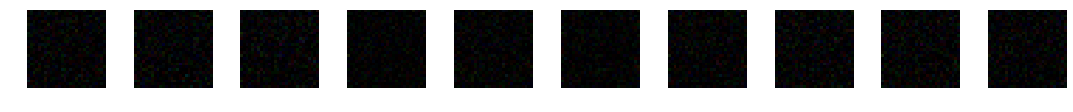

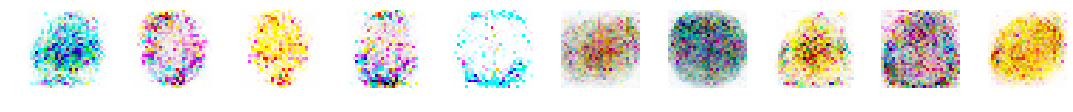

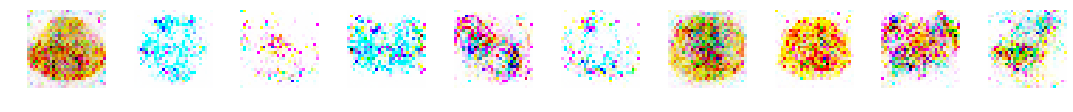

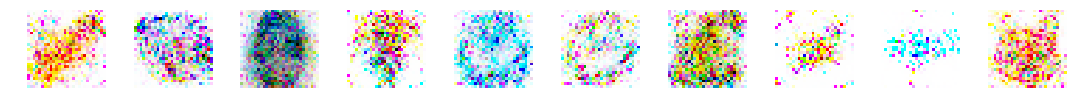

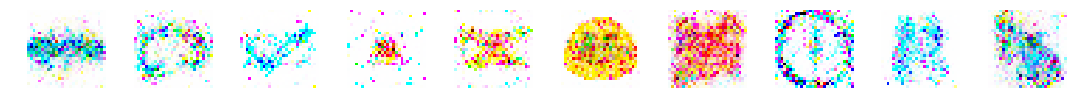

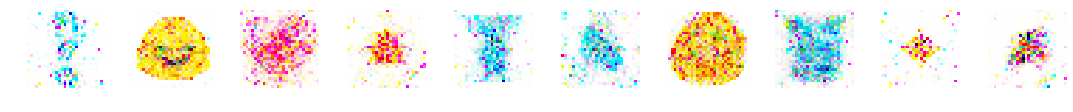

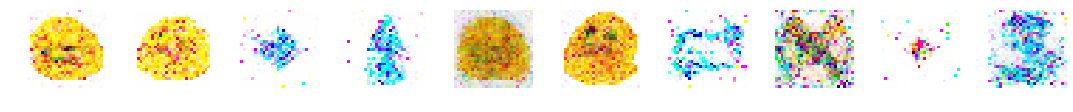

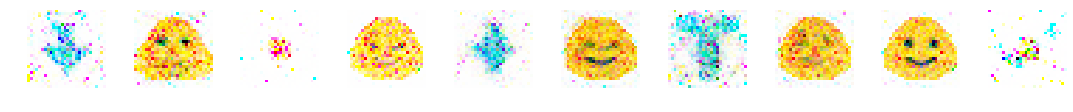

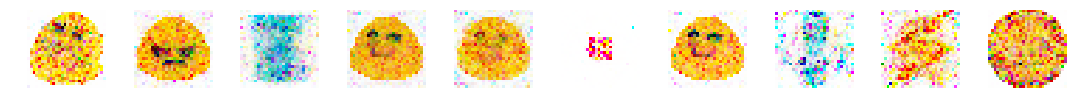

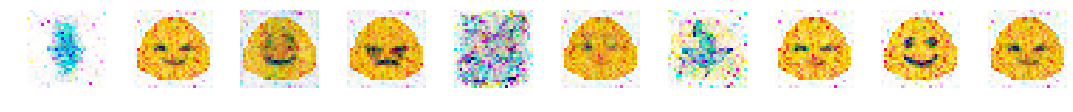

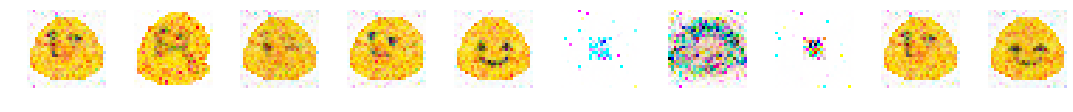

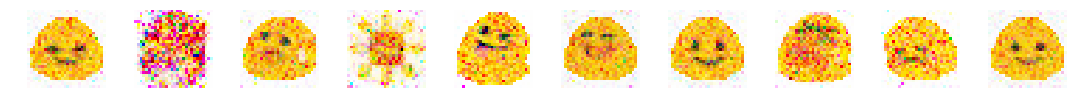

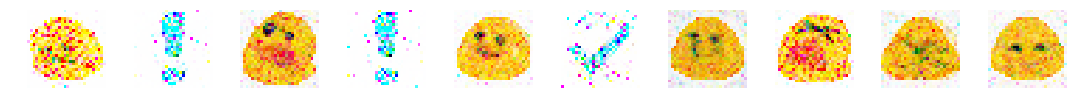

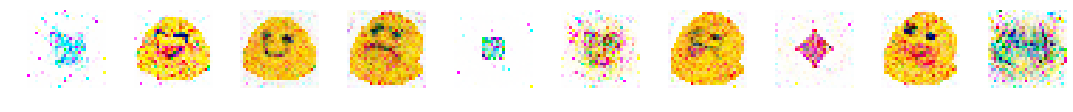

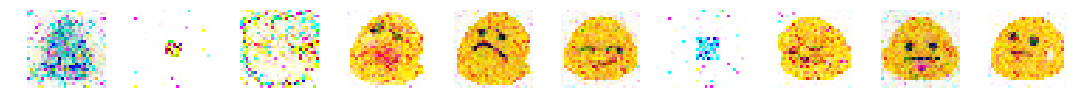

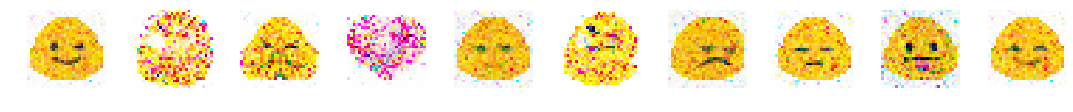

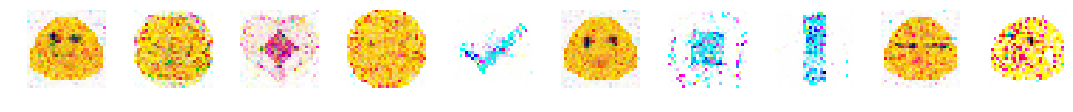

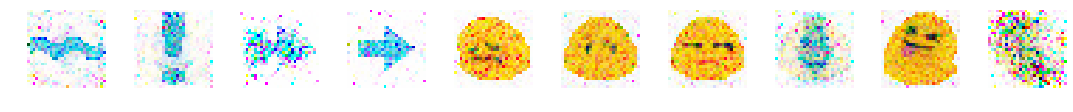

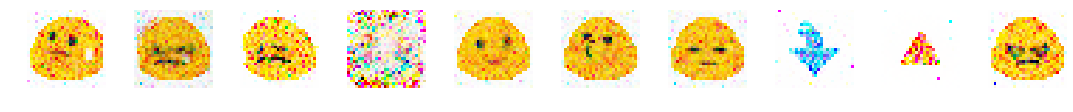

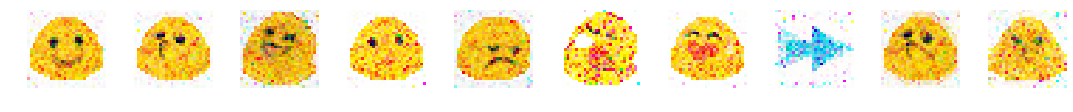

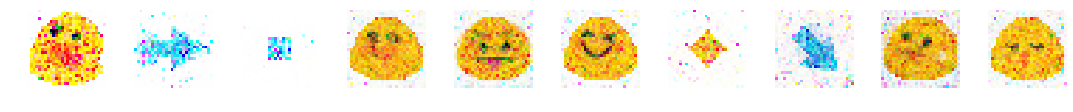

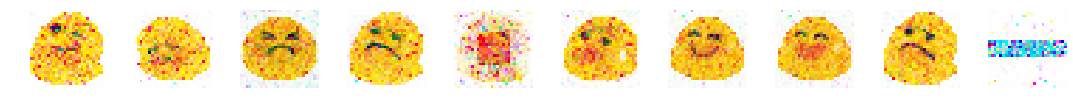

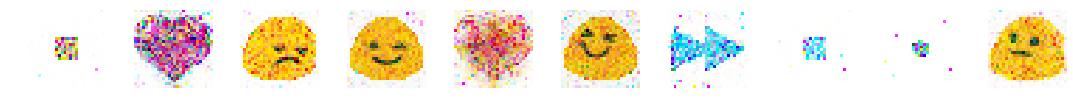

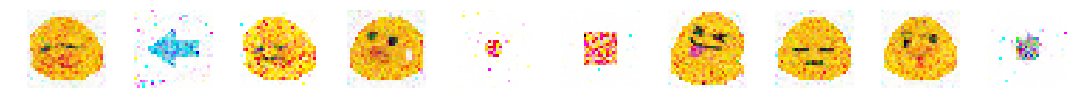

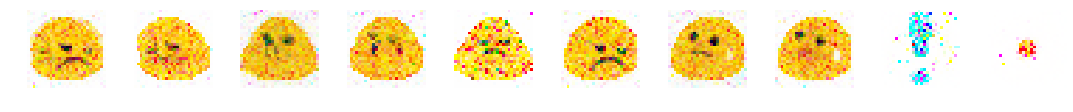

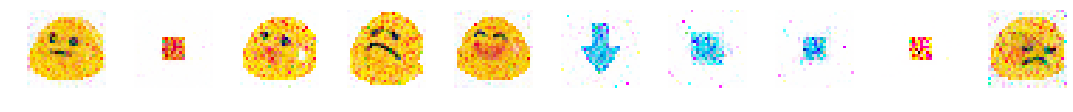

In [154]:
def train(x_train, epochs=1, batch_size=128):
    # Get the training and testing data
    # x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 1000 == 0:
            plot_generated_images(e, generator)
    return generator

generator = train(emojis, 25000, 256)

W0822 20:27:57.145257 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.157042 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.168523 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.179438 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.193773 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.205885 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 20:27:57.220618 139910

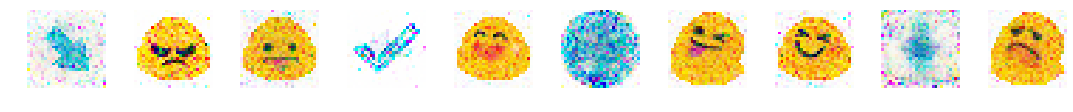

In [155]:
plot_generated_images(25000, generator)

W0822 20:29:08.494708 139910647658368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 27.5, 27.5, -0.5)

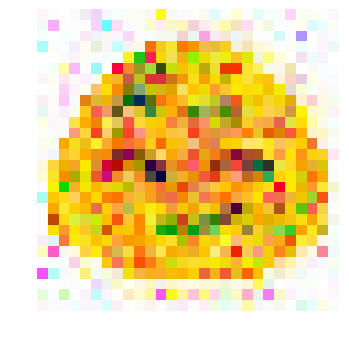

In [171]:
noise = np.random.normal(0, 1, size=[1, random_dim])
x = generator.predict(noise)
fig = plt.figure(dpi=100)
ax = fig.gca()
ax.imshow(x.reshape(28, 28, 3), interpolation='nearest')
ax.axis('off')


In [0]:
fig.savefig('gan_disappoint.jpg', format='jpg')

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [0]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

In [0]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()

In [0]:
from IPython.display import Image
Image(filename='results/example.png')

In [107]:
ls

emoji/                               gan_happy.jpg  gan_sun_face.jpg
emoji.zip                            gan_joy.jpg    gan_worry.jpg
gan_disappoint.jpg                   gan_sad.jpg    sample_data/
gan_generated_image_epoch_25000.png  gan_smile.jpg


# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [0]:
!pip install emoji_data_python

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for emoji-data-python: filename=emoji_data_python-1.1.0-cp36-none-any.whl size=88680 sha256=43025e325286236bdd84fca948daff57f1d342d7e2bb08696b503d52505249e5
  Stored in directory: /root/.cache/pip/wheels/ce/50/87/ae01673e45b9bd9c826a1b868a0e5a6b856e2e52cdf0f81c0d
Successfully built emoji-data-python


In [0]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

In [0]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [0]:
example_emoji.shape

(28, 28, 4)

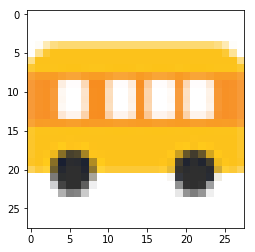

In [0]:
plt.imshow(example_emoji);

In [0]:
grayscale_emoji.shape

(28, 28)

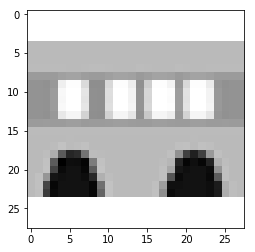

In [0]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [0]:
# strip transparency dimension (because RGB channels are crazy in transparencent spaces)
def strip_transparency(i):
    px_transparent = i[:, :, 3] < 0.1
    i[px_transparent, 0:3] = 1
    i = i[:, :, 0:3]
    return i

In [0]:
emojis = np.array([imageio.imread(os.path.join('emoji/', emoji)) for emoji in os.listdir('emoji/')])

In [0]:
emojis = emojis / 255

In [0]:
emojis = np.array([strip_transparency(emoji) for emoji in emojis])

In [146]:
emojis.shape

(861, 28, 28, 3)

In [0]:
emojis = np.array([emoji.flatten() for emoji in emojis])

In [148]:
emojis.shape

(861, 2352)

In [174]:
!git clone https://github.com/iamcal/emoji-data.git

Cloning into 'emoji-data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 119183 (delta 0), reused 0 (delta 0), pack-reused 119180
Receiving objects: 100% (119183/119183), 1.94 GiB | 51.48 MiB/s, done.
Resolving deltas: 100% (27056/27056), done.
Checking out files: 100% (22822/22822), done.


# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji